# **Well Name:** 0a7822c59487

## Top No CBH

In [ ]:
import pickle
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('max_colwidth', 199)
pd.options.mode.chained_assignment = None
pd.io.formats.excel.ExcelFormatter.header_style = None
import matplotlib
import matplotlib.pyplot as plt

In [ ]:
plt.style.use('ggplot')
matplotlib.rcParams['figure.dpi'] = 110
matplotlib.rcParams['lines.markersize'] = 2
# matplotlib.rcParams['axes.xmargin'] = 0
# matplotlib.rcParams['axes.ymargin'] = 0
matplotlib.rcParams['figure.autolayout'] = False

In [ ]:
aliasDataDict = pickle.load(open('aliasDataDict.pickle', 'rb'))
aliasTestDict = pickle.load(open('aliasTestDict2.pickle', 'rb'))

In [ ]:
testWell = '0a7822c59487'
testStart = [5868]
testStop = [7921]

modelName = testWell+'_top_noCBH'

test = aliasTestDict[testWell]
test = test[((test.Depth>=testStart[0])&(test.Depth<testStop[0]))]
test = test.dropna(axis=1, how='all')
mean = test.SonicC.mean()
std = test.SonicC.std()
print(sorted(test.columns))

['Cali', 'Den', 'DenCor', 'Depth', 'Gamma', 'Lat', 'Lon', 'PhotoE', 'PorDen', 'PorNeu', 'PorSon', 'ResDP', 'ResSH', 'ResXO', 'SonicC', 'Tens']


In [ ]:
# inputSet = set(aliasTestDict['Well 1'].columns)
# or specify inputSet manually
inputSet = set(['Depth', 'Gamma', 'Cali',  
                'PorDen', 'PorNeu', 'PhotoE', 'DenCor',  
                'ResXO', 'SonicC'])
train = pd.DataFrame()
for well in aliasDataDict:
    if inputSet.issubset(set(aliasDataDict[well].columns)):
        temp_df = aliasDataDict[well][sorted(inputSet)+['Target']]        
        # individual well feature engineering
        
        if temp_df.Gamma.max() < 200: 
            temp_df['Gamma'] = (temp_df.Gamma-temp_df.Gamma.min()) / \
                (temp_df.Gamma.max()-temp_df.Gamma.min()) 
        else: 
            temp_df['Gamma'] = (temp_df.Gamma-temp_df.Gamma.min()) / \
                (200-temp_df.Gamma.min()) 
        
        for log in [i for i in inputSet if i[:3]=='Res']: 
            temp_df[log] = np.log10(temp_df[log]) 
            temp_df[log] = temp_df[log].replace([np.inf, -np.inf], np.nan)

        temp_df['CoalFlag'] = 0
        temp_df.loc[(temp_df.SonicC>=90), 'CoalFlag'] = 1
        temp_df.loc[(temp_df.SonicC>=110), 'CoalFlag'] = 2
        if ('PorNeu' in inputSet) and ('PorDen' in inputSet): 
            temp_df.loc[(temp_df.PorDen>=0.15)&(temp_df.PorNeu>=0.15), 'CoalFlag'] = 1
            temp_df.loc[(temp_df.PorDen>=0.25)&(temp_df.PorNeu>=0.25), 'CoalFlag'] = 2
        
        temp_df['CBH'] = 0
        if 'DenCor' in inputSet: 
            temp_df['BadHole'] = 0
            temp_df.loc[(temp_df.DenCor>=0.05)|(temp_df.DenCor<=-0.05), 'BadHole'] = 1
            temp_df.loc[(temp_df.DenCor>=0.10)|(temp_df.DenCor<=-0.10), 'BadHole'] = 2
            temp_df.loc[(temp_df.CoalFlag>0)|(temp_df.BadHole>1), 'CBH'] = 1
        else: 
            temp_df.loc[(temp_df.CoalFlag>0), 'CBH'] = 1

        for log in set(temp_df.columns) - set(['Depth', 'Lat', 'Lon', 'Target']):
            temp_df['d'+log] = np.gradient(temp_df[log], edge_order=2)
            if modelName[-5:]=='noCBH' or modelName[-3:]=='ALL': 
                for sh in [i for i in range(-5, 6) if i != 0]:
                    temp_df[log+str(sh)] = temp_df[log].shift(sh)
                    temp_df[log+str(sh)].fillna(method='ffill', inplace=True)
                    temp_df[log+str(sh)].fillna(method='bfill', inplace=True)
        
        if modelName[-3:]!='ALL': 
            if modelName[-5:]=='noCBH': 
                temp_df = temp_df[temp_df.CBH==0]
            else: 
                temp_df = temp_df[temp_df.CBH!=0]

        temp_df.dropna(subset=inputSet, inplace=True)
        # fillna for dlog
        temp_df.fillna(method='ffill', inplace=True)
        temp_df.fillna(method='bfill', inplace=True) 
        temp_df['Well'] = well

        # VpVs must be within (1, 4)
        temp_df = temp_df[temp_df.Target>1*temp_df.SonicC]
        temp_df = temp_df[temp_df.Target<4*temp_df.SonicC]
        
        # if temp_df after dropna has rows < shift range then cannot fillna
        if temp_df.shape[0]>10 and (temp_df.SonicC.mean()>mean-1*std and temp_df.SonicC.mean()<mean+1*std):
            train = train.append(temp_df)

train.reset_index(drop=True, inplace=True)
train

Cali  DenCor   Depth     Gamma  PhotoE  PorDen  PorNeu     ResXO  \
0       8.3653  0.0189  5000.0  0.249481  4.4407  0.0211  0.0647  1.691051   
1       8.3825  0.0513  5000.5  0.313018  4.2073  0.0181  0.0830  1.546092   
2       8.4203  0.0624  5001.0  0.354829  3.9963  0.0205  0.1009  1.391055   
3       8.4581  0.0491  5001.5  0.337820  3.9214  0.0153  0.1117  1.275786   
4       8.4666  0.0172  5002.0  0.288243  3.9340  0.0196  0.0986  1.333733   
...        ...     ...     ...       ...     ...     ...     ...       ...   
371411  7.4990  0.0850  9879.5  0.362601  5.3879  0.0478  0.0172  1.687464   
371412  7.5003  0.0786  9880.0  0.350552  5.4038  0.0561  0.0173  1.661844   
371413  7.5016  0.0626  9880.5  0.349058  5.4196  0.0785  0.0198  1.630826   
371414  7.5029  0.0377  9881.0  0.356006  5.4375  0.2290  0.0244  1.911339   
371415  7.4915  0.0487  9881.5  0.373381  5.4629  0.2982  0.0291  2.266190   

         SonicC    Target  CoalFlag  CBH  BadHole  dPorDen  PorDen-5  \
0       59.1159  103.9789         0    0        0 -0.00570    0.0148   
1       60.4213  108.3605         0    0        1 -0.00030    0.0241   
2       61.7266  112.7646         0    0        1 -0.00140    0.0430   
3       63.2026  116.2497         0    0        0 -0.00045    0.0561   
4       64.5707  119.6032         0    0        0 -0.00025    0.0520   
...         ...       ...       ...  ...      ...      ...       ...   
371411  58.5681  100.0098         0    0        1  0.00630    0.2947   
371412  57.0784   98.5812         0    0        1  0.01535    0.2241   
371413  56.0417  100.4565         0    0        1  0.08645    0.2019   
371414  56.8915  106.9351         0    0        0  0.10985    0.2298   
371415  58.9502  110.8240         0    0        0  0.03285    0.2287   

        PorDen-4  PorDen-3  PorDen-2  PorDen-1  PorDen1  PorDen2  PorDen3  \
0         0.0196    0.0153    0.0205    0.0181   0.0211   0.0211   0.0211   
1         0.0148    0.0196    0.0153    0.0205   0.0211   0.0211   0.0211   
2         0.0241    0.0148    0.0196    0.0153   0.0181   0.0211   0.0211   
3         0.0430    0.0241    0.0148    0.0196   0.0205   0.0181   0.0211   
4         0.0561    0.0430    0.0241    0.0148   0.0153   0.0205   0.0181   
...          ...       ...       ...       ...      ...      ...      ...   
371411    0.2982    0.2290    0.0785    0.0561   0.0435   0.0365   0.0361   
371412    0.2947    0.2982    0.2290    0.0785   0.0478   0.0435   0.0365   
371413    0.2241    0.2947    0.2982    0.2290   0.0561   0.0478   0.0435   
371414    0.2019    0.2241    0.2947    0.2982   0.0785   0.0561   0.0478   
371415    0.2298    0.2019    0.2241    0.2947   0.2290   0.0785   0.0561   

        PorDen4  PorDen5  dCoalFlag  CoalFlag-5  CoalFlag-4  CoalFlag-3  \
0        0.0211   0.0211        0.0         0.0         0.0         0.0   
1        0.0211   0.0211        0.0         0.0         0.0         0.0   
2        0.0211   0.0211        0.0         0.0         0.0         0.0   
3        0.0211   0.0211        0.0         0.0         0.0         0.0   
4        0.0211   0.0211        0.0         0.0         0.0         0.0   
...         ...      ...        ...         ...         ...         ...   
371411   0.0361   0.0359        0.0         0.0         0.0         0.0   
371412   0.0361   0.0361        0.0         0.0         0.0         0.0   
371413   0.0365   0.0361        0.0         0.0         0.0         0.0   
371414   0.0435   0.0365        0.0         0.0         0.0         0.0   
371415   0.0478   0.0435        0.0         0.0         0.0         0.0   

        CoalFlag-2  CoalFlag-1  CoalFlag1  CoalFlag2  CoalFlag3  CoalFlag4  \
0              0.0         0.0        0.0        0.0        0.0        0.0   
1              0.0         0.0        0.0        0.0        0.0        0.0   
2              0.0         0.0        0.0        0.0        0.0        0.0   
3              0.0         0.0        0.0        0.0        0.0       

In [ ]:
XTest = test[sorted(inputSet)].copy()

if XTest.Gamma.max() < 200: 
    XTest['Gamma'] = (XTest.Gamma-XTest.Gamma.min()) / \
        (XTest.Gamma.max()-XTest.Gamma.min()) 
else: 
    XTest['Gamma'] = (XTest.Gamma-XTest.Gamma.min()) / \
        (200-XTest.Gamma.min()) 

for log in [i for i in inputSet if i[:3]=='Res']: 
    XTest[log] = np.log10(XTest[log]) 
    XTest[log] = XTest[log].replace([np.inf, -np.inf], np.nan)

XTest['CoalFlag'] = 0
XTest.loc[(XTest.SonicC>=90), 'CoalFlag'] = 1
XTest.loc[(XTest.SonicC>=110), 'CoalFlag'] = 2
if ('PorNeu' in inputSet) and ('PorDen' in inputSet): 
    XTest.loc[(XTest.PorDen>=0.15)&(XTest.PorNeu>=0.15), 'CoalFlag'] = 1
    XTest.loc[(XTest.PorDen>=0.25)&(XTest.PorNeu>=0.25), 'CoalFlag'] = 2

XTest['CBH'] = 0 
if 'DenCor' in inputSet: 
    XTest['BadHole'] = 0
    XTest.loc[(XTest.DenCor>=0.05)|(XTest.DenCor<=-0.05), 'BadHole'] = 1
    XTest.loc[(XTest.DenCor>=0.10)|(XTest.DenCor<=-0.10), 'BadHole'] = 2
    XTest.loc[(XTest.CoalFlag>0)|(XTest.BadHole>1), 'CBH'] = 1
else: 
    XTest.loc[(XTest.CoalFlag>0), 'CBH'] = 1

for log in set(XTest.columns) - set(['Depth', 'Lat', 'Lon', 'Target']):
    XTest['d'+log] = np.gradient(XTest[log], edge_order=2)
    if modelName[-5:]=='noCBH' or modelName[-3:]=='ALL': 
        for sh in [i for i in range(-5, 6) if i != 0]:
            XTest[log+str(sh)] = XTest[log].shift(sh)
            XTest[log+str(sh)].fillna(method='ffill', inplace=True)
            XTest[log+str(sh)].fillna(method='bfill', inplace=True)

if modelName[-3:]!='ALL': 
    if modelName[-5:]=='noCBH':
        XTest = XTest[XTest.CBH==0]
    else: 
        XTest = XTest[XTest.CBH!=0]
depthTest = XTest.Depth.values.reshape(-1, 1)

XTest.fillna(method='ffill', inplace=True)
XTest.fillna(method='bfill', inplace=True)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, KFold, PredefinedSplit, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error as mse
import gc

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.wrappers.scikit_learn import KerasRegressor
from keras.layers import *
from keras.models import *
from keras.optimizers import *
from keras.callbacks import *

In [ ]:
XTrnAll = train.drop(['Target', 'Well'], axis=1).copy()
yTrnAll = train[['Target']].copy()

In [ ]:
scaler2 = StandardScaler()
XTrnAll = scaler2.fit_transform(XTrnAll)
XTest = scaler2.transform(XTest)
print(XTrnAll.shape)
print(XTest.shape)

(371416, 133)
(3257, 133)


In [ ]:
keras.backend.clear_session()
if 'model' in globals(): del model
gc.collect()

8793

In [ ]:
params = {'inputDim': XTrn.shape[1], 'nNeurons': 512, 'nLayers': 3, 
          'activation': 'relu', 'doRate': 0.2, 'lr': 5e-5, 
          'epochs': 112, 'batchSize': 10000, 'patience': 10}
          
# setrandomseed()
model = Sequential()
model.add(Dense(units=params['nNeurons'], activation=params['activation'], input_dim=params['inputDim']))
for i in range(int(params['nLayers'])): 
    model.add(Dense(units=params['nNeurons'], activation=params['activation']))
    model.add(Dropout(rate=params['doRate']))
model.add(Dense(1))
model.compile(loss='mse', optimizer=Adam(learning_rate=params['lr']))

# earlyStop = EarlyStopping(monitor='val_loss', mode='min', patience=params['patience'])
# checkPoint = ModelCheckpoint(filepath='others/best_01top.hdf5', verbose=0, save_best_only=True)
   
history = History()
model.fit(XTrnAll, yTrnAll, epochs=params['epochs'], batch_size=params['batchSize'], 
          callbacks=[history]) 

Epoch 1/112
38/38 [==============================] - 1s 15ms/step - loss: 14882.0300
Epoch 2/112
38/38 [==============================] - 1s 15ms/step - loss: 12376.3571
Epoch 3/112
38/38 [==============================] - 1s 15ms/step - loss: 4220.0741
Epoch 4/112
38/38 [==============================] - 1s 15ms/step - loss: 1191.5142
Epoch 5/112
38/38 [==============================] - 1s 15ms/step - loss: 779.2646
Epoch 6/112
38/38 [==============================] - 1s 16ms/step - loss: 665.6379
Epoch 7/112
38/38 [==============================] - 1s 15ms/step - loss: 600.4141
Epoch 8/112
38/38 [==============================] - 1s 15ms/step - loss: 557.8986
Epoch 9/112
38/38 [==============================] - 1s 15ms/step - loss: 516.9851
Epoch 10/112
38/38 [==============================] - 1s 15ms/step - loss: 475.4738
Epoch 11/112
38/38 [==============================] - 1s 15ms/step - loss: 438.1398
Epoch 12/112
38/38 [==============================] - 1s 15ms/step - loss: 402.

In [ ]:
# depthTest = test[['Depth']].values.reshape(-1, 1)
predTest = pd.DataFrame(np.hstack((depthTest, model.predict(XTest))), columns=['Depth', 'DTSM'])
predTest.loc[predTest.DTSM>240, 'DTSM'] = 240
predTest.to_csv('others/predTest_'+modelName+'.csv', index=False)

## Bot No CBH

In [ ]:
testWell = '0a7822c59487'
testStart = [7921]
testStop = [8435.5]

modelName = testWell+'_bot_noCBH'

test = aliasTestDict[testWell]
test = test[((test.Depth>=testStart[0])&(test.Depth<testStop[0]))]
test = test.dropna(axis=1, how='all')
mean = test.SonicC.mean()
std = test.SonicC.std()
print(sorted(test.columns))

['Cali', 'Den', 'DenCor', 'Depth', 'Gamma', 'Lat', 'Lon', 'PhotoE', 'PorDen', 'PorNeu', 'PorSon', 'ResDP', 'ResSH', 'ResXO', 'SonicC', 'Tens']


In [ ]:
# inputSet = set(aliasTestDict['Well 1'].columns)
# or specify inputSet manually
inputSet = set(['Gamma', 'Depth', 
                
                'SonicC'])
train = pd.DataFrame()
for well in aliasDataDict:
    if inputSet.issubset(set(aliasDataDict[well].columns)):
        temp_df = aliasDataDict[well][sorted(inputSet)+['Target']]        
        # individual well feature engineering
        
        if temp_df.Gamma.max() < 200: 
            temp_df['Gamma'] = (temp_df.Gamma-temp_df.Gamma.min()) / \
                (temp_df.Gamma.max()-temp_df.Gamma.min()) 
        else: 
            temp_df['Gamma'] = (temp_df.Gamma-temp_df.Gamma.min()) / \
                (200-temp_df.Gamma.min()) 
        
        for log in [i for i in inputSet if i[:3]=='Res']: 
            temp_df[log] = np.log10(temp_df[log]) 
            temp_df[log] = temp_df[log].replace([np.inf, -np.inf], np.nan)

        temp_df['CoalFlag'] = 0
        temp_df.loc[(temp_df.SonicC>=90), 'CoalFlag'] = 1
        temp_df.loc[(temp_df.SonicC>=110), 'CoalFlag'] = 2
        if ('PorNeu' in inputSet) and ('PorDen' in inputSet): 
            temp_df.loc[(temp_df.PorDen>=0.15)&(temp_df.PorNeu>=0.15), 'CoalFlag'] = 1
            temp_df.loc[(temp_df.PorDen>=0.25)&(temp_df.PorNeu>=0.25), 'CoalFlag'] = 2
        
        temp_df['CBH'] = 0
        if 'DenCor' in inputSet: 
            temp_df['BadHole'] = 0
            temp_df.loc[(temp_df.DenCor>=0.05)|(temp_df.DenCor<=-0.05), 'BadHole'] = 1
            temp_df.loc[(temp_df.DenCor>=0.10)|(temp_df.DenCor<=-0.10), 'BadHole'] = 2
            temp_df.loc[(temp_df.CoalFlag>0)|(temp_df.BadHole>1), 'CBH'] = 1
        else: 
            temp_df.loc[(temp_df.CoalFlag>0), 'CBH'] = 1

        for log in set(temp_df.columns) - set(['Depth', 'Lat', 'Lon', 'Target']):
            temp_df['d'+log] = np.gradient(temp_df[log], edge_order=2)
            if modelName[-5:]=='noCBH' or modelName[-3:]=='ALL': 
                for sh in [i for i in range(-5, 6) if i != 0]:
                    temp_df[log+str(sh)] = temp_df[log].shift(sh)
                    temp_df[log+str(sh)].fillna(method='ffill', inplace=True)
                    temp_df[log+str(sh)].fillna(method='bfill', inplace=True)
        
        if modelName[-3:]!='ALL': 
            if modelName[-5:]=='noCBH': 
                temp_df = temp_df[temp_df.CBH==0]
            else: 
                temp_df = temp_df[temp_df.CBH!=0]

        temp_df.dropna(subset=inputSet, inplace=True)
        # fillna for dlog
        temp_df.fillna(method='ffill', inplace=True)
        temp_df.fillna(method='bfill', inplace=True) 
        temp_df['Well'] = well

        # VpVs must be within (1, 4)
        temp_df = temp_df[temp_df.Target>1*temp_df.SonicC]
        temp_df = temp_df[temp_df.Target<4*temp_df.SonicC]
        
        # if temp_df after dropna has rows < shift range then cannot fillna
        if temp_df.shape[0]>10 and (temp_df.SonicC.mean()>mean-1*std and temp_df.SonicC.mean()<mean+1*std):
            train = train.append(temp_df)
train.reset_index(drop=True, inplace=True)
train

Depth     Gamma   SonicC    Target  CoalFlag  CBH    dGamma  \
0        5997.0  0.529136  88.9985  163.0553         0    0  0.003961   
1        5997.5  0.527855  89.1434  163.5057         0    0 -0.006523   
2        5998.0  0.516091  89.5464  164.0224         0    0 -0.012370   
3        6000.0  0.545153  88.8875  164.4533         0    0  0.033527   
4        6000.5  0.579232  87.9595  162.4191         0    0  0.025491   
...         ...       ...      ...       ...       ...  ...       ...   
1159118  8409.5  0.505336  66.1534  104.5600         0    0  0.008460   
1159119  8410.0  0.514097  66.1619  104.1376         0    0 -0.000710   
1159120  8410.5  0.503917  65.5405  104.5150         0    0 -0.013075   
1159121  8411.0  0.487948  64.9190  104.4782         0    0 -0.015968   
1159122  8411.5  0.471980  64.2370  104.0908         0    0 -0.015968   

          Gamma-5   Gamma-4   Gamma-3   Gamma-2   Gamma-1    Gamma1    Gamma2  \
0        0.512178  0.500085  0.503115  0.516091  0.527855  0.529136  0.529136   
1        0.545153  0.512178  0.500085  0.503115  0.516091  0.529136  0.529136   
2        0.579232  0.545153  0.512178  0.500085  0.503115  0.527855  0.529136   
3        0.535223  0.550874  0.582844  0.596135  0.579232  0.512178  0.500085   
4        0.544270  0.535223  0.550874  0.582844  0.596135  0.545153  0.512178   
...           ...       ...       ...       ...       ...       ...       ...   
1159118  0.471980  0.471980  0.487948  0.503917  0.514097  0.497178  0.501662   
1159119  0.471980  0.471980  0.471980  0.487948  0.503917  0.505336  0.497178   
1159120  0.471980  0.471980  0.471980  0.471980  0.487948  0.514097  0.505336   
1159121  0.471980  0.471980  0.471980  0.471980  0.471980  0.503917  0.514097   
1159122  0.471980  0.471980  0.471980  0.471980  0.471980  0.487948  0.503917   

           Gamma3    Gamma4    Gamma5  dSonicC  SonicC-5  SonicC-4  SonicC-3  \
0        0.529136  0.529136  0.529136  0.01585   90.4654   91.2049   90.4947   
1        0.529136  0.529136  0.529136  0.27395   88.8875   90.4654   91.2049   
2        0.529136  0.529136  0.529136  0.67565   87.9595   88.8875   90.4654   
3        0.503115  0.516091  0.527855 -1.25295   87.6027   87.5959   87.6067   
4        0.500085  0.503115  0.516091 -0.63620   87.5681   87.6027   87.5959   
...           ...       ...       ...      ...       ...       ...       ...   
1159118  0.509732  0.507245  0.477323  0.23130   62.3700   64.2370   64.9190   
1159119  0.501662  0.509732  0.507245 -0.30645   63.1201   62.3700   64.2370   
1159120  0.497178  0.501662  0.509732 -0.62145   63.9684   63.1201   62.3700   
1159121  0.505336  0.497178  0.501662 -0.65175   63.1411   63.9684   63.1201   
1159122  0.514097  0.505336  0.497178 -1.27450   62.1557   63.1411   63.9684   

         SonicC-2  SonicC-1  SonicC1  SonicC2  SonicC3  SonicC4  SonicC5  \
0         89.5464   89.1434  88.9985  88.9985  88.9985  88.9985  88.9985   
1         90.4947   89.5464  88.9985  88.9985  88.9985  88.9985  88.9985   
2         91.2049   90.4947  89.1434  88.9985  88.9985  88.9985  88.9985   
3         87.6151   87.9595  90.4654  91.2049  90.4947  89.5464  89.1434   
4         87.6067   87.6151  88.8875  90.4654  91.2049  90.4947  89.5464   
...           ...       ...      ...      ...      ...      ...      ...   
1159118   65.5405   66.1619  65.6993  65.0236  64.5244  64.0584  64.9908   
1159119   64.9190   65.5405  66.1534  65.6993  65.0236  64.5244  64.0584   
1159120   64.2370   64.9190  66.1619  66.1534  65.6993  65.0236  64.5244   
1159121   62.3700   64.2370  65.5405  66.1619  66.1534  65.6993  65.0236   
1159122   63.1201   62.3700  64.9190  65.5405  66.1619  66.1534  65.6993   

         dCBH  CBH-5  CBH-4  CBH-3  CBH-2  CBH-1  CBH1  CBH2  CBH3  CBH4  \
0         0.0    1.0    1.0    1.0    0.0    0.0   0.0   0.0   0.0   0.0   
1         0.0    0.0    1.0    1.0    1.0    0.0   0.0   0.0   0.0   0.0   
2         0.5    0.0    0.0    1.0    1.0    1.0   0.0   0

In [ ]:
XTest = test[sorted(inputSet)].copy()

if XTest.Gamma.max() < 200: 
    XTest['Gamma'] = (XTest.Gamma-XTest.Gamma.min()) / \
        (XTest.Gamma.max()-XTest.Gamma.min()) 
else: 
    XTest['Gamma'] = (XTest.Gamma-XTest.Gamma.min()) / \
        (200-XTest.Gamma.min()) 

for log in [i for i in inputSet if i[:3]=='Res']: 
    XTest[log] = np.log10(XTest[log]) 
    XTest[log] = XTest[log].replace([np.inf, -np.inf], np.nan)

XTest['CoalFlag'] = 0
XTest.loc[(XTest.SonicC>=90), 'CoalFlag'] = 1
XTest.loc[(XTest.SonicC>=110), 'CoalFlag'] = 2
if ('PorNeu' in inputSet) and ('PorDen' in inputSet): 
    XTest.loc[(XTest.PorDen>=0.15)&(XTest.PorNeu>=0.15), 'CoalFlag'] = 1
    XTest.loc[(XTest.PorDen>=0.25)&(XTest.PorNeu>=0.25), 'CoalFlag'] = 2

XTest['CBH'] = 0 
if 'DenCor' in inputSet: 
    XTest['BadHole'] = 0
    XTest.loc[(XTest.DenCor>=0.05)|(XTest.DenCor<=-0.05), 'BadHole'] = 1
    XTest.loc[(XTest.DenCor>=0.10)|(XTest.DenCor<=-0.10), 'BadHole'] = 2
    XTest.loc[(XTest.CoalFlag>0)|(XTest.BadHole>1), 'CBH'] = 1
else: 
    XTest.loc[(XTest.CoalFlag>0), 'CBH'] = 1

for log in set(XTest.columns) - set(['Depth', 'Lat', 'Lon', 'Target']):
    XTest['d'+log] = np.gradient(XTest[log], edge_order=2)
    if modelName[-5:]=='noCBH' or modelName[-3:]=='ALL': 
        for sh in [i for i in range(-5, 6) if i != 0]:
            XTest[log+str(sh)] = XTest[log].shift(sh)
            XTest[log+str(sh)].fillna(method='ffill', inplace=True)
            XTest[log+str(sh)].fillna(method='bfill', inplace=True)

if modelName[-3:]!='ALL': 
    if modelName[-5:]=='noCBH':
        XTest = XTest[XTest.CBH==0]
    else: 
        XTest = XTest[XTest.CBH!=0]
depthTest = XTest.Depth.values.reshape(-1, 1)

XTest.fillna(method='ffill', inplace=True)
XTest.fillna(method='bfill', inplace=True)

In [ ]:
keras.backend.clear_session()
if 'model' in globals(): del model
gc.collect()

8556

In [ ]:
params = {'inputDim': XTrn.shape[1], 'nNeurons': 512, 'nLayers': 3, 
          'activation': 'relu', 'doRate': 0.0, 'lr': 1e-4, 
          'epochs': 29, 'batchSize': 10000, 'patience': 10}
          
# setrandomseed()
model = Sequential()
model.add(Dense(units=params['nNeurons'], activation=params['activation'], input_dim=params['inputDim']))
for i in range(int(params['nLayers'])): 
    model.add(Dense(units=params['nNeurons'], activation=params['activation']))
    model.add(Dropout(rate=params['doRate']))
model.add(Dense(1))
model.compile(loss='mse', optimizer=Adam(learning_rate=params['lr']))

# earlyStop = EarlyStopping(monitor='val_loss', mode='min', patience=params['patience'])
# checkPoint = ModelCheckpoint(filepath='others/best_01top.hdf5', verbose=0, save_best_only=True)

history = History()
model.fit(XTrnAll, yTrnAll, epochs=params['epochs'], batch_size=params['batchSize'], 
          callbacks=[history]) 

Epoch 1/29
116/116 [==============================] - 2s 14ms/step - loss: 12435.1175
Epoch 2/29
116/116 [==============================] - 2s 14ms/step - loss: 1264.9209
Epoch 3/29
116/116 [==============================] - 2s 13ms/step - loss: 358.3076
Epoch 4/29
116/116 [==============================] - 2s 14ms/step - loss: 167.9358
Epoch 5/29
116/116 [==============================] - 2s 13ms/step - loss: 149.5359
Epoch 6/29
116/116 [==============================] - 2s 13ms/step - loss: 141.1223
Epoch 7/29
116/116 [==============================] - 2s 13ms/step - loss: 136.4295
Epoch 8/29
116/116 [==============================] - 2s 13ms/step - loss: 132.8280
Epoch 9/29
116/116 [==============================] - 2s 14ms/step - loss: 130.9444
Epoch 10/29
116/116 [==============================] - 2s 14ms/step - loss: 130.4926
Epoch 11/29
116/116 [==============================] - 2s 14ms/step - loss: 129.7376
Epoch 12/29
116/116 [==============================] - 2s 14ms/step - l

In [ ]:
# depthTest = test[['Depth']].values.reshape(-1, 1)
predTest = pd.DataFrame(np.hstack((depthTest, model.predict(XTest))), columns=['Depth', 'DTSM'])
predTest.loc[predTest.DTSM>240, 'DTSM'] = 240
predTest.to_csv('others/predTest_'+modelName+'.csv', index=False)

# Well Name: 113412eec2a6

## Top No CBH

In [ ]:
testWell = '113412eec2a6'
testStart = [5000, 7560.5, 8960.5, 9420.5]
testStop = [6492, 8490.5, 9330.5, 9490.5]

modelName = testWell+'_top_noCBH'

test = aliasTestDict[testWell]
test = test[((test.Depth>=testStart[0])&(test.Depth<testStop[0])) | 
            ((test.Depth>=testStart[1])&(test.Depth<testStop[1])) | 
            ((test.Depth>=testStart[2])&(test.Depth<testStop[2])) | 
            ((test.Depth>=testStart[3])&(test.Depth<testStop[3]))]
test = test.dropna(axis=1, how='all')
mean = test.SonicC.mean()
std = test.SonicC.std()
print(sorted(test.columns))

['DenCor', 'Depth', 'Gamma', 'Lat', 'Lon', 'PhotoE', 'PorDen', 'ResDP', 'ResMD', 'ResXO', 'SonicC', 'SponP']


In [ ]:
# inputSet = set(aliasTestDict['Well 1'].columns)
# or specify inputSet manually
inputSet = set(['Depth', 'Gamma',  
                
                'ResXO', 'SonicC'])
train = pd.DataFrame()
for well in aliasDataDict:
    if inputSet.issubset(set(aliasDataDict[well].columns)):
        temp_df = aliasDataDict[well][sorted(inputSet)+['Target']]        
        # individual well feature engineering
        
        if temp_df.Gamma.max() < 200: 
            temp_df['Gamma'] = (temp_df.Gamma-temp_df.Gamma.min()) / \
                (temp_df.Gamma.max()-temp_df.Gamma.min()) 
        else: 
            temp_df['Gamma'] = (temp_df.Gamma-temp_df.Gamma.min()) / \
                (200-temp_df.Gamma.min()) 
        
        for log in [i for i in inputSet if i[:3]=='Res']: 
            temp_df[log] = np.log10(temp_df[log]) 
            temp_df[log] = temp_df[log].replace([np.inf, -np.inf], np.nan)

        temp_df['CoalFlag'] = 0
        temp_df.loc[(temp_df.SonicC>=90), 'CoalFlag'] = 1
        temp_df.loc[(temp_df.SonicC>=110), 'CoalFlag'] = 2
        if ('PorNeu' in inputSet) and ('PorDen' in inputSet): 
            temp_df.loc[(temp_df.PorDen>=0.15)&(temp_df.PorNeu>=0.15), 'CoalFlag'] = 1
            temp_df.loc[(temp_df.PorDen>=0.25)&(temp_df.PorNeu>=0.25), 'CoalFlag'] = 2
        
        temp_df['CBH'] = 0
        if 'DenCor' in inputSet: 
            temp_df['BadHole'] = 0
            temp_df.loc[(temp_df.DenCor>=0.05)|(temp_df.DenCor<=-0.05), 'BadHole'] = 1
            temp_df.loc[(temp_df.DenCor>=0.10)|(temp_df.DenCor<=-0.10), 'BadHole'] = 2
            temp_df.loc[(temp_df.CoalFlag>0)|(temp_df.BadHole>1), 'CBH'] = 1
        else: 
            temp_df.loc[(temp_df.CoalFlag>0), 'CBH'] = 1

        for log in set(temp_df.columns) - set(['Depth', 'Lat', 'Lon', 'Target']):
            temp_df['d'+log] = np.gradient(temp_df[log], edge_order=2)
            if modelName[-5:]=='noCBH' or modelName[-3:]=='ALL': 
                for sh in [i for i in range(-5, 6) if i != 0]:
                    temp_df[log+str(sh)] = temp_df[log].shift(sh)
                    temp_df[log+str(sh)].fillna(method='ffill', inplace=True)
                    temp_df[log+str(sh)].fillna(method='bfill', inplace=True)
        
        if modelName[-3:]!='ALL': 
            if modelName[-5:]=='noCBH': 
                temp_df = temp_df[temp_df.CBH==0]
            else: 
                temp_df = temp_df[temp_df.CBH!=0]

        temp_df.dropna(subset=inputSet, inplace=True)
        # fillna for dlog
        temp_df.fillna(method='ffill', inplace=True)
        temp_df.fillna(method='bfill', inplace=True) 
        temp_df['Well'] = well

        # VpVs must be within (1, 4)
        temp_df = temp_df[temp_df.Target>1*temp_df.SonicC]
        temp_df = temp_df[temp_df.Target<4*temp_df.SonicC]
        
        # if temp_df after dropna has rows < shift range then cannot fillna
        if temp_df.shape[0]>10 and (temp_df.SonicC.mean()>mean-1*std and temp_df.SonicC.mean()<mean+1*std):
            train = train.append(temp_df)
train.reset_index(drop=True, inplace=True)
train

Depth     Gamma     ResXO   SonicC    Target  CoalFlag  CBH  dCBH  \
0       5000.0  0.249481  1.691051  59.1159  103.9789         0    0   0.0   
1       5000.5  0.313018  1.546092  60.4213  108.3605         0    0   0.0   
2       5001.0  0.354829  1.391055  61.7266  112.7646         0    0   0.0   
3       5001.5  0.337820  1.275786  63.2026  116.2497         0    0   0.0   
4       5002.0  0.288243  1.333733  64.5707  119.6032         0    0   0.0   
...        ...       ...       ...      ...       ...       ...  ...   ...   
613608  9886.0  0.412005  1.101059  66.5320  110.3035         0    0   0.0   
613609  9886.5  0.401506  1.228672  77.1156  126.1883         0    0   0.0   
613610  9887.0  0.391007  1.374801  79.3813  133.1629         0    0   0.0   
613611  9887.5  0.380913  1.522089  79.5518  133.7637         0    0   0.0   
613612  9888.0  0.378718  1.722222  80.5550  130.2718         0    0   0.0   

        CBH-5  CBH-4  CBH-3  CBH-2  CBH-1  CBH1  CBH2  CBH3  CBH4  CBH5  \
0         0.0    0.0    0.0    0.0    0.0   0.0   0.0   0.0   0.0   0.0   
1         0.0    0.0    0.0    0.0    0.0   0.0   0.0   0.0   0.0   0.0   
2         0.0    0.0    0.0    0.0    0.0   0.0   0.0   0.0   0.0   0.0   
3         0.0    0.0    0.0    0.0    0.0   0.0   0.0   0.0   0.0   0.0   
4         0.0    0.0    0.0    0.0    0.0   0.0   0.0   0.0   0.0   0.0   
...       ...    ...    ...    ...    ...   ...   ...   ...   ...   ...   
613608    0.0    0.0    0.0    0.0    0.0   0.0   0.0   0.0   0.0   0.0   
613609    0.0    0.0    0.0    0.0    0.0   0.0   0.0   0.0   0.0   0.0   
613610    0.0    0.0    0.0    0.0    0.0   0.0   0.0   0.0   0.0   0.0   
613611    0.0    0.0    0.0    0.0    0.0   0.0   0.0   0.0   0.0   0.0   
613612    0.0    0.0    0.0    0.0    0.0   0.0   0.0   0.0   0.0   0.0   

        dCoalFlag  CoalFlag-5  CoalFlag-4  CoalFlag-3  CoalFlag-2  CoalFlag-1  \
0             0.0         0.0         0.0         0.0         0.0         0.0   
1             0.0         0.0         0.0         0.0         0.0         0.0   
2             0.0         0.0         0.0         0.0         0.0         0.0   
3             0.0         0.0         0.0         0.0         0.0         0.0   
4             0.0         0.0         0.0         0.0         0.0         0.0   
...           ...         ...         ...         ...         ...         ...   
613608        0.0         0.0         0.0         0.0         0.0         0.0   
613609        0.0         0.0         0.0         0.0         0.0         0.0   
613610        0.0         0.0         0.0         0.0         0.0         0.0   
613611        0.0         0.0         0.0         0.0         0.0         0.0   
613612        0.0         0.0         0.0         0.0         0.0         0.0   

        CoalFlag1  CoalFlag2  CoalFlag3  CoalFlag4  CoalFlag5  dSonicC  \
0             0.0        0.0        0.0        0.0        0.0  1.30545   
1             0.0        0.0        0.0        0.0        0.0  1.30535   
2             0.0        0.0        0.0        0.0        0.0  1.39065   
3             0.0        0.0        0.0        0.0        0.0  1.42205   
4             0.0        0.0        0.0        0.0        0.0  1.47575   
...           ...        ...        ...        ...        ...      ...   
613608        0.0        0.0        0.0        0.0        0.0  9.51275   
613609        0.0        0.0        0.0        0.0        0.0  6.42465   
613610        0.0        0.0        0.0        0.0        0.0  1.21810   
613611        0.0        0.0        0.0        0.0        0.0  0.58685   
613612        0.0        0.0        0.0        0.0        0.0  1.05345   

        SonicC-5  SonicC-4  SonicC-3  SonicC-2  SonicC-1  SonicC1  SonicC2  \
0        66.1541   64.5707   63.2026   61.7266   60.4213  59.1159  59.1159   
1        68.0334   66.1541   64.5707   63.2026   61.7266  59.1159  59.1159   
2        70.5010   68.0334   66.1541   64.5707   63.2026  60.4213  59.1159 

In [ ]:
XTest = test[sorted(inputSet)].copy()

if XTest.Gamma.max() < 200: 
    XTest['Gamma'] = (XTest.Gamma-XTest.Gamma.min()) / \
        (XTest.Gamma.max()-XTest.Gamma.min()) 
else: 
    XTest['Gamma'] = (XTest.Gamma-XTest.Gamma.min()) / \
        (200-XTest.Gamma.min()) 

for log in [i for i in inputSet if i[:3]=='Res']: 
    XTest[log] = np.log10(XTest[log]) 
    XTest[log] = XTest[log].replace([np.inf, -np.inf], np.nan)

XTest['CoalFlag'] = 0
XTest.loc[(XTest.SonicC>=90), 'CoalFlag'] = 1
XTest.loc[(XTest.SonicC>=110), 'CoalFlag'] = 2
if ('PorNeu' in inputSet) and ('PorDen' in inputSet): 
    XTest.loc[(XTest.PorDen>=0.15)&(XTest.PorNeu>=0.15), 'CoalFlag'] = 1
    XTest.loc[(XTest.PorDen>=0.25)&(XTest.PorNeu>=0.25), 'CoalFlag'] = 2

XTest['CBH'] = 0 
if 'DenCor' in inputSet: 
    XTest['BadHole'] = 0
    XTest.loc[(XTest.DenCor>=0.05)|(XTest.DenCor<=-0.05), 'BadHole'] = 1
    XTest.loc[(XTest.DenCor>=0.10)|(XTest.DenCor<=-0.10), 'BadHole'] = 2
    XTest.loc[(XTest.CoalFlag>0)|(XTest.BadHole>1), 'CBH'] = 1
else: 
    XTest.loc[(XTest.CoalFlag>0), 'CBH'] = 1

for log in set(XTest.columns) - set(['Depth', 'Lat', 'Lon', 'Target']):
    XTest['d'+log] = np.gradient(XTest[log], edge_order=2)
    if modelName[-5:]=='noCBH' or modelName[-3:]=='ALL': 
        for sh in [i for i in range(-5, 6) if i != 0]:
            XTest[log+str(sh)] = XTest[log].shift(sh)
            XTest[log+str(sh)].fillna(method='ffill', inplace=True)
            XTest[log+str(sh)].fillna(method='bfill', inplace=True)

if modelName[-3:]!='ALL': 
    if modelName[-5:]=='noCBH':
        XTest = XTest[XTest.CBH==0]
    else: 
        XTest = XTest[XTest.CBH!=0]
depthTest = XTest.Depth.values.reshape(-1, 1)

XTest.fillna(method='ffill', inplace=True)
XTest.fillna(method='bfill', inplace=True)

In [ ]:
XTrnAll = train.drop(['Target', 'Well'], axis=1).copy()
yTrnAll = train[['Target']].copy()

In [ ]:
scaler2 = StandardScaler()
XTrnAll = scaler2.fit_transform(XTrnAll)
XTest = scaler2.transform(XTest)
print(XTrnAll.shape)
print(XTest.shape)

(613613, 61)
(5549, 61)


In [ ]:
keras.backend.clear_session()
if 'model' in globals(): del model
gc.collect()

10365

In [ ]:
params = {'inputDim': XTrn.shape[1], 'nNeurons': 512, 'nLayers': 4, 
          'activation': 'relu', 'doRate': 0.0, 'lr': 5e-5, 
          'epochs': 26, 'batchSize': 10000, 'patience': 10}
          
# setrandomseed()
model = Sequential()
model.add(Dense(units=params['nNeurons'], activation=params['activation'], input_dim=params['inputDim']))
for i in range(int(params['nLayers'])): 
    model.add(Dense(units=params['nNeurons'], activation=params['activation']))
    model.add(Dropout(rate=params['doRate']))
model.add(Dense(1))
model.compile(loss='mse', optimizer=Adam(learning_rate=params['lr']))

# earlyStop = EarlyStopping(monitor='val_loss', mode='min', patience=params['patience'])
# checkPoint = ModelCheckpoint(filepath='others/best_01top.hdf5', verbose=0, save_best_only=True)
 
history = History()
model.fit(XTrnAll, yTrnAll, epochs=params['epochs'], batch_size=params['batchSize'], 
          callbacks=[history]) 

Epoch 1/26
62/62 [==============================] - 1s 16ms/step - loss: 16419.6861
Epoch 2/26
62/62 [==============================] - 1s 16ms/step - loss: 6352.8364
Epoch 3/26
62/62 [==============================] - 1s 16ms/step - loss: 1806.2615
Epoch 4/26
62/62 [==============================] - 1s 16ms/step - loss: 1258.6536
Epoch 5/26
62/62 [==============================] - 1s 16ms/step - loss: 829.5940
Epoch 6/26
62/62 [==============================] - 1s 16ms/step - loss: 427.6625
Epoch 7/26
62/62 [==============================] - 1s 16ms/step - loss: 230.4787
Epoch 8/26
62/62 [==============================] - 1s 16ms/step - loss: 191.4602
Epoch 9/26
62/62 [==============================] - 1s 16ms/step - loss: 176.4393
Epoch 10/26
62/62 [==============================] - 1s 16ms/step - loss: 166.2483
Epoch 11/26
62/62 [==============================] - 1s 16ms/step - loss: 159.4833
Epoch 12/26
62/62 [==============================] - 1s 16ms/step - loss: 153.7924
Epoch 13

In [ ]:
# depthTest = test[['Depth']].values.reshape(-1, 1)
predTest = pd.DataFrame(np.hstack((depthTest, model.predict(XTest))), columns=['Depth', 'DTSM'])
predTest.loc[predTest.DTSM>240, 'DTSM'] = 240
predTest.to_csv('others/predTest_'+modelName+'.csv', index=False)

## Bot No CBH

In [ ]:
testWell = '113412eec2a6'
testStart = [6492, 8490.5, 9330.5, 9490.5]
testStop = [7560.5, 8960.5, 9420.5, 11423]

modelName = testWell+'_bot_noCBH'

test = aliasTestDict[testWell]
test = test[((test.Depth>=testStart[0])&(test.Depth<testStop[0])) | 
            ((test.Depth>=testStart[1])&(test.Depth<testStop[1])) | 
            ((test.Depth>=testStart[2])&(test.Depth<testStop[2])) | 
            ((test.Depth>=testStart[3])&(test.Depth<testStop[3]))]
test = test.dropna(axis=1, how='all')
mean = test.SonicC.mean()
std = test.SonicC.std()
print(sorted(test.columns))

['Den', 'DenCor', 'Depth', 'Gamma', 'Lat', 'Lon', 'PhotoE', 'PorDen', 'PorNeu', 'ResDP', 'ResMD', 'ResXO', 'SonicC', 'SponP']


In [ ]:
# inputSet = set(aliasTestDict['Well 1'].columns)
# or specify inputSet manually
inputSet = set(['Depth', 'Gamma', 
                'PorDen', 'PorNeu', 'PhotoE', 'DenCor', 
                'ResXO', 'SonicC'])
train = pd.DataFrame()
for well in aliasDataDict:
    if inputSet.issubset(set(aliasDataDict[well].columns)):
        temp_df = aliasDataDict[well][sorted(inputSet)+['Target']]        
        # individual well feature engineering
        
        if temp_df.Gamma.max() < 200: 
            temp_df['Gamma'] = (temp_df.Gamma-temp_df.Gamma.min()) / \
                (temp_df.Gamma.max()-temp_df.Gamma.min()) 
        else: 
            temp_df['Gamma'] = (temp_df.Gamma-temp_df.Gamma.min()) / \
                (200-temp_df.Gamma.min()) 
        
        for log in [i for i in inputSet if i[:3]=='Res']: 
            temp_df[log] = np.log10(temp_df[log]) 
            temp_df[log] = temp_df[log].replace([np.inf, -np.inf], np.nan)

        temp_df['CoalFlag'] = 0
        temp_df.loc[(temp_df.SonicC>=90), 'CoalFlag'] = 1
        temp_df.loc[(temp_df.SonicC>=110), 'CoalFlag'] = 2
        if ('PorNeu' in inputSet) and ('PorDen' in inputSet): 
            temp_df.loc[(temp_df.PorDen>=0.15)&(temp_df.PorNeu>=0.15), 'CoalFlag'] = 1
            temp_df.loc[(temp_df.PorDen>=0.25)&(temp_df.PorNeu>=0.25), 'CoalFlag'] = 2
        
        temp_df['CBH'] = 0
        if 'DenCor' in inputSet: 
            temp_df['BadHole'] = 0
            temp_df.loc[(temp_df.DenCor>=0.05)|(temp_df.DenCor<=-0.05), 'BadHole'] = 1
            temp_df.loc[(temp_df.DenCor>=0.10)|(temp_df.DenCor<=-0.10), 'BadHole'] = 2
            temp_df.loc[(temp_df.CoalFlag>0)|(temp_df.BadHole>1), 'CBH'] = 1
        else: 
            temp_df.loc[(temp_df.CoalFlag>0), 'CBH'] = 1

        for log in set(temp_df.columns) - set(['Depth', 'Lat', 'Lon', 'Target']):
            temp_df['d'+log] = np.gradient(temp_df[log], edge_order=2)
            if modelName[-5:]=='noCBH' or modelName[-3:]=='ALL': 
                for sh in [i for i in range(-5, 6) if i != 0]:
                    temp_df[log+str(sh)] = temp_df[log].shift(sh)
                    temp_df[log+str(sh)].fillna(method='ffill', inplace=True)
                    temp_df[log+str(sh)].fillna(method='bfill', inplace=True)
        
        if modelName[-3:]!='ALL': 
            if modelName[-5:]=='noCBH': 
                temp_df = temp_df[temp_df.CBH==0]
            else: 
                temp_df = temp_df[temp_df.CBH!=0]

        temp_df.dropna(subset=inputSet, inplace=True)
        # fillna for dlog
        temp_df.fillna(method='ffill', inplace=True)
        temp_df.fillna(method='bfill', inplace=True) 
        temp_df['Well'] = well

        # VpVs must be within (1, 4)
        temp_df = temp_df[temp_df.Target>1*temp_df.SonicC]
        temp_df = temp_df[temp_df.Target<4*temp_df.SonicC]
        
        # if temp_df after dropna has rows < shift range then cannot fillna
        if temp_df.shape[0]>10 and (temp_df.SonicC.mean()>mean-1*std and temp_df.SonicC.mean()<mean+1*std):
            train = train.append(temp_df)
train.reset_index(drop=True, inplace=True)
train

DenCor   Depth     Gamma  PhotoE  PorDen  PorNeu     ResXO   SonicC  \
0      -0.0004  5400.5  0.303823  6.3222 -0.1780  0.0576 -0.685922  51.7345   
1      -0.0004  5401.0  0.293159  4.4748 -0.0350  0.0395  1.004433  50.8980   
2      -0.0003  5401.5  0.274857  4.4749 -0.0068  0.0341  1.844553  50.2660   
3      -0.0003  5402.0  0.257573  4.4451  0.0004  0.0329  2.379299  50.0845   
4      -0.0033  5402.5  0.249456  4.3852 -0.0026  0.0347  2.401629  49.9931   
...        ...     ...       ...     ...     ...     ...       ...      ...   
486072  0.0012  8409.5  0.505336  2.5230  0.0459  0.0619  1.353774  66.1534   
486073  0.0008  8410.0  0.514097  2.5185  0.0545  0.0618  1.329910  66.1619   
486074  0.0004  8410.5  0.503917  2.5187  0.0591  0.0618  1.329910  65.5405   
486075  0.0001  8411.0  0.487948  2.5190  0.0591  0.0554  1.329910  64.9190   
486076 -0.0003  8411.5  0.471980  2.5192  0.0591  0.0521  1.356001  64.2370   

          Target  CoalFlag  CBH  BadHole    dGamma   Gamma-5   Gamma-4  \
0        97.2199         0    0        0 -0.006844  0.249488  0.249456   
1        95.9859         0    0        0 -0.014483  0.281605  0.249488   
2        94.7922         0    0        0 -0.017793  0.325435  0.281605   
3        94.1404         0    0        0 -0.012701  0.361626  0.325435   
4        92.9669         0    0        0 -0.004042  0.371844  0.361626   
...          ...       ...  ...      ...       ...       ...       ...   
486072  104.5600         0    0        0  0.008460  0.471980  0.471980   
486073  104.1376         0    0        0 -0.000710  0.471980  0.471980   
486074  104.5150         0    0        0 -0.013075  0.471980  0.471980   
486075  104.4782         0    0        0 -0.015968  0.471980  0.471980   
486076  104.0908         0    0        0 -0.015968  0.471980  0.471980   

         Gamma-3   Gamma-2   Gamma-1    Gamma1    Gamma2    Gamma3    Gamma4  \
0       0.257573  0.274857  0.293159  0.303823  0.303823  0.303823  0.303823   
1       0.249456  0.257573  0.274857  0.303823  0.303823  0.303823  0.303823   
2       0.249488  0.249456  0.257573  0.293159  0.303823  0.303823  0.303823   
3       0.281605  0.249488  0.249456  0.274857  0.293159  0.303823  0.303823   
4       0.325435  0.281605  0.249488  0.257573  0.274857  0.293159  0.303823   
...          ...       ...       ...       ...       ...       ...       ...   
486072  0.487948  0.503917  0.514097  0.497178  0.501662  0.509732  0.507245   
486073  0.471980  0.487948  0.503917  0.505336  0.497178  0.501662  0.509732   
486074  0.471980  0.471980  0.487948  0.514097  0.505336  0.497178  0.501662   
486075  0.471980  0.471980  0.471980  0.503917  0.514097  0.505336  0.497178   
486076  0.471980  0.471980  0.471980  0.487948  0.503917  0.514097  0.505336   

          Gamma5  dDenCor  DenCor-5  DenCor-4  DenCor-3  DenCor-2  DenCor-1  \
0       0.303823 -0.00005   -0.0062   -0.0033   -0.0003   -0.0003   -0.0004   
1       0.303823  0.00005   -0.0047   -0.0062   -0.0033   -0.0003   -0.0003   
2       0.303823  0.00005   -0.0031   -0.0047   -0.0062   -0.0033   -0.0003   
3       0.303823 -0.00150   -0.0001   -0.0031   -0.0047   -0.0062   -0.0033   
4       0.303823 -0.00295    0.0029   -0.0001   -0.0031   -0.0047   -0.0062   
...          ...      ...       ...       ...       ...       ...       ...   
486072  0.477323 -0.00060    0.0061   -0.0003    0.0001    0.0004    0.0008   
486073  0.507245 -0.00040    0.0036    0.0061   -0.0003    0.0001    0.0004   
486074  0.509732 -0.00035    0.0010    0.0036    0.0061   -0.0003    0.0001   
486075  0.501662 -0.00035   -0.0016    0.0010    0.0036    0.0061   -0.0003   
486076  0.497178  0.00300   -0.0012   -0.0016    0.0010    0.0036    0.0061   

        DenCor1  DenCor2  DenCor3  DenCor4  DenCor5  dPorNeu  PorNeu-5  \
0       -0.0004  -0.0004  -0.0004  -0.0004  -0.0004 -0.02445    0.0383   
1       -0.0004  -0.0004  -0.0004  -0.0004  -0.0004 -0.01175    0.0419   
2       -0.0004  -0.0004  -0.0004  -0.

In [ ]:
XTest = test[sorted(inputSet)].copy()

if XTest.Gamma.max() < 200: 
    XTest['Gamma'] = (XTest.Gamma-XTest.Gamma.min()) / \
        (XTest.Gamma.max()-XTest.Gamma.min()) 
else: 
    XTest['Gamma'] = (XTest.Gamma-XTest.Gamma.min()) / \
        (200-XTest.Gamma.min()) 

for log in [i for i in inputSet if i[:3]=='Res']: 
    XTest[log] = np.log10(XTest[log]) 
    XTest[log] = XTest[log].replace([np.inf, -np.inf], np.nan)

XTest['CoalFlag'] = 0
XTest.loc[(XTest.SonicC>=90), 'CoalFlag'] = 1
XTest.loc[(XTest.SonicC>=110), 'CoalFlag'] = 2
if ('PorNeu' in inputSet) and ('PorDen' in inputSet): 
    XTest.loc[(XTest.PorDen>=0.15)&(XTest.PorNeu>=0.15), 'CoalFlag'] = 1
    XTest.loc[(XTest.PorDen>=0.25)&(XTest.PorNeu>=0.25), 'CoalFlag'] = 2

XTest['CBH'] = 0 
if 'DenCor' in inputSet: 
    XTest['BadHole'] = 0
    XTest.loc[(XTest.DenCor>=0.05)|(XTest.DenCor<=-0.05), 'BadHole'] = 1
    XTest.loc[(XTest.DenCor>=0.10)|(XTest.DenCor<=-0.10), 'BadHole'] = 2
    XTest.loc[(XTest.CoalFlag>0)|(XTest.BadHole>1), 'CBH'] = 1
else: 
    XTest.loc[(XTest.CoalFlag>0), 'CBH'] = 1

for log in set(XTest.columns) - set(['Depth', 'Lat', 'Lon', 'Target']):
    XTest['d'+log] = np.gradient(XTest[log], edge_order=2)
    if modelName[-5:]=='noCBH' or modelName[-3:]=='ALL': 
        for sh in [i for i in range(-5, 6) if i != 0]:
            XTest[log+str(sh)] = XTest[log].shift(sh)
            XTest[log+str(sh)].fillna(method='ffill', inplace=True)
            XTest[log+str(sh)].fillna(method='bfill', inplace=True)

if modelName[-3:]!='ALL': 
    if modelName[-5:]=='noCBH':
        XTest = XTest[XTest.CBH==0]
    else: 
        XTest = XTest[XTest.CBH!=0]
depthTest = XTest.Depth.values.reshape(-1, 1)

XTest.fillna(method='ffill', inplace=True)
XTest.fillna(method='bfill', inplace=True)

In [ ]:
XTrnAll = train.drop(['Target', 'Well'], axis=1).copy()
yTrnAll = train[['Target']].copy()

In [ ]:
scaler2 = StandardScaler()
XTrnAll = scaler2.fit_transform(XTrnAll)
XTest = scaler2.transform(XTest)
print(XTrnAll.shape)
print(XTest.shape)

(486077, 121)
(4332, 121)


In [ ]:
keras.backend.clear_session()
if 'model' in globals(): del model
gc.collect()

9972

In [ ]:
params = {'inputDim': XTrn.shape[1], 'nNeurons': 512, 'nLayers': 4, 
          'activation': 'relu', 'doRate': 0.0, 'lr': 1e-4, 
          'epochs': 56, 'batchSize': 10000, 'patience': 20}

# setrandomseed()
model = Sequential()
model.add(Dense(units=params['nNeurons'], activation=params['activation'], input_dim=params['inputDim']))
for i in range(int(params['nLayers'])): 
    model.add(Dense(units=params['nNeurons'], activation=params['activation']))
    model.add(Dropout(rate=params['doRate']))
model.add(Dense(1))
model.compile(loss='mse', optimizer=Adam(learning_rate=params['lr']))

# earlyStop = EarlyStopping(monitor='val_loss', mode='min', patience=params['patience'])
# checkPoint = ModelCheckpoint(filepath='others/best_01top.hdf5', verbose=0, save_best_only=True)
  
history = History()
model.fit(XTrnAll, yTrnAll, epochs=params['epochs'], batch_size=params['batchSize'], 
          callbacks=[history]) 

Epoch 1/56
49/49 [==============================] - 1s 12ms/step - loss: 11906.1406
Epoch 2/56
49/49 [==============================] - 1s 11ms/step - loss: 1425.7660
Epoch 3/56
49/49 [==============================] - 1s 11ms/step - loss: 606.9471
Epoch 4/56
49/49 [==============================] - 1s 12ms/step - loss: 425.1368
Epoch 5/56
49/49 [==============================] - 1s 11ms/step - loss: 275.4247
Epoch 6/56
49/49 [==============================] - 1s 11ms/step - loss: 173.2769
Epoch 7/56
49/49 [==============================] - 1s 11ms/step - loss: 130.3063
Epoch 8/56
49/49 [==============================] - 1s 11ms/step - loss: 104.5987
Epoch 9/56
49/49 [==============================] - 1s 11ms/step - loss: 90.1774
Epoch 10/56
49/49 [==============================] - 1s 11ms/step - loss: 80.9424
Epoch 11/56
49/49 [==============================] - 1s 11ms/step - loss: 72.6639
Epoch 12/56
49/49 [==============================] - 1s 11ms/step - loss: 68.2774
Epoch 13/56
49

In [ ]:
# depthTest = test[['Depth']].values.reshape(-1, 1)
predTest = pd.DataFrame(np.hstack((depthTest, model.predict(XTest))), columns=['Depth', 'DTSM'])
predTest.loc[predTest.DTSM>240, 'DTSM'] = 240
predTest.to_csv('others/predTest_'+modelName+'.csv', index=False)

# Well Name: 1684cc35f399

## Top ALL

In [ ]:
testWell = '1684cc35f399'
testStart = [5954]
testStop = [6976]

modelName = testWell+'_top_ALL'

test = aliasTestDict[testWell]
test = test[((test.Depth>=testStart[0])&(test.Depth<testStop[0]))]
test = test.dropna(axis=1, how='all')
mean = test.SonicC.mean()
std = test.SonicC.std()
print(sorted(test.columns))

['Cali', 'Depth', 'Gamma', 'Lat', 'Lon', 'ResDP', 'ResMD', 'ResXO', 'SonicC', 'SponP']


In [ ]:
# inputSet = set(aliasTestDict['Well 1'].columns)
# or specify inputSet manually
inputSet = set(['Depth', 'Gamma',  
                
                'ResXO', 'SonicC'])
train = pd.DataFrame()
for well in aliasDataDict:
    if inputSet.issubset(set(aliasDataDict[well].columns)):
        temp_df = aliasDataDict[well][sorted(inputSet)+['Target']]        
        # individual well feature engineering
        
        if temp_df.Gamma.max() < 200: 
            temp_df['Gamma'] = (temp_df.Gamma-temp_df.Gamma.min()) / \
                (temp_df.Gamma.max()-temp_df.Gamma.min()) 
        else: 
            temp_df['Gamma'] = (temp_df.Gamma-temp_df.Gamma.min()) / \
                (200-temp_df.Gamma.min()) 
        
        for log in [i for i in inputSet if i[:3]=='Res']: 
            temp_df[log] = np.log10(temp_df[log]) 
            temp_df[log] = temp_df[log].replace([np.inf, -np.inf], np.nan)

        temp_df['CoalFlag'] = 0
        temp_df.loc[(temp_df.SonicC>=90), 'CoalFlag'] = 1
        temp_df.loc[(temp_df.SonicC>=110), 'CoalFlag'] = 2
        if ('PorNeu' in inputSet) and ('PorDen' in inputSet): 
            temp_df.loc[(temp_df.PorDen>=0.15)&(temp_df.PorNeu>=0.15), 'CoalFlag'] = 1
            temp_df.loc[(temp_df.PorDen>=0.25)&(temp_df.PorNeu>=0.25), 'CoalFlag'] = 2
        
        temp_df['CBH'] = 0
        if 'DenCor' in inputSet: 
            temp_df['BadHole'] = 0
            temp_df.loc[(temp_df.DenCor>=0.05)|(temp_df.DenCor<=-0.05), 'BadHole'] = 1
            temp_df.loc[(temp_df.DenCor>=0.10)|(temp_df.DenCor<=-0.10), 'BadHole'] = 2
            temp_df.loc[(temp_df.CoalFlag>0)|(temp_df.BadHole>1), 'CBH'] = 1
        else: 
            temp_df.loc[(temp_df.CoalFlag>0), 'CBH'] = 1

        for log in set(temp_df.columns) - set(['Depth', 'Lat', 'Lon', 'Target']):
            temp_df['d'+log] = np.gradient(temp_df[log], edge_order=2)
            if modelName[-5:]=='noCBH' or modelName[-3:]=='ALL': 
                for sh in [i for i in range(-5, 6) if i != 0]:
                    temp_df[log+str(sh)] = temp_df[log].shift(sh)
                    temp_df[log+str(sh)].fillna(method='ffill', inplace=True)
                    temp_df[log+str(sh)].fillna(method='bfill', inplace=True)
        
        if modelName[-3:]!='ALL': 
            if modelName[-5:]=='noCBH': 
                temp_df = temp_df[temp_df.CBH==0]
            else: 
                temp_df = temp_df[temp_df.CBH!=0]

        temp_df.dropna(subset=inputSet, inplace=True)
        # fillna for dlog
        temp_df.fillna(method='ffill', inplace=True)
        temp_df.fillna(method='bfill', inplace=True) 
        temp_df['Well'] = well

        # VpVs must be within (1, 4)
        temp_df = temp_df[temp_df.Target>1*temp_df.SonicC]
        temp_df = temp_df[temp_df.Target<4*temp_df.SonicC]
        
        # if temp_df after dropna has rows < shift range then cannot fillna
        if temp_df.shape[0]>10 and (temp_df.SonicC.mean()>mean-1*std and temp_df.SonicC.mean()<mean+1*std):
            train = train.append(temp_df)
train.reset_index(drop=True, inplace=True)
train

Depth     Gamma     ResXO   SonicC    Target  CoalFlag  CBH  dSonicC  \
0       5000.0  0.249481  1.691051  59.1159  103.9789         0    0  1.30545   
1       5000.5  0.313018  1.546092  60.4213  108.3605         0    0  1.30535   
2       5001.0  0.354829  1.391055  61.7266  112.7646         0    0  1.39065   
3       5001.5  0.337820  1.275786  63.2026  116.2497         0    0  1.42205   
4       5002.0  0.288243  1.333733  64.5707  119.6032         0    0  1.47575   
...        ...       ...       ...      ...       ...       ...  ...      ...   
765687  9886.0  0.412005  1.101059  66.5320  110.3035         0    0  9.51275   
765688  9886.5  0.401506  1.228672  77.1156  126.1883         0    0  6.42465   
765689  9887.0  0.391007  1.374801  79.3813  133.1629         0    0  1.21810   
765690  9887.5  0.380913  1.522089  79.5518  133.7637         0    0  0.58685   
765691  9888.0  0.378718  1.722222  80.5550  130.2718         0    0  1.05345   

        SonicC-5  SonicC-4  SonicC-3  SonicC-2  SonicC-1  SonicC1  SonicC2  \
0        66.1541   64.5707   63.2026   61.7266   60.4213  59.1159  59.1159   
1        68.0334   66.1541   64.5707   63.2026   61.7266  59.1159  59.1159   
2        70.5010   68.0334   66.1541   64.5707   63.2026  60.4213  59.1159   
3        71.5617   70.5010   68.0334   66.1541   64.5707  61.7266  60.4213   
4        72.2648   71.5617   70.5010   68.0334   66.1541  63.2026  61.7266   
...          ...       ...       ...       ...       ...      ...      ...   
765687   81.6587   80.5550   79.5518   79.3813   77.1156  58.0901  50.9799   
765688   82.1610   81.6587   80.5550   79.5518   79.3813  66.5320  58.0901   
765689   82.3017   82.1610   81.6587   80.5550   79.5518  77.1156  66.5320   
765690   82.5464   82.3017   82.1610   81.6587   80.5550  79.3813  77.1156   
765691   82.9375   82.5464   82.3017   82.1610   81.6587  79.5518  79.3813   

        SonicC3  SonicC4  SonicC5  dCBH  CBH-5  CBH-4  CBH-3  CBH-2  CBH-1  \
0       59.1159  59.1159  59.1159   0.0    0.0    0.0    0.0    0.0    0.0   
1       59.1159  59.1159  59.1159   0.0    0.0    0.0    0.0    0.0    0.0   
2       59.1159  59.1159  59.1159   0.0    0.0    0.0    0.0    0.0    0.0   
3       59.1159  59.1159  59.1159   0.0    0.0    0.0    0.0    0.0    0.0   
4       60.4213  59.1159  59.1159   0.0    0.0    0.0    0.0    0.0    0.0   
...         ...      ...      ...   ...    ...    ...    ...    ...    ...   
765687  48.3877  49.2646  51.2491   0.0    0.0    0.0    0.0    0.0    0.0   
765688  50.9799  48.3877  49.2646   0.0    0.0    0.0    0.0    0.0    0.0   
765689  58.0901  50.9799  48.3877   0.0    0.0    0.0    0.0    0.0    0.0   
765690  66.5320  58.0901  50.9799   0.0    0.0    0.0    0.0    0.0    0.0   
765691  77.1156  66.5320  58.0901   0.0    0.0    0.0    0.0    0.0    0.0   

        CBH1  CBH2  CBH3  CBH4  CBH5    dResXO   ResXO-5   ResXO-4   ResXO-3  \
0        0.0   0.0   0.0   0.0   0.0 -0.139921  1.429617  1.333733  1.275786   
1        0.0   0.0   0.0   0.0   0.0 -0.149998  1.323852  1.429617  1.333733   
2        0.0   0.0   0.0   0.0   0.0 -0.135153  1.106456  1.323852  1.429617   
3        0.0   0.0   0.0   0.0   0.0 -0.028661  1.023166  1.106456  1.323852   
4        0.0   0.0   0.0   0.0   0.0  0.076915  1.005931  1.023166  1.106456   
...      ...   ...   ...   ...   ...       ...       ...       ...       ...   
765687   0.0   0.0   0.0   0.0   0.0  0.125717  1.922355  1.722222  1.522089   
765688   0.0   0.0   0.0   0.0   0.0  0.136871  1.974014  1.922355  1.722222   
765689   0.0   0.0   0.0   0.0   0.0  0.146709  1.968764  1.974014  1.922355   
765690   0.0   0.0   0.0   0.0   0.0  0.173710  1.910821  1.968764  1.974014   
765691   0.0   0.0   0.0   0.0   0.0  0.200133  1.754510  1.910821  1.968764   

         ResXO-2   ResXO-1    ResXO1    ResXO2    ResXO3    ResXO4    ResXO5  \
0       1.391055  1.546092  1.691051  1.691051  1.691051  1.691051  1.691051   
1       1.275786  1.391055  1.691051  1.6

In [ ]:
XTest = test[sorted(inputSet)].copy()

if XTest.Gamma.max() < 200: 
    XTest['Gamma'] = (XTest.Gamma-XTest.Gamma.min()) / \
        (XTest.Gamma.max()-XTest.Gamma.min()) 
else: 
    XTest['Gamma'] = (XTest.Gamma-XTest.Gamma.min()) / \
        (200-XTest.Gamma.min()) 

for log in [i for i in inputSet if i[:3]=='Res']: 
    XTest[log] = np.log10(XTest[log]) 
    XTest[log] = XTest[log].replace([np.inf, -np.inf], np.nan)

XTest['CoalFlag'] = 0
XTest.loc[(XTest.SonicC>=90), 'CoalFlag'] = 1
XTest.loc[(XTest.SonicC>=110), 'CoalFlag'] = 2
if ('PorNeu' in inputSet) and ('PorDen' in inputSet): 
    XTest.loc[(XTest.PorDen>=0.15)&(XTest.PorNeu>=0.15), 'CoalFlag'] = 1
    XTest.loc[(XTest.PorDen>=0.25)&(XTest.PorNeu>=0.25), 'CoalFlag'] = 2

XTest['CBH'] = 0 
if 'DenCor' in inputSet: 
    XTest['BadHole'] = 0
    XTest.loc[(XTest.DenCor>=0.05)|(XTest.DenCor<=-0.05), 'BadHole'] = 1
    XTest.loc[(XTest.DenCor>=0.10)|(XTest.DenCor<=-0.10), 'BadHole'] = 2
    XTest.loc[(XTest.CoalFlag>0)|(XTest.BadHole>1), 'CBH'] = 1
else: 
    XTest.loc[(XTest.CoalFlag>0), 'CBH'] = 1

for log in set(XTest.columns) - set(['Depth', 'Lat', 'Lon', 'Target']):
    XTest['d'+log] = np.gradient(XTest[log], edge_order=2)
    if modelName[-5:]=='noCBH' or modelName[-3:]=='ALL': 
        for sh in [i for i in range(-5, 6) if i != 0]:
            XTest[log+str(sh)] = XTest[log].shift(sh)
            XTest[log+str(sh)].fillna(method='ffill', inplace=True)
            XTest[log+str(sh)].fillna(method='bfill', inplace=True)

if modelName[-3:]!='ALL': 
    if modelName[-5:]=='noCBH':
        XTest = XTest[XTest.CBH==0]
    else: 
        XTest = XTest[XTest.CBH!=0]
depthTest = XTest.Depth.values.reshape(-1, 1)

XTest.fillna(method='ffill', inplace=True)
XTest.fillna(method='bfill', inplace=True)

In [ ]:
XTrnAll = train.drop(['Target', 'Well'], axis=1).copy()
yTrnAll = train[['Target']].copy()

In [ ]:
scaler2 = StandardScaler()
XTrnAll = scaler2.fit_transform(XTrnAll)
XTest = scaler2.transform(XTest)
print(XTrnAll.shape)
print(XTest.shape)

(765692, 61)
(1964, 61)


In [ ]:
keras.backend.clear_session()
if 'model' in globals(): del model
gc.collect()

9814

In [ ]:
params = {'inputDim': XTrn.shape[1], 'nNeurons': 965, 'nLayers': 5, 
          'activation': 'relu', 'doRate': 0.1, 'lr': 5e-5, 
          'epochs': 32, 'batchSize': 10000, 'patience': 10}
          
# setrandomseed()
model = Sequential()
model.add(Dense(units=params['nNeurons'], activation=params['activation'], input_dim=params['inputDim']))
for i in range(int(params['nLayers'])): 
    model.add(Dense(units=params['nNeurons'], activation=params['activation']))
    model.add(Dropout(rate=params['doRate']))
model.add(Dense(1))
model.compile(loss='mse', optimizer=Adam(learning_rate=params['lr']))

# earlyStop = EarlyStopping(monitor='val_loss', mode='min', patience=params['patience'])
# checkPoint = ModelCheckpoint(filepath='others/best_01top.hdf5', verbose=0, save_best_only=True)
   
history = History()
model.fit(XTrnAll, yTrnAll, epochs=params['epochs'], batch_size=params['batchSize'], 
          callbacks=[history]) 

Epoch 1/32
77/77 [==============================] - 3s 34ms/step - loss: 14042.1327
Epoch 2/32
77/77 [==============================] - 3s 34ms/step - loss: 1216.2106
Epoch 3/32
77/77 [==============================] - 3s 34ms/step - loss: 404.3531
Epoch 4/32
77/77 [==============================] - 3s 34ms/step - loss: 257.9867
Epoch 5/32
77/77 [==============================] - 3s 34ms/step - loss: 221.1207
Epoch 6/32
77/77 [==============================] - 3s 34ms/step - loss: 210.9192
Epoch 7/32
77/77 [==============================] - 3s 34ms/step - loss: 202.4772
Epoch 8/32
77/77 [==============================] - 3s 34ms/step - loss: 198.0294
Epoch 9/32
77/77 [==============================] - 3s 34ms/step - loss: 195.0123
Epoch 10/32
77/77 [==============================] - 3s 34ms/step - loss: 192.0309
Epoch 11/32
77/77 [==============================] - 3s 34ms/step - loss: 188.0578
Epoch 12/32
77/77 [==============================] - 3s 34ms/step - loss: 187.5008
Epoch 13/3

In [ ]:
# depthTest = test[['Depth']].values.reshape(-1, 1)
predTest = pd.DataFrame(np.hstack((depthTest, model.predict(XTest))), columns=['Depth', 'DTSM'])
predTest.loc[predTest.DTSM>240, 'DTSM'] = 240
predTest.to_csv('others/predTest_'+modelName+'.csv', index=False)

## Bot ALL

In [ ]:
testWell = '1684cc35f399'
testStart = [6976]
testStop = [12621.5]

modelName = testWell+'_bot_ALL'

test = aliasTestDict[testWell]
test = test[((test.Depth>=testStart[0])&(test.Depth<testStop[0]))]
test = test.dropna(axis=1, how='all')
mean = test.SonicC.mean()
std = test.SonicC.std()
print(sorted(test.columns))

['Cali', 'Den', 'DenCor', 'Depth', 'Gamma', 'Lat', 'Lon', 'PhotoE', 'PorDen', 'PorNeu', 'ResDP', 'ResMD', 'ResXO', 'SonicC', 'SponP']


In [ ]:
# inputSet = set(aliasTestDict['Well 1'].columns)
# or specify inputSet manually
inputSet = set(['Depth', 'Gamma', 
                'PorDen', 'PorNeu', 'DenCor', 
                'ResXO', 'SonicC'])
train = pd.DataFrame()
for well in aliasDataDict:
    if inputSet.issubset(set(aliasDataDict[well].columns)):
        temp_df = aliasDataDict[well][sorted(inputSet)+['Target']]        
        # individual well feature engineering
        
        if temp_df.Gamma.max() < 200: 
            temp_df['Gamma'] = (temp_df.Gamma-temp_df.Gamma.min()) / \
                (temp_df.Gamma.max()-temp_df.Gamma.min()) 
        else: 
            temp_df['Gamma'] = (temp_df.Gamma-temp_df.Gamma.min()) / \
                (200-temp_df.Gamma.min()) 
        
        for log in [i for i in inputSet if i[:3]=='Res']: 
            temp_df[log] = np.log10(temp_df[log]) 
            temp_df[log] = temp_df[log].replace([np.inf, -np.inf], np.nan)

        temp_df['CoalFlag'] = 0
        temp_df.loc[(temp_df.SonicC>=90), 'CoalFlag'] = 1
        temp_df.loc[(temp_df.SonicC>=110), 'CoalFlag'] = 2
        if ('PorNeu' in inputSet) and ('PorDen' in inputSet): 
            temp_df.loc[(temp_df.PorDen>=0.15)&(temp_df.PorNeu>=0.15), 'CoalFlag'] = 1
            temp_df.loc[(temp_df.PorDen>=0.25)&(temp_df.PorNeu>=0.25), 'CoalFlag'] = 2
        
        temp_df['CBH'] = 0
        if 'DenCor' in inputSet: 
            temp_df['BadHole'] = 0
            temp_df.loc[(temp_df.DenCor>=0.05)|(temp_df.DenCor<=-0.05), 'BadHole'] = 1
            temp_df.loc[(temp_df.DenCor>=0.10)|(temp_df.DenCor<=-0.10), 'BadHole'] = 2
            temp_df.loc[(temp_df.CoalFlag>0)|(temp_df.BadHole>1), 'CBH'] = 1
        else: 
            temp_df.loc[(temp_df.CoalFlag>0), 'CBH'] = 1

        for log in set(temp_df.columns) - set(['Depth', 'Lat', 'Lon', 'Target']):
            temp_df['d'+log] = np.gradient(temp_df[log], edge_order=2)
            if modelName[-5:]=='noCBH' or modelName[-3:]=='ALL': 
                for sh in [i for i in range(-5, 6) if i != 0]:
                    temp_df[log+str(sh)] = temp_df[log].shift(sh)
                    temp_df[log+str(sh)].fillna(method='ffill', inplace=True)
                    temp_df[log+str(sh)].fillna(method='bfill', inplace=True)
        
        if modelName[-3:]!='ALL': 
            if modelName[-5:]=='noCBH': 
                temp_df = temp_df[temp_df.CBH==0]
            else: 
                temp_df = temp_df[temp_df.CBH!=0]

        temp_df.dropna(subset=inputSet, inplace=True)
        # fillna for dlog
        temp_df.fillna(method='ffill', inplace=True)
        temp_df.fillna(method='bfill', inplace=True) 
        temp_df['Well'] = well

        # VpVs must be within (1, 4)
        temp_df = temp_df[temp_df.Target>1*temp_df.SonicC]
        temp_df = temp_df[temp_df.Target<4*temp_df.SonicC]
        
        # if temp_df after dropna has rows < shift range then cannot fillna
        if temp_df.shape[0]>10 and (temp_df.SonicC.mean()>mean-1*std and temp_df.SonicC.mean()<mean+1*std):
            train = train.append(temp_df)
        elif well=='1f901b2ab8a5': 
            train = train.append(temp_df[(temp_df.Depth>=8200)&(temp_df.Depth<8600)])
train.reset_index(drop=True, inplace=True)
train

DenCor   Depth     Gamma  PorDen  PorNeu     ResXO   SonicC    Target  \
0       0.0189  5000.0  0.249481  0.0211  0.0647  1.691051  59.1159  103.9789   
1       0.0513  5000.5  0.313018  0.0181  0.0830  1.546092  60.4213  108.3605   
2       0.0624  5001.0  0.354829  0.0205  0.1009  1.391055  61.7266  112.7646   
3       0.0491  5001.5  0.337820  0.0153  0.1117  1.275786  63.2026  116.2497   
4       0.0172  5002.0  0.288243  0.0196  0.0986  1.333733  64.5707  119.6032   
...        ...     ...       ...     ...     ...       ...      ...       ...   
691143  0.0012  8409.5  0.505336  0.0459  0.0619  1.353774  66.1534  104.5600   
691144  0.0008  8410.0  0.514097  0.0545  0.0618  1.329910  66.1619  104.1376   
691145  0.0004  8410.5  0.503917  0.0591  0.0618  1.329910  65.5405  104.5150   
691146  0.0001  8411.0  0.487948  0.0591  0.0554  1.329910  64.9190  104.4782   
691147 -0.0003  8411.5  0.471980  0.0591  0.0521  1.356001  64.2370  104.0908   

        CoalFlag  CBH  BadHole  dBadHole  BadHole-5  BadHole-4  BadHole-3  \
0              0    0        0       1.5        0.0        0.0        0.0   
1              0    0        1       0.5        0.0        0.0        0.0   
2              0    0        1      -0.5        0.0        0.0        0.0   
3              0    0        0      -0.5        1.0        0.0        0.0   
4              0    0        0       0.0        2.0        1.0        0.0   
...          ...  ...      ...       ...        ...        ...        ...   
691143         0    0        0       0.0        0.0        0.0        0.0   
691144         0    0        0       0.0        0.0        0.0        0.0   
691145         0    0        0       0.0        0.0        0.0        0.0   
691146         0    0        0       0.0        0.0        0.0        0.0   
691147         0    0        0       0.0        0.0        0.0        0.0   

        BadHole-2  BadHole-1  BadHole1  BadHole2  BadHole3  BadHole4  \
0             1.0        1.0       0.0       0.0       0.0       0.0   
1             0.0        1.0       0.0       0.0       0.0       0.0   
2             0.0        0.0       1.0       0.0       0.0       0.0   
3             0.0        0.0       1.0       1.0       0.0       0.0   
4             0.0        0.0       0.0       1.0       1.0       0.0   
...           ...        ...       ...       ...       ...       ...   
691143        0.0        0.0       0.0       0.0       0.0       0.0   
691144        0.0        0.0       0.0       0.0       0.0       0.0   
691145        0.0        0.0       0.0       0.0       0.0       0.0   
691146        0.0        0.0       0.0       0.0       0.0       0.0   
691147        0.0        0.0       0.0       0.0       0.0       0.0   

        BadHole5  dCBH  CBH-5  CBH-4  CBH-3  CBH-2  CBH-1  CBH1  CBH2  CBH3  \
0            0.0   0.0    0.0    0.0    0.0    0.0    0.0   0.0   0.0   0.0   
1            0.0   0.0    0.0    0.0    0.0    0.0    0.0   0.0   0.0   0.0   
2            0.0   0.0    0.0    0.0    0.0    0.0    0.0   0.0   0.0   0.0   
3            0.0   0.0    0.0    0.0    0.0    0.0    0.0   0.0   0.0   0.0   
4            0.0   0.0    1.0    0.0    0.0    0.0    0.0   0.0   0.0   0.0   
...          ...   ...    ...    ...    ...    ...    ...   ...   ...   ...   
691143       0.0   0.0    0.0    0.0    0.0    0.0    0.0   0.0   0.0   0.0   
691144       0.0   0.0    0.0    0.0    0.0    0.0    0.0   0.0   0.0   0.0   
691145       0.0   0.0    0.0    0.0    0.0    0.0    0.0   0.0   0.0   0.0   
691146       0.0   0.0    0.0    0.0    0.0    0.0    0.0   0.0   0.0   0.0   
691147       0.0   0.0    0.0    0.0    0.0    0.0    0.0   0.0   0.0   0.0   

        CBH4  CBH5    dGamma   Gamma-5   Gamma-4   Gamma-3   Gamma-2  \
0        0.0   0.0  0.074400  0.258046  0.288243  0.337820  0.354829   
1        0.0   0.0  0.052674  0.317973  0.258046  0.288243  0.337820   
2        0.0   0.0  0.012401  0.388225  0.317973  0.258046  0.288243   
3       

In [ ]:
XTest = test[sorted(inputSet)].copy()

if XTest.Gamma.max() < 200: 
    XTest['Gamma'] = (XTest.Gamma-XTest.Gamma.min()) / \
        (XTest.Gamma.max()-XTest.Gamma.min()) 
else: 
    XTest['Gamma'] = (XTest.Gamma-XTest.Gamma.min()) / \
        (200-XTest.Gamma.min()) 

for log in [i for i in inputSet if i[:3]=='Res']: 
    XTest[log] = np.log10(XTest[log]) 
    XTest[log] = XTest[log].replace([np.inf, -np.inf], np.nan)

XTest['CoalFlag'] = 0
XTest.loc[(XTest.SonicC>=90), 'CoalFlag'] = 1
XTest.loc[(XTest.SonicC>=110), 'CoalFlag'] = 2
if ('PorNeu' in inputSet) and ('PorDen' in inputSet): 
    XTest.loc[(XTest.PorDen>=0.15)&(XTest.PorNeu>=0.15), 'CoalFlag'] = 1
    XTest.loc[(XTest.PorDen>=0.25)&(XTest.PorNeu>=0.25), 'CoalFlag'] = 2

XTest['CBH'] = 0 
if 'DenCor' in inputSet: 
    XTest['BadHole'] = 0
    XTest.loc[(XTest.DenCor>=0.05)|(XTest.DenCor<=-0.05), 'BadHole'] = 1
    XTest.loc[(XTest.DenCor>=0.10)|(XTest.DenCor<=-0.10), 'BadHole'] = 2
    XTest.loc[(XTest.CoalFlag>0)|(XTest.BadHole>1), 'CBH'] = 1
else: 
    XTest.loc[(XTest.CoalFlag>0), 'CBH'] = 1

for log in set(XTest.columns) - set(['Depth', 'Lat', 'Lon', 'Target']):
    XTest['d'+log] = np.gradient(XTest[log], edge_order=2)
    if modelName[-5:]=='noCBH' or modelName[-3:]=='ALL': 
        for sh in [i for i in range(-5, 6) if i != 0]:
            XTest[log+str(sh)] = XTest[log].shift(sh)
            XTest[log+str(sh)].fillna(method='ffill', inplace=True)
            XTest[log+str(sh)].fillna(method='bfill', inplace=True)

if modelName[-3:]!='ALL': 
    if modelName[-5:]=='noCBH':
        XTest = XTest[XTest.CBH==0]
    else: 
        XTest = XTest[XTest.CBH!=0]
depthTest = XTest.Depth.values.reshape(-1, 1)

XTest.fillna(method='ffill', inplace=True)
XTest.fillna(method='bfill', inplace=True)

In [ ]:
XTrnAll = train.drop(['Target', 'Well'], axis=1).copy()
yTrnAll = train[['Target']].copy()

In [ ]:
scaler2 = StandardScaler()
XTrnAll = scaler2.fit_transform(XTrnAll)
XTest = scaler2.transform(XTest)
print(XTrnAll.shape)
print(XTest.shape)

(691148, 109)
(11291, 109)


In [ ]:
keras.backend.clear_session()
if 'model' in globals(): del model
gc.collect()

9258

In [ ]:
params = {'inputDim': XTrn.shape[1], 'nNeurons': 965, 'nLayers': 5, 
          'activation': 'relu', 'doRate': 0.1, 'lr': 1e-5, 
          'epochs': 39, 'batchSize': 10000, 'patience': 20}
          
# setrandomseed()
model = Sequential()
model.add(Dense(units=params['nNeurons'], activation=params['activation'], input_dim=params['inputDim']))
for i in range(int(params['nLayers'])): 
    model.add(Dense(units=params['nNeurons'], activation=params['activation']))
    model.add(Dropout(rate=params['doRate']))
model.add(Dense(1))
model.compile(loss='mse', optimizer=Adam(learning_rate=params['lr']))

# earlyStop = EarlyStopping(monitor='val_loss', mode='min', patience=params['patience'])
# checkPoint = ModelCheckpoint(filepath='others/best_01top.hdf5', verbose=0, save_best_only=True)

history = History()
model.fit(XTrnAll, yTrnAll, epochs=params['epochs'], batch_size=params['batchSize'], 
          callbacks=[history]) 

Epoch 1/39
70/70 [==============================] - 4s 54ms/step - loss: 17123.4870
Epoch 2/39
70/70 [==============================] - 4s 54ms/step - loss: 13449.9003
Epoch 3/39
70/70 [==============================] - 4s 53ms/step - loss: 2311.3548
Epoch 4/39
70/70 [==============================] - 4s 54ms/step - loss: 1050.0552
Epoch 5/39
70/70 [==============================] - 4s 54ms/step - loss: 769.5567
Epoch 6/39
70/70 [==============================] - 4s 54ms/step - loss: 650.3971
Epoch 7/39
70/70 [==============================] - 4s 54ms/step - loss: 563.7059
Epoch 8/39
70/70 [==============================] - 4s 54ms/step - loss: 480.5489
Epoch 9/39
70/70 [==============================] - 4s 54ms/step - loss: 412.6637
Epoch 10/39
70/70 [==============================] - 4s 54ms/step - loss: 359.9208
Epoch 11/39
70/70 [==============================] - 4s 54ms/step - loss: 315.9022
Epoch 12/39
70/70 [==============================] - 4s 54ms/step - loss: 276.4104
Epoch 1

In [ ]:
# depthTest = test[['Depth']].values.reshape(-1, 1)
predTest = pd.DataFrame(np.hstack((depthTest, model.predict(XTest))), columns=['Depth', 'DTSM'])
predTest.loc[predTest.DTSM>240, 'DTSM'] = 240
predTest.to_csv('others/predTest_'+modelName+'.csv', index=False)

# Well Name: 2f96a5f92418

## No CBH

In [ ]:
testWell = '2f96a5f92418'
testStart = [12787.5]
testStop = [14536]

modelName = testWell+'_noCBH'

test = aliasTestDict[testWell]
test = test[((test.Depth>=testStart[0])&(test.Depth<testStop[0]))]
test = test.dropna(axis=1, how='all')
mean = test.SonicC.mean()
std = test.SonicC.std()
print(sorted(test.columns))

['Cali', 'Den', 'DenCor', 'Depth', 'Gamma', 'Lat', 'Lon', 'PhotoE', 'PorDen', 'PorNeu', 'ResDP', 'ResMD', 'ResSH', 'ResXO', 'SonicC', 'SponP']


In [ ]:
# inputSet = set(aliasTestDict['Well 1'].columns)
# or specify inputSet manually
inputSet = set(['Depth', 'Gamma', 'Cali',  
                'PorDen', 'PorNeu', 'PhotoE', 'DenCor', 
                'ResXO', 'SonicC'])
train = pd.DataFrame()
for well in aliasDataDict:
    if inputSet.issubset(set(aliasDataDict[well].columns)) and well not in ['8dcb893461f3', 'e312278b053d', 'a55ce2e222bd']:
        temp_df = aliasDataDict[well][sorted(inputSet)+['Target']]        
        # individual well feature engineering
        
        if temp_df.Gamma.max() < 200: 
            temp_df['Gamma'] = (temp_df.Gamma-temp_df.Gamma.min()) / \
                (temp_df.Gamma.max()-temp_df.Gamma.min()) 
        else: 
            temp_df['Gamma'] = (temp_df.Gamma-temp_df.Gamma.min()) / \
                (200-temp_df.Gamma.min()) 
        
        for log in [i for i in inputSet if i[:3]=='Res']: 
            temp_df[log] = np.log10(temp_df[log]) 
            temp_df[log] = temp_df[log].replace([np.inf, -np.inf], np.nan)

        temp_df['CoalFlag'] = 0
        temp_df.loc[(temp_df.SonicC>=90), 'CoalFlag'] = 1
        temp_df.loc[(temp_df.SonicC>=110), 'CoalFlag'] = 2
        if ('PorNeu' in inputSet) and ('PorDen' in inputSet): 
            temp_df.loc[(temp_df.PorDen>=0.15)&(temp_df.PorNeu>=0.15), 'CoalFlag'] = 1
            temp_df.loc[(temp_df.PorDen>=0.25)&(temp_df.PorNeu>=0.25), 'CoalFlag'] = 2
        
        temp_df['CBH'] = 0
        if 'DenCor' in inputSet: 
            temp_df['BadHole'] = 0
            temp_df.loc[(temp_df.DenCor>=0.05)|(temp_df.DenCor<=-0.05), 'BadHole'] = 1
            temp_df.loc[(temp_df.DenCor>=0.10)|(temp_df.DenCor<=-0.10), 'BadHole'] = 2
            temp_df.loc[(temp_df.CoalFlag>0)|(temp_df.BadHole>1), 'CBH'] = 1
        else: 
            temp_df.loc[(temp_df.CoalFlag>0), 'CBH'] = 1

        for log in set(temp_df.columns) - set(['Depth', 'Lat', 'Lon', 'Target']):
            temp_df['d'+log] = np.gradient(temp_df[log], edge_order=2)
            if modelName[-5:]=='noCBH' or modelName[-3:]=='ALL': 
                for sh in [i for i in range(-5, 6) if i != 0]:
                    temp_df[log+str(sh)] = temp_df[log].shift(sh)
                    temp_df[log+str(sh)].fillna(method='ffill', inplace=True)
                    temp_df[log+str(sh)].fillna(method='bfill', inplace=True)
        
        if modelName[-3:]!='ALL': 
            if modelName[-5:]=='noCBH': 
                temp_df = temp_df[temp_df.CBH==0]
            else: 
                temp_df = temp_df[temp_df.CBH!=0]

        temp_df.dropna(subset=inputSet, inplace=True)
        # fillna for dlog
        temp_df.fillna(method='ffill', inplace=True)
        temp_df.fillna(method='bfill', inplace=True) 
        temp_df['Well'] = well

        # VpVs must be within (1, 4)
        temp_df = temp_df[temp_df.Target>1*temp_df.SonicC]
        temp_df = temp_df[temp_df.Target<4*temp_df.SonicC]
        
        # if temp_df after dropna has rows < shift range then cannot fillna
        if temp_df.shape[0]>10 and (temp_df.SonicC.mean()>mean-1*std and temp_df.SonicC.mean()<mean+1*std):
            train = train.append(temp_df)
train.reset_index(drop=True, inplace=True)
train

Cali  DenCor   Depth     Gamma  PhotoE  PorDen  PorNeu     ResXO  \
0       8.3872 -0.0004  5400.5  0.303823  6.3222 -0.1780  0.0576 -0.685922   
1       8.5085 -0.0004  5401.0  0.293159  4.4748 -0.0350  0.0395  1.004433   
2       8.5090 -0.0003  5401.5  0.274857  4.4749 -0.0068  0.0341  1.844553   
3       8.5396 -0.0003  5402.0  0.257573  4.4451  0.0004  0.0329  2.379299   
4       8.5703 -0.0033  5402.5  0.249456  4.3852 -0.0026  0.0347  2.401629   
...        ...     ...     ...       ...     ...     ...     ...       ...   
569838  8.6633  0.0012  8409.5  0.505336  2.5230  0.0459  0.0619  1.353774   
569839  8.6632  0.0008  8410.0  0.514097  2.5185  0.0545  0.0618  1.329910   
569840  8.6632  0.0004  8410.5  0.503917  2.5187  0.0591  0.0618  1.329910   
569841  8.6632  0.0001  8411.0  0.487948  2.5190  0.0591  0.0554  1.329910   
569842  8.6631 -0.0003  8411.5  0.471980  2.5192  0.0591  0.0521  1.356001   

         SonicC    Target  CoalFlag  CBH  BadHole  dDenCor  DenCor-5  \
0       51.7345   97.2199         0    0        0 -0.00005   -0.0062   
1       50.8980   95.9859         0    0        0  0.00005   -0.0047   
2       50.2660   94.7922         0    0        0  0.00005   -0.0031   
3       50.0845   94.1404         0    0        0 -0.00150   -0.0001   
4       49.9931   92.9669         0    0        0 -0.00295    0.0029   
...         ...       ...       ...  ...      ...      ...       ...   
569838  66.1534  104.5600         0    0        0 -0.00060    0.0061   
569839  66.1619  104.1376         0    0        0 -0.00040    0.0036   
569840  65.5405  104.5150         0    0        0 -0.00035    0.0010   
569841  64.9190  104.4782         0    0        0 -0.00035   -0.0016   
569842  64.2370  104.0908         0    0        0  0.00300   -0.0012   

        DenCor-4  DenCor-3  DenCor-2  DenCor-1  DenCor1  DenCor2  DenCor3  \
0        -0.0033   -0.0003   -0.0003   -0.0004  -0.0004  -0.0004  -0.0004   
1        -0.0062   -0.0033   -0.0003   -0.0003  -0.0004  -0.0004  -0.0004   
2        -0.0047   -0.0062   -0.0033   -0.0003  -0.0004  -0.0004  -0.0004   
3        -0.0031   -0.0047   -0.0062   -0.0033  -0.0003  -0.0004  -0.0004   
4        -0.0001   -0.0031   -0.0047   -0.0062  -0.0003  -0.0003  -0.0004   
...          ...       ...       ...       ...      ...      ...      ...   
569838   -0.0003    0.0001    0.0004    0.0008   0.0020   0.0014   0.0007   
569839    0.0061   -0.0003    0.0001    0.0004   0.0012   0.0020   0.0014   
569840    0.0036    0.0061   -0.0003    0.0001   0.0008   0.0012   0.0020   
569841    0.0010    0.0036    0.0061   -0.0003   0.0004   0.0008   0.0012   
569842   -0.0016    0.0010    0.0036    0.0061   0.0001   0.0004   0.0008   

        DenCor4  DenCor5  dCBH  CBH-5  CBH-4  CBH-3  CBH-2  CBH-1  CBH1  CBH2  \
0       -0.0004  -0.0004   0.0    0.0    0.0    0.0    0.0    0.0   0.0   0.0   
1       -0.0004  -0.0004   0.0    0.0    0.0    0.0    0.0    0.0   0.0   0.0   
2       -0.0004  -0.0004   0.0    0.0    0.0    0.0    0.0    0.0   0.0   0.0   
3       -0.0004  -0.0004   0.0    0.0    0.0    0.0    0.0    0.0   0.0   0.0   
4       -0.0004  -0.0004   0.0    0.0    0.0    0.0    0.0    0.0   0.0   0.0   
...         ...      ...   ...    ...    ...    ...    ...    ...   ...   ...   
569838   0.0001  -0.0006   0.0    0.0    0.0    0.0    0.0    0.0   0.0   0.0   
569839   0.0007   0.0001   0.0    0.0    0.0    0.0    0.0    0.0   0.0   0.0   
569840   0.0014   0.0007   0.0    0.0    0.0    0.0    0.0    0.0   0.0   0.0   
569841   0.0020   0.0014   0.0    0.0    0.0    0.0    0.0    0.0   0.0   0.0   
569842   0.0012   0.0020   0.0    0.0    0.0    0.0    0.0    0.0   0.0   0.0   

        CBH3  CBH4  CBH5  dBadHole  BadHole-5  BadHole-4  BadHole-3  \
0        0.0   0.0   0.0       0.0        0.0        0.0        0.0   
1        0.0   0.0   0.0       0.0        0.0        0.0        0.0   
2        0.0   0.0   0.0       0.0        0.0        0.0        0.0   
3        0.0   0.0   0.0  

In [ ]:
XTest = test[sorted(inputSet)].copy()

if XTest.Gamma.max() < 200: 
    XTest['Gamma'] = (XTest.Gamma-XTest.Gamma.min()) / \
        (XTest.Gamma.max()-XTest.Gamma.min()) 
else: 
    XTest['Gamma'] = (XTest.Gamma-XTest.Gamma.min()) / \
        (200-XTest.Gamma.min()) 

for log in [i for i in inputSet if i[:3]=='Res']: 
    XTest[log] = np.log10(XTest[log]) 
    XTest[log] = XTest[log].replace([np.inf, -np.inf], np.nan)

XTest['CoalFlag'] = 0
XTest.loc[(XTest.SonicC>=90), 'CoalFlag'] = 1
XTest.loc[(XTest.SonicC>=110), 'CoalFlag'] = 2
if ('PorNeu' in inputSet) and ('PorDen' in inputSet): 
    XTest.loc[(XTest.PorDen>=0.15)&(XTest.PorNeu>=0.15), 'CoalFlag'] = 1
    XTest.loc[(XTest.PorDen>=0.25)&(XTest.PorNeu>=0.25), 'CoalFlag'] = 2

XTest['CBH'] = 0 
if 'DenCor' in inputSet: 
    XTest['BadHole'] = 0
    XTest.loc[(XTest.DenCor>=0.05)|(XTest.DenCor<=-0.05), 'BadHole'] = 1
    XTest.loc[(XTest.DenCor>=0.10)|(XTest.DenCor<=-0.10), 'BadHole'] = 2
    XTest.loc[(XTest.CoalFlag>0)|(XTest.BadHole>1), 'CBH'] = 1
else: 
    XTest.loc[(XTest.CoalFlag>0), 'CBH'] = 1

for log in set(XTest.columns) - set(['Depth', 'Lat', 'Lon', 'Target']):
    XTest['d'+log] = np.gradient(XTest[log], edge_order=2)
    if modelName[-5:]=='noCBH' or modelName[-3:]=='ALL': 
        for sh in [i for i in range(-5, 6) if i != 0]:
            XTest[log+str(sh)] = XTest[log].shift(sh)
            XTest[log+str(sh)].fillna(method='ffill', inplace=True)
            XTest[log+str(sh)].fillna(method='bfill', inplace=True)

if modelName[-3:]!='ALL': 
    if modelName[-5:]=='noCBH':
        XTest = XTest[XTest.CBH==0]
    else: 
        XTest = XTest[XTest.CBH!=0]
depthTest = XTest.Depth.values.reshape(-1, 1)

XTest.fillna(method='ffill', inplace=True)
XTest.fillna(method='bfill', inplace=True)

In [ ]:
XTrnAll = train.drop(['Target', 'Well'], axis=1).copy()
yTrnAll = train[['Target']].copy()

In [ ]:
scaler2 = StandardScaler()
XTrnAll = scaler2.fit_transform(XTrnAll)
XTest = scaler2.transform(XTest)
print(XTrnAll.shape)
print(XTest.shape)

(569843, 133)
(2947, 133)


In [ ]:
keras.backend.clear_session()
if 'model' in globals(): del model
gc.collect()

1125

In [ ]:
params = {'inputDim': XTrn.shape[1], 'nNeurons': 512, 'nLayers': 4, 
          'activation': 'relu', 'doRate': 0.0, 'lr': 5e-4, 
          'epochs': 48, 'batchSize': 10000, 'patience': 20}
          
# setrandomseed()
model = Sequential()
model.add(Dense(units=params['nNeurons'], activation=params['activation'], input_dim=params['inputDim']))
for i in range(int(params['nLayers'])): 
    model.add(Dense(units=params['nNeurons'], activation=params['activation']))
    model.add(Dropout(rate=params['doRate']))
model.add(Dense(1))
model.compile(loss='mse', optimizer=Adam(learning_rate=params['lr']))

# earlyStop = EarlyStopping(monitor='val_loss', mode='min', patience=params['patience'])
# checkPoint = ModelCheckpoint(filepath='others/best_01top.hdf5', verbose=0, save_best_only=True)

history = History()
model.fit(XTrnAll, yTrnAll, epochs=params['epochs'], batch_size=params['batchSize'], 
          callbacks=[history]) 

Epoch 1/48
57/57 [==============================] - 2s 19ms/step - loss: 6038.0230
Epoch 2/48
57/57 [==============================] - 1s 19ms/step - loss: 361.6163
Epoch 3/48
57/57 [==============================] - 1s 19ms/step - loss: 132.0092
Epoch 4/48
57/57 [==============================] - 1s 18ms/step - loss: 79.0248
Epoch 5/48
57/57 [==============================] - 1s 19ms/step - loss: 64.5541
Epoch 6/48
57/57 [==============================] - 1s 19ms/step - loss: 57.3564
Epoch 7/48
57/57 [==============================] - 1s 18ms/step - loss: 53.3383
Epoch 8/48
57/57 [==============================] - 1s 19ms/step - loss: 50.0011
Epoch 9/48
57/57 [==============================] - 1s 19ms/step - loss: 47.9585
Epoch 10/48
57/57 [==============================] - 1s 19ms/step - loss: 45.9384
Epoch 11/48
57/57 [==============================] - 1s 19ms/step - loss: 44.3528
Epoch 12/48
57/57 [==============================] - 1s 18ms/step - loss: 43.3184
Epoch 13/48
57/57 [==

In [ ]:
# depthTest = test[['Depth']].values.reshape(-1, 1)
predTest = pd.DataFrame(np.hstack((depthTest, model.predict(XTest))), columns=['Depth', 'DTSM'])
predTest.loc[predTest.DTSM>240, 'DTSM'] = 240
predTest.to_csv('others/predTest_'+modelName+'.csv', index=False)

# Well Name: 302460e3021a

## No CBH

In [ ]:
testWell = '302460e3021a'
testStart = [586]
testStop = [6066.5]

modelName = testWell+'_noCBH'

test = aliasTestDict[testWell]
test = test[((test.Depth>=testStart[0])&(test.Depth<testStop[0]))]
test = test.dropna(axis=1, how='all')
mean = test.SonicC.mean()
std = test.SonicC.std()
print(sorted(test.columns))

['Cali', 'Den', 'DenCor', 'Depth', 'Gamma', 'Lat', 'Lon', 'PhotoE', 'PorDen', 'PorNeu', 'ResDP', 'ResSH', 'ResXO', 'SonicC', 'SponP']


In [ ]:
# inputSet = set(aliasTestDict['Well 1'].columns)
# or specify inputSet manually
inputSet = set(['Depth', 'Gamma', 'Cali', 
                'PorDen', 'PorNeu', 'PhotoE',   
                'ResSH', 'SonicC'])
train = pd.DataFrame()
for well in aliasDataDict:
    if inputSet.issubset(set(aliasDataDict[well].columns)):
        temp_df = aliasDataDict[well][sorted(inputSet)+['Target']]        
        # individual well feature engineering
        
        if temp_df.Gamma.max() < 200: 
            temp_df['Gamma'] = (temp_df.Gamma-temp_df.Gamma.min()) / \
                (temp_df.Gamma.max()-temp_df.Gamma.min()) 
        else: 
            temp_df['Gamma'] = (temp_df.Gamma-temp_df.Gamma.min()) / \
                (200-temp_df.Gamma.min()) 
        
        for log in [i for i in inputSet if i[:3]=='Res']: 
            temp_df[log] = np.log10(temp_df[log]) 
            temp_df[log] = temp_df[log].replace([np.inf, -np.inf], np.nan)

        temp_df['CoalFlag'] = 0
        temp_df.loc[(temp_df.SonicC>=90), 'CoalFlag'] = 1
        temp_df.loc[(temp_df.SonicC>=110), 'CoalFlag'] = 2
        if ('PorNeu' in inputSet) and ('PorDen' in inputSet): 
            temp_df.loc[(temp_df.PorDen>=0.15)&(temp_df.PorNeu>=0.15), 'CoalFlag'] = 1
            temp_df.loc[(temp_df.PorDen>=0.25)&(temp_df.PorNeu>=0.25), 'CoalFlag'] = 2
        
        temp_df['CBH'] = 0
        if 'DenCor' in inputSet: 
            temp_df['BadHole'] = 0
            temp_df.loc[(temp_df.DenCor>=0.05)|(temp_df.DenCor<=-0.05), 'BadHole'] = 1
            temp_df.loc[(temp_df.DenCor>=0.10)|(temp_df.DenCor<=-0.10), 'BadHole'] = 2
            temp_df.loc[(temp_df.CoalFlag>0)|(temp_df.BadHole>1), 'CBH'] = 1
        else: 
            temp_df.loc[(temp_df.CoalFlag>0), 'CBH'] = 1

        for log in set(temp_df.columns) - set(['Depth', 'Lat', 'Lon', 'Target']):
            temp_df['d'+log] = np.gradient(temp_df[log], edge_order=2)
            if modelName[-5:]=='noCBH' or modelName[-3:]=='ALL': 
                for sh in [i for i in range(-5, 6) if i != 0]:
                    temp_df[log+str(sh)] = temp_df[log].shift(sh)
                    temp_df[log+str(sh)].fillna(method='ffill', inplace=True)
                    temp_df[log+str(sh)].fillna(method='bfill', inplace=True)
        
        if modelName[-3:]!='ALL': 
            if modelName[-5:]=='noCBH': 
                temp_df = temp_df[temp_df.CBH==0]
            else: 
                temp_df = temp_df[temp_df.CBH!=0]

        temp_df.dropna(subset=inputSet, inplace=True)
        # fillna for dlog
        temp_df.fillna(method='ffill', inplace=True)
        temp_df.fillna(method='bfill', inplace=True) 
        temp_df['Well'] = well

        # VpVs must be within (1, 4)
        temp_df = temp_df[temp_df.Target>1*temp_df.SonicC]
        temp_df = temp_df[temp_df.Target<4*temp_df.SonicC]
        
        # if temp_df after dropna has rows < shift range then cannot fillna
        if temp_df.shape[0]>10 and (temp_df.SonicC.mean()>mean-1*std and temp_df.SonicC.mean()<mean+1*std):
            train = train.append(temp_df)
train.reset_index(drop=True, inplace=True)
train

Cali   Depth     Gamma  PhotoE  PorDen  PorNeu     ResSH   SonicC  \
0       8.3872  5400.5  0.303823  6.3222 -0.1780  0.0576  0.438447  51.7345   
1       8.5085  5401.0  0.293159  4.4748 -0.0350  0.0395  1.490592  50.8980   
2       8.5090  5401.5  0.274857  4.4749 -0.0068  0.0341  1.979766  50.2660   
3       8.5396  5402.0  0.257573  4.4451  0.0004  0.0329  2.167090  50.0845   
4       8.5703  5402.5  0.249456  4.3852 -0.0026  0.0347  2.117449  49.9931   
...        ...     ...       ...     ...     ...     ...       ...      ...   
453449  8.6633  8409.5  0.505336  2.5230  0.0459  0.0619  1.461138  66.1534   
453450  8.6632  8410.0  0.514097  2.5185  0.0545  0.0618  1.434353  66.1619   
453451  8.6632  8410.5  0.503917  2.5187  0.0591  0.0618  1.425608  65.5405   
453452  8.6632  8411.0  0.487948  2.5190  0.0591  0.0554  1.437641  64.9190   
453453  8.6631  8411.5  0.471980  2.5192  0.0591  0.0521  1.449350  64.2370   

          Target  CoalFlag  CBH  dSonicC  SonicC-5  SonicC-4  SonicC-3  \
0        97.2199         0    0 -0.93875   50.0818   49.9931   50.0845   
1        95.9859         0    0 -0.73425   50.3508   50.0818   49.9931   
2        94.7922         0    0 -0.40675   50.8900   50.3508   50.0818   
3        94.1404         0    0 -0.13645   51.3391   50.8900   50.3508   
4        92.9669         0    0 -0.00135   51.6080   51.3391   50.8900   
...          ...       ...  ...      ...       ...       ...       ...   
453449  104.5600         0    0  0.23130   62.3700   64.2370   64.9190   
453450  104.1376         0    0 -0.30645   63.1201   62.3700   64.2370   
453451  104.5150         0    0 -0.62145   63.9684   63.1201   62.3700   
453452  104.4782         0    0 -0.65175   63.1411   63.9684   63.1201   
453453  104.0908         0    0 -1.27450   62.1557   63.1411   63.9684   

        SonicC-2  SonicC-1  SonicC1  SonicC2  SonicC3  SonicC4  SonicC5  dCBH  \
0        50.2660   50.8980  51.7345  51.7345  51.7345  51.7345  51.7345   0.0   
1        50.0845   50.2660  51.7345  51.7345  51.7345  51.7345  51.7345   0.0   
2        49.9931   50.0845  50.8980  51.7345  51.7345  51.7345  51.7345   0.0   
3        50.0818   49.9931  50.2660  50.8980  51.7345  51.7345  51.7345   0.0   
4        50.3508   50.0818  50.0845  50.2660  50.8980  51.7345  51.7345   0.0   
...          ...       ...      ...      ...      ...      ...      ...   ...   
453449   65.5405   66.1619  65.6993  65.0236  64.5244  64.0584  64.9908   0.0   
453450   64.9190   65.5405  66.1534  65.6993  65.0236  64.5244  64.0584   0.0   
453451   64.2370   64.9190  66.1619  66.1534  65.6993  65.0236  64.5244   0.0   
453452   62.3700   64.2370  65.5405  66.1619  66.1534  65.6993  65.0236   0.0   
453453   63.1201   62.3700  64.9190  65.5405  66.1619  66.1534  65.6993   0.0   

        CBH-5  CBH-4  CBH-3  CBH-2  CBH-1  CBH1  CBH2  CBH3  CBH4  CBH5  \
0         0.0    0.0    0.0    0.0    0.0   0.0   0.0   0.0   0.0   0.0   
1         0.0    0.0    0.0    0.0    0.0   0.0   0.0   0.0   0.0   0.0   
2         0.0    0.0    0.0    0.0    0.0   0.0   0.0   0.0   0.0   0.0   
3         0.0    0.0    0.0    0.0    0.0   0.0   0.0   0.0   0.0   0.0   
4         0.0    0.0    0.0    0.0    0.0   0.0   0.0   0.0   0.0   0.0   
...       ...    ...    ...    ...    ...   ...   ...   ...   ...   ...   
453449    0.0    0.0    0.0    0.0    0.0   0.0   0.0   0.0   0.0   0.0   
453450    0.0    0.0    0.0    0.0    0.0   0.0   0.0   0.0   0.0   0.0   
453451    0.0    0.0    0.0    0.0    0.0   0.0   0.0   0.0   0.0   0.0   
453452    0.0    0.0    0.0    0.0    0.0   0.0   0.0   0.0   0.0   0.0   
453453    0.0    0.0    0.0    0.0    0.0   0.0   0.0   0.0   0.0   0.0   

          dResSH   ResSH-5   ResSH-4   ResSH-3   ResSH-2   ResSH-1    ResSH1  \
0       1.333630  2.034614  2.117449  2.167090  1.979766  1.490592  0.438447   
1       0.770659  2.012696  2.034614  2.117449  2.167090  1.979766  0.438447   
2       0.338249  2.006792  2.012696  2.034614  2.117449  

In [ ]:
XTest = test[sorted(inputSet)].copy()

if XTest.Gamma.max() < 200: 
    XTest['Gamma'] = (XTest.Gamma-XTest.Gamma.min()) / \
        (XTest.Gamma.max()-XTest.Gamma.min()) 
else: 
    XTest['Gamma'] = (XTest.Gamma-XTest.Gamma.min()) / \
        (200-XTest.Gamma.min()) 

for log in [i for i in inputSet if i[:3]=='Res']: 
    XTest[log] = np.log10(XTest[log]) 
    XTest[log] = XTest[log].replace([np.inf, -np.inf], np.nan)

XTest['CoalFlag'] = 0
XTest.loc[(XTest.SonicC>=90), 'CoalFlag'] = 1
XTest.loc[(XTest.SonicC>=110), 'CoalFlag'] = 2
if ('PorNeu' in inputSet) and ('PorDen' in inputSet): 
    XTest.loc[(XTest.PorDen>=0.15)&(XTest.PorNeu>=0.15), 'CoalFlag'] = 1
    XTest.loc[(XTest.PorDen>=0.25)&(XTest.PorNeu>=0.25), 'CoalFlag'] = 2

XTest['CBH'] = 0 
if 'DenCor' in inputSet: 
    XTest['BadHole'] = 0
    XTest.loc[(XTest.DenCor>=0.05)|(XTest.DenCor<=-0.05), 'BadHole'] = 1
    XTest.loc[(XTest.DenCor>=0.10)|(XTest.DenCor<=-0.10), 'BadHole'] = 2
    XTest.loc[(XTest.CoalFlag>0)|(XTest.BadHole>1), 'CBH'] = 1
else: 
    XTest.loc[(XTest.CoalFlag>0), 'CBH'] = 1

for log in set(XTest.columns) - set(['Depth', 'Lat', 'Lon', 'Target']):
    XTest['d'+log] = np.gradient(XTest[log], edge_order=2)
    if modelName[-5:]=='noCBH' or modelName[-3:]=='ALL': 
        for sh in [i for i in range(-5, 6) if i != 0]:
            XTest[log+str(sh)] = XTest[log].shift(sh)
            XTest[log+str(sh)].fillna(method='ffill', inplace=True)
            XTest[log+str(sh)].fillna(method='bfill', inplace=True)

if modelName[-3:]!='ALL': 
    if modelName[-5:]=='noCBH':
        XTest = XTest[XTest.CBH==0]
    else: 
        XTest = XTest[XTest.CBH!=0]
depthTest = XTest.Depth.values.reshape(-1, 1)

XTest.fillna(method='ffill', inplace=True)
XTest.fillna(method='bfill', inplace=True)

In [ ]:
XTrnAll = train.drop(['Target', 'Well'], axis=1).copy()
yTrnAll = train[['Target']].copy()

In [ ]:
scaler2 = StandardScaler()
XTrnAll = scaler2.fit_transform(XTrnAll)
XTest = scaler2.transform(XTest)
print(XTrnAll.shape)
print(XTest.shape)

(453454, 109)
(7716, 109)


In [ ]:
keras.backend.clear_session()
if 'model' in globals(): del model
gc.collect()

9038

In [ ]:
params = {'inputDim': XTrn.shape[1], 'nNeurons': 512, 'nLayers': 3, 
          'activation': 'relu', 'doRate': 0.0, 'lr': 2.5e-4, 
          'epochs': 31, 'batchSize': 10000, 'patience': 10}
          
# setrandomseed()
model = Sequential()
model.add(Dense(units=params['nNeurons'], activation=params['activation'], input_dim=params['inputDim']))
for i in range(int(params['nLayers'])): 
    model.add(Dense(units=params['nNeurons'], activation=params['activation']))
    model.add(Dropout(rate=params['doRate']))
model.add(Dense(1))
model.compile(loss='mse', optimizer=Adam(learning_rate=params['lr']))

# earlyStop = EarlyStopping(monitor='val_loss', mode='min', patience=params['patience'])
# checkPoint = ModelCheckpoint(filepath='others/best_01top.hdf5', verbose=0, save_best_only=True)
 
history = History()
model.fit(XTrnAll, yTrnAll, epochs=params['epochs'], batch_size=params['batchSize'], 
          callbacks=[history]) 

Epoch 1/31
46/46 [==============================] - 1s 10ms/step - loss: 11389.7442
Epoch 2/31
46/46 [==============================] - 0s 9ms/step - loss: 947.4154
Epoch 3/31
46/46 [==============================] - 0s 9ms/step - loss: 607.6010
Epoch 4/31
46/46 [==============================] - 0s 10ms/step - loss: 416.1074
Epoch 5/31
46/46 [==============================] - 0s 9ms/step - loss: 244.9195
Epoch 6/31
46/46 [==============================] - 0s 9ms/step - loss: 141.8173
Epoch 7/31
46/46 [==============================] - 0s 9ms/step - loss: 106.1845
Epoch 8/31
46/46 [==============================] - 0s 9ms/step - loss: 88.9385
Epoch 9/31
46/46 [==============================] - 0s 9ms/step - loss: 79.7877
Epoch 10/31
46/46 [==============================] - 0s 10ms/step - loss: 73.5722
Epoch 11/31
46/46 [==============================] - 0s 9ms/step - loss: 68.9002
Epoch 12/31
46/46 [==============================] - 0s 10ms/step - loss: 65.4465
Epoch 13/31
46/46 [=====

In [ ]:
# depthTest = test[['Depth']].values.reshape(-1, 1)
predTest = pd.DataFrame(np.hstack((depthTest, model.predict(XTest))), columns=['Depth', 'DTSM'])
predTest.loc[predTest.DTSM>240, 'DTSM'] = 240
predTest.to_csv('others/predTest_'+modelName+'.csv', index=False)

# Well Name: 3369b6f8fb6f

## ALL

In [ ]:
targetWell = aliasTestDict['Well 7']
targetWell = targetWell.dropna(axis=1, how='all')
mean = targetWell.SonicC.mean()
std = targetWell.SonicC.std()
print(sorted(targetWell.columns))

['Cali', 'Den', 'DenCor', 'Depth', 'Gamma', 'Lat', 'Lon', 'PhotoE', 'PorDen', 'PorNeu', 'ResDP', 'ResSH', 'ResXO', 'SonicC', 'Tens']


In [ ]:
# inputSet = set(aliasTestDict['Well 1'].columns)
# or specify inputSet manually
inputSet = set(['Gamma', 'Cali', 'Depth', 
                'PorDen', 'PorNeu', 'PhotoE', 'DenCor',  
                'ResSH', 'SonicC'])
train = pd.DataFrame()
for well in aliasDataDict:
    if inputSet.issubset(set(aliasDataDict[well].columns)) and well not in ['de80b6e3d82b', '99f4058f01cd', 'aea70fdc0581']:
        temp_df = aliasDataDict[well][sorted(inputSet)+['Target']]        
        # individual well feature engineering
        
        # temp_df['Gamma'] = (temp_df.Gamma-temp_df.Gamma.min()) / \
        #         (temp_df.Gamma.max()-temp_df.Gamma.min())         
        if temp_df.Gamma.max() < 200: 
            temp_df['Gamma'] = (temp_df.Gamma-temp_df.Gamma.min()) / \
                (temp_df.Gamma.max()-temp_df.Gamma.min()) 
        else: 
            temp_df['Gamma'] = (temp_df.Gamma-temp_df.Gamma.min()) / \
                (200-temp_df.Gamma.min()) 

        # temp_df['PorNeu'] = (temp_df.PorNeu-temp_df.PorNeu.min()) / \
        #     (temp_df.PorNeu.max()-temp_df.PorNeu.min())
        
        # temp_df['deltaPorND'] = temp_df.PorNeu - temp_df.PorDen
        # temp_df['deltaPorDS'] = temp_df.PorDen - temp_df.PorSon
        
        for log in ['ResSH']: 
            temp_df[log] = np.log10(temp_df[log]) 
            temp_df[log] = temp_df[log].replace([np.inf, -np.inf], np.nan)

        temp_df['CoalFlag'] = 0
        temp_df.loc[(temp_df.SonicC>=90)&(temp_df.SonicC<110), 'CoalFlag'] = 1
        temp_df.loc[(temp_df.SonicC>=110), 'CoalFlag'] = 2

        for log in set(temp_df.columns) - set(['Depth', 'Lat', 'Lon', 'Target']):
            # temp_df['d'+log] = np.gradient(temp_df[log], edge_order=2)
            for sh in [i for i in range(-5, 6) if i != 0]:
                temp_df[log+str(sh)] = temp_df[log].shift(sh)
                temp_df[log+str(sh)].fillna(method='ffill', inplace=True)
                temp_df[log+str(sh)].fillna(method='bfill', inplace=True)
        
        temp_df.dropna(subset=inputSet, inplace=True)
        # fillna for dlog
        temp_df.fillna(method='ffill', inplace=True)
        temp_df.fillna(method='bfill', inplace=True) 
        temp_df['Well'] = well
        # if temp_df after dropna has rows < shift range then cannot fillna
        if temp_df.shape[0]>10 and (temp_df.SonicC.mean()>mean-std and temp_df.SonicC.mean()<mean+std):
            train = train.append(temp_df)
train.reset_index(drop=True, inplace=True)
train

Cali  DenCor   Depth     Gamma  PhotoE  PorDen  PorNeu     ResSH  \
0       8.3872 -0.0004  5400.5  0.303823  6.3222 -0.1780  0.0576  0.438447   
1       8.5085 -0.0004  5401.0  0.293159  4.4748 -0.0350  0.0395  1.490592   
2       8.5090 -0.0003  5401.5  0.274857  4.4749 -0.0068  0.0341  1.979766   
3       8.5396 -0.0003  5402.0  0.257573  4.4451  0.0004  0.0329  2.167090   
4       8.5703 -0.0033  5402.5  0.249456  4.3852 -0.0026  0.0347  2.117449   
...        ...     ...     ...       ...     ...     ...     ...       ...   
143506  8.6633  0.0012  8409.5  0.505336  2.5230  0.0459  0.0619  1.461138   
143507  8.6632  0.0008  8410.0  0.514097  2.5185  0.0545  0.0618  1.434353   
143508  8.6632  0.0004  8410.5  0.503917  2.5187  0.0591  0.0618  1.425608   
143509  8.6632  0.0001  8411.0  0.487948  2.5190  0.0591  0.0554  1.437641   
143510  8.6631 -0.0003  8411.5  0.471980  2.5192  0.0591  0.0521  1.449350   

         SonicC    Target  CoalFlag  PhotoE-5  PhotoE-4  PhotoE-3  PhotoE-2  \
0       51.7345   97.2199         0    4.3252    4.3852    4.4451    4.4749   
1       50.8980   95.9859         0    4.2953    4.3252    4.3852    4.4451   
2       50.2660   94.7922         0    4.2955    4.2953    4.3252    4.3852   
3       50.0845   94.1404         0    4.2957    4.2955    4.2953    4.3252   
4       49.9931   92.9669         0    4.2958    4.2957    4.2955    4.2953   
...         ...       ...       ...       ...       ...       ...       ...   
143506  66.1534  104.5600         0    3.3654    2.5192    2.5190    2.5187   
143507  66.1619  104.1376         0    3.1424    3.3654    2.5192    2.5190   
143508  65.5405  104.5150         0    2.8320    3.1424    3.3654    2.5192   
143509  64.9190  104.4782         0    2.7264    2.8320    3.1424    3.3654   
143510  64.2370  104.0908         0    2.7539    2.7264    2.8320    3.1424   

        PhotoE-1  PhotoE1  PhotoE2  PhotoE3  PhotoE4  PhotoE5   ResSH-5  \
0         4.4748   6.3222   6.3222   6.3222   6.3222   6.3222  2.034614   
1         4.4749   6.3222   6.3222   6.3222   6.3222   6.3222  2.012696   
2         4.4451   4.4748   6.3222   6.3222   6.3222   6.3222  2.006792   
3         4.3852   4.4749   4.4748   6.3222   6.3222   6.3222  2.023669   
4         4.3252   4.4451   4.4749   4.4748   6.3222   6.3222  2.057367   
...          ...      ...      ...      ...      ...      ...       ...   
143506    2.5185   2.5285   2.5366   2.5447   2.5717   2.5759  1.887379   
143507    2.5187   2.5230   2.5285   2.5366   2.5447   2.5717  1.619034   
143508    2.5190   2.5185   2.5230   2.5285   2.5366   2.5447  1.562012   
143509    2.5192   2.5187   2.5185   2.5230   2.5285   2.5366  1.575108   
143510    3.3654   2.5190   2.5187   2.5185   2.5230   2.5285  1.573805   

         ResSH-4   ResSH-3   ResSH-2   ResSH-1    ResSH1    ResSH2    ResSH3  \
0       2.117449  2.167090  1.979766  1.490592  0.438447  0.438447  0.438447   
1       2.034614  2.117449  2.167090  1.979766  0.438447  0.438447  0.438447   
2       2.012696  2.034614  2.117449  2.167090  1.490592  0.438447  0.438447   
3       2.006792  2.012696  2.034614  2.117449  1.979766  1.490592  0.438447   
4       2.023669  2.006792  2.012696  2.034614  2.167090  1.979766  1.490592   
...          ...       ...       ...       ...       ...       ...       ...   
143506  1.449350  1.437641  1.425608  1.434353  1.486367  1.482648  1.473595   
143507  1.887379  1.449350  1.437641  1.425608  1.461138  1.486367  1.482648   
143508  1.619034  1.887379  1.449350  1.437641  1.434353  1.461138  1.486367   
143509  1.562012  1.619034  1.887379  1.449350  1.425608  1.434353  1.461138   
143510  1.575108  1.562012  1.619034  1.887379  1.437641  1.425608  1.434353   

          ResSH4    ResSH5   Gamma-5   Gamma-4   Gamma-3   Gamma-2   Gamma-1  \
0       0.438447  0.438447  0.249488  0.249456  0.257573  0.274857  0.293159   
1       0.438447  0.438447  0.281605  0.249488  0.249456  0.257573  0.274857   
2       0.438447  0.43

In [ ]:
vlWell = ['c2ad36621e79', 'ec1cd2b3550e']
XTrn = train[~train.Well.isin(vlWell)].drop(['Target', 'Well'], axis=1).copy(deep=True)
yTrn = train[~train.Well.isin(vlWell)]['Target'].copy(deep=True)
Val = train[train.Well.isin(vlWell)&(train.Depth>=0)&(train.Depth<19999)]
XVal = Val.drop(['Target', 'Well'], axis=1).copy(deep=True)
yVal = Val['Target'].copy(deep=True)

# distance2 = (X.Lon - XVal.Lon.values[0])**2 + (X.Lat - XVal.Lat.values[0])**2
# sampleWeight = 1/(distance2**0.5+1)
# sampleWeight = (10*(sampleWeight - sampleWeight.min())/(sampleWeight.max()-sampleWeight.min())).values

In [ ]:
scaler = StandardScaler()
XTrn = scaler.fit_transform(XTrn)
XVal = scaler.transform(XVal)
print(XTrn.shape)
print(XVal.shape)

(140837, 100)
(2674, 100)


In [ ]:
XTrnVal = np.vstack((XTrn, XVal))
yTrnVal = np.vstack((yTrn.values.reshape(-1, 1), yVal.values.reshape(-1, 1)))

In [ ]:
keras.backend.clear_session()
if 'model' in globals(): del model
gc.collect()

7072

In [ ]:
params = {'inputDim': XTrn.shape[1], 'nNeurons': 512, 'nLayers': 2, 
          'activation': 'relu', 'doRate': 0.02, 'lr': 5e-4, 
          'epochs': 50, 'batchSize': 10000, 'patience': 10}

# setrandomseed()
model = Sequential()
model.add(Dense(units=params['nNeurons'], activation=params['activation'], input_dim=params['inputDim']))
for i in range(int(params['nLayers'])): 
    model.add(Dense(units=params['nNeurons'], activation=params['activation']))
    model.add(Dropout(rate=params['doRate']))
model.add(Dense(1))
model.compile(loss='mse', optimizer=Adam(learning_rate=params['lr']))

# earlyStop = EarlyStopping(monitor='val_loss', mode='min', patience=params['patience'])
# checkPoint = ModelCheckpoint(filepath='others/best_07.hdf5', verbose=0, save_best_only=True)
 
history = History()
model.fit(XTrnVal, yTrnVal, epochs=params['epochs'], batch_size=params['batchSize'], 
          callbacks=[history]) 

Epoch 1/50
15/15 [==============================] - 1s 12ms/step - loss: 9021.6985
Epoch 2/50
15/15 [==============================] - 0s 11ms/step - loss: 2608.4117
Epoch 3/50
15/15 [==============================] - 0s 12ms/step - loss: 990.0237
Epoch 4/50
15/15 [==============================] - 0s 11ms/step - loss: 730.3536
Epoch 5/50
15/15 [==============================] - 0s 10ms/step - loss: 599.3802
Epoch 6/50
15/15 [==============================] - 0s 11ms/step - loss: 525.0264
Epoch 7/50
15/15 [==============================] - 0s 11ms/step - loss: 466.7284
Epoch 8/50
15/15 [==============================] - 0s 11ms/step - loss: 418.0308
Epoch 9/50
15/15 [==============================] - 0s 10ms/step - loss: 370.7178
Epoch 10/50
15/15 [==============================] - 0s 11ms/step - loss: 326.6153
Epoch 11/50
15/15 [==============================] - 0s 11ms/step - loss: 292.0181
Epoch 12/50
15/15 [==============================] - 0s 11ms/step - loss: 250.8983
Epoch 13/50

In [ ]:
XtargetWell = targetWell[sorted(inputSet)]

if XtargetWell.Gamma.max() < 200: 
    XtargetWell['Gamma'] = (XtargetWell.Gamma-XtargetWell.Gamma.min()) / \
        (XtargetWell.Gamma.max()-XtargetWell.Gamma.min()) 
else: 
    XtargetWell['Gamma'] = (XtargetWell.Gamma-XtargetWell.Gamma.min()) / \
        (200-XtargetWell.Gamma.min()) 

for log in ['ResSH']: 
    XtargetWell[log] = np.log10(XtargetWell[log]) 
    XtargetWell[log] = XtargetWell[log].replace([np.inf, -np.inf], np.nan)

XtargetWell['CoalFlag'] = 0
XtargetWell.loc[(XtargetWell.SonicC>=90)&(XtargetWell.SonicC<110), 'CoalFlag'] = 1
XtargetWell.loc[(XtargetWell.SonicC>=110), 'CoalFlag'] = 2

for log in set(XtargetWell.columns) - set(['Depth', 'Lat', 'Lon', 'Target']):
    # XtargetWell['d'+log] = np.gradient(XtargetWell[log], edge_order=2)
    for sh in [i for i in range(-5, 6) if i != 0]:
        XtargetWell[log+str(sh)] = XtargetWell[log].shift(sh)
        XtargetWell[log+str(sh)].fillna(method='ffill', inplace=True)
        XtargetWell[log+str(sh)].fillna(method='bfill', inplace=True)

XtargetWell.fillna(method='ffill', inplace=True)
XtargetWell.fillna(method='bfill', inplace=True)

In [ ]:
XtargetWell = scaler.transform(XtargetWell)

In [ ]:
depthTest = targetWell[['Depth']].values.reshape(-1, 1)
predTest = pd.DataFrame(np.hstack((depthTest, model.predict(XtargetWell))), columns=['Depth', 'DTSMpred'])
predTest.to_csv('others/predTest_07b.csv', index=False)

# Well Name: 34a80ab7a5fa

## ALL

In [ ]:
testWell = '34a80ab7a5fa'
testStart = [7887]
testStop = [8896.5]

modelName = testWell+'_ALL'

test = aliasTestDict[testWell]
test = test[((test.Depth>=testStart[0])&(test.Depth<testStop[0]))]
test = test.dropna(axis=1, how='all')
mean = test.SonicC.mean()
std = test.SonicC.std()
print(sorted(test.columns))

['Cali', 'Den', 'DenCor', 'Depth', 'Gamma', 'Lat', 'Lon', 'PhotoE', 'PorDen', 'PorNeu', 'ResDP', 'ResSH', 'ResXO', 'SonicC', 'SponP']


In [ ]:
# inputSet = set(aliasTestDict['Well 1'].columns)
# or specify inputSet manually
inputSet = set(['Depth', 'Gamma', 'Cali', 
                'PorDen', 'PorNeu', 'PhotoE', 'DenCor',  
                'ResSH', 'SonicC'])
train = pd.DataFrame()
for well in aliasDataDict:
    if inputSet.issubset(set(aliasDataDict[well].columns)):
        temp_df = aliasDataDict[well][sorted(inputSet)+['Target']]        
        # individual well feature engineering
        
        if temp_df.Gamma.max() < 200: 
            temp_df['Gamma'] = (temp_df.Gamma-temp_df.Gamma.min()) / \
                (temp_df.Gamma.max()-temp_df.Gamma.min()) 
        else: 
            temp_df['Gamma'] = (temp_df.Gamma-temp_df.Gamma.min()) / \
                (200-temp_df.Gamma.min()) 
        
        for log in [i for i in inputSet if i[:3]=='Res']: 
            temp_df[log] = np.log10(temp_df[log]) 
            temp_df[log] = temp_df[log].replace([np.inf, -np.inf], np.nan)

        temp_df['CoalFlag'] = 0
        temp_df.loc[(temp_df.SonicC>=90), 'CoalFlag'] = 1
        temp_df.loc[(temp_df.SonicC>=110), 'CoalFlag'] = 2
        if ('PorNeu' in inputSet) and ('PorDen' in inputSet): 
            temp_df.loc[(temp_df.PorDen>=0.15)&(temp_df.PorNeu>=0.15), 'CoalFlag'] = 1
            temp_df.loc[(temp_df.PorDen>=0.25)&(temp_df.PorNeu>=0.25), 'CoalFlag'] = 2
        
        # temp_df['CBH'] = 0
        # if 'DenCor' in inputSet: 
        #     temp_df['BadHole'] = 0
        #     temp_df.loc[(temp_df.DenCor>=0.05)|(temp_df.DenCor<=-0.05), 'BadHole'] = 1
        #     temp_df.loc[(temp_df.DenCor>=0.10)|(temp_df.DenCor<=-0.10), 'BadHole'] = 2
        #     temp_df.loc[(temp_df.CoalFlag>0)|(temp_df.BadHole>1), 'CBH'] = 1
        # else: 
        #     temp_df.loc[(temp_df.CoalFlag>0), 'CBH'] = 1

        for log in set(temp_df.columns) - set(['Depth', 'Lat', 'Lon', 'Target']):
            temp_df['d'+log] = np.gradient(temp_df[log], edge_order=2)
            if modelName[-5:]=='noCBH' or modelName[-3:]=='ALL': 
                for sh in [i for i in range(-5, 6) if i != 0]:
                    temp_df[log+str(sh)] = temp_df[log].shift(sh)
                    temp_df[log+str(sh)].fillna(method='ffill', inplace=True)
                    temp_df[log+str(sh)].fillna(method='bfill', inplace=True)
        
        if modelName[-3:]!='ALL': 
            if modelName[-5:]=='noCBH': 
                temp_df = temp_df[temp_df.CBH==0]
            else: 
                temp_df = temp_df[temp_df.CBH!=0]

        temp_df.dropna(subset=inputSet, inplace=True)
        # fillna for dlog
        temp_df.fillna(method='ffill', inplace=True)
        temp_df.fillna(method='bfill', inplace=True) 
        temp_df['Well'] = well

        # VpVs must be within (1, 4)
        temp_df = temp_df[temp_df.Target>1*temp_df.SonicC]
        temp_df = temp_df[temp_df.Target<4*temp_df.SonicC]
        
        # if temp_df after dropna has rows < shift range then cannot fillna
        if temp_df.shape[0]>10 and (temp_df.SonicC.mean()>mean-1*std and temp_df.SonicC.mean()<mean+1*std):
            train = train.append(temp_df)
train.reset_index(drop=True, inplace=True)
train

Cali  DenCor   Depth     Gamma  PhotoE  PorDen  PorNeu     ResSH  \
0       8.3653  0.0189  5000.0  0.249481  4.4407  0.0211  0.0647  1.620167   
1       8.3825  0.0513  5000.5  0.313018  4.2073  0.0181  0.0830  1.481015   
2       8.4203  0.0624  5001.0  0.354829  3.9963  0.0205  0.1009  1.315672   
3       8.4581  0.0491  5001.5  0.337820  3.9214  0.0153  0.1117  1.209322   
4       8.4666  0.0172  5002.0  0.288243  3.9340  0.0196  0.0986  1.283645   
...        ...     ...     ...       ...     ...     ...     ...       ...   
405991  7.5016  0.0626  9880.5  0.349058  5.4196  0.0785  0.0198  1.368724   
405992  7.5029  0.0377  9881.0  0.356006  5.4375  0.2290  0.0244  1.568857   
405993  7.4915  0.0487  9881.5  0.373381  5.4629  0.2982  0.0291  1.708713   
405994  3.1571  0.1463  9882.0  0.389239  5.5269  0.2947  0.0379  1.639408   
405995  3.1565  0.2426  9882.5  0.390017  5.7724  0.2241  0.0490  1.390930   

         SonicC    Target  CoalFlag    dGamma   Gamma-5   Gamma-4   Gamma-3  \
0       59.1159  103.9789         0  0.074400  0.258046  0.288243  0.337820   
1       60.4213  108.3605         0  0.052674  0.317973  0.258046  0.288243   
2       61.7266  112.7646         0  0.012401  0.388225  0.317973  0.258046   
3       63.2026  116.2497         0 -0.033293  0.412734  0.388225  0.317973   
4       64.5707  119.6032         0 -0.039887  0.402027  0.412734  0.388225   
...         ...       ...       ...       ...       ...       ...       ...   
405991  56.0417  100.4565         0  0.002727  0.386839  0.390017  0.389239   
405992  56.8915  106.9351         0  0.012161  0.384805  0.386839  0.390017   
405993  58.9502  110.8240         0  0.016617  0.388857  0.384805  0.386839   
405994  59.5282  111.3770         0  0.008318  0.399518  0.388857  0.384805   
405995  57.7636  108.7116         0 -0.001200  0.415434  0.399518  0.388857   

         Gamma-2   Gamma-1    Gamma1    Gamma2    Gamma3    Gamma4    Gamma5  \
0       0.354829  0.313018  0.249481  0.249481  0.249481  0.249481  0.249481   
1       0.337820  0.354829  0.249481  0.249481  0.249481  0.249481  0.249481   
2       0.288243  0.337820  0.313018  0.249481  0.249481  0.249481  0.249481   
3       0.258046  0.288243  0.354829  0.313018  0.249481  0.249481  0.249481   
4       0.317973  0.258046  0.337820  0.354829  0.313018  0.249481  0.249481   
...          ...       ...       ...       ...       ...       ...       ...   
405991  0.373381  0.356006  0.350552  0.362601  0.375971  0.382236  0.376529   
405992  0.389239  0.373381  0.349058  0.350552  0.362601  0.375971  0.382236   
405993  0.390017  0.389239  0.356006  0.349058  0.350552  0.362601  0.375971   
405994  0.386839  0.390017  0.373381  0.356006  0.349058  0.350552  0.362601   
405995  0.384805  0.386839  0.389239  0.373381  0.356006  0.349058  0.350552   

        dDenCor  DenCor-5  DenCor-4  DenCor-3  DenCor-2  DenCor-1  DenCor1  \
0       0.04305    0.0039    0.0172    0.0491    0.0624    0.0513   0.0189   
1       0.02175    0.0101    0.0039    0.0172    0.0491    0.0624   0.0189   
2      -0.00110    0.0271    0.0101    0.0039    0.0172    0.0491   0.0513   
3      -0.02260    0.0724    0.0271    0.0101    0.0039    0.0172   0.0624   
4      -0.02260    0.1175    0.0724    0.0271    0.0101    0.0039   0.0491   
...         ...       ...       ...       ...       ...       ...      ...   
405991 -0.02045    0.2426    0.2426    0.1463    0.0487    0.0377   0.0786   
405992 -0.00695    0.2426    0.2426    0.2426    0.1463    0.0487   0.0626   
405993  0.05430    0.2426    0.2426    0.2426    0.2426    0.1463   0.0377   
405994  0.09695    0.2426    0.2426    0.2426    0.2426    0.2426   0.0487   
405995  0.09695    0.2426    0.2426    0.2426    0.2426    0.2426   0.1463   

        DenCor2  DenCor3  DenCor4  DenCor5    dCali  Cali-5  Cali-4  Cali-3  \
0        0.0189   0.0189   0.0189   0.0189  0.00690  8.4406  8.4666  8.4581   
1        0.0189   0.0189   0.0189   0.0189  0.02750  8.4001  8.4406 

In [ ]:
XTest = test[sorted(inputSet)].copy()

if XTest.Gamma.max() < 200: 
    XTest['Gamma'] = (XTest.Gamma-XTest.Gamma.min()) / \
        (XTest.Gamma.max()-XTest.Gamma.min()) 
else: 
    XTest['Gamma'] = (XTest.Gamma-XTest.Gamma.min()) / \
        (200-XTest.Gamma.min()) 

for log in [i for i in inputSet if i[:3]=='Res']: 
    XTest[log] = np.log10(XTest[log]) 
    XTest[log] = XTest[log].replace([np.inf, -np.inf], np.nan)

XTest['CoalFlag'] = 0
XTest.loc[(XTest.SonicC>=90), 'CoalFlag'] = 1
XTest.loc[(XTest.SonicC>=110), 'CoalFlag'] = 2
if ('PorNeu' in inputSet) and ('PorDen' in inputSet): 
    XTest.loc[(XTest.PorDen>=0.15)&(XTest.PorNeu>=0.15), 'CoalFlag'] = 1
    XTest.loc[(XTest.PorDen>=0.25)&(XTest.PorNeu>=0.25), 'CoalFlag'] = 2

# XTest['CBH'] = 0 
# if 'DenCor' in inputSet: 
#     XTest['BadHole'] = 0
#     XTest.loc[(XTest.DenCor>=0.05)|(XTest.DenCor<=-0.05), 'BadHole'] = 1
#     XTest.loc[(XTest.DenCor>=0.10)|(XTest.DenCor<=-0.10), 'BadHole'] = 2
#     XTest.loc[(XTest.CoalFlag>0)|(XTest.BadHole>1), 'CBH'] = 1
# else: 
#     XTest.loc[(XTest.CoalFlag>0), 'CBH'] = 1

for log in set(XTest.columns) - set(['Depth', 'Lat', 'Lon', 'Target']):
    XTest['d'+log] = np.gradient(XTest[log], edge_order=2)
    if modelName[-5:]=='noCBH' or modelName[-3:]=='ALL': 
        for sh in [i for i in range(-5, 6) if i != 0]:
            XTest[log+str(sh)] = XTest[log].shift(sh)
            XTest[log+str(sh)].fillna(method='ffill', inplace=True)
            XTest[log+str(sh)].fillna(method='bfill', inplace=True)

if modelName[-3:]!='ALL': 
    if modelName[-5:]=='noCBH':
        XTest = XTest[XTest.CBH==0]
    else: 
        XTest = XTest[XTest.CBH!=0]
depthTest = XTest.Depth.values.reshape(-1, 1)

XTest.fillna(method='ffill', inplace=True)
XTest.fillna(method='bfill', inplace=True)

In [ ]:
XTrnAll = train.drop(['Target', 'Well'], axis=1).copy()
yTrnAll = train[['Target']].copy()

In [ ]:
scaler2 = StandardScaler()
XTrnAll = scaler2.fit_transform(XTrnAll)
XTest = scaler2.transform(XTest)
print(XTrnAll.shape)
print(XTest.shape)

(405996, 109)
(2019, 109)


In [ ]:
keras.backend.clear_session()
if 'model' in globals(): del model
gc.collect()

8819

In [ ]:
params = {'inputDim': XTrn.shape[1], 'nNeurons': 512, 'nLayers': 4, 
          'activation': 'relu', 'doRate': 0.0, 'lr': 5e-5, 
          'epochs': 137, 'batchSize': 10000, 'patience': 20}
          
# setrandomseed()
model = Sequential()
model.add(Dense(units=params['nNeurons'], activation=params['activation'], input_dim=params['inputDim']))
for i in range(int(params['nLayers'])): 
    model.add(Dense(units=params['nNeurons'], activation=params['activation']))
    model.add(Dropout(rate=params['doRate']))
model.add(Dense(1))
model.compile(loss='mse', optimizer=Adam(learning_rate=params['lr']))

# earlyStop = EarlyStopping(monitor='val_loss', mode='min', patience=params['patience'])
# checkPoint = ModelCheckpoint(filepath='others/best_01top.hdf5', verbose=0, save_best_only=True)
  
history = History()
model.fit(XTrnAll, yTrnAll, epochs=params['epochs'], batch_size=params['batchSize'], 
          callbacks=[history]) 

Epoch 1/137
41/41 [==============================] - 1s 12ms/step - loss: 17421.3901
Epoch 2/137
41/41 [==============================] - 0s 12ms/step - loss: 12010.8608
Epoch 3/137
41/41 [==============================] - 0s 12ms/step - loss: 2197.2293
Epoch 4/137
41/41 [==============================] - 0s 12ms/step - loss: 1106.4371
Epoch 5/137
41/41 [==============================] - 0s 12ms/step - loss: 883.6653
Epoch 6/137
41/41 [==============================] - 0s 12ms/step - loss: 760.8066
Epoch 7/137
41/41 [==============================] - 0s 11ms/step - loss: 681.0758
Epoch 8/137
41/41 [==============================] - 0s 11ms/step - loss: 582.5999
Epoch 9/137
41/41 [==============================] - 0s 12ms/step - loss: 498.4388
Epoch 10/137
41/41 [==============================] - 0s 12ms/step - loss: 434.5995
Epoch 11/137
41/41 [==============================] - 0s 11ms/step - loss: 362.2509
Epoch 12/137
41/41 [==============================] - 0s 12ms/step - loss: 317.

In [ ]:
# depthTest = test[['Depth']].values.reshape(-1, 1)
predTest = pd.DataFrame(np.hstack((depthTest, model.predict(XTest))), columns=['Depth', 'DTSM'])
predTest.loc[predTest.DTSM>240, 'DTSM'] = 240
predTest.to_csv('others/predTest_'+modelName+'.csv', index=False)

# Well Name: 63250f7d463b

## ALL

In [ ]:
testWell = '63250f7d463b'
testStart = [5241]
testStop = [12182.5]

modelName = testWell+'_ALL'

test = aliasTestDict[testWell]
test = test[((test.Depth>=testStart[0])&(test.Depth<testStop[0]))]
test = test.dropna(axis=1, how='all')
mean = test.SonicC.mean()
std = test.SonicC.std()
print(sorted(test.columns))

['Cali', 'Den', 'DenCor', 'Depth', 'Gamma', 'Lat', 'Lon', 'PhotoE', 'PorDen', 'PorNeu', 'ResDP', 'ResMD', 'ResXO', 'SonicC', 'SponP']


In [ ]:
# inputSet = set(aliasTestDict['Well 1'].columns)
# or specify inputSet manually
inputSet = set(['Depth', 'Gamma', 'Cali',   
                'PorDen', 'PorNeu', 'PhotoE', 'DenCor', 
                'ResXO', 'SonicC'])
train = pd.DataFrame()
for well in aliasDataDict:
    if inputSet.issubset(set(aliasDataDict[well].columns)) and well not in ['8dcb893461f3', 'e312278b053d', 'a55ce2e222bd']:
        temp_df = aliasDataDict[well][sorted(inputSet)+['Target']]        
        # individual well feature engineering
        
        if temp_df.Gamma.max() < 200: 
            temp_df['Gamma'] = (temp_df.Gamma-temp_df.Gamma.min()) / \
                (temp_df.Gamma.max()-temp_df.Gamma.min()) 
        else: 
            temp_df['Gamma'] = (temp_df.Gamma-temp_df.Gamma.min()) / \
                (200-temp_df.Gamma.min()) 
        
        for log in [i for i in inputSet if i[:3]=='Res']: 
            temp_df[log] = np.log10(temp_df[log]) 
            temp_df[log] = temp_df[log].replace([np.inf, -np.inf], np.nan)

        # temp_df['CoalFlag'] = 0
        # temp_df.loc[(temp_df.SonicC>=90), 'CoalFlag'] = 1
        # temp_df.loc[(temp_df.SonicC>=110), 'CoalFlag'] = 2
        # if ('PorNeu' in inputSet) and ('PorDen' in inputSet): 
        #     temp_df.loc[(temp_df.PorDen>=0.15)&(temp_df.PorNeu>=0.15), 'CoalFlag'] = 1
        #     temp_df.loc[(temp_df.PorDen>=0.25)&(temp_df.PorNeu>=0.25), 'CoalFlag'] = 2
        
        # temp_df['CBH'] = 0
        # if 'DenCor' in inputSet: 
        #     temp_df['BadHole'] = 0
        #     temp_df.loc[(temp_df.DenCor>=0.05)|(temp_df.DenCor<=-0.05), 'BadHole'] = 1
        #     temp_df.loc[(temp_df.DenCor>=0.10)|(temp_df.DenCor<=-0.10), 'BadHole'] = 2
        #     temp_df.loc[(temp_df.CoalFlag>0)|(temp_df.BadHole>1), 'CBH'] = 1
        # else: 
        #     temp_df.loc[(temp_df.CoalFlag>0), 'CBH'] = 1

        for log in set(temp_df.columns) - set(['Depth', 'Lat', 'Lon', 'Target']):
            temp_df['d'+log] = np.gradient(temp_df[log], edge_order=2)
            if modelName[-5:]=='noCBH' or modelName[-3:]=='ALL': 
                for sh in [i for i in range(-5, 6) if i != 0]:
                    temp_df[log+str(sh)] = temp_df[log].shift(sh)
                    temp_df[log+str(sh)].fillna(method='ffill', inplace=True)
                    temp_df[log+str(sh)].fillna(method='bfill', inplace=True)
        
        if modelName[-3:]!='ALL': 
            if modelName[-5:]=='noCBH': 
                temp_df = temp_df[temp_df.CBH==0]
            else: 
                temp_df = temp_df[temp_df.CBH!=0]

        temp_df.dropna(subset=inputSet, inplace=True)
        # fillna for dlog
        temp_df.fillna(method='ffill', inplace=True)
        temp_df.fillna(method='bfill', inplace=True) 
        temp_df['Well'] = well

        # VpVs must be within (1, 4)
        temp_df = temp_df[temp_df.Target>1*temp_df.SonicC]
        temp_df = temp_df[temp_df.Target<4*temp_df.SonicC]
        
        # if temp_df after dropna has rows < shift range then cannot fillna
        if temp_df.shape[0]>10: 
        # and (temp_df.SonicC.mean()>mean-5*std and temp_df.SonicC.mean()<mean+5*std):
            train = train.append(temp_df)
train.reset_index(drop=True, inplace=True)
train

Cali  DenCor   Depth     Gamma  PhotoE  PorDen  PorNeu     ResXO  \
0       8.3872 -0.0004  5400.5  0.303823  6.3222 -0.1780  0.0576 -0.685922   
1       8.5085 -0.0004  5401.0  0.293159  4.4748 -0.0350  0.0395  1.004433   
2       8.5090 -0.0003  5401.5  0.274857  4.4749 -0.0068  0.0341  1.844553   
3       8.5396 -0.0003  5402.0  0.257573  4.4451  0.0004  0.0329  2.379299   
4       8.5703 -0.0033  5402.5  0.249456  4.3852 -0.0026  0.0347  2.401629   
...        ...     ...     ...       ...     ...     ...     ...       ...   
738480  8.6633  0.0012  8409.5  0.505336  2.5230  0.0459  0.0619  1.353774   
738481  8.6632  0.0008  8410.0  0.514097  2.5185  0.0545  0.0618  1.329910   
738482  8.6632  0.0004  8410.5  0.503917  2.5187  0.0591  0.0618  1.329910   
738483  8.6632  0.0001  8411.0  0.487948  2.5190  0.0591  0.0554  1.329910   
738484  8.6631 -0.0003  8411.5  0.471980  2.5192  0.0591  0.0521  1.356001   

         SonicC    Target  dSonicC  SonicC-5  SonicC-4  SonicC-3  SonicC-2  \
0       51.7345   97.2199 -0.93875   50.0818   49.9931   50.0845   50.2660   
1       50.8980   95.9859 -0.73425   50.3508   50.0818   49.9931   50.0845   
2       50.2660   94.7922 -0.40675   50.8900   50.3508   50.0818   49.9931   
3       50.0845   94.1404 -0.13645   51.3391   50.8900   50.3508   50.0818   
4       49.9931   92.9669 -0.00135   51.6080   51.3391   50.8900   50.3508   
...         ...       ...      ...       ...       ...       ...       ...   
738480  66.1534  104.5600  0.23130   62.3700   64.2370   64.9190   65.5405   
738481  66.1619  104.1376 -0.30645   63.1201   62.3700   64.2370   64.9190   
738482  65.5405  104.5150 -0.62145   63.9684   63.1201   62.3700   64.2370   
738483  64.9190  104.4782 -0.65175   63.1411   63.9684   63.1201   62.3700   
738484  64.2370  104.0908 -1.27450   62.1557   63.1411   63.9684   63.1201   

        SonicC-1  SonicC1  SonicC2  SonicC3  SonicC4  SonicC5    dResXO  \
0        50.8980  51.7345  51.7345  51.7345  51.7345  51.7345  2.115473   
1        50.2660  51.7345  51.7345  51.7345  51.7345  51.7345  1.265237   
2        50.0845  50.8980  51.7345  51.7345  51.7345  51.7345  0.687433   
3        49.9931  50.2660  50.8980  51.7345  51.7345  51.7345  0.278538   
4        50.0818  50.0845  50.2660  50.8980  51.7345  51.7345 -0.049386   
...          ...      ...      ...      ...      ...      ...       ...   
738480   66.1619  65.6993  65.0236  64.5244  64.0584  64.9908 -0.023241   
738481   65.5405  66.1534  65.6993  65.0236  64.5244  64.0584 -0.011932   
738482   64.9190  66.1619  66.1534  65.6993  65.0236  64.5244  0.000000   
738483   64.2370  65.5405  66.1619  66.1534  65.6993  65.0236  0.013045   
738484   62.3700  64.9190  65.5405  66.1619  66.1534  65.6993  0.186079   

         ResXO-5   ResXO-4   ResXO-3   ResXO-2   ResXO-1    ResXO1    ResXO2  \
0       2.280528  2.401629  2.379299  1.844553  1.004433 -0.685922 -0.685922   
1       2.237090  2.280528  2.401629  2.379299  1.844553 -0.685922 -0.685922   
2       2.131854  2.237090  2.280528  2.401629  2.379299  1.004433 -0.685922   
3       2.137881  2.131854  2.237090  2.280528  2.401629  1.844553  1.004433   
4       2.135943  2.137881  2.131854  2.237090  2.280528  2.379299  1.844553   
...          ...       ...       ...       ...       ...       ...       ...   
738480  1.702068  1.356001  1.329910  1.329910  1.329910  1.376393  1.397893   
738481  1.524422  1.702068  1.356001  1.329910  1.329910  1.353774  1.376393   
738482  1.396037  1.524422  1.702068  1.356001  1.329910  1.329910  1.353774   
738483  1.396037  1.396037  1.524422  1.702068  1.356001  1.329910  1.329910   
738484  1.406855  1.396037  1.396037  1.524422  1.702068  1.329910  1.329910   

          ResXO3    ResXO4    ResXO5  dDenCor  DenCor-5  DenCor-4  DenCor-3  \
0      -0.685922 -0.685922 -0.685922 -0.00005   -0.0062   -0.0033   -0.0003   
1      -0.685922 -0.685922 -0.685922  0.00005   -0.0047   -0.0062   -0.0033   
2      -0.685922 -0.685922 -0.685922 

In [ ]:
XTest = test[sorted(inputSet)].copy()

if XTest.Gamma.max() < 200: 
    XTest['Gamma'] = (XTest.Gamma-XTest.Gamma.min()) / \
        (XTest.Gamma.max()-XTest.Gamma.min()) 
else: 
    XTest['Gamma'] = (XTest.Gamma-XTest.Gamma.min()) / \
        (200-XTest.Gamma.min()) 

for log in [i for i in inputSet if i[:3]=='Res']: 
    XTest[log] = np.log10(XTest[log]) 
    XTest[log] = XTest[log].replace([np.inf, -np.inf], np.nan)

# XTest['CoalFlag'] = 0
# XTest.loc[(XTest.SonicC>=90), 'CoalFlag'] = 1
# XTest.loc[(XTest.SonicC>=110), 'CoalFlag'] = 2
# if ('PorNeu' in inputSet) and ('PorDen' in inputSet): 
#     XTest.loc[(XTest.PorDen>=0.15)&(XTest.PorNeu>=0.15), 'CoalFlag'] = 1
#     XTest.loc[(XTest.PorDen>=0.25)&(XTest.PorNeu>=0.25), 'CoalFlag'] = 2

# XTest['CBH'] = 0 
# if 'DenCor' in inputSet: 
#     XTest['BadHole'] = 0
#     XTest.loc[(XTest.DenCor>=0.05)|(XTest.DenCor<=-0.05), 'BadHole'] = 1
#     XTest.loc[(XTest.DenCor>=0.10)|(XTest.DenCor<=-0.10), 'BadHole'] = 2
#     XTest.loc[(XTest.CoalFlag>0)|(XTest.BadHole>1), 'CBH'] = 1
# else: 
#     XTest.loc[(XTest.CoalFlag>0), 'CBH'] = 1

for log in set(XTest.columns) - set(['Depth', 'Lat', 'Lon', 'Target']):
    XTest['d'+log] = np.gradient(XTest[log], edge_order=2)
    if modelName[-5:]=='noCBH' or modelName[-3:]=='ALL': 
        for sh in [i for i in range(-5, 6) if i != 0]:
            XTest[log+str(sh)] = XTest[log].shift(sh)
            XTest[log+str(sh)].fillna(method='ffill', inplace=True)
            XTest[log+str(sh)].fillna(method='bfill', inplace=True)

if modelName[-3:]!='ALL': 
    if modelName[-5:]=='noCBH':
        XTest = XTest[XTest.CBH==0]
    else: 
        XTest = XTest[XTest.CBH!=0]
depthTest = XTest.Depth.values.reshape(-1, 1)

XTest.fillna(method='ffill', inplace=True)
XTest.fillna(method='bfill', inplace=True)

In [ ]:
XTrnAll = train.drop(['Target', 'Well'], axis=1).copy()
yTrnAll = train[['Target']].copy()

In [ ]:
scaler2 = StandardScaler()
XTrnAll = scaler2.fit_transform(XTrnAll)
XTest = scaler2.transform(XTest)
print(XTrnAll.shape)
print(XTest.shape)

(738485, 97)
(13883, 97)


In [ ]:
keras.backend.clear_session()
if 'model' in globals(): del model
gc.collect()

4660

In [ ]:
params = {'inputDim': XTrn.shape[1], 'nNeurons': 512, 'nLayers': 4,  
          'activation': 'relu', 'doRate': 0.0, 'lr': 1e-5, 
          'epochs': 120, 'batchSize': 10000, 'patience': 10}
          
# setrandomseed()
model = Sequential()
model.add(Dense(units=params['nNeurons'], activation=params['activation'], input_dim=params['inputDim']))
for i in range(int(params['nLayers'])): 
    model.add(Dense(units=params['nNeurons'], activation=params['activation']))
    model.add(Dropout(rate=params['doRate']))
model.add(Dense(1))
model.compile(loss='mse', optimizer=Adam(learning_rate=params['lr']))

# earlyStop = EarlyStopping(monitor='val_loss', mode='min', patience=params['patience'])
# checkPoint = ModelCheckpoint(filepath='others/best_01top.hdf5', verbose=0, save_best_only=True)
   
history = History()
model.fit(XTrnAll, yTrnAll, epochs=params['epochs'], batch_size=params['batchSize'], 
          callbacks=[history]) 

Epoch 1/120
74/74 [==============================] - 2s 17ms/step - loss: 15581.0327
Epoch 2/120
74/74 [==============================] - 1s 17ms/step - loss: 14973.0341
Epoch 3/120
74/74 [==============================] - 1s 17ms/step - loss: 12684.4802
Epoch 4/120
74/74 [==============================] - 1s 17ms/step - loss: 6469.3610
Epoch 5/120
74/74 [==============================] - 1s 17ms/step - loss: 2100.0306
Epoch 6/120
74/74 [==============================] - 1s 17ms/step - loss: 1575.3316
Epoch 7/120
74/74 [==============================] - 1s 17ms/step - loss: 1320.2084
Epoch 8/120
74/74 [==============================] - 1s 17ms/step - loss: 1171.3116
Epoch 9/120
74/74 [==============================] - 1s 17ms/step - loss: 1066.9690
Epoch 10/120
74/74 [==============================] - 1s 17ms/step - loss: 1003.8668
Epoch 11/120
74/74 [==============================] - 1s 17ms/step - loss: 947.6890
Epoch 12/120
74/74 [==============================] - 1s 17ms/step - los

In [ ]:
# depthTest = test[['Depth']].values.reshape(-1, 1)
predTest = pd.DataFrame(np.hstack((depthTest, model.predict(XTest))), columns=['Depth', 'DTSM'])
predTest.loc[predTest.DTSM>240, 'DTSM'] = 240
predTest.to_csv('others/predTest_'+modelName+'.csv', index=False)

# Well Name: 8e37531ba266

## ALL

In [ ]:
targetWell = aliasTestDict['Well 2']
# targetWell = targetWell[targetWell.Depth>=8640]
# targetWell = targetWell.dropna(axis=1, how='all')
mean = targetWell.SonicC.mean()
std = targetWell.SonicC.std()
print(sorted(targetWell.columns))

['Cali', 'Den', 'DenCor', 'Depth', 'Gamma', 'Lat', 'Lon', 'PhotoE', 'PorDen', 'PorNeu', 'ResDP', 'ResSH', 'ResXO', 'SonicC']


In [ ]:
# inputSet = set(aliasTestDict['Well 1'].columns)
# or specify inputSet manually
inputSet = set(['Gamma', 'Cali', 'Depth', 
                'PorDen', 'PorNeu', 'PhotoE', 'DenCor',  
                'ResSH', 'SonicC'])
train = pd.DataFrame()
for well in aliasDataDict:
    if inputSet.issubset(set(aliasDataDict[well].columns)) and well not in ['de80b6e3d82b', '99f4058f01cd', 'aea70fdc0581']:
        temp_df = aliasDataDict[well][sorted(inputSet)+['Target']]        
        # individual well feature engineering
        
        # temp_df['Gamma'] = (temp_df.Gamma-temp_df.Gamma.min()) / \
        #         (temp_df.Gamma.max()-temp_df.Gamma.min())         
        if temp_df.Gamma.max() < 200: 
            temp_df['Gamma'] = (temp_df.Gamma-temp_df.Gamma.min()) / \
                (temp_df.Gamma.max()-temp_df.Gamma.min()) 
        else: 
            temp_df['Gamma'] = (temp_df.Gamma-temp_df.Gamma.min()) / \
                (200-temp_df.Gamma.min()) 

        # temp_df['PorNeu'] = (temp_df.PorNeu-temp_df.PorNeu.min()) / \
        #     (temp_df.PorNeu.max()-temp_df.PorNeu.min())
        
        # temp_df['deltaPorND'] = temp_df.PorNeu - temp_df.PorDen
        # temp_df['deltaPorDS'] = temp_df.PorDen - temp_df.PorSon
        
        for log in ['ResSH']: 
            temp_df[log] = np.log10(temp_df[log]) 
            temp_df[log] = temp_df[log].replace([np.inf, -np.inf], np.nan)

        temp_df['CoalFlag'] = 0
        temp_df.loc[(temp_df.SonicC>=90)&(temp_df.SonicC<110), 'CoalFlag'] = 1
        temp_df.loc[(temp_df.SonicC>=110), 'CoalFlag'] = 2

        for log in set(temp_df.columns) - set(['Depth', 'Lat', 'Lon', 'Target']):
            # temp_df['d'+log] = np.gradient(temp_df[log], edge_order=2)
            for sh in [i for i in range(-5, 6) if i != 0]:
                temp_df[log+str(sh)] = temp_df[log].shift(sh)
                temp_df[log+str(sh)].fillna(method='ffill', inplace=True)
                temp_df[log+str(sh)].fillna(method='bfill', inplace=True)
        
        temp_df.dropna(subset=inputSet, inplace=True)
        # fillna for dlog
        temp_df.fillna(method='ffill', inplace=True)
        temp_df.fillna(method='bfill', inplace=True) 
        temp_df['Well'] = well
        # if temp_df after dropna has rows < shift range then cannot fillna
        if temp_df.shape[0]>10 and (temp_df.SonicC.mean()>mean-1.5*std and temp_df.SonicC.mean()<mean+1.5*std):
            train = train.append(temp_df)
train.reset_index(drop=True, inplace=True)
train

Cali  DenCor   Depth     Gamma  PhotoE  PorDen  PorNeu     ResSH  \
0       8.3872 -0.0004  5400.5  0.303823  6.3222 -0.1780  0.0576  0.438447   
1       8.5085 -0.0004  5401.0  0.293159  4.4748 -0.0350  0.0395  1.490592   
2       8.5090 -0.0003  5401.5  0.274857  4.4749 -0.0068  0.0341  1.979766   
3       8.5396 -0.0003  5402.0  0.257573  4.4451  0.0004  0.0329  2.167090   
4       8.5703 -0.0033  5402.5  0.249456  4.3852 -0.0026  0.0347  2.117449   
...        ...     ...     ...       ...     ...     ...     ...       ...   
145643  8.6633  0.0012  8409.5  0.505336  2.5230  0.0459  0.0619  1.461138   
145644  8.6632  0.0008  8410.0  0.514097  2.5185  0.0545  0.0618  1.434353   
145645  8.6632  0.0004  8410.5  0.503917  2.5187  0.0591  0.0618  1.425608   
145646  8.6632  0.0001  8411.0  0.487948  2.5190  0.0591  0.0554  1.437641   
145647  8.6631 -0.0003  8411.5  0.471980  2.5192  0.0591  0.0521  1.449350   

         SonicC    Target  CoalFlag  PorNeu-5  PorNeu-4  PorNeu-3  PorNeu-2  \
0       51.7345   97.2199         0    0.0383    0.0347    0.0329    0.0341   
1       50.8980   95.9859         0    0.0419    0.0383    0.0347    0.0329   
2       50.2660   94.7922         0    0.0443    0.0419    0.0383    0.0347   
3       50.0845   94.1404         0    0.0467    0.0443    0.0419    0.0383   
4       49.9931   92.9669         0    0.0479    0.0467    0.0443    0.0419   
...         ...       ...       ...       ...       ...       ...       ...   
145643  66.1534  104.5600         0    0.0425    0.0521    0.0554    0.0618   
145644  66.1619  104.1376         0    0.0407    0.0425    0.0521    0.0554   
145645  65.5405  104.5150         0    0.0387    0.0407    0.0425    0.0521   
145646  64.9190  104.4782         0    0.0387    0.0387    0.0407    0.0425   
145647  64.2370  104.0908         0    0.0387    0.0387    0.0387    0.0407   

        PorNeu-1  PorNeu1  PorNeu2  PorNeu3  PorNeu4  PorNeu5  DenCor-5  \
0         0.0395   0.0576   0.0576   0.0576   0.0576   0.0576   -0.0062   
1         0.0341   0.0576   0.0576   0.0576   0.0576   0.0576   -0.0047   
2         0.0329   0.0395   0.0576   0.0576   0.0576   0.0576   -0.0031   
3         0.0347   0.0341   0.0395   0.0576   0.0576   0.0576   -0.0001   
4         0.0383   0.0329   0.0341   0.0395   0.0576   0.0576    0.0029   
...          ...      ...      ...      ...      ...      ...       ...   
145643    0.0618   0.0607   0.0597   0.0621   0.0623   0.0614    0.0061   
145644    0.0618   0.0619   0.0607   0.0597   0.0621   0.0623    0.0036   
145645    0.0554   0.0618   0.0619   0.0607   0.0597   0.0621    0.0010   
145646    0.0521   0.0618   0.0618   0.0619   0.0607   0.0597   -0.0016   
145647    0.0425   0.0554   0.0618   0.0618   0.0619   0.0607   -0.0012   

        DenCor-4  DenCor-3  DenCor-2  DenCor-1  DenCor1  DenCor2  DenCor3  \
0        -0.0033   -0.0003   -0.0003   -0.0004  -0.0004  -0.0004  -0.0004   
1        -0.0062   -0.0033   -0.0003   -0.0003  -0.0004  -0.0004  -0.0004   
2        -0.0047   -0.0062   -0.0033   -0.0003  -0.0004  -0.0004  -0.0004   
3        -0.0031   -0.0047   -0.0062   -0.0033  -0.0003  -0.0004  -0.0004   
4        -0.0001   -0.0031   -0.0047   -0.0062  -0.0003  -0.0003  -0.0004   
...          ...       ...       ...       ...      ...      ...      ...   
145643   -0.0003    0.0001    0.0004    0.0008   0.0020   0.0014   0.0007   
145644    0.0061   -0.0003    0.0001    0.0004   0.0012   0.0020   0.0014   
145645    0.0036    0.0061   -0.0003    0.0001   0.0008   0.0012   0.0020   
145646    0.0010    0.0036    0.0061   -0.0003   0.0004   0.0008   0.0012   
145647   -0.0016    0.0010    0.0036    0.0061   0.0001   0.0004   0.0008   

        DenCor4  DenCor5  Cali-5  Cali-4  Cali-3  Cali-2  Cali-1   Cali1  \
0       -0.0004  -0.0004  8.6010  8.5703  8.5396  8.5090  8.5085  8.3872   
1       -0.0004  -0.0004  8.6316  8.6010  8.5703  8.5396  8.5090  8.3872   
2       -0.0004  -0.0004  8.6321  8.6316  8.6010  8.5703  8.5396  8.50

In [ ]:
vlWell = ['48b950eab493', '07bda346ac4d']
XTrn = train[~train.Well.isin(vlWell)].drop(['Target', 'Well'], axis=1).copy(deep=True)
yTrn = train[~train.Well.isin(vlWell)]['Target'].copy(deep=True)
Val = train[train.Well.isin(vlWell)&(train.Depth>=2313)&(train.Depth<4828)]
XVal = Val.drop(['Target', 'Well'], axis=1).copy(deep=True)
yVal = Val['Target'].copy(deep=True)

In [ ]:
scaler = StandardScaler()
XTrn = scaler.fit_transform(XTrn)
XVal = scaler.transform(XVal)
print(XTrn.shape)
print(XVal.shape)

(135098, 100)
(7040, 100)


In [ ]:
XTrnVal = np.vstack((XTrn, XVal))
yTrnVal = np.vstack((yTrn.values.reshape(-1, 1), yVal.values.reshape(-1, 1)))

In [ ]:
keras.backend.clear_session()
if 'model' in globals(): del model
gc.collect()

9056

In [ ]:
params = {'inputDim': XTrn.shape[1], 'nNeurons': 512, 'nLayers': 4, 
          'activation': 'relu', 'doRate': 0.0, 'lr': 5e-4, 
          'epochs': 99, 'batchSize': 10000, 'patience': 10}

# setrandomseed()
model = Sequential()
model.add(Dense(units=params['nNeurons'], activation=params['activation'], input_dim=params['inputDim']))
for i in range(int(params['nLayers'])): 
    model.add(Dense(units=params['nNeurons'], activation=params['activation']))
    model.add(Dropout(rate=params['doRate']))
model.add(Dense(1))
model.compile(loss='mse', optimizer=Adam(learning_rate=params['lr']))

# earlyStop = EarlyStopping(monitor='val_loss', mode='min', patience=params['patience'])
# checkPoint = ModelCheckpoint(filepath='others/best_02.hdf5', verbose=0, save_best_only=True)
   
history = History()
model.fit(XTrnVal, yTrnVal, epochs=params['epochs'], batch_size=params['batchSize'], 
          callbacks=[history]) 

Epoch 1/99
15/15 [==============================] - 1s 18ms/step - loss: 8138.7101
Epoch 2/99
15/15 [==============================] - 0s 17ms/step - loss: 1319.9551
Epoch 3/99
15/15 [==============================] - 0s 17ms/step - loss: 727.5616
Epoch 4/99
15/15 [==============================] - 0s 17ms/step - loss: 536.7543
Epoch 5/99
15/15 [==============================] - 0s 18ms/step - loss: 445.8071
Epoch 6/99
15/15 [==============================] - 0s 17ms/step - loss: 367.8855
Epoch 7/99
15/15 [==============================] - 0s 17ms/step - loss: 301.7868
Epoch 8/99
15/15 [==============================] - 0s 17ms/step - loss: 245.4625
Epoch 9/99
15/15 [==============================] - 0s 17ms/step - loss: 193.3956
Epoch 10/99
15/15 [==============================] - 0s 17ms/step - loss: 149.8495
Epoch 11/99
15/15 [==============================] - 0s 18ms/step - loss: 110.5987
Epoch 12/99
15/15 [==============================] - 0s 17ms/step - loss: 81.0312
Epoch 13/99


In [ ]:
XtargetWell = targetWell[sorted(inputSet)]

if XtargetWell.Gamma.max() < 200: 
    XtargetWell['Gamma'] = (XtargetWell.Gamma-XtargetWell.Gamma.min()) / \
        (XtargetWell.Gamma.max()-XtargetWell.Gamma.min()) 
else: 
    XtargetWell['Gamma'] = (XtargetWell.Gamma-XtargetWell.Gamma.min()) / \
        (200-XtargetWell.Gamma.min()) 

for log in ['ResSH']: 
    XtargetWell[log] = np.log10(XtargetWell[log]) 
    XtargetWell[log] = XtargetWell[log].replace([np.inf, -np.inf], np.nan)

XtargetWell['CoalFlag'] = 0
XtargetWell.loc[(XtargetWell.SonicC>=90)&(XtargetWell.SonicC<110), 'CoalFlag'] = 1
XtargetWell.loc[(XtargetWell.SonicC>=110), 'CoalFlag'] = 2

for log in set(XtargetWell.columns) - set(['Depth', 'Lat', 'Lon', 'Target']):
    # XtargetWell['d'+log] = np.gradient(XtargetWell[log], edge_order=2)
    for sh in [i for i in range(-5, 6) if i != 0]:
        XtargetWell[log+str(sh)] = XtargetWell[log].shift(sh)
        XtargetWell[log+str(sh)].fillna(method='ffill', inplace=True)
        XtargetWell[log+str(sh)].fillna(method='bfill', inplace=True)

XtargetWell.fillna(method='ffill', inplace=True)
XtargetWell.fillna(method='bfill', inplace=True)

In [ ]:
XtargetWell = scaler.transform(XtargetWell)

In [ ]:
depthTest = targetWell[['Depth']].values.reshape(-1, 1)
predTest = pd.DataFrame(np.hstack((depthTest, model.predict(XtargetWell))), columns=['Depth', 'DTSMpred'])
predTest.to_csv('others/predTest_02b.csv', index=False)

# Well Name: ae16a9f64878

## Top No CBH

In [ ]:
testWell = 'ae16a9f64878'
testStart = 5460
testStop = 5989
modelName = testWell+'_top_noCBH'

test = aliasTestDict[testWell]
test = test[(test.Depth>=testStart)&(test.Depth<testStop)]
test = test.dropna(axis=1, how='all')
mean = test.SonicC.mean()
std = test.SonicC.std()
print(sorted(test.columns))

['Cali', 'Depth', 'Gamma', 'Lat', 'Lon', 'ResDP', 'ResSH', 'ResXO', 'SonicC', 'SponP']


In [ ]:
# inputSet = set(aliasTestDict['Well 1'].columns)
# or specify inputSet manually
inputSet = set(['Depth', 'Gamma', 'Cali', 
                
                'ResXO', 'SonicC'])
train = pd.DataFrame()
for well in aliasDataDict:
    if inputSet.issubset(set(aliasDataDict[well].columns)):
        temp_df = aliasDataDict[well][sorted(inputSet)+['Target']]        
        # individual well feature engineering
        
        if temp_df.Gamma.max() < 200: 
            temp_df['Gamma'] = (temp_df.Gamma-temp_df.Gamma.min()) / \
                (temp_df.Gamma.max()-temp_df.Gamma.min()) 
        else: 
            temp_df['Gamma'] = (temp_df.Gamma-temp_df.Gamma.min()) / \
                (200-temp_df.Gamma.min()) 
        
        for log in [i for i in inputSet if i[:3]=='Res']: 
            temp_df[log] = np.log10(temp_df[log]) 
            temp_df[log] = temp_df[log].replace([np.inf, -np.inf], np.nan)

        temp_df['CoalFlag'] = 0
        temp_df.loc[(temp_df.SonicC>=90), 'CoalFlag'] = 1
        temp_df.loc[(temp_df.SonicC>=110), 'CoalFlag'] = 2
        if ('PorNeu' in inputSet) and ('PorDen' in inputSet): 
            temp_df.loc[(temp_df.PorDen>=0.15)&(temp_df.PorNeu>=0.15), 'CoalFlag'] = 1
            temp_df.loc[(temp_df.PorDen>=0.25)&(temp_df.PorNeu>=0.25), 'CoalFlag'] = 2
        
        temp_df['CBH'] = 0
        if 'DenCor' in inputSet: 
            temp_df['BadHole'] = 0
            temp_df.loc[(temp_df.DenCor>=0.05)|(temp_df.DenCor<=-0.05), 'BadHole'] = 1
            temp_df.loc[(temp_df.DenCor>=0.10)|(temp_df.DenCor<=-0.10), 'BadHole'] = 2
            temp_df.loc[(temp_df.CoalFlag>0)|(temp_df.BadHole>1), 'CBH'] = 1
        else: 
            temp_df.loc[(temp_df.CoalFlag>0), 'CBH'] = 1

        for log in set(temp_df.columns) - set(['Depth', 'Lat', 'Lon', 'Target']):
            temp_df['d'+log] = np.gradient(temp_df[log], edge_order=2)
            if modelName[-5:]=='noCBH' or modelName[-3:]=='ALL': 
                for sh in [i for i in range(-5, 6) if i != 0]:
                    temp_df[log+str(sh)] = temp_df[log].shift(sh)
                    temp_df[log+str(sh)].fillna(method='ffill', inplace=True)
                    temp_df[log+str(sh)].fillna(method='bfill', inplace=True)
        
        if modelName[-3:]!='ALL': 
            if modelName[-5:]=='noCBH': 
                temp_df = temp_df[temp_df.CBH==0]
            else: 
                temp_df = temp_df[temp_df.CBH!=0]

        temp_df.dropna(subset=inputSet, inplace=True)
        # fillna for dlog
        temp_df.fillna(method='ffill', inplace=True)
        temp_df.fillna(method='bfill', inplace=True) 
        temp_df['Well'] = well

        # VpVs must be within (1, 4)
        temp_df = temp_df[temp_df.Target>1*temp_df.SonicC]
        temp_df = temp_df[temp_df.Target<4*temp_df.SonicC]
        
        # if temp_df after dropna has rows < shift range then cannot fillna
        if temp_df.shape[0]>10 and (temp_df.SonicC.mean()>mean-1*std and temp_df.SonicC.mean()<mean+1*std):
            train = train.append(temp_df)
train.reset_index(drop=True, inplace=True)
train

Cali   Depth     Gamma     ResXO   SonicC    Target  CoalFlag  CBH  \
0       8.3653  5000.0  0.249481  1.691051  59.1159  103.9789         0    0   
1       8.3825  5000.5  0.313018  1.546092  60.4213  108.3605         0    0   
2       8.4203  5001.0  0.354829  1.391055  61.7266  112.7646         0    0   
3       8.4581  5001.5  0.337820  1.275786  63.2026  116.2497         0    0   
4       8.4666  5002.0  0.288243  1.333733  64.5707  119.6032         0    0   
...        ...     ...       ...       ...      ...       ...       ...  ...   
537308  3.1823  9886.0  0.412005  1.101059  66.5320  110.3035         0    0   
537309  3.2791  9886.5  0.401506  1.228672  77.1156  126.1883         0    0   
537310  3.5139  9887.0  0.391007  1.374801  79.3813  133.1629         0    0   
537311  3.6877  9887.5  0.380913  1.522089  79.5518  133.7637         0    0   
537312  3.9033  9888.0  0.378718  1.722222  80.5550  130.2718         0    0   

        dCoalFlag  CoalFlag-5  CoalFlag-4  CoalFlag-3  CoalFlag-2  CoalFlag-1  \
0             0.0         0.0         0.0         0.0         0.0         0.0   
1             0.0         0.0         0.0         0.0         0.0         0.0   
2             0.0         0.0         0.0         0.0         0.0         0.0   
3             0.0         0.0         0.0         0.0         0.0         0.0   
4             0.0         0.0         0.0         0.0         0.0         0.0   
...           ...         ...         ...         ...         ...         ...   
537308        0.0         0.0         0.0         0.0         0.0         0.0   
537309        0.0         0.0         0.0         0.0         0.0         0.0   
537310        0.0         0.0         0.0         0.0         0.0         0.0   
537311        0.0         0.0         0.0         0.0         0.0         0.0   
537312        0.0         0.0         0.0         0.0         0.0         0.0   

        CoalFlag1  CoalFlag2  CoalFlag3  CoalFlag4  CoalFlag5    dResXO  \
0             0.0        0.0        0.0        0.0        0.0 -0.139921   
1             0.0        0.0        0.0        0.0        0.0 -0.149998   
2             0.0        0.0        0.0        0.0        0.0 -0.135153   
3             0.0        0.0        0.0        0.0        0.0 -0.028661   
4             0.0        0.0        0.0        0.0        0.0  0.076915   
...           ...        ...        ...        ...        ...       ...   
537308        0.0        0.0        0.0        0.0        0.0  0.125717   
537309        0.0        0.0        0.0        0.0        0.0  0.136871   
537310        0.0        0.0        0.0        0.0        0.0  0.146709   
537311        0.0        0.0        0.0        0.0        0.0  0.173710   
537312        0.0        0.0        0.0        0.0        0.0  0.200133   

         ResXO-5   ResXO-4   ResXO-3   ResXO-2   ResXO-1    ResXO1    ResXO2  \
0       1.429617  1.333733  1.275786  1.391055  1.546092  1.691051  1.691051   
1       1.323852  1.429617  1.333733  1.275786  1.391055  1.691051  1.691051   
2       1.106456  1.323852  1.429617  1.333733  1.275786  1.546092  1.691051   
3       1.023166  1.106456  1.323852  1.429617  1.333733  1.391055  1.546092   
4       1.005931  1.023166  1.106456  1.323852  1.429617  1.275786  1.391055   
...          ...       ...       ...       ...       ...       ...       ...   
537308  1.922355  1.722222  1.522089  1.374801  1.228672  0.977239  0.901082   
537309  1.974014  1.922355  1.722222  1.522089  1.374801  1.101059  0.977239   
537310  1.968764  1.974014  1.922355  1.722222  1.522089  1.228672  1.101059   
537311  1.910821  1.968764  1.974014  1.922355  1.722222  1.374801  1.228672   
537312  1.754510  1.910821  1.968764  1.974014  1.922355  1.522089  1.374801   

          ResXO3    ResXO4    ResXO5    dGamma   Gamma-5   Gamma-4   Gamma-3  \
0       1.691051  1.691051  1.691051  0.074400  0.258046  0.288243  0.337820   
1       1.691051  1.691051  1.691051  0.052674  0.3179

In [ ]:
XTest = test[sorted(inputSet)].copy()

if XTest.Gamma.max() < 200: 
    XTest['Gamma'] = (XTest.Gamma-XTest.Gamma.min()) / \
        (XTest.Gamma.max()-XTest.Gamma.min()) 
else: 
    XTest['Gamma'] = (XTest.Gamma-XTest.Gamma.min()) / \
        (200-XTest.Gamma.min()) 

for log in [i for i in inputSet if i[:3]=='Res']: 
    XTest[log] = np.log10(XTest[log]) 
    XTest[log] = XTest[log].replace([np.inf, -np.inf], np.nan)

XTest['CoalFlag'] = 0
XTest.loc[(XTest.SonicC>=90), 'CoalFlag'] = 1
XTest.loc[(XTest.SonicC>=110), 'CoalFlag'] = 2
if ('PorNeu' in inputSet) and ('PorDen' in inputSet): 
    XTest.loc[(XTest.PorDen>=0.15)&(XTest.PorNeu>=0.15), 'CoalFlag'] = 1
    XTest.loc[(XTest.PorDen>=0.25)&(XTest.PorNeu>=0.25), 'CoalFlag'] = 2

XTest['CBH'] = 0 
if 'DenCor' in inputSet: 
    XTest['BadHole'] = 0
    XTest.loc[(XTest.DenCor>=0.05)|(XTest.DenCor<=-0.05), 'BadHole'] = 1
    XTest.loc[(XTest.DenCor>=0.10)|(XTest.DenCor<=-0.10), 'BadHole'] = 2
    XTest.loc[(XTest.CoalFlag>0)|(XTest.BadHole>1), 'CBH'] = 1
else: 
    XTest.loc[(XTest.CoalFlag>0), 'CBH'] = 1

for log in set(XTest.columns) - set(['Depth', 'Lat', 'Lon', 'Target']):
    XTest['d'+log] = np.gradient(XTest[log], edge_order=2)
    if modelName[-5:]=='noCBH' or modelName[-3:]=='ALL': 
        for sh in [i for i in range(-5, 6) if i != 0]:
            XTest[log+str(sh)] = XTest[log].shift(sh)
            XTest[log+str(sh)].fillna(method='ffill', inplace=True)
            XTest[log+str(sh)].fillna(method='bfill', inplace=True)

if modelName[-3:]!='ALL': 
    if modelName[-5:]=='noCBH':
        XTest = XTest[XTest.CBH==0]
    else: 
        XTest = XTest[XTest.CBH!=0]
depthTest = XTest.Depth.values.reshape(-1, 1)

XTest.fillna(method='ffill', inplace=True)
XTest.fillna(method='bfill', inplace=True)

In [ ]:
XTrnAll = train.drop(['Target', 'Well'], axis=1).copy()
yTrnAll = train[['Target']].copy()

In [ ]:
scaler2 = StandardScaler()
XTrnAll = scaler2.fit_transform(XTrnAll)
XTest = scaler2.transform(XTest)
print(XTrnAll.shape)
print(XTest.shape)

(537313, 73)
(820, 73)


In [ ]:
keras.backend.clear_session()
if 'model' in globals(): del model
gc.collect()

8954

In [ ]:
params = {'inputDim': XTrn.shape[1], 'nNeurons': 810, 'nLayers': 5, 
          'activation': 'relu', 'doRate': 0.0, 'lr': 1e-4, 
          'epochs': 47, 'batchSize': 10000, 'patience': 20}

# setrandomseed()
model = Sequential()
model.add(Dense(units=params['nNeurons'], activation=params['activation'], input_dim=params['inputDim']))
for i in range(int(params['nLayers'])): 
    model.add(Dense(units=params['nNeurons'], activation=params['activation']))
    model.add(Dropout(rate=params['doRate']))
model.add(Dense(1))
model.compile(loss='mse', optimizer=Adam(learning_rate=params['lr']))

# earlyStop = EarlyStopping(monitor='val_loss', mode='min', patience=params['patience'])
# checkPoint = ModelCheckpoint(filepath='others/best_01top.hdf5', verbose=0, save_best_only=True)

history = History()
model.fit(XTrnAll, yTrnAll, epochs=params['epochs'], batch_size=params['batchSize'], 
          callbacks=[history]) 

Epoch 1/47
54/54 [==============================] - 2s 25ms/step - loss: 13300.8685
Epoch 2/47
54/54 [==============================] - 1s 24ms/step - loss: 1665.6558
Epoch 3/47
54/54 [==============================] - 1s 24ms/step - loss: 880.0893
Epoch 4/47
54/54 [==============================] - 1s 24ms/step - loss: 246.4598
Epoch 5/47
54/54 [==============================] - 1s 24ms/step - loss: 159.8979
Epoch 6/47
54/54 [==============================] - 1s 24ms/step - loss: 137.4681
Epoch 7/47
54/54 [==============================] - 1s 24ms/step - loss: 126.7659
Epoch 8/47
54/54 [==============================] - 1s 24ms/step - loss: 119.1240
Epoch 9/47
54/54 [==============================] - 1s 24ms/step - loss: 115.7105
Epoch 10/47
54/54 [==============================] - 1s 25ms/step - loss: 110.5233
Epoch 11/47
54/54 [==============================] - 1s 24ms/step - loss: 109.8807
Epoch 12/47
54/54 [==============================] - 1s 24ms/step - loss: 106.3709
Epoch 13/4

In [ ]:
# depthTest = test[['Depth']].values.reshape(-1, 1)
predTest = pd.DataFrame(np.hstack((depthTest, model.predict(XTest))), columns=['Depth', 'DTSM'])
predTest.loc[predTest.DTSM>240, 'DTSM'] = 240
predTest.to_csv('others/predTest_'+modelName+'.csv', index=False)

## Mid1 No CBH

In [ ]:
testWell = 'ae16a9f64878'
testStart = 5989
testStop = 13925.5
modelName = testWell+'_mid1_noCBH'

test = aliasTestDict[testWell]
test = test[(test.Depth>=testStart)&(test.Depth<testStop)]
test = test.dropna(axis=1, how='all')
mean = test.SonicC.mean()
std = test.SonicC.std()
print(sorted(test.columns))

['Cali', 'Den', 'DenCor', 'Depth', 'Gamma', 'Lat', 'Lon', 'PhotoE', 'PorDen', 'PorNeu', 'ResDP', 'ResSH', 'ResXO', 'SonicC', 'SponP']


In [ ]:
# inputSet = set(aliasTestDict['Well 1'].columns)
# or specify inputSet manually
inputSet = set(['Depth', 'Gamma', 'Cali', 
                'PorDen', 'PorNeu', 'PhotoE', 'DenCor', 
                'ResXO', 'SonicC'])
train = pd.DataFrame()
for well in aliasDataDict:
    if inputSet.issubset(set(aliasDataDict[well].columns)):
        temp_df = aliasDataDict[well][sorted(inputSet)+['Target']]        
        # individual well feature engineering
        
        if temp_df.Gamma.max() < 200: 
            temp_df['Gamma'] = (temp_df.Gamma-temp_df.Gamma.min()) / \
                (temp_df.Gamma.max()-temp_df.Gamma.min()) 
        else: 
            temp_df['Gamma'] = (temp_df.Gamma-temp_df.Gamma.min()) / \
                (200-temp_df.Gamma.min()) 
        
        for log in [i for i in inputSet if i[:3]=='Res']: 
            temp_df[log] = np.log10(temp_df[log]) 
            temp_df[log] = temp_df[log].replace([np.inf, -np.inf], np.nan)

        temp_df['CoalFlag'] = 0
        temp_df.loc[(temp_df.SonicC>=90), 'CoalFlag'] = 1
        temp_df.loc[(temp_df.SonicC>=110), 'CoalFlag'] = 2
        if ('PorNeu' in inputSet) and ('PorDen' in inputSet): 
            temp_df.loc[(temp_df.PorDen>=0.15)&(temp_df.PorNeu>=0.15), 'CoalFlag'] = 1
            temp_df.loc[(temp_df.PorDen>=0.25)&(temp_df.PorNeu>=0.25), 'CoalFlag'] = 2
        
        temp_df['CBH'] = 0
        if 'DenCor' in inputSet: 
            temp_df['BadHole'] = 0
            temp_df.loc[(temp_df.DenCor>=0.05)|(temp_df.DenCor<=-0.05), 'BadHole'] = 1
            temp_df.loc[(temp_df.DenCor>=0.10)|(temp_df.DenCor<=-0.10), 'BadHole'] = 2
            temp_df.loc[(temp_df.CoalFlag>0)|(temp_df.BadHole>1), 'CBH'] = 1
        else: 
            temp_df.loc[(temp_df.CoalFlag>0), 'CBH'] = 1

        for log in set(temp_df.columns) - set(['Depth', 'Lat', 'Lon', 'Target']):
            temp_df['d'+log] = np.gradient(temp_df[log], edge_order=2)
            if modelName[-5:]=='noCBH' or modelName[-3:]=='ALL': 
                for sh in [i for i in range(-5, 6) if i != 0]:
                    temp_df[log+str(sh)] = temp_df[log].shift(sh)
                    temp_df[log+str(sh)].fillna(method='ffill', inplace=True)
                    temp_df[log+str(sh)].fillna(method='bfill', inplace=True)
        
        if modelName[-3:]!='ALL': 
            if modelName[-5:]=='noCBH': 
                temp_df = temp_df[temp_df.CBH==0]
            else: 
                temp_df = temp_df[temp_df.CBH!=0]

        temp_df.dropna(subset=inputSet, inplace=True)
        # fillna for dlog
        temp_df.fillna(method='ffill', inplace=True)
        temp_df.fillna(method='bfill', inplace=True) 
        temp_df['Well'] = well

        # VpVs must be within (1, 4)
        temp_df = temp_df[temp_df.Target>1*temp_df.SonicC]
        temp_df = temp_df[temp_df.Target<4*temp_df.SonicC]
        
        # if temp_df after dropna has rows < shift range then cannot fillna
        if temp_df.shape[0]>10 and (temp_df.SonicC.mean()>mean-1*std and temp_df.SonicC.mean()<mean+1*std):
            train = train.append(temp_df)
train.reset_index(drop=True, inplace=True)
train

Cali  DenCor   Depth     Gamma  PhotoE  PorDen  PorNeu     ResXO  \
0       8.3653  0.0189  5000.0  0.249481  4.4407  0.0211  0.0647  1.691051   
1       8.3825  0.0513  5000.5  0.313018  4.2073  0.0181  0.0830  1.546092   
2       8.4203  0.0624  5001.0  0.354829  3.9963  0.0205  0.1009  1.391055   
3       8.4581  0.0491  5001.5  0.337820  3.9214  0.0153  0.1117  1.275786   
4       8.4666  0.0172  5002.0  0.288243  3.9340  0.0196  0.0986  1.333733   
...        ...     ...     ...       ...     ...     ...     ...       ...   
362816  7.4990  0.0850  9879.5  0.362601  5.3879  0.0478  0.0172  1.687464   
362817  7.5003  0.0786  9880.0  0.350552  5.4038  0.0561  0.0173  1.661844   
362818  7.5016  0.0626  9880.5  0.349058  5.4196  0.0785  0.0198  1.630826   
362819  7.5029  0.0377  9881.0  0.356006  5.4375  0.2290  0.0244  1.911339   
362820  7.4915  0.0487  9881.5  0.373381  5.4629  0.2982  0.0291  2.266190   

         SonicC    Target  CoalFlag  CBH  BadHole  dPorNeu  PorNeu-5  \
0       59.1159  103.9789         0    0        0  0.01850    0.0979   
1       60.4213  108.3605         0    0        1  0.01810    0.1132   
2       61.7266  112.7646         0    0        1  0.01435    0.1370   
3       63.2026  116.2497         0    0        0 -0.00115    0.1633   
4       64.5707  119.6032         0    0        0 -0.00690    0.1740   
...         ...       ...       ...  ...      ...      ...       ...   
362816  58.5681  100.0098         0    0        1  0.00005    0.0379   
362817  57.0784   98.5812         0    0        1  0.00130    0.0490   
362818  56.0417  100.4565         0    0        1  0.00355    0.0511   
362819  56.8915  106.9351         0    0        0  0.00465    0.0534   
362820  58.9502  110.8240         0    0        0  0.00675    0.0547   

        PorNeu-4  PorNeu-3  PorNeu-2  PorNeu-1  PorNeu1  PorNeu2  PorNeu3  \
0         0.0986    0.1117    0.1009    0.0830   0.0647   0.0647   0.0647   
1         0.0979    0.0986    0.1117    0.1009   0.0647   0.0647   0.0647   
2         0.1132    0.0979    0.0986    0.1117   0.0830   0.0647   0.0647   
3         0.1370    0.1132    0.0979    0.0986   0.1009   0.0830   0.0647   
4         0.1633    0.1370    0.1132    0.0979   0.1117   0.1009   0.0830   
...          ...       ...       ...       ...      ...      ...      ...   
362816    0.0291    0.0244    0.0198    0.0173   0.0172   0.0172   0.0172   
362817    0.0379    0.0291    0.0244    0.0198   0.0172   0.0172   0.0172   
362818    0.0490    0.0379    0.0291    0.0244   0.0173   0.0172   0.0172   
362819    0.0511    0.0490    0.0379    0.0291   0.0198   0.0173   0.0172   
362820    0.0534    0.0511    0.0490    0.0379   0.0244   0.0198   0.0173   

        PorNeu4  PorNeu5    dResXO   ResXO-5   ResXO-4   ResXO-3   ResXO-2  \
0        0.0647   0.0647 -0.139921  1.429617  1.333733  1.275786  1.391055   
1        0.0647   0.0647 -0.149998  1.323852  1.429617  1.333733  1.275786   
2        0.0647   0.0647 -0.135153  1.106456  1.323852  1.429617  1.333733   
3        0.0647   0.0647 -0.028661  1.023166  1.106456  1.323852  1.429617   
4        0.0647   0.0647  0.076915  1.005931  1.023166  1.106456  1.323852   
...         ...      ...       ...       ...       ...       ...       ...   
362816   0.0172   0.0172  0.180328  1.699000  2.266190  1.911339  1.630826   
362817   0.0172   0.0172 -0.028319  1.496305  1.699000  2.266190  1.911339   
362818   0.0172   0.0172  0.124747  1.293610  1.496305  1.699000  2.266190   
362819   0.0172   0.0172  0.317682  1.152585  1.293610  1.496305  1.699000   
362820   0.0172   0.0172 -0.106170  1.030438  1.152585  1.293610  1.496305   

         ResXO-1    ResXO1    ResXO2    ResXO3    ResXO4    ResXO5  dCBH  \
0       1.546092  1.691051  1.691051  1.691051  1.691051  1.691051   0.0   
1       1.391055  1.691051  1.691051  1.691051  1.691051  1.691051   0.0   
2       1.275786  1.546092  1.691051  1.691051  1.691051  1.691051   0.0   
3       1.333733  1.391055  1.546092  1.69

In [ ]:
XTest = test[sorted(inputSet)].copy()

if XTest.Gamma.max() < 200: 
    XTest['Gamma'] = (XTest.Gamma-XTest.Gamma.min()) / \
        (XTest.Gamma.max()-XTest.Gamma.min()) 
else: 
    XTest['Gamma'] = (XTest.Gamma-XTest.Gamma.min()) / \
        (200-XTest.Gamma.min()) 

for log in [i for i in inputSet if i[:3]=='Res']: 
    XTest[log] = np.log10(XTest[log]) 
    XTest[log] = XTest[log].replace([np.inf, -np.inf], np.nan)

XTest['CoalFlag'] = 0
XTest.loc[(XTest.SonicC>=90), 'CoalFlag'] = 1
XTest.loc[(XTest.SonicC>=110), 'CoalFlag'] = 2
if ('PorNeu' in inputSet) and ('PorDen' in inputSet): 
    XTest.loc[(XTest.PorDen>=0.15)&(XTest.PorNeu>=0.15), 'CoalFlag'] = 1
    XTest.loc[(XTest.PorDen>=0.25)&(XTest.PorNeu>=0.25), 'CoalFlag'] = 2

XTest['CBH'] = 0 
if 'DenCor' in inputSet: 
    XTest['BadHole'] = 0
    XTest.loc[(XTest.DenCor>=0.05)|(XTest.DenCor<=-0.05), 'BadHole'] = 1
    XTest.loc[(XTest.DenCor>=0.10)|(XTest.DenCor<=-0.10), 'BadHole'] = 2
    XTest.loc[(XTest.CoalFlag>0)|(XTest.BadHole>1), 'CBH'] = 1
else: 
    XTest.loc[(XTest.CoalFlag>0), 'CBH'] = 1

for log in set(XTest.columns) - set(['Depth', 'Lat', 'Lon', 'Target']):
    XTest['d'+log] = np.gradient(XTest[log], edge_order=2)
    if modelName[-5:]=='noCBH' or modelName[-3:]=='ALL': 
        for sh in [i for i in range(-5, 6) if i != 0]:
            XTest[log+str(sh)] = XTest[log].shift(sh)
            XTest[log+str(sh)].fillna(method='ffill', inplace=True)
            XTest[log+str(sh)].fillna(method='bfill', inplace=True)

if modelName[-3:]!='ALL': 
    if modelName[-5:]=='noCBH':
        XTest = XTest[XTest.CBH==0]
    else: 
        XTest = XTest[XTest.CBH!=0]
depthTest = XTest.Depth.values.reshape(-1, 1)

XTest.fillna(method='ffill', inplace=True)
XTest.fillna(method='bfill', inplace=True)

In [ ]:
XTrnAll = train.drop(['Target', 'Well'], axis=1).copy()
yTrnAll = train[['Target']].copy()

In [ ]:
scaler2 = StandardScaler()
XTrnAll = scaler2.fit_transform(XTrnAll)
XTest = scaler2.transform(XTest)
print(XTrnAll.shape)
print(XTest.shape)

(362821, 133)
(8449, 133)


In [ ]:
keras.backend.clear_session()
if 'model' in globals(): del model
gc.collect()

9949

In [ ]:
params = {'inputDim': XTrn.shape[1], 'nNeurons': 128, 'nLayers': 4, 
          'activation': 'relu', 'doRate': 0.0, 'lr': 5e-4, 
          'epochs': 60, 'batchSize': 10000, 'patience': 10}

# setrandomseed()
model = Sequential()
model.add(Dense(units=params['nNeurons'], activation=params['activation'], input_dim=params['inputDim']))
for i in range(int(params['nLayers'])): 
    model.add(Dense(units=params['nNeurons'], activation=params['activation']))
    model.add(Dropout(rate=params['doRate']))
model.add(Dense(1))
model.compile(loss='mse', optimizer=Adam(learning_rate=params['lr']))

# earlyStop = EarlyStopping(monitor='val_loss', mode='min', patience=params['patience'])
# checkPoint = ModelCheckpoint(filepath='others/best_01top.hdf5', verbose=0, save_best_only=True)
  
history = History()
model.fit(XTrnAll, yTrnAll, epochs=params['epochs'], batch_size=params['batchSize'], 
          callbacks=[history]) 

Epoch 1/60
37/37 [==============================] - 1s 5ms/step - loss: 13670.4339
Epoch 2/60
37/37 [==============================] - 0s 6ms/step - loss: 1875.2545
Epoch 3/60
37/37 [==============================] - 0s 5ms/step - loss: 574.8710
Epoch 4/60
37/37 [==============================] - 0s 5ms/step - loss: 423.8733
Epoch 5/60
37/37 [==============================] - 0s 5ms/step - loss: 311.3247
Epoch 6/60
37/37 [==============================] - 0s 5ms/step - loss: 215.4180
Epoch 7/60
37/37 [==============================] - 0s 5ms/step - loss: 159.8606
Epoch 8/60
37/37 [==============================] - 0s 5ms/step - loss: 128.9475
Epoch 9/60
37/37 [==============================] - 0s 5ms/step - loss: 112.0928
Epoch 10/60
37/37 [==============================] - 0s 5ms/step - loss: 101.8968
Epoch 11/60
37/37 [==============================] - 0s 5ms/step - loss: 94.2301
Epoch 12/60
37/37 [==============================] - 0s 5ms/step - loss: 89.1958
Epoch 13/60
37/37 [=====

In [ ]:
# depthTest = test[['Depth']].values.reshape(-1, 1)
predTest = pd.DataFrame(np.hstack((depthTest, model.predict(XTest))), columns=['Depth', 'DTSM'])
predTest.loc[predTest.DTSM>240, 'DTSM'] = 240
predTest.to_csv('others/predTest_'+modelName+'.csv', index=False)

## Mid2 No CBH

In [ ]:
testWell = 'ae16a9f64878'
testStart = 13925.5
testStop = 15074.5
modelName = testWell+'_mid2_noCBH'

test = aliasTestDict[testWell]
test = test[(test.Depth>=testStart)&(test.Depth<testStop)]
test = test.dropna(axis=1, how='all')
mean = test.SonicC.mean()
std = test.SonicC.std()
print(sorted(test.columns))

['Den', 'DenCor', 'Depth', 'Gamma', 'Lat', 'Lon', 'PorDen', 'PorNeu', 'ResDP', 'ResMD', 'ResXO', 'SonicC', 'SponP']


In [ ]:
# inputSet = set(aliasTestDict['Well 1'].columns)
# or specify inputSet manually
inputSet = set(['Depth', 'Gamma', 
                'PorDen', 'PorNeu', 'DenCor', 
                'ResXO', 'SonicC'])
train = pd.DataFrame()
for well in aliasDataDict:
    if inputSet.issubset(set(aliasDataDict[well].columns)):
        temp_df = aliasDataDict[well][sorted(inputSet)+['Target']]        
        # individual well feature engineering
        
        if temp_df.Gamma.max() < 200: 
            temp_df['Gamma'] = (temp_df.Gamma-temp_df.Gamma.min()) / \
                (temp_df.Gamma.max()-temp_df.Gamma.min()) 
        else: 
            temp_df['Gamma'] = (temp_df.Gamma-temp_df.Gamma.min()) / \
                (200-temp_df.Gamma.min()) 
        
        for log in [i for i in inputSet if i[:3]=='Res']: 
            temp_df[log] = np.log10(temp_df[log]) 
            temp_df[log] = temp_df[log].replace([np.inf, -np.inf], np.nan)

        temp_df['CoalFlag'] = 0
        temp_df.loc[(temp_df.SonicC>=90), 'CoalFlag'] = 1
        temp_df.loc[(temp_df.SonicC>=110), 'CoalFlag'] = 2
        if ('PorNeu' in inputSet) and ('PorDen' in inputSet): 
            temp_df.loc[(temp_df.PorDen>=0.15)&(temp_df.PorNeu>=0.15), 'CoalFlag'] = 1
            temp_df.loc[(temp_df.PorDen>=0.25)&(temp_df.PorNeu>=0.25), 'CoalFlag'] = 2
        
        temp_df['CBH'] = 0
        if 'DenCor' in inputSet: 
            temp_df['BadHole'] = 0
            temp_df.loc[(temp_df.DenCor>=0.05)|(temp_df.DenCor<=-0.05), 'BadHole'] = 1
            temp_df.loc[(temp_df.DenCor>=0.10)|(temp_df.DenCor<=-0.10), 'BadHole'] = 2
            temp_df.loc[(temp_df.CoalFlag>0)|(temp_df.BadHole>1), 'CBH'] = 1
        else: 
            temp_df.loc[(temp_df.CoalFlag>0), 'CBH'] = 1

        for log in set(temp_df.columns) - set(['Depth', 'Lat', 'Lon', 'Target']):
            temp_df['d'+log] = np.gradient(temp_df[log], edge_order=2)
            if modelName[-5:]=='noCBH' or modelName[-3:]=='ALL': 
                for sh in [i for i in range(-5, 6) if i != 0]:
                    temp_df[log+str(sh)] = temp_df[log].shift(sh)
                    temp_df[log+str(sh)].fillna(method='ffill', inplace=True)
                    temp_df[log+str(sh)].fillna(method='bfill', inplace=True)
        
        if modelName[-3:]!='ALL': 
            if modelName[-5:]=='noCBH': 
                temp_df = temp_df[temp_df.CBH==0]
            else: 
                temp_df = temp_df[temp_df.CBH!=0]

        temp_df.dropna(subset=inputSet, inplace=True)
        # fillna for dlog
        temp_df.fillna(method='ffill', inplace=True)
        temp_df.fillna(method='bfill', inplace=True) 
        temp_df['Well'] = well

        # VpVs must be within (1, 4)
        temp_df = temp_df[temp_df.Target>1*temp_df.SonicC]
        temp_df = temp_df[temp_df.Target<4*temp_df.SonicC]
        
        # if temp_df after dropna has rows < shift range then cannot fillna
        if temp_df.shape[0]>10 and (temp_df.SonicC.mean()>mean-1*std and temp_df.SonicC.mean()<mean+1*std):
            train = train.append(temp_df)
train.reset_index(drop=True, inplace=True)
train

DenCor   Depth     Gamma  PorDen  PorNeu     ResXO   SonicC    Target  \
0       0.0189  5000.0  0.249481  0.0211  0.0647  1.691051  59.1159  103.9789   
1       0.0513  5000.5  0.313018  0.0181  0.0830  1.546092  60.4213  108.3605   
2       0.0624  5001.0  0.354829  0.0205  0.1009  1.391055  61.7266  112.7646   
3       0.0491  5001.5  0.337820  0.0153  0.1117  1.275786  63.2026  116.2497   
4       0.0172  5002.0  0.288243  0.0196  0.0986  1.333733  64.5707  119.6032   
...        ...     ...       ...     ...     ...       ...      ...       ...   
470431  0.0012  8409.5  0.505336  0.0459  0.0619  1.353774  66.1534  104.5600   
470432  0.0008  8410.0  0.514097  0.0545  0.0618  1.329910  66.1619  104.1376   
470433  0.0004  8410.5  0.503917  0.0591  0.0618  1.329910  65.5405  104.5150   
470434  0.0001  8411.0  0.487948  0.0591  0.0554  1.329910  64.9190  104.4782   
470435 -0.0003  8411.5  0.471980  0.0591  0.0521  1.356001  64.2370  104.0908   

        CoalFlag  CBH  BadHole  dPorDen  PorDen-5  PorDen-4  PorDen-3  \
0              0    0        0 -0.00570    0.0148    0.0196    0.0153   
1              0    0        1 -0.00030    0.0241    0.0148    0.0196   
2              0    0        1 -0.00140    0.0430    0.0241    0.0148   
3              0    0        0 -0.00045    0.0561    0.0430    0.0241   
4              0    0        0 -0.00025    0.0520    0.0561    0.0430   
...          ...  ...      ...      ...       ...       ...       ...   
470431         0    0        0  0.00820    0.0066    0.0591    0.0591   
470432         0    0        0  0.00660    0.0144    0.0066    0.0591   
470433         0    0        0  0.00230    0.0303    0.0144    0.0066   
470434         0    0        0  0.00000    0.0409    0.0303    0.0144   
470435         0    0        0 -0.02625    0.0471    0.0409    0.0303   

        PorDen-2  PorDen-1  PorDen1  PorDen2  PorDen3  PorDen4  PorDen5  \
0         0.0205    0.0181   0.0211   0.0211   0.0211   0.0211   0.0211   
1         0.0153    0.0205   0.0211   0.0211   0.0211   0.0211   0.0211   
2         0.0196    0.0153   0.0181   0.0211   0.0211   0.0211   0.0211   
3         0.0148    0.0196   0.0205   0.0181   0.0211   0.0211   0.0211   
4         0.0241    0.0148   0.0153   0.0205   0.0181   0.0211   0.0211   
...          ...       ...      ...      ...      ...      ...      ...   
470431    0.0591    0.0545   0.0381   0.0341   0.0380   0.0453   0.0508   
470432    0.0591    0.0591   0.0459   0.0381   0.0341   0.0380   0.0453   
470433    0.0591    0.0591   0.0545   0.0459   0.0381   0.0341   0.0380   
470434    0.0066    0.0591   0.0591   0.0545   0.0459   0.0381   0.0341   
470435    0.0144    0.0066   0.0591   0.0591   0.0545   0.0459   0.0381   

          dGamma   Gamma-5   Gamma-4   Gamma-3   Gamma-2   Gamma-1    Gamma1  \
0       0.074400  0.258046  0.288243  0.337820  0.354829  0.313018  0.249481   
1       0.052674  0.317973  0.258046  0.288243  0.337820  0.354829  0.249481   
2       0.012401  0.388225  0.317973  0.258046  0.288243  0.337820  0.313018   
3      -0.033293  0.412734  0.388225  0.317973  0.258046  0.288243  0.354829   
4      -0.039887  0.402027  0.412734  0.388225  0.317973  0.258046  0.337820   
...          ...       ...       ...       ...       ...       ...       ...   
470431  0.008460  0.471980  0.471980  0.487948  0.503917  0.514097  0.497178   
470432 -0.000710  0.471980  0.471980  0.471980  0.487948  0.503917  0.505336   
470433 -0.013075  0.471980  0.471980  0.471980  0.471980  0.487948  0.514097   
470434 -0.015968  0.471980  0.471980  0.471980  0.471980  0.471980  0.503917   
470435 -0.015968  0.471980  0.471980  0.471980  0.471980  0.471980  0.487948   

          Gamma2    Gamma3    Gamma4    Gamma5  dPorNeu  PorNeu-5  PorNeu-4  \
0       0.249481  0.249481  0.249481  0.249481  0.01850    0.0979    0.0986   
1       0.249481  0.249481  0.249481  0.249481  0.01810    0.1132    0.0979   
2       0.249481  0.249481  0.249481  0.249481  0.01435    

In [ ]:
XTest = test[sorted(inputSet)].copy()

if XTest.Gamma.max() < 200: 
    XTest['Gamma'] = (XTest.Gamma-XTest.Gamma.min()) / \
        (XTest.Gamma.max()-XTest.Gamma.min()) 
else: 
    XTest['Gamma'] = (XTest.Gamma-XTest.Gamma.min()) / \
        (200-XTest.Gamma.min()) 

for log in [i for i in inputSet if i[:3]=='Res']: 
    XTest[log] = np.log10(XTest[log]) 
    XTest[log] = XTest[log].replace([np.inf, -np.inf], np.nan)

XTest['CoalFlag'] = 0
XTest.loc[(XTest.SonicC>=90), 'CoalFlag'] = 1
XTest.loc[(XTest.SonicC>=110), 'CoalFlag'] = 2
if ('PorNeu' in inputSet) and ('PorDen' in inputSet): 
    XTest.loc[(XTest.PorDen>=0.15)&(XTest.PorNeu>=0.15), 'CoalFlag'] = 1
    XTest.loc[(XTest.PorDen>=0.25)&(XTest.PorNeu>=0.25), 'CoalFlag'] = 2

XTest['CBH'] = 0 
if 'DenCor' in inputSet: 
    XTest['BadHole'] = 0
    XTest.loc[(XTest.DenCor>=0.05)|(XTest.DenCor<=-0.05), 'BadHole'] = 1
    XTest.loc[(XTest.DenCor>=0.10)|(XTest.DenCor<=-0.10), 'BadHole'] = 2
    XTest.loc[(XTest.CoalFlag>0)|(XTest.BadHole>1), 'CBH'] = 1
else: 
    XTest.loc[(XTest.CoalFlag>0), 'CBH'] = 1

for log in set(XTest.columns) - set(['Depth', 'Lat', 'Lon', 'Target']):
    XTest['d'+log] = np.gradient(XTest[log], edge_order=2)
    if modelName[-5:]=='noCBH' or modelName[-3:]=='ALL': 
        for sh in [i for i in range(-5, 6) if i != 0]:
            XTest[log+str(sh)] = XTest[log].shift(sh)
            XTest[log+str(sh)].fillna(method='ffill', inplace=True)
            XTest[log+str(sh)].fillna(method='bfill', inplace=True)

if modelName[-3:]!='ALL': 
    if modelName[-5:]=='noCBH':
        XTest = XTest[XTest.CBH==0]
    else: 
        XTest = XTest[XTest.CBH!=0]
depthTest = XTest.Depth.values.reshape(-1, 1)

XTest.fillna(method='ffill', inplace=True)
XTest.fillna(method='bfill', inplace=True)

In [ ]:
XTrnAll = train.drop(['Target', 'Well'], axis=1).copy()
yTrnAll = train[['Target']].copy()

In [ ]:
scaler2 = StandardScaler()
XTrnAll = scaler2.fit_transform(XTrnAll)
XTest = scaler2.transform(XTest)
print(XTrnAll.shape)
print(XTest.shape)

(470436, 109)
(1992, 109)


In [ ]:
keras.backend.clear_session()
if 'model' in globals(): del model
gc.collect()

10708

In [ ]:
params = {'inputDim': XTrn.shape[1], 'nNeurons': 512, 'nLayers': 6, 
          'activation': 'relu', 'doRate': 0.0, 'lr': 1e-4, 
          'epochs': 64, 'batchSize': 10000, 'patience': 20}

# setrandomseed()
model = Sequential()
model.add(Dense(units=params['nNeurons'], activation=params['activation'], input_dim=params['inputDim']))
for i in range(int(params['nLayers'])): 
    model.add(Dense(units=params['nNeurons'], activation=params['activation']))
    model.add(Dropout(rate=params['doRate']))
model.add(Dense(1))
model.compile(loss='mse', optimizer=Adam(learning_rate=params['lr']))

# earlyStop = EarlyStopping(monitor='val_loss', mode='min', patience=params['patience'])
# checkPoint = ModelCheckpoint(filepath='others/best_01top.hdf5', verbose=0, save_best_only=True)
  
history = History()
model.fit(XTrnAll, yTrnAll, epochs=params['epochs'], batch_size=params['batchSize'], 
          callbacks=[history]) 

Epoch 1/64
48/48 [==============================] - 2s 25ms/step - loss: 13138.3907
Epoch 2/64
48/48 [==============================] - 1s 25ms/step - loss: 1373.9802
Epoch 3/64
48/48 [==============================] - 1s 25ms/step - loss: 642.9437
Epoch 4/64
48/48 [==============================] - 1s 25ms/step - loss: 377.7966
Epoch 5/64
48/48 [==============================] - 1s 25ms/step - loss: 208.1339
Epoch 6/64
48/48 [==============================] - 1s 24ms/step - loss: 155.0787
Epoch 7/64
48/48 [==============================] - 1s 25ms/step - loss: 130.6904
Epoch 8/64
48/48 [==============================] - 1s 25ms/step - loss: 113.1599
Epoch 9/64
48/48 [==============================] - 1s 24ms/step - loss: 103.2849
Epoch 10/64
48/48 [==============================] - 1s 24ms/step - loss: 98.4798
Epoch 11/64
48/48 [==============================] - 1s 24ms/step - loss: 92.1004
Epoch 12/64
48/48 [==============================] - 1s 24ms/step - loss: 88.2096
Epoch 13/64
4

In [ ]:
# depthTest = test[['Depth']].values.reshape(-1, 1)
predTest = pd.DataFrame(np.hstack((depthTest, model.predict(XTest))), columns=['Depth', 'DTSM'])
predTest.loc[predTest.DTSM>240, 'DTSM'] = 240
predTest.to_csv('others/predTest_'+modelName+'.csv', index=False)

## Bot No CBH

In [ ]:
testWell = 'ae16a9f64878'
testStart = 15074.5
testStop = 16616.5
modelName = testWell+'_bot_noCBH'

test = aliasTestDict[testWell]
test = test[(test.Depth>=testStart)&(test.Depth<testStop)]
test = test.dropna(axis=1, how='all')
mean = test.SonicC.mean()
std = test.SonicC.std()
print(sorted(test.columns))

['Depth', 'Gamma', 'Lat', 'Lon', 'PorNeu', 'ResDP', 'ResMD', 'ResXO', 'SonicC', 'SponP']


In [ ]:
# inputSet = set(aliasTestDict['Well 1'].columns)
# or specify inputSet manually
inputSet = set(['Depth', 'Gamma', 
                'PorNeu', 
                'ResXO', 'SonicC'])
train = pd.DataFrame()
for well in aliasDataDict:
    if inputSet.issubset(set(aliasDataDict[well].columns)):
        temp_df = aliasDataDict[well][sorted(inputSet)+['Target']]        
        # individual well feature engineering
        
        if temp_df.Gamma.max() < 200: 
            temp_df['Gamma'] = (temp_df.Gamma-temp_df.Gamma.min()) / \
                (temp_df.Gamma.max()-temp_df.Gamma.min()) 
        else: 
            temp_df['Gamma'] = (temp_df.Gamma-temp_df.Gamma.min()) / \
                (200-temp_df.Gamma.min()) 
        
        for log in [i for i in inputSet if i[:3]=='Res']: 
            temp_df[log] = np.log10(temp_df[log]) 
            temp_df[log] = temp_df[log].replace([np.inf, -np.inf], np.nan)

        temp_df['CoalFlag'] = 0
        temp_df.loc[(temp_df.SonicC>=90), 'CoalFlag'] = 1
        temp_df.loc[(temp_df.SonicC>=110), 'CoalFlag'] = 2
        if ('PorNeu' in inputSet) and ('PorDen' in inputSet): 
            temp_df.loc[(temp_df.PorDen>=0.15)&(temp_df.PorNeu>=0.15), 'CoalFlag'] = 1
            temp_df.loc[(temp_df.PorDen>=0.25)&(temp_df.PorNeu>=0.25), 'CoalFlag'] = 2
        
        temp_df['CBH'] = 0
        if 'DenCor' in inputSet: 
            temp_df['BadHole'] = 0
            temp_df.loc[(temp_df.DenCor>=0.05)|(temp_df.DenCor<=-0.05), 'BadHole'] = 1
            temp_df.loc[(temp_df.DenCor>=0.10)|(temp_df.DenCor<=-0.10), 'BadHole'] = 2
            temp_df.loc[(temp_df.CoalFlag>0)|(temp_df.BadHole>1), 'CBH'] = 1
        else: 
            temp_df.loc[(temp_df.CoalFlag>0), 'CBH'] = 1

        for log in set(temp_df.columns) - set(['Depth', 'Lat', 'Lon', 'Target']):
            temp_df['d'+log] = np.gradient(temp_df[log], edge_order=2)
            if modelName[-5:]=='noCBH' or modelName[-3:]=='ALL': 
                for sh in [i for i in range(-5, 6) if i != 0]:
                    temp_df[log+str(sh)] = temp_df[log].shift(sh)
                    temp_df[log+str(sh)].fillna(method='ffill', inplace=True)
                    temp_df[log+str(sh)].fillna(method='bfill', inplace=True)
        
        if modelName[-3:]!='ALL': 
            if modelName[-5:]=='noCBH': 
                temp_df = temp_df[temp_df.CBH==0]
            else: 
                temp_df = temp_df[temp_df.CBH!=0]

        temp_df.dropna(subset=inputSet, inplace=True)
        # fillna for dlog
        temp_df.fillna(method='ffill', inplace=True)
        temp_df.fillna(method='bfill', inplace=True) 
        temp_df['Well'] = well

        # VpVs must be within (1, 4)
        temp_df = temp_df[temp_df.Target>1*temp_df.SonicC]
        temp_df = temp_df[temp_df.Target<4*temp_df.SonicC]
        
        # if temp_df after dropna has rows < shift range then cannot fillna
        if temp_df.shape[0]>10 and (temp_df.SonicC.mean()>mean-1*std and temp_df.SonicC.mean()<mean+1*std):
            train = train.append(temp_df)
train.reset_index(drop=True, inplace=True)
train

Depth     Gamma  PorNeu     ResXO   SonicC    Target  CoalFlag  CBH  \
0       5000.0  0.249481  0.0647  1.691051  59.1159  103.9789         0    0   
1       5000.5  0.313018  0.0830  1.546092  60.4213  108.3605         0    0   
2       5001.0  0.354829  0.1009  1.391055  61.7266  112.7646         0    0   
3       5001.5  0.337820  0.1117  1.275786  63.2026  116.2497         0    0   
4       5002.0  0.288243  0.0986  1.333733  64.5707  119.6032         0    0   
...        ...       ...     ...       ...      ...       ...       ...  ...   
560600  9886.0  0.412005  0.0530  1.101059  66.5320  110.3035         0    0   
560601  9886.5  0.401506  0.0511  1.228672  77.1156  126.1883         0    0   
560602  9887.0  0.391007  0.0493  1.374801  79.3813  133.1629         0    0   
560603  9887.5  0.380913  0.0471  1.522089  79.5518  133.7637         0    0   
560604  9888.0  0.378718  0.0449  1.722222  80.5550  130.2718         0    0   

        dSonicC  SonicC-5  SonicC-4  SonicC-3  SonicC-2  SonicC-1  SonicC1  \
0       1.30545   66.1541   64.5707   63.2026   61.7266   60.4213  59.1159   
1       1.30535   68.0334   66.1541   64.5707   63.2026   61.7266  59.1159   
2       1.39065   70.5010   68.0334   66.1541   64.5707   63.2026  60.4213   
3       1.42205   71.5617   70.5010   68.0334   66.1541   64.5707  61.7266   
4       1.47575   72.2648   71.5617   70.5010   68.0334   66.1541  63.2026   
...         ...       ...       ...       ...       ...       ...      ...   
560600  9.51275   81.6587   80.5550   79.5518   79.3813   77.1156  58.0901   
560601  6.42465   82.1610   81.6587   80.5550   79.5518   79.3813  66.5320   
560602  1.21810   82.3017   82.1610   81.6587   80.5550   79.5518  77.1156   
560603  0.58685   82.5464   82.3017   82.1610   81.6587   80.5550  79.3813   
560604  1.05345   82.9375   82.5464   82.3017   82.1610   81.6587  79.5518   

        SonicC2  SonicC3  SonicC4  SonicC5    dResXO   ResXO-5   ResXO-4  \
0       59.1159  59.1159  59.1159  59.1159 -0.139921  1.429617  1.333733   
1       59.1159  59.1159  59.1159  59.1159 -0.149998  1.323852  1.429617   
2       59.1159  59.1159  59.1159  59.1159 -0.135153  1.106456  1.323852   
3       60.4213  59.1159  59.1159  59.1159 -0.028661  1.023166  1.106456   
4       61.7266  60.4213  59.1159  59.1159  0.076915  1.005931  1.023166   
...         ...      ...      ...      ...       ...       ...       ...   
560600  50.9799  48.3877  49.2646  51.2491  0.125717  1.922355  1.722222   
560601  58.0901  50.9799  48.3877  49.2646  0.136871  1.974014  1.922355   
560602  66.5320  58.0901  50.9799  48.3877  0.146709  1.968764  1.974014   
560603  77.1156  66.5320  58.0901  50.9799  0.173710  1.910821  1.968764   
560604  79.3813  77.1156  66.5320  58.0901  0.200133  1.754510  1.910821   

         ResXO-3   ResXO-2   ResXO-1    ResXO1    ResXO2    ResXO3    ResXO4  \
0       1.275786  1.391055  1.546092  1.691051  1.691051  1.691051  1.691051   
1       1.333733  1.275786  1.391055  1.691051  1.691051  1.691051  1.691051   
2       1.429617  1.333733  1.275786  1.546092  1.691051  1.691051  1.691051   
3       1.323852  1.429617  1.333733  1.391055  1.546092  1.691051  1.691051   
4       1.106456  1.323852  1.429617  1.275786  1.391055  1.546092  1.691051   
...          ...       ...       ...       ...       ...       ...       ...   
560600  1.522089  1.374801  1.228672  0.977239  0.901082  0.908292  1.030438   
560601  1.722222  1.522089  1.374801  1.101059  0.977239  0.901082  0.908292   
560602  1.922355  1.722222  1.522089  1.228672  1.101059  0.977239  0.901082   
560603  1.974014  1.922355  1.722222  1.374801  1.228672  1.101059  0.977239   
560604  1.968764  1.974014  1.922355  1.522089  1.374801  1.228672  1.101059   

          ResXO5  dCBH  CBH-5  CBH-4  CBH-3  CBH-2  CBH-1  CBH1  CBH2  CBH3  \
0       1.691051   0.0    0.0    0.0    0.0    0.0    0.0   0.0   0.0   0.0   
1       1.691051   0.0    0.0    0.0    0.0    0.0    0.0   0.0   0.0   0.0   


In [ ]:
XTest = test[sorted(inputSet)].copy()

if XTest.Gamma.max() < 200: 
    XTest['Gamma'] = (XTest.Gamma-XTest.Gamma.min()) / \
        (XTest.Gamma.max()-XTest.Gamma.min()) 
else: 
    XTest['Gamma'] = (XTest.Gamma-XTest.Gamma.min()) / \
        (200-XTest.Gamma.min()) 

for log in [i for i in inputSet if i[:3]=='Res']: 
    XTest[log] = np.log10(XTest[log]) 
    XTest[log] = XTest[log].replace([np.inf, -np.inf], np.nan)

XTest['CoalFlag'] = 0
XTest.loc[(XTest.SonicC>=90), 'CoalFlag'] = 1
XTest.loc[(XTest.SonicC>=110), 'CoalFlag'] = 2
if ('PorNeu' in inputSet) and ('PorDen' in inputSet): 
    XTest.loc[(XTest.PorDen>=0.15)&(XTest.PorNeu>=0.15), 'CoalFlag'] = 1
    XTest.loc[(XTest.PorDen>=0.25)&(XTest.PorNeu>=0.25), 'CoalFlag'] = 2

XTest['CBH'] = 0 
if 'DenCor' in inputSet: 
    XTest['BadHole'] = 0
    XTest.loc[(XTest.DenCor>=0.05)|(XTest.DenCor<=-0.05), 'BadHole'] = 1
    XTest.loc[(XTest.DenCor>=0.10)|(XTest.DenCor<=-0.10), 'BadHole'] = 2
    XTest.loc[(XTest.CoalFlag>0)|(XTest.BadHole>1), 'CBH'] = 1
else: 
    XTest.loc[(XTest.CoalFlag>0), 'CBH'] = 1

for log in set(XTest.columns) - set(['Depth', 'Lat', 'Lon', 'Target']):
    XTest['d'+log] = np.gradient(XTest[log], edge_order=2)
    if modelName[-5:]=='noCBH' or modelName[-3:]=='ALL': 
        for sh in [i for i in range(-5, 6) if i != 0]:
            XTest[log+str(sh)] = XTest[log].shift(sh)
            XTest[log+str(sh)].fillna(method='ffill', inplace=True)
            XTest[log+str(sh)].fillna(method='bfill', inplace=True)

if modelName[-3:]!='ALL': 
    if modelName[-5:]=='noCBH':
        XTest = XTest[XTest.CBH==0]
    else: 
        XTest = XTest[XTest.CBH!=0]
depthTest = XTest.Depth.values.reshape(-1, 1)

XTest.fillna(method='ffill', inplace=True)
XTest.fillna(method='bfill', inplace=True)

In [ ]:
XTrnAll = train.drop(['Target', 'Well'], axis=1).copy()
yTrnAll = train[['Target']].copy()

In [ ]:
scaler2 = StandardScaler()
XTrnAll = scaler2.fit_transform(XTrnAll)
XTest = scaler2.transform(XTest)
print(XTrnAll.shape)
print(XTest.shape)

(560605, 73)
(2500, 73)


In [ ]:
keras.backend.clear_session()
if 'model' in globals(): del model
gc.collect()

10322

In [ ]:
params = {'inputDim': XTrn.shape[1], 'nNeurons': 512, 'nLayers': 4, 
          'activation': 'relu', 'doRate': 0.0, 'lr': 2.5e-5, 
          'epochs': 60, 'batchSize': 10000, 'patience': 20}

# setrandomseed()
model = Sequential()
model.add(Dense(units=params['nNeurons'], activation=params['activation'], input_dim=params['inputDim']))
for i in range(int(params['nLayers'])): 
    model.add(Dense(units=params['nNeurons'], activation=params['activation']))
    model.add(Dropout(rate=params['doRate']))
model.add(Dense(1))
model.compile(loss='mse', optimizer=Adam(learning_rate=params['lr']))

# earlyStop = EarlyStopping(monitor='val_loss', mode='min', patience=params['patience'])
# checkPoint = ModelCheckpoint(filepath='others/best_01top.hdf5', verbose=0, save_best_only=True)
 
history = History()
model.fit(XTrnAll, yTrnAll, epochs=params['epochs'], batch_size=params['batchSize'], 
          callbacks=[history]) 

Epoch 1/60
57/57 [==============================] - 2s 18ms/step - loss: 16466.9407
Epoch 2/60
57/57 [==============================] - 1s 17ms/step - loss: 14451.6668
Epoch 3/60
57/57 [==============================] - 1s 17ms/step - loss: 5600.7932
Epoch 4/60
57/57 [==============================] - 1s 17ms/step - loss: 2560.0850
Epoch 5/60
57/57 [==============================] - 1s 17ms/step - loss: 1930.9195
Epoch 6/60
57/57 [==============================] - 1s 17ms/step - loss: 1627.2381
Epoch 7/60
57/57 [==============================] - 1s 17ms/step - loss: 1417.8984
Epoch 8/60
57/57 [==============================] - 1s 17ms/step - loss: 1244.0215
Epoch 9/60
57/57 [==============================] - 1s 17ms/step - loss: 1039.6754
Epoch 10/60
57/57 [==============================] - 1s 17ms/step - loss: 826.6269
Epoch 11/60
57/57 [==============================] - 1s 17ms/step - loss: 602.3118
Epoch 12/60
57/57 [==============================] - 1s 17ms/step - loss: 402.6735
Ep

In [ ]:
# depthTest = test[['Depth']].values.reshape(-1, 1)
predTest = pd.DataFrame(np.hstack((depthTest, model.predict(XTest))), columns=['Depth', 'DTSM'])
predTest.loc[predTest.DTSM>240, 'DTSM'] = 240
predTest.to_csv('others/predTest_'+modelName+'.csv', index=False)

# Well Name: ed48bda2217f

## Top No CBH

In [ ]:
targetWell = aliasTestDict['Well 10']
targetWell = targetWell[targetWell.Depth<8640]
targetWell = targetWell.dropna(axis=1, how='all')

mean = targetWell.SonicC.mean()
std = targetWell.SonicC.std()

print(sorted(targetWell.columns))

['Cali', 'Den', 'DenCor', 'Depth', 'Gamma', 'Lat', 'Lon', 'PhotoE', 'PorDen', 'PorNeu', 'ResMD', 'ResSH', 'ResXO', 'SonicC', 'SponP']


In [ ]:
# inputSet = set(aliasTestDict['Well 1'].columns)
# or specify inputSet manually
inputSet = set(['Gamma', 'Depth', 
                 
                'ResMD', 'SonicC'])
train = pd.DataFrame()
for well in aliasDataDict:
    if inputSet.issubset(set(aliasDataDict[well].columns)) and well not in ['de80b6e3d82b', '99f4058f01cd', 'aea70fdc0581']:
        temp_df = aliasDataDict[well][sorted(inputSet)+['Target']]        
                
        # individual well feature engineering
        
        # temp_df['Gamma'] = (temp_df.Gamma-temp_df.Gamma.min()) / \
        #         (temp_df.Gamma.max()-temp_df.Gamma.min())         
        if temp_df.Gamma.max() < 200: 
            temp_df['Gamma'] = (temp_df.Gamma-temp_df.Gamma.min()) / \
                (temp_df.Gamma.max()-temp_df.Gamma.min()) 
        else: 
            temp_df['Gamma'] = (temp_df.Gamma-temp_df.Gamma.min()) / \
                (200-temp_df.Gamma.min()) 

        # temp_df['PorNeu'] = (temp_df.PorNeu-temp_df.PorNeu.min()) / \
        #     (temp_df.PorNeu.max()-temp_df.PorNeu.min())
        
        # temp_df['deltaPorND'] = temp_df.PorNeu - temp_df.PorDen
        # temp_df['deltaPorDS'] = temp_df.PorDen - temp_df.PorSon
        
        for log in ['ResMD']: 
            temp_df[log] = np.log10(temp_df[log]) 
            temp_df[log] = temp_df[log].replace([np.inf, -np.inf], np.nan)

        temp_df['CoalFlag'] = 0
        temp_df.loc[(temp_df.SonicC>=90), 'CoalFlag'] = 1
        temp_df.loc[(temp_df.SonicC>=110), 'CoalFlag'] = 2
        # temp_df.loc[(temp_df.PorDen>=0.15)&(temp_df.PorNeu>=0.15), 'CoalFlag'] = 1
        # temp_df.loc[(temp_df.PorDen>=0.25)&(temp_df.PorNeu>=0.25), 'CoalFlag'] = 2

        # temp_df['BadHole'] = 0
        # temp_df.loc[(temp_df.DenCor>=0.05)|(temp_df.DenCor<=-0.05), 'BadHole'] = 1
        # temp_df.loc[(temp_df.DenCor>=0.10)|(temp_df.DenCor<=-0.10), 'BadHole'] = 2

        temp_df['CBH'] = 0 
        temp_df.loc[(temp_df.CoalFlag>0), 'CBH'] = 1
        
        for log in set(temp_df.columns) - set(['Depth', 'Lat', 'Lon', 'Target']):
            temp_df['d'+log] = np.gradient(temp_df[log], edge_order=2)
            for sh in [i for i in range(-5, 6) if i != 0]:
                temp_df[log+str(sh)] = temp_df[log].shift(sh)
                temp_df[log+str(sh)].fillna(method='ffill', inplace=True)
                temp_df[log+str(sh)].fillna(method='bfill', inplace=True)
        
        temp_df = temp_df[temp_df.CBH==0]

        temp_df.dropna(subset=inputSet, inplace=True)
        # fillna for dlog
        temp_df.fillna(method='ffill', inplace=True)
        temp_df.fillna(method='bfill', inplace=True) 
        temp_df['Well'] = well
        # if temp_df after dropna has rows < shift range then cannot fillna
        if temp_df.shape[0]>10 and (temp_df.SonicC.mean()>mean-std and temp_df.SonicC.mean()<mean+std):
            train = train.append(temp_df)
            # train = train.append(temp_df.drop('Lat', axis=1))
                
train.reset_index(drop=True, inplace=True)
train

Depth     Gamma     ResMD   SonicC    Target  CoalFlag  CBH  \
0       7200.0  0.320605  1.812145  80.3326  132.2405         0    0   
1       7200.5  0.303967  1.882597  78.2091  128.5519         0    0   
2       7201.0  0.290052  1.978407  76.3881  122.3351         0    0   
3       7201.5  0.283433  1.942623  75.3252  118.0895         0    0   
4       7202.0  0.273255  1.893121  74.8688  118.3927         0    0   
...        ...       ...       ...      ...       ...       ...  ...   
623681  9886.0  0.412005  0.968170  66.5320  110.3035         0    0   
623682  9886.5  0.401506  1.044540  77.1156  126.1883         0    0   
623683  9887.0  0.391007  1.069502  79.3813  133.1629         0    0   
623684  9887.5  0.380913  1.057312  79.5518  133.7637         0    0   
623685  9888.0  0.378718  1.067696  80.5550  130.2718         0    0   

          dGamma   Gamma-5   Gamma-4   Gamma-3   Gamma-2   Gamma-1    Gamma1  \
0      -0.017999  0.256268  0.273255  0.283433  0.290052  0.303967  0.320605   
1      -0.015276  0.239695  0.256268  0.273255  0.283433  0.290052  0.320605   
2      -0.010267  0.249857  0.239695  0.256268  0.273255  0.283433  0.303967   
3      -0.008399  0.280323  0.249857  0.239695  0.256268  0.273255  0.290052   
4      -0.013582  0.310424  0.280323  0.249857  0.239695  0.256268  0.283433   
...          ...       ...       ...       ...       ...       ...       ...   
623681 -0.007669  0.378718  0.378718  0.380913  0.391007  0.401506  0.416845   
623682 -0.010499  0.378718  0.378718  0.378718  0.380913  0.391007  0.412005   
623683 -0.010296  0.378718  0.378718  0.378718  0.378718  0.380913  0.401506   
623684 -0.006144  0.378718  0.378718  0.378718  0.378718  0.378718  0.391007   
623685 -0.006144  0.378718  0.378718  0.378718  0.378718  0.378718  0.380913   

          Gamma2    Gamma3    Gamma4    Gamma5    dResMD   ResMD-5   ResMD-4  \
0       0.320605  0.320605  0.320605  0.320605  0.057773  1.879994  1.893121   
1       0.320605  0.320605  0.320605  0.320605  0.083131  1.866322  1.879994   
2       0.320605  0.320605  0.320605  0.320605  0.030013  1.847933  1.866322   
3       0.303967  0.320605  0.320605  0.320605 -0.042643  1.808064  1.847933   
4       0.290052  0.303967  0.320605  0.320605 -0.031314  1.735588  1.808064   
...          ...       ...       ...       ...       ...       ...       ...   
623681  0.415434  0.399518  0.388857  0.384805  0.079451  1.126609  1.067696   
623682  0.416845  0.415434  0.399518  0.388857  0.050666  1.165995  1.126609   
623683  0.412005  0.416845  0.415434  0.399518  0.006386  1.164733  1.165995   
623684  0.401506  0.412005  0.416845  0.415434 -0.000903  1.116999  1.164733   
623685  0.391007  0.401506  0.412005  0.416845  0.034648  1.063296  1.116999   

         ResMD-3   ResMD-2   ResMD-1    ResMD1    ResMD2    ResMD3    ResMD4  \
0       1.942623  1.978407  1.882597  1.812145  1.812145  1.812145  1.812145   
1       1.893121  1.942623  1.978407  1.812145  1.812145  1.812145  1.812145   
2       1.879994  1.893121  1.942623  1.882597  1.812145  1.812145  1.812145   
3       1.866322  1.879994  1.893121  1.978407  1.882597  1.812145  1.812145   
4       1.847933  1.866322  1.879994  1.942623  1.978407  1.882597  1.812145   
...          ...       ...       ...       ...       ...       ...       ...   
623681  1.057312  1.069502  1.044540  0.885638  0.781842  0.718718  0.827628   
623682  1.067696  1.057312  1.069502  0.968170  0.885638  0.781842  0.718718   
623683  1.126609  1.067696  1.057312  1.044540  0.968170  0.885638  0.781842   
623684  1.165995  1.126609  1.067696  1.069502  1.044540  0.968170  0.885638   
623685  1.164733  1.165995  1.126609  1.057312  1.069502  1.044540  0.968170   

          ResMD5  dCoalFlag  CoalFlag-5  CoalFlag-4  CoalFlag-3  CoalFlag-2  \
0       1.812145        0.0         0.0         0.0         0.0         0.0   
1       1.812145        0.0         0.0         0.0         0.0         0.0   
2       1.812145        

In [ ]:
vlWell = ['b838bb38e2c2']
XTrn = train[~train.Well.isin(vlWell)].drop(['Target', 'Well'], axis=1).copy(deep=True)
yTrn = train[~train.Well.isin(vlWell)]['Target'].copy(deep=True)
Val = train[train.Well.isin(vlWell)&(train.Depth>=3085)&(train.Depth<8640)]
XVal = Val.drop(['Target', 'Well'], axis=1).copy(deep=True)
yVal = Val['Target'].copy(deep=True)

In [ ]:
scaler = StandardScaler()
XTrn = scaler.fit_transform(XTrn)
XVal = scaler.transform(XVal)
print(XTrn.shape)
print(XVal.shape)

(605290, 61)
(10058, 61)


In [ ]:
XTrnVal = np.vstack((XTrn, XVal))
yTrnVal = np.vstack((yTrn.values.reshape(-1, 1), yVal.values.reshape(-1, 1)))

In [ ]:
keras.backend.clear_session()
del model
gc.collect()

12721

In [ ]:
params = {'inputDim': XTrn.shape[1], 'nNeurons': 512, 'nLayers': 4, 
          'activation': 'relu', 'doRate': 0.1, 'lr': 5e-5, 
          'epochs': 86, 'batchSize': 10000, 'patience': 20}

# setrandomseed()
model = Sequential()
model.add(Dense(units=params['nNeurons'], activation=params['activation'], input_dim=params['inputDim']))
for i in range(int(params['nLayers'])): 
    model.add(Dense(units=params['nNeurons'], activation=params['activation']))
    model.add(Dropout(rate=params['doRate']))
model.add(Dense(1))
model.compile(loss='mse', optimizer=Adam(learning_rate=params['lr']))

# earlyStop = EarlyStopping(monitor='val_loss', mode='min', patience=params['patience'])
# checkPoint = ModelCheckpoint(filepath='others/best_10top.hdf5', verbose=0, save_best_only=True)
  
history = History()
model.fit(XTrnVal, yTrnVal, epochs=params['epochs'], batch_size=params['batchSize'], 
          callbacks=[history]) 

Epoch 1/86
62/62 [==============================] - 1s 11ms/step - loss: 15146.7088
Epoch 2/86
62/62 [==============================] - 1s 11ms/step - loss: 5661.7460
Epoch 3/86
62/62 [==============================] - 1s 11ms/step - loss: 1667.1641
Epoch 4/86
62/62 [==============================] - 1s 11ms/step - loss: 1163.5048
Epoch 5/86
62/62 [==============================] - 1s 11ms/step - loss: 732.7977
Epoch 6/86
62/62 [==============================] - 1s 11ms/step - loss: 420.2508
Epoch 7/86
62/62 [==============================] - 1s 11ms/step - loss: 261.7446
Epoch 8/86
62/62 [==============================] - 1s 11ms/step - loss: 217.3083
Epoch 9/86
62/62 [==============================] - 1s 11ms/step - loss: 202.1131
Epoch 10/86
62/62 [==============================] - 1s 11ms/step - loss: 193.5800
Epoch 11/86
62/62 [==============================] - 1s 11ms/step - loss: 188.0686
Epoch 12/86
62/62 [==============================] - 1s 11ms/step - loss: 183.4380
Epoch 13

In [ ]:
XtargetWell = targetWell[sorted(inputSet)]

if XtargetWell.Gamma.max() < 200: 
    XtargetWell['Gamma'] = (XtargetWell.Gamma-XtargetWell.Gamma.min()) / \
        (XtargetWell.Gamma.max()-XtargetWell.Gamma.min()) 
else: 
    XtargetWell['Gamma'] = (XtargetWell.Gamma-XtargetWell.Gamma.min()) / \
        (200-XtargetWell.Gamma.min()) 

for log in ['ResMD']: 
    XtargetWell[log] = np.log10(XtargetWell[log]) 
    XtargetWell[log] = XtargetWell[log].replace([np.inf, -np.inf], np.nan)

XtargetWell['CoalFlag'] = 0
XtargetWell.loc[(XtargetWell.SonicC>=90), 'CoalFlag'] = 1
XtargetWell.loc[(XtargetWell.SonicC>=110), 'CoalFlag'] = 2
# XtargetWell.loc[(XtargetWell.PorDen>=0.15)&(XtargetWell.PorNeu>=0.15), 'CoalFlag'] = 1
# XtargetWell.loc[(XtargetWell.PorDen>=0.25)&(XtargetWell.PorNeu>=0.25), 'CoalFlag'] = 2

# XtargetWell['BadHole'] = 0
# XtargetWell.loc[(XtargetWell.DenCor>=0.05)|(XtargetWell.DenCor<=-0.05), 'BadHole'] = 1
# XtargetWell.loc[(XtargetWell.DenCor>=0.10)|(XtargetWell.DenCor<=-0.10), 'BadHole'] = 2

XtargetWell['CBH'] = 0 
XtargetWell.loc[(XtargetWell.CoalFlag>0), 'CBH'] = 1

for log in set(XtargetWell.columns) - set(['Depth', 'Lat', 'Lon', 'Target']):
    XtargetWell['d'+log] = np.gradient(XtargetWell[log], edge_order=2)
    for sh in [i for i in range(-5, 6) if i != 0]:
        XtargetWell[log+str(sh)] = XtargetWell[log].shift(sh)
        XtargetWell[log+str(sh)].fillna(method='ffill', inplace=True)
        XtargetWell[log+str(sh)].fillna(method='bfill', inplace=True)

XtargetWell = XtargetWell[XtargetWell.CBH==0]
depthTest = XtargetWell.Depth.values.reshape(-1, 1)

XtargetWell.fillna(method='ffill', inplace=True)
XtargetWell.fillna(method='bfill', inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
XtargetWell = scaler.transform(XtargetWell)

In [ ]:
# depthTest = targetWell[['Depth']].values.reshape(-1, 1)
predTest = pd.DataFrame(np.hstack((depthTest, model.predict(XtargetWell))), columns=['Depth', 'DTSMpred'])
predTest.to_csv('others/predTest_10topc_nocbh.csv', index=False)

## Bot No CBH

In [ ]:
targetWell = aliasTestDict['Well 10']
targetWell = targetWell[targetWell.Depth>=8640]
targetWell = targetWell.dropna(axis=1, how='all')
mean = targetWell.SonicC.mean()
std = targetWell.SonicC.std()
print(sorted(targetWell.columns))

['Cali', 'Den', 'DenCor', 'Depth', 'Gamma', 'Lat', 'Lon', 'PhotoE', 'PorDen', 'PorNeu', 'ResMD', 'ResSH', 'ResXO', 'SonicC', 'SponP']


In [ ]:
# inputSet = set(aliasTestDict['Well 1'].columns)
# or specify inputSet manually
inputSet = set(['Gamma', 'Cali', 'Depth', 
                'PorDen', 'PorNeu', 'PhotoE', 'DenCor',  
                'ResSH', 'SonicC'])
train = pd.DataFrame()
for well in aliasDataDict:
    if inputSet.issubset(set(aliasDataDict[well].columns)) and well not in ['de80b6e3d82b', '99f4058f01cd', 'aea70fdc0581']:
        temp_df = aliasDataDict[well][sorted(inputSet)+['Target']]        
        # individual well feature engineering
        
        # temp_df['Gamma'] = (temp_df.Gamma-temp_df.Gamma.min()) / \
        #         (temp_df.Gamma.max()-temp_df.Gamma.min())         
        if temp_df.Gamma.max() < 200: 
            temp_df['Gamma'] = (temp_df.Gamma-temp_df.Gamma.min()) / \
                (temp_df.Gamma.max()-temp_df.Gamma.min()) 
        else: 
            temp_df['Gamma'] = (temp_df.Gamma-temp_df.Gamma.min()) / \
                (200-temp_df.Gamma.min()) 

        # temp_df['PorNeu'] = (temp_df.PorNeu-temp_df.PorNeu.min()) / \
        #     (temp_df.PorNeu.max()-temp_df.PorNeu.min())
        
        # temp_df['deltaPorND'] = temp_df.PorNeu - temp_df.PorDen
        # temp_df['deltaPorDS'] = temp_df.PorDen - temp_df.PorSon
        
        for log in ['ResSH']: 
            temp_df[log] = np.log10(temp_df[log]) 
            temp_df[log] = temp_df[log].replace([np.inf, -np.inf], np.nan)

        temp_df['CoalFlag'] = 0
        temp_df.loc[(temp_df.SonicC>=90), 'CoalFlag'] = 1
        temp_df.loc[(temp_df.SonicC>=110), 'CoalFlag'] = 2
        temp_df.loc[(temp_df.PorDen>=0.15)&(temp_df.PorNeu>=0.15), 'CoalFlag'] = 1
        temp_df.loc[(temp_df.PorDen>=0.25)&(temp_df.PorNeu>=0.25), 'CoalFlag'] = 2

        temp_df['BadHole'] = 0
        temp_df.loc[(temp_df.DenCor>=0.05)|(temp_df.DenCor<=-0.05), 'BadHole'] = 1
        temp_df.loc[(temp_df.DenCor>=0.10)|(temp_df.DenCor<=-0.10), 'BadHole'] = 2

        temp_df['CBH'] = 0 
        temp_df.loc[(temp_df.CoalFlag>0)|(temp_df.BadHole>1), 'CBH'] = 1

        for log in set(temp_df.columns) - set(['Depth', 'Lat', 'Lon', 'Target']):
            temp_df['d'+log] = np.gradient(temp_df[log], edge_order=2)
            for sh in [i for i in range(-5, 6) if i != 0]:
                temp_df[log+str(sh)] = temp_df[log].shift(sh)
                temp_df[log+str(sh)].fillna(method='ffill', inplace=True)
                temp_df[log+str(sh)].fillna(method='bfill', inplace=True)
        
        temp_df = temp_df[temp_df.CBH==0]

        temp_df.dropna(subset=inputSet, inplace=True)
        # fillna for dlog
        temp_df.fillna(method='ffill', inplace=True)
        temp_df.fillna(method='bfill', inplace=True) 
        temp_df['Well'] = well
        # if temp_df after dropna has rows < shift range then cannot fillna
        if temp_df.shape[0]>10 and (temp_df.SonicC.mean()>mean-std and temp_df.SonicC.mean()<mean+std):
        # if temp_df.shape[0]>10:
            train = train.append(temp_df)
train.reset_index(drop=True, inplace=True)
train

Cali  DenCor   Depth     Gamma  PhotoE  PorDen  PorNeu     ResSH  \
0       8.3653  0.0189  5000.0  0.249481  4.4407  0.0211  0.0647  1.620167   
1       8.3825  0.0513  5000.5  0.313018  4.2073  0.0181  0.0830  1.481015   
2       8.4203  0.0624  5001.0  0.354829  3.9963  0.0205  0.1009  1.315672   
3       8.4581  0.0491  5001.5  0.337820  3.9214  0.0153  0.1117  1.209322   
4       8.4666  0.0172  5002.0  0.288243  3.9340  0.0196  0.0986  1.283645   
...        ...     ...     ...       ...     ...     ...     ...       ...   
282802  7.4990  0.0850  9879.5  0.362601  5.3879  0.0478  0.0172  0.991160   
282803  7.5003  0.0786  9880.0  0.350552  5.4038  0.0561  0.0173  1.136822   
282804  7.5016  0.0626  9880.5  0.349058  5.4196  0.0785  0.0198  1.368724   
282805  7.5029  0.0377  9881.0  0.356006  5.4375  0.2290  0.0244  1.568857   
282806  7.4915  0.0487  9881.5  0.373381  5.4629  0.2982  0.0291  1.708713   

         SonicC    Target  CoalFlag  BadHole  CBH  dCBH  CBH-5  CBH-4  CBH-3  \
0       59.1159  103.9789         0        0    0   0.0    0.0    0.0    0.0   
1       60.4213  108.3605         0        1    0   0.0    0.0    0.0    0.0   
2       61.7266  112.7646         0        1    0   0.0    0.0    0.0    0.0   
3       63.2026  116.2497         0        0    0   0.0    0.0    0.0    0.0   
4       64.5707  119.6032         0        0    0   0.0    1.0    0.0    0.0   
...         ...       ...       ...      ...  ...   ...    ...    ...    ...   
282802  58.5681  100.0098         0        1    0   0.0    1.0    0.0    0.0   
282803  57.0784   98.5812         0        1    0   0.0    1.0    1.0    0.0   
282804  56.0417  100.4565         0        1    0   0.0    0.0    1.0    1.0   
282805  56.8915  106.9351         0        0    0   0.0    0.0    0.0    1.0   
282806  58.9502  110.8240         0        0    0   0.5    0.0    0.0    0.0   

        CBH-2  CBH-1  CBH1  CBH2  CBH3  CBH4  CBH5    dResSH   ResSH-5  \
0         0.0    0.0   0.0   0.0   0.0   0.0   0.0 -0.126057  1.365548   
1         0.0    0.0   0.0   0.0   0.0   0.0   0.0 -0.152247  1.216380   
2         0.0    0.0   0.0   0.0   0.0   0.0   0.0 -0.135847  1.103421   
3         0.0    0.0   0.0   0.0   0.0   0.0   0.0 -0.016014  1.044414   
4         0.0    0.0   0.0   0.0   0.0   0.0   0.0  0.078113  1.000000   
...       ...    ...   ...   ...   ...   ...   ...       ...       ...   
282802    0.0    0.0   0.0   0.0   0.0   0.0   0.0  0.096313  1.000000   
282803    0.0    0.0   0.0   0.0   0.0   0.0   0.0  0.188782  1.000000   
282804    0.0    0.0   0.0   0.0   0.0   0.0   0.0  0.216018  1.229687   
282805    1.0    0.0   0.0   0.0   0.0   0.0   0.0  0.169995  1.078942   
282806    1.0    1.0   0.0   0.0   0.0   0.0   0.0 -0.284429  0.928196   

         ResSH-4   ResSH-3   ResSH-2   ResSH-1    ResSH1    ResSH2    ResSH3  \
0       1.283645  1.209322  1.315672  1.481015  1.620167  1.620167  1.620167   
1       1.365548  1.283645  1.209322  1.315672  1.620167  1.620167  1.620167   
2       1.216380  1.365548  1.283645  1.209322  1.481015  1.620167  1.620167   
3       1.103421  1.216380  1.365548  1.283645  1.315672  1.481015  1.620167   
4       1.044414  1.103421  1.216380  1.365548  1.209322  1.315672  1.481015   
...          ...       ...       ...       ...       ...       ...       ...   
282802  1.708713  1.568857  1.368724  1.136822  0.944196  1.169721  1.395248   
282803  1.000000  1.708713  1.568857  1.368724  0.991160  0.944196  1.169721   
282804  1.000000  1.000000  1.708713  1.568857  1.136822  0.991160  0.944196   
282805  1.229687  1.000000  1.000000  1.708713  1.368724  1.136822  0.991160   
282806  1.078942  1.229687  1.000000  1.000000  1.568857  1.368724  1.136822   

          ResSH4    ResSH5  dBadHole  BadHole-5  BadHole-4  BadHole-3  \
0       1.620167  1.620167       1.5        0.0        0.0        0.0   
1       1.620167  1.620167       0.5        0.0        0.0        0.0   
2       1.620167  1.620167      -0.5       

In [ ]:
print(train.Well.nunique())
train.Well.unique()

44


array(['02571837c35f', '0e121cce5c23', '0f7a4609731a', '146b023afbcf',
       '33a468d6daa8', '3ca90f59eddb', '45f3c132a607', '47006f90f0a3',
       '4bc281e7f645', '4e536dc14f41', '4eeb27e8a754', '5595cce476d1',
       '5875f91cc9c6', '603a9d4c558d', '64b8d826e247', '67006e0af90b',
       '77ae830eed77', '7c65e832e5a9', '7e0ff0d533e8', '845a53b34139',
       '84967b1f42e0', '84b20f26d4cd', '987d824173a4', '99e5f8c423e7',
       '9a136bc9d56d', 'a22060c0c155', 'aa15a44f3219', 'adef5ffb1e3f',
       'b39fb7f6359c', 'b838bb38e2c2', 'b8fbeeb97254', 'bae924c8fe1e',
       'bd0b62be104a', 'bd4ebda9dc29', 'cbca0681ee9e', 'd0dff2ac81bf',
       'd21b65700f4c', 'd2ee13fadfac', 'da197d6aa393', 'edd2626cc4b8',
       'f0f3c1aa0a02', 'f80732218d46', 'fcd64679cafa', 'fe47e0c3ac55'],
      dtype=object)

In [ ]:
vlWell = ['b838bb38e2c2', 'd2ee13fadfac']
XTrn = train[~train.Well.isin(vlWell)].drop(['Target', 'Well'], axis=1).copy(deep=True)
yTrn = train[~train.Well.isin(vlWell)]['Target'].copy(deep=True)
Val = train[train.Well.isin(vlWell)&(train.Depth>=8640)&(train.Depth<15155)]
XVal = Val.drop(['Target', 'Well'], axis=1).copy(deep=True)
yVal = Val['Target'].copy(deep=True)

In [ ]:
scaler = StandardScaler()
XTrn = scaler.fit_transform(XTrn)
XVal = scaler.transform(XVal)
print(XTrn.shape)
print(XVal.shape)

(263321, 133)
(17697, 133)


In [ ]:
XTrnVal = np.vstack((XTrn, XVal))
yTrnVal = np.vstack((yTrn.values.reshape(-1, 1), yVal.values.reshape(-1, 1)))

In [ ]:
keras.backend.clear_session()
if 'model' in globals(): del model
gc.collect()

8220

In [ ]:
params = {'inputDim': XTrn.shape[1], 'nNeurons': 512, 'nLayers': 4, 
          'activation': 'relu', 'doRate': 0.1, 'lr': 5e-4, 
          'epochs': 23, 'batchSize': 10000, 'patience': 10}

model = Sequential()
model.add(Dense(units=params['nNeurons'], activation=params['activation'], input_dim=params['inputDim']))
for i in range(int(params['nLayers'])): 
    model.add(Dense(units=params['nNeurons'], activation=params['activation']))
    model.add(Dropout(rate=params['doRate']))
model.add(Dense(1))
model.compile(loss='mse', optimizer=Adam(learning_rate=params['lr']))

# earlyStop = EarlyStopping(monitor='val_loss', mode='min', patience=params['patience'])
# checkPoint = ModelCheckpoint(filepath='others/best_10bot.hdf5', verbose=0, save_best_only=True)
   
history = History()
model.fit(XTrnVal, yTrnVal, epochs=params['epochs'], batch_size=params['batchSize'], 
          callbacks=[history]) 

Epoch 1/23
29/29 [==============================] - 1s 13ms/step - loss: 10866.0404
Epoch 2/23
29/29 [==============================] - 0s 12ms/step - loss: 730.5499
Epoch 3/23
29/29 [==============================] - 0s 12ms/step - loss: 291.6678
Epoch 4/23
29/29 [==============================] - 0s 12ms/step - loss: 229.8954
Epoch 5/23
29/29 [==============================] - 0s 12ms/step - loss: 192.4275
Epoch 6/23
29/29 [==============================] - 0s 12ms/step - loss: 171.1509
Epoch 7/23
29/29 [==============================] - 0s 12ms/step - loss: 156.6138
Epoch 8/23
29/29 [==============================] - 0s 12ms/step - loss: 154.1122
Epoch 9/23
29/29 [==============================] - 0s 12ms/step - loss: 146.3345
Epoch 10/23
29/29 [==============================] - 0s 12ms/step - loss: 141.7815
Epoch 11/23
29/29 [==============================] - 0s 12ms/step - loss: 139.2263
Epoch 12/23
29/29 [==============================] - 0s 12ms/step - loss: 134.5322
Epoch 13/23

In [ ]:
XtargetWell = targetWell[sorted(inputSet)]

if XtargetWell.Gamma.max() < 200: 
    XtargetWell['Gamma'] = (XtargetWell.Gamma-XtargetWell.Gamma.min()) / \
        (XtargetWell.Gamma.max()-XtargetWell.Gamma.min()) 
else: 
    XtargetWell['Gamma'] = (XtargetWell.Gamma-XtargetWell.Gamma.min()) / \
        (200-XtargetWell.Gamma.min()) 

for log in ['ResSH']: 
    XtargetWell[log] = np.log10(XtargetWell[log]) 
    XtargetWell[log] = XtargetWell[log].replace([np.inf, -np.inf], np.nan)

XtargetWell['CoalFlag'] = 0
XtargetWell.loc[(XtargetWell.SonicC>=90), 'CoalFlag'] = 1
XtargetWell.loc[(XtargetWell.SonicC>=110), 'CoalFlag'] = 2
XtargetWell.loc[(XtargetWell.PorDen>=0.15)&(XtargetWell.PorNeu>=0.15), 'CoalFlag'] = 1
XtargetWell.loc[(XtargetWell.PorDen>=0.25)&(XtargetWell.PorNeu>=0.25), 'CoalFlag'] = 2

XtargetWell['BadHole'] = 0
XtargetWell.loc[(XtargetWell.DenCor>=0.05)|(XtargetWell.DenCor<=-0.05), 'BadHole'] = 1
XtargetWell.loc[(XtargetWell.DenCor>=0.10)|(XtargetWell.DenCor<=-0.10), 'BadHole'] = 2

XtargetWell['CBH'] = 0 
XtargetWell.loc[(XtargetWell.CoalFlag>0)|(XtargetWell.BadHole>1), 'CBH'] = 1

for log in set(XtargetWell.columns) - set(['Depth', 'Lat', 'Lon', 'Target']):
    XtargetWell['d'+log] = np.gradient(XtargetWell[log], edge_order=2)
    for sh in [i for i in range(-5, 6) if i != 0]:
        XtargetWell[log+str(sh)] = XtargetWell[log].shift(sh)
        XtargetWell[log+str(sh)].fillna(method='ffill', inplace=True)
        XtargetWell[log+str(sh)].fillna(method='bfill', inplace=True)

XtargetWell = XtargetWell[XtargetWell.CBH==0]
depthTest = XtargetWell.Depth.values.reshape(-1, 1)

XtargetWell.fillna(method='ffill', inplace=True)
XtargetWell.fillna(method='bfill', inplace=True)

In [ ]:
XtargetWell = scaler.transform(XtargetWell)

In [ ]:
# depthTest = targetWell[['Depth']].values.reshape(-1, 1)
predTest = pd.DataFrame(np.hstack((depthTest, model.predict(XtargetWell))), columns=['Depth', 'DTSMpred'])
predTest.to_csv('others/predTest_10botc_nocbh.csv', index=False)

# **Well Name:** fca03aa6acde

## Sonic Log Prediction

In [ ]:
# Importing all the required libraries
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Unpickling the training and test data
DATA_PATH = "/content/drive/MyDrive/Colab Notebooks"

train_wells = pickle.load(open(DATA_PATH + '/aliasDataDict.pickle', 'rb'))
test_wells = pickle.load(open(DATA_PATH + '/aliasTestDict.pickle', 'rb'))
test_wells2 = pickle.load(open(DATA_PATH + '/aliasTestDict2.pickle', 'rb'))

In [ ]:
# remove bad wells
for well in ['0df16b6a5cc4', '046bc790f386', '095b70877102', '3ae75d54eac9', '3ff29633be48', '4ca27a528281', '5e1afa63de2d', '5246f53b5ac1', '7d1aa6c73956', '7e654b4d6598', '72c8644ce206', '72e96b568173', '73b0829c2017', '8bc6a83e83c2', '8c261ddf84f0', '99f4058f01cd', 'aea70fdc0581', 'de80b6e3d82b', '294246409a5b', '7161967506d2', 'a8bf6de9dde4', 'aaa6cb9d1317', 'b9a6d892a542', 'b101bb4f1380', 'b361d4a1956d', 'b757a79fd1b4', 'bd1cdb70689e', 'c02434863dba', 'cbafb92fd7b8', 'cbe115c74a89', 'e94afa2da916', 'ebcd53d21726', 'f8b4278236fb', '253c7236a62c']: 
    del train_wells[well]
# skip this
# for well in train_wells: 
#     train_wells[well] = train_wells[well].dropna()
# remove bad intervals
for well, stop in zip(['683429fdaabf', 'b53a64bff446', 'bb0d54e77d0d', '93aea4f8e268'], [15953, 10637, 7408, 10236]): 
    train_wells[well] = train_wells[well].query('Depth<=@stop')
for well, start in zip(['0052442d0162', '0e121cce5c23', '1dab7ce73d3f', '3ca90f59eddb', '03d4fc789db8', '3d6dde594223', '4ddffa33d3c3', '7afba96e8dba', 'a60d6fbacca1', 'a22060c0c155', 'b39fb7f6359c', 'bae924c8fe1e', 'c671806afdb1', 'cbca0681ee9e', '1f854180654f', '99f3cc15a9f5', '1f439d39052a', '734da1169c53'], \
                      [5997, 1427, 14200, 12711, 7200, 920, 3534, 300, 5250, 15655, 8180, 10930, 1152, 4415, 12551, 4500, 7691, 500]): 
    train_wells[well] = train_wells[well].query('Depth>=@start')

### **Test Well:** fca03aa6acde | **Validation Well:** 1f854180654f

In [ ]:
test = test_wells2['fca03aa6acde']
test.head()

Depth   SonicC     Den  PorDen  ...    ResSH    ResDP       Lat       Lon
0  10797.0  56.8127  2.7009  0.0066  ...  22.5343  22.8253  0.519331  5.855024
1  10797.5  57.0313  2.7088  0.0015  ...  22.2441  22.5314  0.519331  5.855024
2  10798.0  57.0372  2.7212 -0.0071  ...  21.9577  22.2413  0.519331  5.855024
3  10798.5  57.0430  2.7301 -0.0115  ...  21.6749  21.9549  0.519331  5.855024
4  10799.0  57.0488  2.7236 -0.0078  ...  21.4028  21.6722  0.519331  5.855024

[5 rows x 14 columns]

In [ ]:
test['Depth'].min()

10797.0

In [ ]:
test['Depth'].max()

11529.0

In [ ]:
testing['Depth'].max() - testing['Depth'].min()

9211.0

In [ ]:
test.columns

Index(['Depth', 'SonicC', 'Den', 'PorDen', 'PorNeu', 'Gamma', 'PhotoE', 'Cali',
       'DenCor', 'ResXO', 'ResSH', 'ResDP', 'Lat', 'Lon'],
      dtype='object')

In [ ]:
temp.columns

Index(['Depth', 'SonicC', 'PorDen', 'PorNeu', 'Gamma', 'PhotoE', 'Cali',
       'DenCor', 'Tens', 'Target', 'Lat', 'Lon'],
      dtype='object')

In [ ]:
# Grouping all the training data from all the wells based on the logs available in the test well
# inputSet = set(test_wells['Well 7'].columns)
# or specify input manually
inputSet = set(['Depth', 'SonicC', 'PorDen', 'PorNeu', 'Gamma', 'PhotoE', 'Cali',
                'DenCor', 'Lat', 'Lon'])
train = pd.DataFrame()

for well in train_wells:
    if inputSet.issubset(set(train_wells[well].columns)):
        temp_df = train_wells[well][sorted(inputSet)+['Target']]
        temp_df = train_wells[well]
        temp_df = temp_df.dropna(subset=list(inputSet), how='any')
        # Put feature engineering here?
        temp_df['well'] = well
        train = train.append(temp_df)
train = train.dropna(axis=1, how='any')

In [ ]:
train_wells['1f854180654f']

Depth   SonicC  PorDen  PorNeu  ...       Tens   Target       Lat       Lon
5402   12551.0  56.5663  0.1552  0.0211  ...        NaN  87.4593  0.594357  6.228334
5403   12551.5  55.9639  0.1168  0.0079  ...  4399.3994  84.3752  0.594357  6.228334
5404   12552.0  55.0602  0.0670  0.0043  ...  4369.3691  82.1199  0.594357  6.228334
5405   12552.5  53.8186  0.0652  0.0031  ...  4369.3691  81.3994  0.594357  6.228334
5406   12553.0  52.8514  0.0664  0.0025  ...  4339.3394  81.7039  0.594357  6.228334
...        ...      ...     ...     ...  ...        ...      ...       ...       ...
10926  15313.0  45.0853 -0.0536     NaN  ...  5581.0806  80.1299  0.594357  6.228334
10927  15313.5  45.0879 -0.0559     NaN  ...  5587.6260  80.1316  0.594357  6.228334
10928  15314.0  45.0904 -0.0544     NaN  ...  5609.7246  80.1331  0.594357  6.228334
10929  15314.5  45.0929 -0.0498     NaN  ...  5639.0298  80.1346  0.594357  6.228334
10930  15315.0  45.0959 -0.0410     NaN  ...  5668.1685  79.8339  0.594357  6.228334

[5529 rows x 12 columns]

In [ ]:
train.shape

(900354, 12)

In [ ]:
train.columns

Index(['Depth', 'SonicC', 'PorDen', 'PorNeu', 'Gamma', 'PhotoE', 'Cali',
       'DenCor', 'Target', 'Lat', 'Lon', 'well'],
      dtype='object')

In [ ]:
testing = train[train.well == '1f854180654f']

(70.0, 120.0)

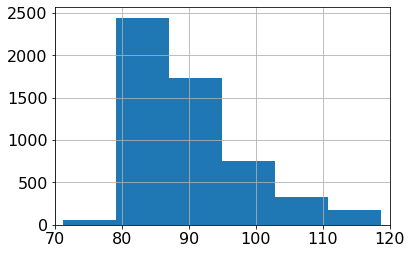

In [ ]:
testing['Target'].hist()
plt.xlim(70,120)
#plt.ylim(0,500)

In [ ]:
print('Validation Well Max. Depth: ', testing['Depth'].max())
print('Test Well Max Depth: ', test['Depth'].max())
print('Validation Well Min. Depth: ', testing['Depth'].min())
print('Test Well Min. Depth: ', test['Depth'].min())

Validation Well Max. Depth:  15292.0
Test Well Max Depth:  11529.0
Validation Well Min. Depth:  12551.0
Test Well Min. Depth:  10797.0


In [ ]:
#testing = testing[(testing['Depth'] >= 10800)]
testing

Depth   SonicC  PorDen  ...       Lat       Lon          well
5402   12551.0  56.5663  0.1552  ...  0.594357  6.228334  1f854180654f
5403   12551.5  55.9639  0.1168  ...  0.594357  6.228334  1f854180654f
5404   12552.0  55.0602  0.0670  ...  0.594357  6.228334  1f854180654f
5405   12552.5  53.8186  0.0652  ...  0.594357  6.228334  1f854180654f
5406   12553.0  52.8514  0.0664  ...  0.594357  6.228334  1f854180654f
...        ...      ...     ...  ...       ...       ...           ...
10880  15290.0  45.5724 -0.0292  ...  0.594357  6.228334  1f854180654f
10881  15290.5  45.8760 -0.0270  ...  0.594357  6.228334  1f854180654f
10882  15291.0  46.1797 -0.0237  ...  0.594357  6.228334  1f854180654f
10883  15291.5  46.4834 -0.0225  ...  0.594357  6.228334  1f854180654f
10884  15292.0  47.4532 -0.0261  ...  0.594357  6.228334  1f854180654f

[5483 rows x 12 columns]

In [ ]:
train.shape

(900354, 12)

In [ ]:
test['Depth'].max()

11529.0

In [ ]:
train['well'].unique()

array(['00a60e5cc262', '02571837c35f', '07bda346ac4d', '09a9e11b83f4',
       '0a65a72dd23f', '0e121cce5c23', '0f7a4609731a', '115b34035794',
       '146b023afbcf', '15560bf61021', '1737d6c90d5e', '1cf78b7ca1cc',
       '1f854180654f', '1f901b2ab8a5', '2009a7f4a0fb', '220f9530a1f8',
       '260af024a4c2', '33a468d6daa8', '3ca90f59eddb', '3e09ee2f5add',
       '4503ff73396f', '45f3c132a607', '47006f90f0a3', '48b950eab493',
       '4950c91e0421', '4b20c1aa62f4', '4bc281e7f645', '4ddffa33d3c3',
       '4e536dc14f41', '4eeb27e8a754', '5595cce476d1', '559e559909d1',
       '56d922368bbb', '5875f91cc9c6', '603a9d4c558d', '64b8d826e247',
       '66f22901d10e', '67006e0af90b', '6c22c24c3e7c', '6cd66f018b76',
       '6e79db80b34b', '70a049901d0c', '714bd04772d7', '72a148eac9f5',
       '74757db27a2a', '77ae830eed77', '7afba96e8dba', '7b5c7cb115b4',
       '7c65e832e5a9', '7e0ff0d533e8', '81047fe11eaa', '81b5071e7b19',
       '845a53b34139', '84967b1f42e0', '84b20f26d4cd', '8a551cb29776',
      

In [ ]:
tempp = train[(train['Lon'] > 5) & (train['Lon'] < 6.5) & (train['Lat'] < 2) & (train['Lat'] > 0) & (train['Depth'] <= 11530) & (train['Depth'] >= 11000)]
tempp['well'].unique()

array([], dtype=object)

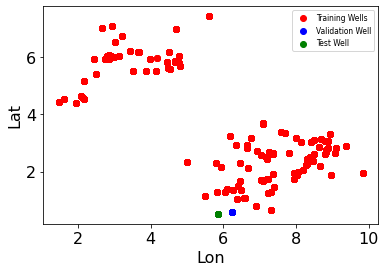

<Figure size 720x1440 with 0 Axes>

In [ ]:
plt.scatter(train.Lon, train.Lat, c='r', label='Training Wells')
plt.scatter(testing.Lon, testing.Lat, c='b', label='Validation Well')
plt.scatter(test.Lon, test.Lat, c='g', label='Test Well')
plt.xlabel('Lon')
plt.ylabel('Lat')
plt.legend()
#plt.xlim(6,8)
#plt.ylim(1,2)
plt.figure(figsize=(10,20))
plt.show()

In [ ]:
train = train[(train['well'] != '4e536dc14f41')]

In [ ]:
train.shape

(882531, 12)

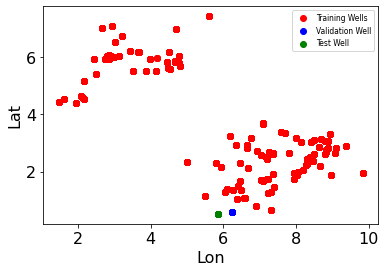

<Figure size 720x1440 with 0 Axes>

In [ ]:
plt.scatter(train.Lon, train.Lat, c='r', label='Training Wells')
plt.scatter(testing.Lon, testing.Lat, c='b', label='Validation Well')
plt.scatter(test.Lon, test.Lat, c='g', label='Test Well')
plt.xlabel('Lon')
plt.ylabel('Lat')
plt.legend()
#plt.xlim(6,8)
#plt.ylim(1,2)
plt.figure(figsize=(10,20))
plt.show()

In [ ]:
train = train[(train['Lat'] < 4)]
#train = train[(train['Lat'] > 5) & (train['Lon'] < 9.5)]

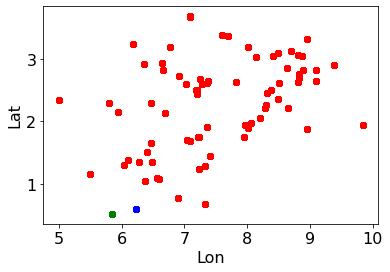

In [ ]:
plt.scatter(train.Lon, train.Lat, c='r', label='Training Wells')
plt.scatter(testing.Lon, testing.Lat, c='b', label='Validation Well')
plt.scatter(test.Lon, test.Lat, c='g', label='Test Well')
plt.ylabel('Lat')
plt.xlabel('Lon')
plt.show()

In [ ]:
testing.head()

Depth   SonicC  PorDen  ...       Lat       Lon          well
5402  12551.0  56.5663  0.1552  ...  0.594357  6.228334  1f854180654f
5403  12551.5  55.9639  0.1168  ...  0.594357  6.228334  1f854180654f
5404  12552.0  55.0602  0.0670  ...  0.594357  6.228334  1f854180654f
5405  12552.5  53.8186  0.0652  ...  0.594357  6.228334  1f854180654f
5406  12553.0  52.8514  0.0664  ...  0.594357  6.228334  1f854180654f

[5 rows x 12 columns]

In [ ]:
testing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5483 entries, 5402 to 10884
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Depth   5483 non-null   float64
 1   SonicC  5483 non-null   float64
 2   PorDen  5483 non-null   float64
 3   PorNeu  5483 non-null   float64
 4   Gamma   5483 non-null   float64
 5   PhotoE  5483 non-null   float64
 6   Cali    5483 non-null   float64
 7   DenCor  5483 non-null   float64
 8   Target  5483 non-null   float64
 9   Lat     5483 non-null   float64
 10  Lon     5483 non-null   float64
 11  well    5483 non-null   object 
dtypes: float64(11), object(1)
memory usage: 556.9+ KB


In [ ]:
testing.describe().transpose()

count          mean  ...           75%           max
Depth   5483.0  13921.500000  ...  14606.750000  15292.000000
SonicC  5483.0     51.695124  ...     55.095950     67.806300
PorDen  5483.0     -0.001052  ...      0.021500      0.290700
PorNeu  5483.0      0.031432  ...      0.029750      0.243700
Gamma   5483.0     42.263014  ...     56.390100    173.429100
PhotoE  5483.0      3.859472  ...      4.574550      6.570500
Cali    5483.0      7.339250  ...      7.391500      9.657900
DenCor  5483.0      0.029033  ...      0.037800      0.407700
Target  5483.0     90.119428  ...     94.311600    118.708400
Lat     5483.0      0.594357  ...      0.594357      0.594357
Lon     5483.0      6.228334  ...      6.228334      6.228334

[11 rows x 8 columns]

In [ ]:
train.describe().transpose()

count         mean  ...          75%           max
Depth   574879.0  6884.874084  ...  8712.000000  17761.000000
SonicC  574879.0    65.105107  ...    73.908650    353.983300
PorDen  574879.0     0.064904  ...     0.111700      1.025100
PorNeu  574879.0     0.115629  ...     0.173100      1.438200
Gamma   574879.0    59.466697  ...    82.563350    621.449100
PhotoE  574879.0     3.492812  ...     3.967100     10.817400
Cali    574879.0     9.811692  ...    10.530050     25.199400
DenCor  574879.0     0.119560  ...     0.015200     31.919600
Target  574879.0   114.358796  ...   126.585400    438.819200
Lat     574879.0     2.207080  ...     2.638548      3.680670
Lon     574879.0     7.575929  ...     8.379994      9.844046

[11 rows x 8 columns]

In [ ]:
train.head()

Depth   SonicC  PorDen  ...       Lat       Lon          well
9140  4978.0  57.0380 -0.0120  ...  1.451129  7.402666  09a9e11b83f4
9141  4978.5  57.6049  0.0180  ...  1.451129  7.402666  09a9e11b83f4
9142  4979.0  58.9624  0.0305  ...  1.451129  7.402666  09a9e11b83f4
9143  4979.5  60.4225  0.0183  ...  1.451129  7.402666  09a9e11b83f4
9144  4980.0  61.3816  0.0115  ...  1.451129  7.402666  09a9e11b83f4

[5 rows x 13 columns]

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 151354 entries, 9140 to 23896
Data columns (total 13 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Depth   151354 non-null  float64
 1   SonicC  151354 non-null  float64
 2   PorDen  151354 non-null  float64
 3   PorNeu  151354 non-null  float64
 4   Gamma   151354 non-null  float64
 5   PhotoE  151354 non-null  float64
 6   Cali    151354 non-null  float64
 7   DenCor  151354 non-null  float64
 8   Tens    151354 non-null  float64
 9   Target  151354 non-null  float64
 10  Lat     151354 non-null  float64
 11  Lon     151354 non-null  float64
 12  well    151354 non-null  object 
dtypes: float64(12), object(1)
memory usage: 16.2+ MB


In [ ]:
# Get a list of columns or features from the training set
column = list(train.columns)
print(len(column))

12


In [ ]:
# Get a list of columns or features from the training set
column = list(train.columns)
print(column)

['Depth', 'SonicC', 'PorDen', 'PorNeu', 'Gamma', 'PhotoE', 'Cali', 'DenCor', 'Target', 'Lat', 'Lon', 'well']


In [ ]:
# Selecting specific columns from the training set and removing ResSH, ResDP, Target and Well
# ResSH and ResDP were removed due to a large radius of investigation and hence low correlation with Target
select_columns = list(column[i] for i in [9, 10, 11])
select_columns

['Lat', 'Lon', 'well']

In [ ]:
# Dropping the selected columns SP, ResSH, ResMD, ResDP and Target from the training data
# and assigning the target into a separate DataFrame for well 2
x_train = train.drop(select_columns, axis=1)
# y_train = train["Target"].values

In [ ]:
x_train.head()

Depth   SonicC  PorDen  PorNeu  ...  PhotoE    Cali  DenCor   Target
10501  5400.5  51.7345 -0.1780  0.0576  ...  6.3222  8.3872 -0.0004  97.2199
10502  5401.0  50.8980 -0.0350  0.0395  ...  4.4748  8.5085 -0.0004  95.9859
10503  5401.5  50.2660 -0.0068  0.0341  ...  4.4749  8.5090 -0.0003  94.7922
10504  5402.0  50.0845  0.0004  0.0329  ...  4.4451  8.5396 -0.0003  94.1404
10505  5402.5  49.9931 -0.0026  0.0347  ...  4.3852  8.5703 -0.0033  92.9669

[5 rows x 9 columns]

## **Preprocessing**

In [ ]:
x_train.columns

Index(['Depth', 'SonicC', 'PorDen', 'PorNeu', 'Gamma', 'PhotoE', 'Cali',
       'DenCor', 'Target'],
      dtype='object')

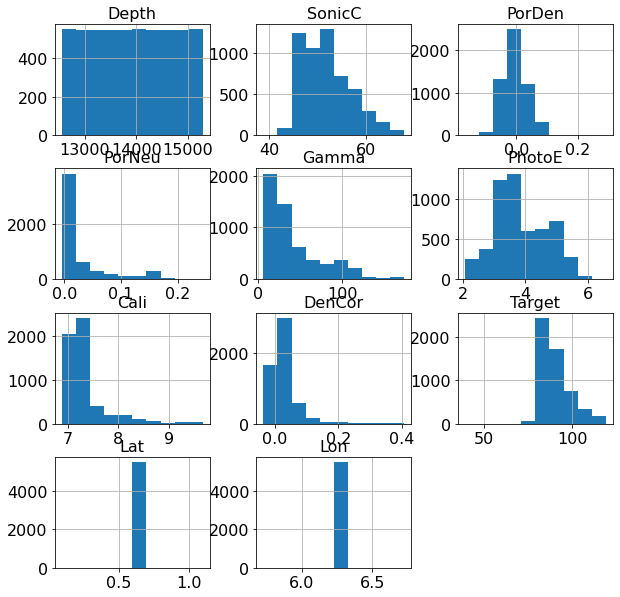

In [ ]:
testing.hist(figsize=(10,10))
plt.show()

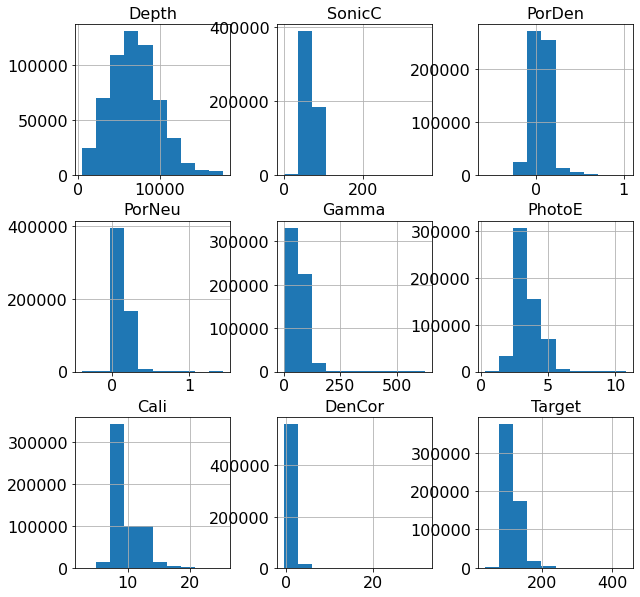

In [ ]:
x_train.hist(figsize=(10,10))
plt.show()

In [ ]:
# Transoform ResXO to logarithmic
x_train['ResXO'] = np.log10(x_train['ResXO'])
x_train.head()

Depth   SonicC     Den  PorDen  ...    Cali  DenCor     ResXO   Target
10501  5400.5  51.7345  2.7323 -0.1780  ...  8.3872 -0.0004 -0.685922  97.2199
10502  5401.0  50.8980  2.7173 -0.0350  ...  8.5085 -0.0004  1.004433  95.9859
10503  5401.5  50.2660  2.7252 -0.0068  ...  8.5090 -0.0003  1.844553  94.7922
10504  5402.0  50.0845  2.7370  0.0004  ...  8.5396 -0.0003  2.379299  94.1404
10505  5402.5  49.9931  2.7487 -0.0026  ...  8.5703 -0.0033  2.401629  92.9669

[5 rows x 11 columns]

NameError: ignored

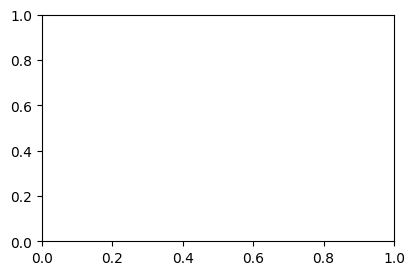

In [ ]:
font = {'size'   : 10}
plt.rc('font', **font)

fig = plt.subplots(figsize=(10, 3), dpi= 100, facecolor='w', edgecolor='k')

ax1=plt.subplot(1,2,1)
test['SonicC'].hist(bins=15)
plt.title("Test Well")
plt.ylabel("Frequency")
plt.xlim(40,120)
#plt.ylim(0,2000)

ax2=plt.subplot(1,2,2) 
testing['Target'].hist(bins=15)
plt.title("Validation")
plt.ylabel("Frequency")
plt.xlim(40,120)
plt.show()

### Standardization

In [ ]:
testing.columns

Index(['Depth', 'SonicC', 'PorDen', 'PorNeu', 'Gamma', 'PhotoE', 'Cali',
       'DenCor', 'Target', 'Lat', 'Lon', 'well'],
      dtype='object')

In [ ]:
x_train.columns

Index(['Depth', 'SonicC', 'PorDen', 'PorNeu', 'Gamma', 'PhotoE', 'Cali',
       'DenCor', 'Target'],
      dtype='object')

In [ ]:
# Copy data to avoid altering the original x_train data
scaled_features = x_train.drop(labels='Target', axis=1)
y_train = x_train['Target'].values

# Move the Depth column to the last
scaled_features = scaled_features[['Depth', 'SonicC', 'PorDen', 'PorNeu', 'Gamma', 'PhotoE', 'Cali',
       'DenCor']]

col_names = scaled_features.columns

std_features = ['Depth', 'SonicC', 'PorDen', 'PorNeu', 'Gamma', 'PhotoE', 'Cali',
       'DenCor']
scaled_features

Depth   SonicC  PorDen  PorNeu    Gamma  PhotoE    Cali  DenCor
10501  5400.5  51.7345 -0.1780  0.0576  38.9797  6.3222  8.3872 -0.0004
10502  5401.0  50.8980 -0.0350  0.0395  37.7184  4.4748  8.5085 -0.0004
10503  5401.5  50.2660 -0.0068  0.0341  35.5535  4.4749  8.5090 -0.0003
10504  5402.0  50.0845  0.0004  0.0329  33.5090  4.4451  8.5396 -0.0003
10505  5402.5  49.9931 -0.0026  0.0347  32.5489  4.3852  8.5703 -0.0033
...       ...      ...     ...     ...      ...     ...     ...     ...
16571  8409.5  66.1534  0.0459  0.0619  87.8950  2.5230  8.6633  0.0012
16572  8410.0  66.1619  0.0545  0.0618  89.2712  2.5185  8.6632  0.0008
16573  8410.5  65.5405  0.0591  0.0618  87.6721  2.5187  8.6632  0.0004
16574  8411.0  64.9190  0.0591  0.0554  85.1638  2.5190  8.6632  0.0001
16575  8411.5  64.2370  0.0591  0.0521  82.6556  2.5192  8.6631 -0.0003

[574879 rows x 8 columns]

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

# Standardize all the columns except 'Depth'
# Standardization using StandardScaler
scaler = StandardScaler()

## ColumnTransformer
ct = ColumnTransformer([('standardize', scaler, std_features)], remainder='passthrough')

## fit and transform
well_train_norm = ct.fit_transform(scaled_features)

## convert to dataframe
x_train_std = pd.DataFrame(well_train_norm, columns=col_names)
x_train_std

Depth    SonicC    PorDen  ...    PhotoE      Cali    DenCor
0      -0.504935 -0.938496 -2.447732  ...  3.223166 -0.702254 -0.172147
1      -0.504765 -0.997211 -1.006730  ...  1.118656 -0.642454 -0.172147
2      -0.504594 -1.041572 -0.722561  ...  1.118770 -0.642208 -0.172004
3      -0.504424 -1.054311 -0.650007  ...  1.084822 -0.627123 -0.172004
4      -0.504254 -1.060727 -0.680238  ...  1.016586 -0.611988 -0.176309
...          ...       ...       ...  ...       ...       ...       ...
574874  0.518627  0.073581 -0.191506  ... -1.104784 -0.566140 -0.169851
574875  0.518797  0.074177 -0.104845  ... -1.109911 -0.566190 -0.170425
574876  0.518967  0.030561 -0.058491  ... -1.109683 -0.566190 -0.170999
574877  0.519137 -0.013063 -0.058491  ... -1.109341 -0.566190 -0.171430
574878  0.519307 -0.060933 -0.058491  ... -1.109113 -0.566239 -0.172004

[574879 rows x 8 columns]

In [ ]:
y_train

array([ 97.2199,  95.9859,  94.7922, ..., 104.515 , 104.4782, 104.0908])

In [ ]:
x_train_std = x_train_std.values

In [ ]:
x_train_std

array([[-0.5049346 , -0.93849608, -2.44773176, ...,  3.22316584,
        -0.70225356, -0.17214731],
       [-0.50476452, -0.99721083, -1.00673017, ...,  1.11865561,
        -0.64245445, -0.17214731],
       [-0.50459444, -1.04157154, -0.72256063, ...,  1.11876952,
        -0.64220796, -0.17200381],
       ...,
       [ 0.5189671 ,  0.03056065, -0.05849067, ..., -1.10968285,
        -0.56618963, -0.17099928],
       [ 0.51913719, -0.01306305, -0.05849067, ..., -1.1093411 ,
        -0.56618963, -0.17142979],
       [ 0.51930727, -0.0609333 , -0.05849067, ..., -1.10911327,
        -0.56623893, -0.17200381]])

## 1. Linear Regression

### Testing

In [ ]:
testing.head()

Depth   SonicC  PorDen  ...       Lat       Lon          well
5402  12551.0  56.5663  0.1552  ...  0.594357  6.228334  1f854180654f
5403  12551.5  55.9639  0.1168  ...  0.594357  6.228334  1f854180654f
5404  12552.0  55.0602  0.0670  ...  0.594357  6.228334  1f854180654f
5405  12552.5  53.8186  0.0652  ...  0.594357  6.228334  1f854180654f
5406  12553.0  52.8514  0.0664  ...  0.594357  6.228334  1f854180654f

[5 rows x 12 columns]

In [ ]:
# Get a list of columns or features from the training set
column = list(testing.columns)
print(column)

['Depth', 'SonicC', 'PorDen', 'PorNeu', 'Gamma', 'PhotoE', 'Cali', 'DenCor', 'Target', 'Lat', 'Lon', 'well']


In [ ]:
# Selecting specific columns from the training set and removing ResSH, ResDP, Target and Well
# ResSH and ResDP were removed due to a large radius of investigation and hence low correlation with Target
select_columns = list(column[i] for i in [8, 9, 10, 11])
select_columns

['Target', 'Lat', 'Lon', 'well']

In [ ]:
# Dropping the selected columns SP, ResSH, ResMD, ResDP and Target from the training data
# and assigning the target into a separate DataFrame for well 2
x_testing = testing.drop(select_columns, axis=1)
y_testing = testing["Target"].values

In [ ]:
x_testing.head()

Depth   SonicC  PorDen  PorNeu    Gamma  PhotoE    Cali  DenCor
5402  12551.0  56.5663  0.1552  0.0211  12.3457  2.9937  7.2826 -0.0365
5403  12551.5  55.9639  0.1168  0.0079  13.8889  2.3634  7.3119 -0.0094
5404  12552.0  55.0602  0.0670  0.0043  16.5895  2.3927  7.3113  0.0345
5405  12552.5  53.8186  0.0652  0.0031  18.1327  2.4222  7.3109  0.0418
5406  12553.0  52.8514  0.0664  0.0025  20.4475  2.4814  7.2805  0.0291

In [ ]:
x_train.head()

Depth   SonicC  PorDen  PorNeu  ...  PhotoE    Cali  DenCor   Target
10501  5400.5  51.7345 -0.1780  0.0576  ...  6.3222  8.3872 -0.0004  97.2199
10502  5401.0  50.8980 -0.0350  0.0395  ...  4.4748  8.5085 -0.0004  95.9859
10503  5401.5  50.2660 -0.0068  0.0341  ...  4.4749  8.5090 -0.0003  94.7922
10504  5402.0  50.0845  0.0004  0.0329  ...  4.4451  8.5396 -0.0003  94.1404
10505  5402.5  49.9931 -0.0026  0.0347  ...  4.3852  8.5703 -0.0033  92.9669

[5 rows x 9 columns]

In [ ]:
y_testing

array([87.4593, 84.3752, 82.1199, ..., 80.6687, 80.3676, 80.0665])

In [ ]:
# Transoform ResXO to logarithmic
x_testing['ResXO'] = np.log10(x_testing['ResXO'])
x_testing.head()

Depth   SonicC     Den  PorDen  ...  PhotoE     Cali  DenCor     ResXO
1842  951.0  89.9421  2.3468  0.3001  ...  4.4567   9.4370  0.1047 -0.688882
1843  951.5  88.9900  2.3672  0.2995  ...  4.4136  10.8299  0.1006 -0.481354
1844  952.0  87.7790  2.4078  0.2389  ...  4.3705  10.4708  0.0939 -0.254223
1845  952.5  87.3959  2.4598  0.1880  ...  4.2888   9.6270  0.0622  0.147243
1846  953.0  86.9796  2.4965  0.1393  ...  4.1752   9.3149  0.0266  1.123136

[5 rows x 10 columns]

In [ ]:
## Transform
x_testing = ct.transform(x_testing)
x_testing # Display the data

array([[ 1.92742724, -0.59934728,  0.90990271, ..., -0.56857516,
        -1.24680508, -0.22395205],
       [ 1.92759732, -0.64163033,  0.52294844, ..., -1.28659659,
        -1.23236061, -0.18506262],
       [ 1.92776741, -0.70506192,  0.02111711, ..., -1.25321879,
        -1.2326564 , -0.12206461],
       ...,
       [ 2.85948394, -1.32839295, -0.89286082, ..., -1.02059944,
        -1.38686219, -0.08174014],
       [ 2.85965403, -1.30707595, -0.8807685 , ..., -0.95145157,
        -1.38720728, -0.08260116],
       [ 2.85982411, -1.23900474, -0.91704546, ..., -0.66825289,
        -1.38760167, -0.08059212]])

In [ ]:
# Apply a simple Linear Regression model
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(x_train_std, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
# Get the mean of RMSE for all RMSE from 5-fold cross-validation
from sklearn.model_selection import cross_val_score
np.random.seed(32)

scores = cross_val_score(lin_reg, x_train_std, y_train, scoring="neg_mean_squared_error", cv=5)
lin_reg_acc = np.mean(np.sqrt(-scores))
lin_reg_acc

15.068838120389483

## 2. ANN

In [ ]:
def plot_NN(model,history,x_train,y_train):
    """ Plot training loss versus validation loss and 
    training accuracy versus validation accuracy"""
    
    font = {'size'   : 7.5}
    plt.rc('font', **font)
    fig, ax=plt.subplots(figsize=(7, 5), dpi= 200, facecolor='w', edgecolor='k')
    
    ax1 = plt.subplot(2,2,1)    
    history_dict = history.history
    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    epochs = range(1, len(loss_values) + 1)
    ax1.plot(epochs, loss_values, 'bo',markersize=4, label='Training loss')          
    ax1.plot(epochs, val_loss_values, 'r-', label='Validation loss')    
    plt.title('Training and validation loss',fontsize=11)
    plt.xlabel('Epochs (Early Stopping)',fontsize=9)
    plt.ylabel('Loss',fontsize=10)
    plt.legend(fontsize='8.5')
    plt.ylim((0, 100))
    
    ax2 = plt.subplot(2,2,2)
    pred=model.predict(x_train)
    t = pd.DataFrame({'pred': pred.flatten(), 'y': y_train.flatten()})
    t.sort_values(by=['y'], inplace=True)    

    epochs = range(1, len(loss_values) + 1)        
    ax2.plot(t['pred'].tolist(), 'g', label='Prediction')    
    ax2.plot(t['y'].tolist(), 'm--o',markersize=2, label='Expected')      
    plt.title('Prediction vs Expected for Training',fontsize=11)
    plt.xlabel('Data',fontsize=9)
    plt.ylabel('Output',fontsize=10)
    plt.legend(fontsize='8.5')    
    fig.tight_layout(w_pad=1.42)
    plt.show()

In [ ]:
def DNN (input_dim,neurons=50,loss="mse",activation="relu",Nout=1,L2_regularizer=False,
             metrics=None,activation_out=None,init_mode=None,BatchOpt=False,dropout_rate=False):
    """ Function to run Deep Neural Network (5 hidden layer) for different hyperparameters"""
    np.random.seed(42)
    tf.random.set_seed(42)
    
    keras.backend.clear_session() # Clear the previous model
    
    if(activation=='Leaky_relu'): activation = keras.layers.LeakyReLU(alpha=0.2)
    if(L2_regularizer): kernel_regularizer=keras.regularizers.l2() 
    else: kernel_regularizer=None
        
    # create model
    model = keras.models.Sequential()
    
    # Input & Hidden Layer 1
    model.add(keras.layers.Dense(neurons,input_dim=input_dim, activation=activation, 
                                 kernel_initializer=init_mode,kernel_regularizer=kernel_regularizer))
    if(BatchOpt): model.add(keras.layers.BatchNormalization())
    if(dropout_rate):  model.add(keras.layers.Dropout(dropout_rate))
        
    # Hidden Layer 2
    model.add(keras.layers.Dense(neurons,activation=activation,
                                 kernel_initializer=init_mode,kernel_regularizer=kernel_regularizer))
    if(BatchOpt): model.add(keras.layers.BatchNormalization())
    if(dropout_rate):  model.add(keras.layers.Dropout(dropout_rate))

    # Hidden Layer 3
    model.add(keras.layers.Dense(neurons,activation=activation,
                                 kernel_initializer=init_mode,kernel_regularizer=kernel_regularizer))
    if(BatchOpt): model.add(keras.layers.BatchNormalization())
    if(dropout_rate):  model.add(keras.layers.Dropout(dropout_rate))

    # Hidden Layer 4
    model.add(keras.layers.Dense(neurons,activation=activation,
                                 kernel_initializer=init_mode,kernel_regularizer=kernel_regularizer))
    if(BatchOpt): model.add(keras.layers.BatchNormalization())
    if(dropout_rate):  model.add(keras.layers.Dropout(dropout_rate))

    # Hidden Layer 5
    model.add(keras.layers.Dense(neurons,activation=activation,
                                 kernel_initializer=init_mode,kernel_regularizer=kernel_regularizer))
    if(BatchOpt): model.add(keras.layers.BatchNormalization())
    if(dropout_rate):  model.add(keras.layers.Dropout(dropout_rate))

    # Output Layer 
    model.add(keras.layers.Dense(Nout,activation=activation_out)) 
        
    # Compile model
    model.compile(optimizer='adam',loss=loss,metrics=metrics)
    return model

In [ ]:
x_train_std.shape

(574879, 8)

In [ ]:
import tensorflow as tf
from tensorflow import keras

model_DNN = DNN (input_dim=x_train_std.shape[1], neurons=450, Nout=1, L2_regularizer=False,
                 init_mode=None , dropout_rate=None, activation='relu', metrics=None,
                 activation_out=None, loss='mse')

# Early stopping to avoid overfitting
monitor= keras.callbacks.EarlyStopping(min_delta=1e-3,patience=3)
history=model_DNN.fit(x_train_std,y_train,batch_size=32,validation_data=
          (x_testing,y_testing),callbacks=[monitor],verbose=1,epochs=1000) 

Epoch 1/1000
17965/17965 [==============================] - 37s 2ms/step - loss: 224.8732 - val_loss: 14.7406
Epoch 2/1000
17965/17965 [==============================] - 37s 2ms/step - loss: 92.5835 - val_loss: 42.4201
Epoch 3/1000
17965/17965 [==============================] - 36s 2ms/step - loss: 85.2749 - val_loss: 12.8275
Epoch 4/1000
17965/17965 [==============================] - 36s 2ms/step - loss: 82.1383 - val_loss: 13.4875
Epoch 5/1000
17965/17965 [==============================] - 36s 2ms/step - loss: 79.9412 - val_loss: 8.0560
Epoch 6/1000
17965/17965 [==============================] - 36s 2ms/step - loss: 77.8759 - val_loss: 8.3813
Epoch 7/1000
17965/17965 [==============================] - 36s 2ms/step - loss: 75.5902 - val_loss: 8.3846
Epoch 8/1000
17965/17965 [==============================] - 37s 2ms/step - loss: 73.0608 - val_loss: 8.8121


In [ ]:
from sklearn.metrics import mean_squared_error
pred = model_DNN.predict(x_train_std)
mse = mean_squared_error(pred, y_train)
rmse = np.sqrt(mse)

print('rmse of all training: ',rmse)

rmse of all training:  8.66266976412564


In [ ]:
from sklearn.metrics import mean_squared_error
pred_testing = model_DNN.predict(x_testing)
mse_testing = mean_squared_error(pred_testing, y_testing)
rmse_testing = np.sqrt(mse_testing)

print('rmse of all validation: ',rmse_testing)

rmse of all validation:  2.9685147395335427


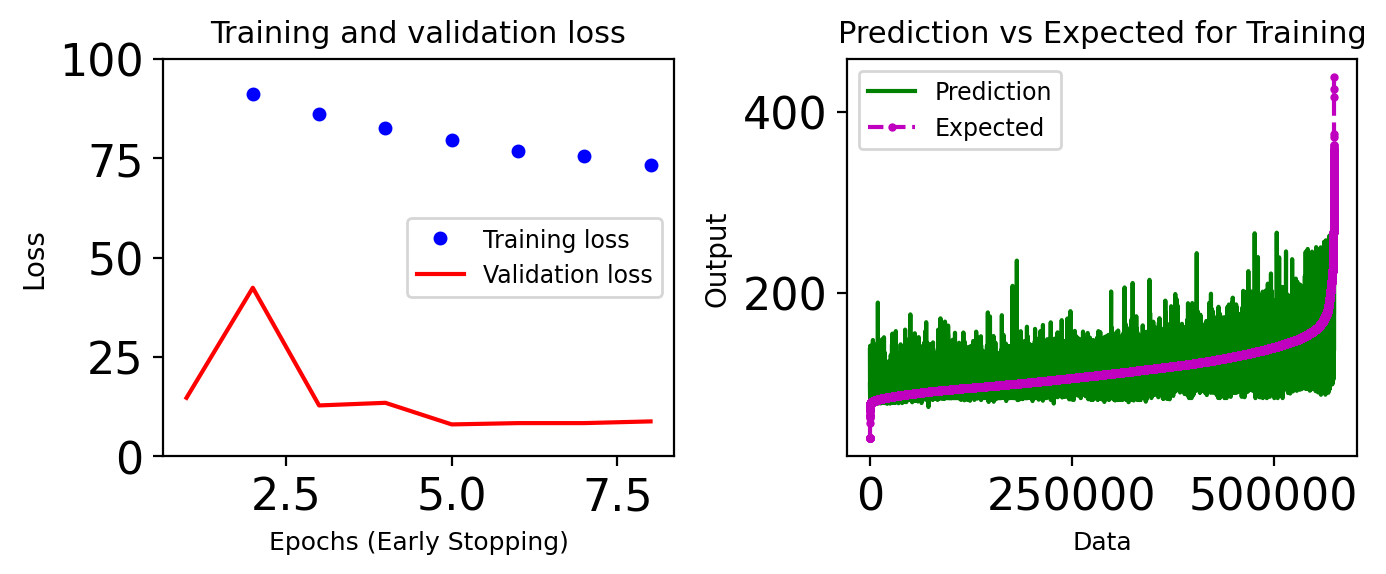

In [ ]:
plot_NN(model_DNN,history,x_train_std,y_train)

In [ ]:
from sklearn.metrics import mean_squared_error
pred_testing = model_DNN.predict(x_testing)
mse_testing = mean_squared_error(pred_testing, y_testing)
rmse_testing = np.sqrt(mse_testing)

print('rmse of all validation: ',rmse_testing)

rmse of all validation:  2.9685147395335427


In [ ]:
pred_test_well = model_DNN.predict(x_testing)
pred_test_well[0:20]

array([[88.63939 ],
       [82.132355],
       [81.55798 ],
       [80.13201 ],
       [78.630585],
       [78.05035 ],
       [78.20441 ],
       [78.451195],
       [79.26811 ],
       [80.27671 ],
       [80.856964],
       [82.23624 ],
       [83.31171 ],
       [82.99756 ],
       [81.62033 ],
       [80.716934],
       [79.96732 ],
       [80.6576  ],
       [80.867   ],
       [81.031204]], dtype=float32)

In [ ]:
# Convert training set back into a DataFrame and check info. to verify data has been imputed
pred_test = pd.DataFrame(pred_test_well, columns=['Prediction'], index=None)
pred_test.head()

Prediction
0   88.639389
1   82.132355
2   81.557983
3   80.132011
4   78.630585

In [ ]:
pred_test.to_csv('validation_well5.csv', index_label=False)
!cp validation_well5.csv "drive/My Drive/Colab Notebooks"

## Validation Checks

In [ ]:
# Test Well
df1 = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/well_fca03aa6acde_final.xlsx')
df2 = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/well_fca03aa6acde_final_2.xlsx')

# Validation Well
df3 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/validation_well4.csv')
df4 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/validation_well5.csv')

In [ ]:
well = test_wells2['fca03aa6acde']
well

Depth   SonicC     Den  ...       ResDP       Lat       Lon
0     10797.0  56.8127  2.7009  ...     22.8253  0.519331  5.855024
1     10797.5  57.0313  2.7088  ...     22.5314  0.519331  5.855024
2     10798.0  57.0372  2.7212  ...     22.2413  0.519331  5.855024
3     10798.5  57.0430  2.7301  ...     21.9549  0.519331  5.855024
4     10799.0  57.0488  2.7236  ...     21.6722  0.519331  5.855024
...       ...      ...     ...  ...         ...       ...       ...
1460  11527.0  52.7585  2.6803  ...   6641.4297  0.519331  5.855024
1461  11527.5  53.2061  2.6730  ...  12856.5000  0.519331  5.855024
1462  11528.0  53.6432  2.6654  ...  19529.4473  0.519331  5.855024
1463  11528.5  53.4123  2.6568  ...  15009.6191  0.519331  5.855024
1464  11529.0  52.6210  2.6522  ...   5134.9136  0.519331  5.855024

[1465 rows x 14 columns]

In [ ]:
df2.head()

Unnamed: 0    Depth       DTSM
0           0  10797.0  99.940819
1           1  10797.5  99.724747
2           2  10798.0  99.089386
3           3  10798.5  99.137428
4           4  10799.0  99.427902

In [ ]:
df2 = df2.drop('Unnamed: 0', axis=1)
df2

Depth       DTSM
0     10797.0  99.940819
1     10797.5  99.724747
2     10798.0  99.089386
3     10798.5  99.137428
4     10799.0  99.427902
...       ...        ...
1460  11527.0  87.039703
1461  11527.5  86.086929
1462  11528.0  85.443054
1463  11528.5  85.197731
1464  11529.0  85.142632

[1465 rows x 2 columns]

In [ ]:
df.head()

Depth        DTSM
0  10797.0  101.164230
1  10797.5  101.828255
2  10798.0  101.896378
3  10798.5  102.492134
4  10799.0  102.676903

In [ ]:
df3.columns = ['Depth', 'DTSM']

In [ ]:
df2.head()

Prediction
0   144.59825
1   149.92151
2   155.62766
3   158.59134
4   158.20511

In [ ]:
df2.to_excel('well_fca03aa6acde.xlsx', index=False)
!cp well_fca03aa6acde.xlsx "drive/My Drive/Colab Notebooks"

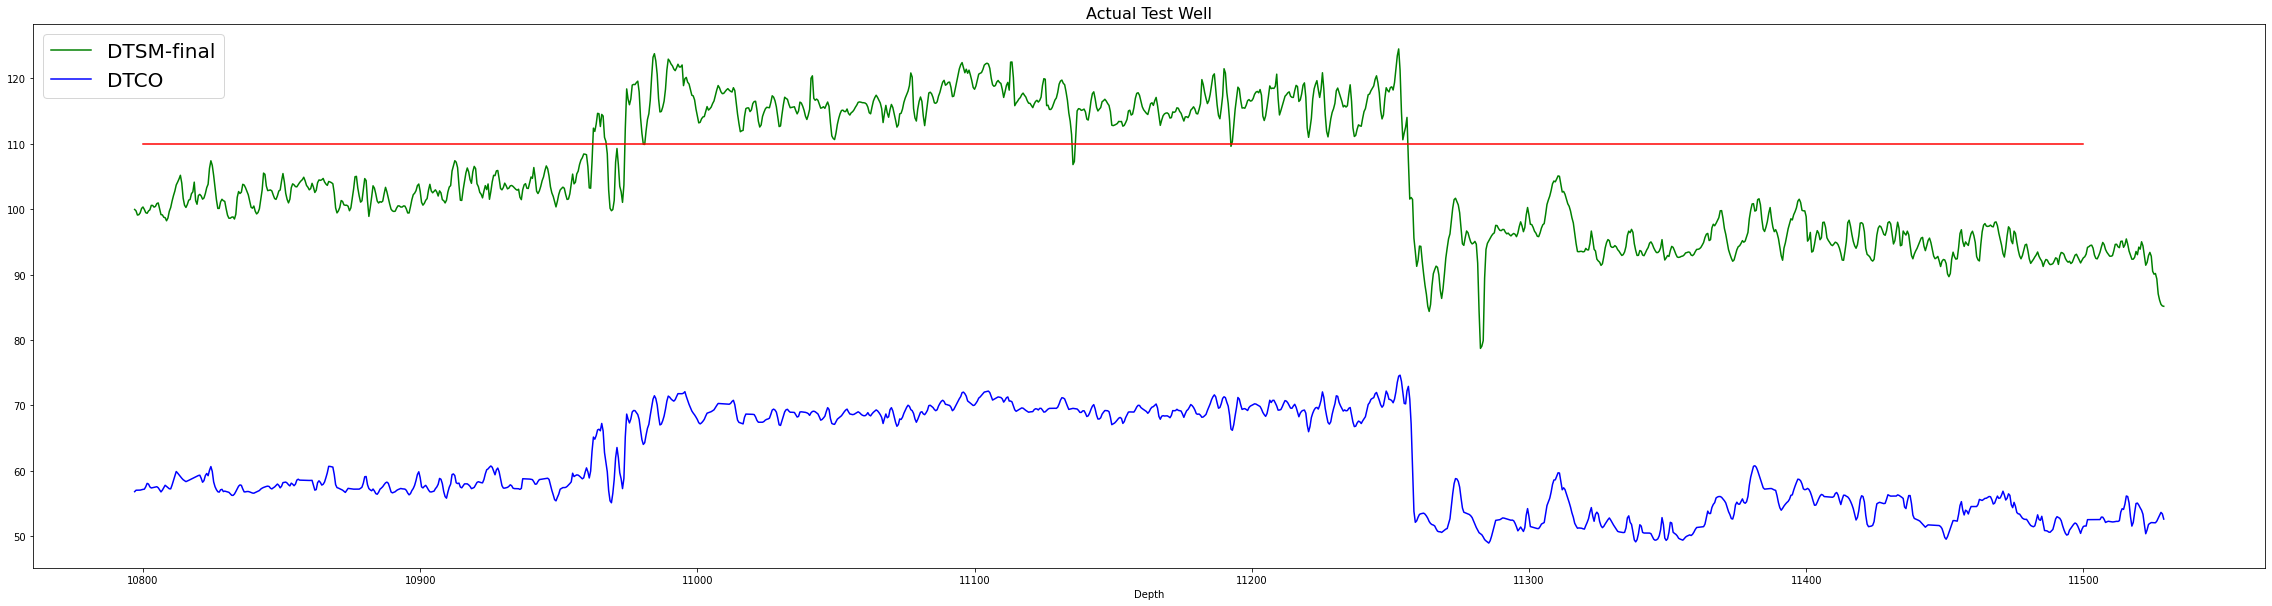

In [ ]:
plt.figure(figsize=(40,10))
plt.plot(df2['Depth'], df2['DTSM'], c='g', label='DTSM-final')
plt.plot(well['Depth'], well['SonicC'], c='b', label='DTCO')
plt.plot((10800,11500),(110,110), c='r')

params = {'axes.labelsize': 16,
          'axes.titlesize': 16,
          'xtick.labelsize': 16,
          'ytick.labelsize': 16}
plt.rcParams.update(params)

plt.xlabel('Depth')
plt.title('Actual Test Well')
plt.legend(loc=2, prop={'size': 20})

plt.show()

In [ ]:
print(df3.shape)
print(df4.shape)
print(df1.shape)
print(df2.shape)
print(testing.shape)

(17823, 1)
(5483, 1)
(1465, 3)
(1465, 3)
(5484, 12)


ValueError: ignored

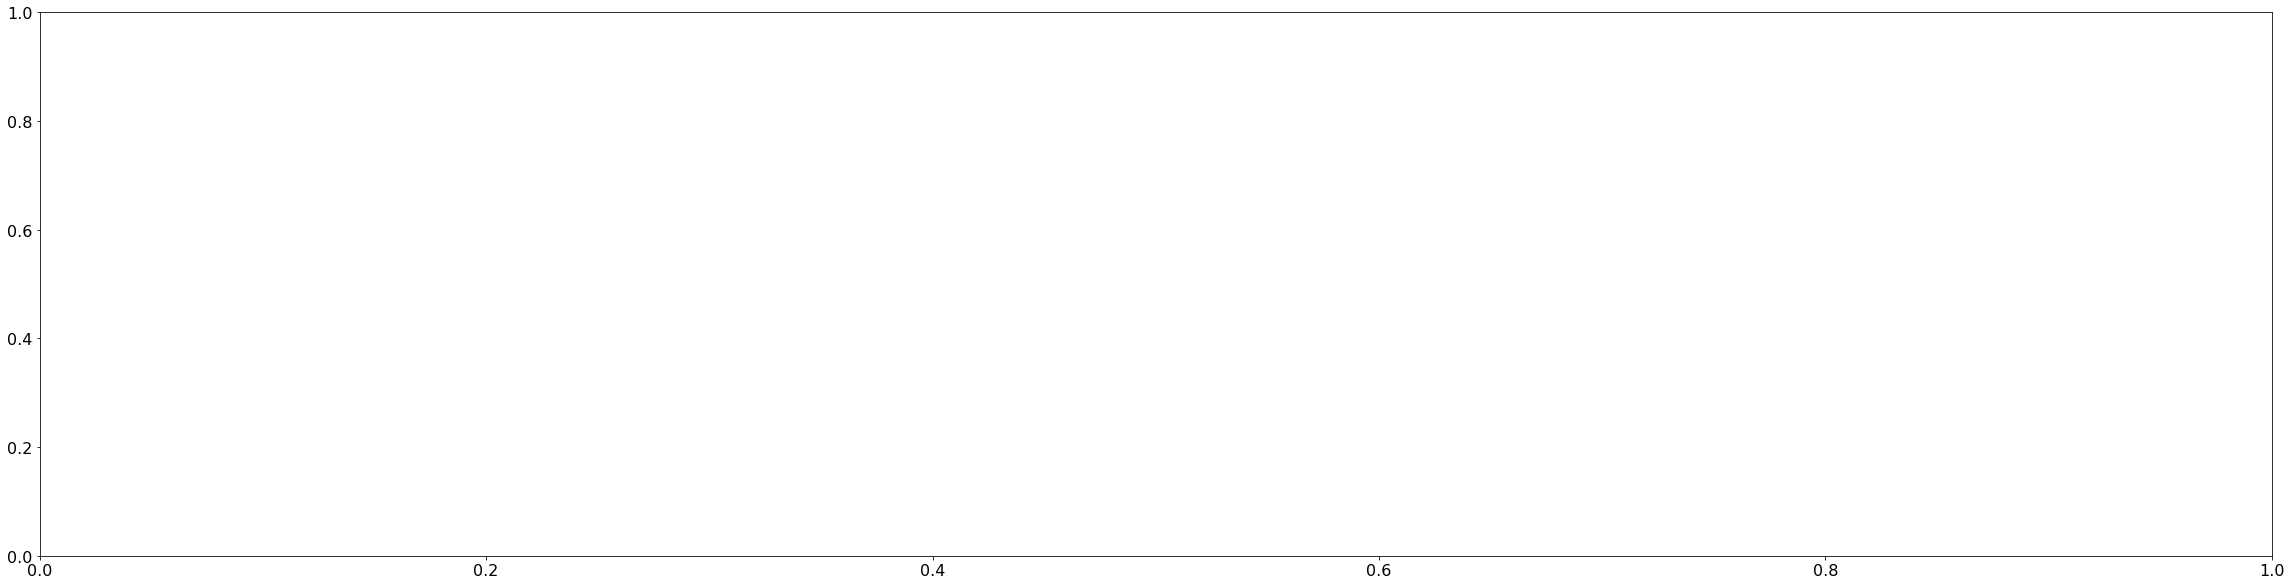

In [ ]:
plt.figure(figsize=(40,10))

plt.plot(testing['Depth'], df4['Prediction'], c='g', label='DTSM')
plt.plot(testing['Depth'], testing['SonicC'], c='b', label='DTCO')

params = {'axes.labelsize': 16,
          'axes.titlesize': 16,
          'xtick.labelsize': 16,
          'ytick.labelsize': 16}
plt.rcParams.update(params)

plt.xlabel('Depth')
plt.title('Validation Well', fontdict={'size': 30})
plt.legend(loc=2, prop={'size': 20})


plt.show()

In [ ]:
testing.columns

Index(['Depth', 'SonicC', 'Den', 'PorDen', 'PorNeu', 'Gamma', 'PhotoE', 'Cali',
       'DenCor', 'ResXO', 'Target', 'Lat', 'Lon', 'well'],
      dtype='object')

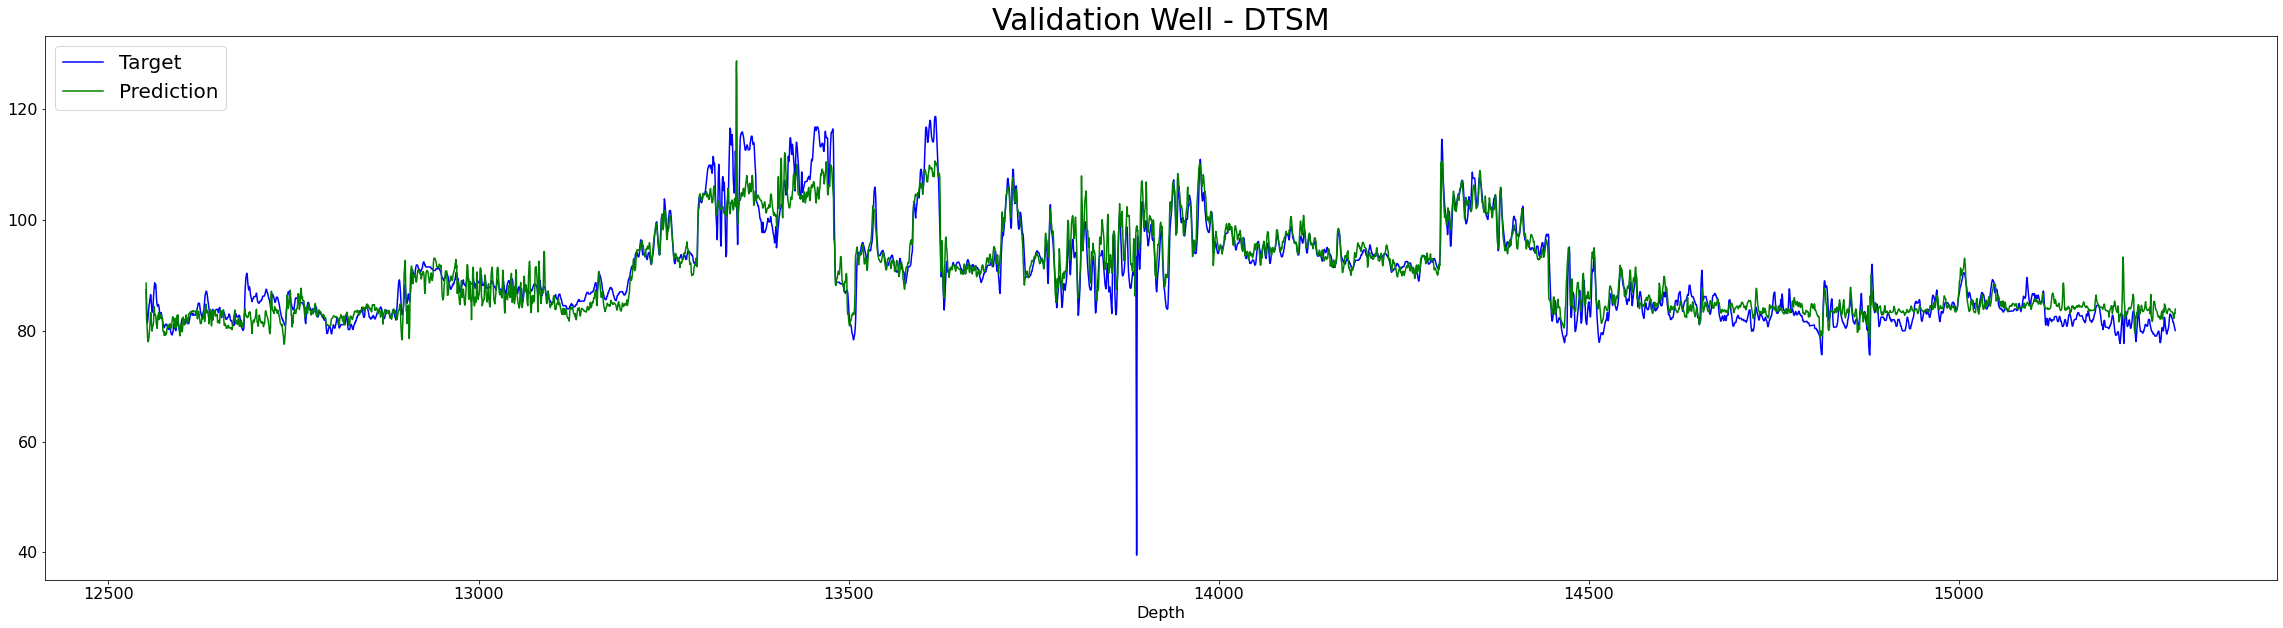

In [ ]:
plt.figure(figsize=(40,10))
plt.plot(testing['Depth'], testing['Target'], c='b', label='Target')
plt.plot(testing['Depth'], df4['Prediction'], c='g', label='Prediction')

params = {'axes.labelsize': 16,
          'axes.titlesize': 16,
          'xtick.labelsize': 16,
          'ytick.labelsize': 16}
plt.rcParams.update(params)

plt.xlabel('Depth')
plt.legend(loc=2, prop={'size': 20})
plt.title('Validation Well - DTSM', fontdict={'size': 30})

plt.show()

In [ ]:
testing['Target'].shape

(5483,)

In [ ]:
df4['Prediction'].shape

(5483,)

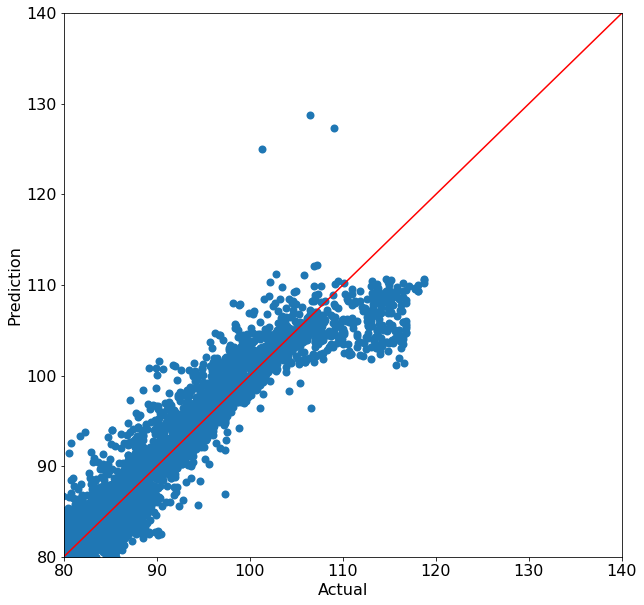

In [ ]:
plt.figure(figsize=(10,10))
plt.scatter((testing.Target), (df4.Prediction), linewidths=2)
plt.plot([80, 200], [80, 200], color = 'red')
plt.xlim(80,140)
plt.ylim(80,140)
plt.xlabel('Actual')
plt.ylabel('Prediction')
plt.show()

## Prediction - fca03aa6acde

In [ ]:
x_test = test_wells2['fca03aa6acde']
x_test.head()

Depth   SonicC     Den  PorDen  ...    ResSH    ResDP       Lat       Lon
0  10797.0  56.8127  2.7009  0.0066  ...  22.5343  22.8253  0.519331  5.855024
1  10797.5  57.0313  2.7088  0.0015  ...  22.2441  22.5314  0.519331  5.855024
2  10798.0  57.0372  2.7212 -0.0071  ...  21.9577  22.2413  0.519331  5.855024
3  10798.5  57.0430  2.7301 -0.0115  ...  21.6749  21.9549  0.519331  5.855024
4  10799.0  57.0488  2.7236 -0.0078  ...  21.4028  21.6722  0.519331  5.855024

[5 rows x 14 columns]

In [ ]:
# Get a list of columns or features from the training set
column = list(x_test.columns)
print(column)

['Depth', 'SonicC', 'Den', 'PorDen', 'PorNeu', 'Gamma', 'PhotoE', 'Cali', 'DenCor', 'ResXO', 'ResSH', 'ResDP', 'Lat', 'Lon']


In [ ]:
x_train.columns

Index(['Depth', 'SonicC', 'PorDen', 'PorNeu', 'Gamma', 'PhotoE', 'Cali',
       'DenCor', 'Target'],
      dtype='object')

In [ ]:
# Selecting specific columns from the training set and removing ResSH, ResDP, Target and Well
# ResSH and ResDP were removed due to a large radius of investigation and hence low correlation with Target
select_columns = list(column[i] for i in [2, 9, 10, 11, 12, 13])
select_columns

['Den', 'ResXO', 'ResSH', 'ResDP', 'Lat', 'Lon']

In [ ]:
# Dropping the selected columns SP, ResSH, ResMD, ResDP and Target from the training data
# and assigning the target into a separate DataFrame for well 2
x_test = x_test.drop(select_columns, axis=1)
x_test.head(100)

Depth   SonicC  PorDen  PorNeu     Gamma  PhotoE    Cali  DenCor
0   10797.0  56.8127  0.0066  0.1370  110.0855  3.3119  9.1937 -0.0130
1   10797.5  57.0313  0.0015  0.1435  109.1869  3.2848  9.1928 -0.0147
2   10798.0  57.0372 -0.0071  0.1494  109.4369  3.2546  9.1919 -0.0145
3   10798.5  57.0430 -0.0115  0.1534  110.3845  3.2233  9.1910 -0.0131
4   10799.0  57.0488 -0.0078  0.1533  114.1460  3.1831  9.1901 -0.0145
..      ...      ...     ...     ...       ...     ...     ...     ...
95  10844.5  57.6087  0.0166  0.1501  113.6601  3.5849  9.5495 -0.0220
96  10845.0  57.6527  0.0151  0.1483  114.1177  3.5081  9.5419 -0.0203
97  10845.5  57.6025  0.0134  0.1470  111.7842  3.4687  9.5424 -0.0183
98  10846.0  57.3387  0.0103  0.1458  108.6457  3.4585  9.5429 -0.0170
99  10846.5  57.2327  0.0065  0.1459  106.3378  3.4350  9.5435 -0.0157

[100 rows x 8 columns]

In [ ]:
x_test.shape

(1465, 8)

In [ ]:
x_test.isna().sum()

Depth     0
SonicC    0
PorDen    0
PorNeu    0
Gamma     0
PhotoE    0
Cali      0
DenCor    0
dtype: int64

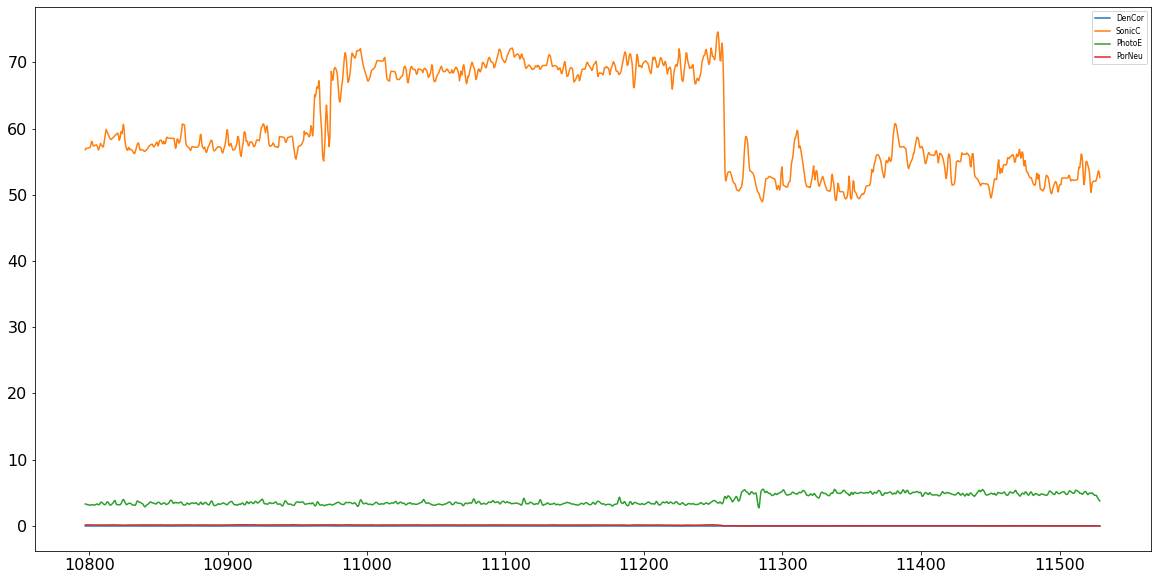

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(x_test['Depth'], x_test['DenCor'], label='DenCor')
plt.plot(x_test['Depth'], x_test['SonicC'], label='SonicC')
plt.plot(x_test['Depth'], x_test['PhotoE'], label='PhotoE')
plt.plot(x_test['Depth'], x_test['PorNeu'], label='PorNeu')


plt.legend()
plt.show()

In [ ]:
x_test.head()

Depth   SonicC  PorDen  PorNeu     Gamma  PhotoE    Cali  DenCor
0  10797.0  56.8127  0.0066  0.1370  110.0855  3.3119  9.1937 -0.0130
1  10797.5  57.0313  0.0015  0.1435  109.1869  3.2848  9.1928 -0.0147
2  10798.0  57.0372 -0.0071  0.1494  109.4369  3.2546  9.1919 -0.0145
3  10798.5  57.0430 -0.0115  0.1534  110.3845  3.2233  9.1910 -0.0131
4  10799.0  57.0488 -0.0078  0.1533  114.1460  3.1831  9.1901 -0.0145

In [ ]:
# Transoform ResXO to logarithmic
x_test['ResXO'] = np.log10(x_test['ResXO'])
x_test.head()

Depth   SonicC     Den  PorDen  ...  PhotoE    Cali  DenCor     ResXO
0  10797.0  56.8127  2.7009  0.0066  ...  3.3119  9.1937 -0.0130  1.372702
1  10797.5  57.0313  2.7088  0.0015  ...  3.2848  9.1928 -0.0147  1.298903
2  10798.0  57.0372  2.7212 -0.0071  ...  3.2546  9.1919 -0.0145  1.391142
3  10798.5  57.0430  2.7301 -0.0115  ...  3.2233  9.1910 -0.0131  1.279646
4  10799.0  57.0488  2.7236 -0.0078  ...  3.1831  9.1901 -0.0145  1.308298

[5 rows x 10 columns]

In [ ]:
## Transform
x_test = ct.transform(x_test)
x_test # Display the data

array([[ 1.33077488, -0.58205222, -0.58752971, ..., -0.20608996,
        -0.30466095, -0.19022874],
       [ 1.33094497, -0.56670847, -0.63892208, ..., -0.23696157,
        -0.30510463, -0.1926683 ],
       [ 1.33111505, -0.56629435, -0.72558371, ..., -0.27136463,
        -0.30554832, -0.19238129],
       ...,
       [ 1.57943673, -0.80452255, -0.35676792, ...,  0.61103963,
        -1.07933799, -0.18994174],
       [ 1.57960681, -0.82072964, -0.29227554, ...,  0.45018824,
        -1.078845  , -0.18276656],
       [ 1.57977689, -0.87627177, -0.29328323, ...,  0.31542395,
        -1.07835202, -0.17516088]])

In [ ]:
pred_well_2 = model_DNN.predict(x_test)
pred_well_2[0:20]

array([[ 99.94082 ],
       [ 99.72475 ],
       [ 99.089386],
       [ 99.13743 ],
       [ 99.4279  ],
       [100.10034 ],
       [100.318146],
       [ 99.938255],
       [ 99.45064 ],
       [ 99.35435 ],
       [ 99.713165],
       [ 99.88518 ],
       [100.56372 ],
       [100.55456 ],
       [100.2949  ],
       [100.40686 ],
       [100.839325],
       [100.94074 ],
       [100.06608 ],
       [ 99.150406]], dtype=float32)

In [ ]:
# Convert training set back into a DataFrame and check info. to verify data has been imputed
prediction = pd.DataFrame(pred_well_2, columns=['DTSM'], index=None)
prediction.head()

DTSM
0  99.940819
1  99.724747
2  99.089386
3  99.137428
4  99.427902

In [ ]:
df = test_wells2['fca03aa6acde']
df.head()

Depth   SonicC     Den  PorDen  ...    ResSH    ResDP       Lat       Lon
0  10797.0  56.8127  2.7009  0.0066  ...  22.5343  22.8253  0.519331  5.855024
1  10797.5  57.0313  2.7088  0.0015  ...  22.2441  22.5314  0.519331  5.855024
2  10798.0  57.0372  2.7212 -0.0071  ...  21.9577  22.2413  0.519331  5.855024
3  10798.5  57.0430  2.7301 -0.0115  ...  21.6749  21.9549  0.519331  5.855024
4  10799.0  57.0488  2.7236 -0.0078  ...  21.4028  21.6722  0.519331  5.855024

[5 rows x 14 columns]

In [ ]:
df1 = df[['Depth']]
df1.head()

Depth
0  10797.0
1  10797.5
2  10798.0
3  10798.5
4  10799.0

In [ ]:
frames = [df1, prediction]
result = pd.concat(frames, axis=1)
result.head(20)

Depth        DTSM
0   10797.0   99.940819
1   10797.5   99.724747
2   10798.0   99.089386
3   10798.5   99.137428
4   10799.0   99.427902
5   10799.5  100.100342
6   10800.0  100.318146
7   10800.5   99.938255
8   10801.0   99.450638
9   10801.5   99.354347
10  10802.0   99.713165
11  10802.5   99.885178
12  10803.0  100.563721
13  10803.5  100.554558
14  10804.0  100.294899
15  10804.5  100.406860
16  10805.0  100.839325
17  10805.5  100.940742
18  10806.0  100.066078
19  10806.5   99.150406

In [ ]:
result.to_excel('well_fca03aa6acde_final_2.xlsx')
!cp well_fca03aa6acde_final_2.xlsx "drive/My Drive/Colab Notebooks"

# **Well Name:** ff7845ea074d

## Sonic Log Prediction

In [ ]:
# Importing all the required libraries
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Unpickling the training and test data
DATA_PATH = "/content/drive/MyDrive/Colab Notebooks"

train_wells = pickle.load(open(DATA_PATH + '/aliasDataDict.pickle', 'rb'))
test_wells = pickle.load(open(DATA_PATH + '/aliasTestDict.pickle', 'rb'))
test_wells2 = pickle.load(open(DATA_PATH + '/aliasTestDict2.pickle', 'rb'))

In [ ]:
# remove bad wells
for well in ['0df16b6a5cc4', '046bc790f386', '095b70877102', '3ae75d54eac9', '3ff29633be48', '4ca27a528281', '5e1afa63de2d', '5246f53b5ac1', '7d1aa6c73956', '7e654b4d6598', '72c8644ce206', '72e96b568173', '73b0829c2017', '8bc6a83e83c2', '8c261ddf84f0', '99f4058f01cd', 'aea70fdc0581', 'de80b6e3d82b', '294246409a5b', '7161967506d2', 'a8bf6de9dde4', 'aaa6cb9d1317', 'b9a6d892a542', 'b101bb4f1380', 'b361d4a1956d', 'b757a79fd1b4', 'bd1cdb70689e', 'c02434863dba', 'cbafb92fd7b8', 'cbe115c74a89', 'e94afa2da916', 'ebcd53d21726', 'f8b4278236fb', '253c7236a62c']: 
    del train_wells[well]
# skip this
# for well in train_wells: 
#     train_wells[well] = train_wells[well].dropna()
# remove bad intervals
for well, stop in zip(['683429fdaabf', 'b53a64bff446', 'bb0d54e77d0d', '93aea4f8e268'], [15953, 10637, 7408, 10236]): 
    train_wells[well] = train_wells[well].query('Depth<=@stop')
for well, start in zip(['0052442d0162', '0e121cce5c23', '1dab7ce73d3f', '3ca90f59eddb', '03d4fc789db8', '3d6dde594223', '4ddffa33d3c3', '7afba96e8dba', 'a60d6fbacca1', 'a22060c0c155', 'b39fb7f6359c', 'bae924c8fe1e', 'c671806afdb1', 'cbca0681ee9e', '1f854180654f', '99f3cc15a9f5', '1f439d39052a', '734da1169c53'], \
                      [5997, 1427, 14200, 12711, 7200, 920, 3534, 300, 5250, 15655, 8180, 10930, 1152, 4415, 12551, 4500, 7691, 500]): 
    train_wells[well] = train_wells[well].query('Depth>=@start')

### **Test Well:** ff7845ea074d | **Validation Well:** f14dd71a2352

In [ ]:
temp = train_wells['1737d6c90d5e']
temp.columns

Index(['Depth', 'SonicC', 'Den', 'PorDen', 'PorNeu', 'Gamma', 'PhotoE',
       'SponP', 'Cali', 'DenCor', 'ResXO', 'ResMD', 'ResDP', 'Target', 'Lat',
       'Lon'],
      dtype='object')

In [ ]:
test = test_wells2['ff7845ea074d']
test.columns

Index(['Depth', 'SonicC', 'Den', 'PorDen', 'PorNeu', 'Gamma', 'PhotoE',
       'SponP', 'Cali', 'DenCor', 'ResXO', 'ResMD', 'ResDP', 'Lat', 'Lon'],
      dtype='object')

In [ ]:
test['Depth'].min()

6984.0

In [ ]:
test['Depth'].max()

8819.0

In [ ]:
test['Depth'].max() - test['Depth'].min()

1835.0

In [ ]:
test.columns

Index(['Depth', 'SonicC', 'Den', 'PorDen', 'PorNeu', 'Gamma', 'PhotoE',
       'SponP', 'Cali', 'DenCor', 'ResXO', 'ResMD', 'ResDP', 'Lat', 'Lon'],
      dtype='object')

In [ ]:
temp.columns

Index(['Depth', 'SonicC', 'PorDen', 'PorNeu', 'Gamma', 'PhotoE', 'Cali',
       'DenCor', 'Tens', 'Target', 'Lat', 'Lon'],
      dtype='object')

In [ ]:
# Grouping all the training data from all the wells based on the logs available in the test well
# inputSet = set(test_wells['Well 7'].columns)
# or specify input manually
inputSet = set(['Depth', 'SonicC', 'Den', 'PorDen', 'PorNeu', 'Gamma', 'PhotoE',
                'SponP', 'Cali', 'DenCor', 'ResXO'])
train = pd.DataFrame()

for well in train_wells:
    if inputSet.issubset(set(train_wells[well].columns)):
        temp_df = train_wells[well][sorted(inputSet)+['Target']]
        temp_df = train_wells[well]
        temp_df = temp_df.dropna(subset=list(inputSet), how='any')
        # Put feature engineering here?
        temp_df['well'] = well
        train = train.append(temp_df)
train = train.dropna(axis=1, how='any')

In [ ]:
#### temp = train_wells['0a65a72dd23f']

In [ ]:
train.shape

(307323, 15)

In [ ]:
train.columns

Index(['Depth', 'SonicC', 'Den', 'PorDen', 'PorNeu', 'Gamma', 'PhotoE',
       'SponP', 'Cali', 'DenCor', 'ResXO', 'Target', 'Lat', 'Lon', 'well'],
      dtype='object')

In [ ]:
testing = train[train.well == '1737d6c90d5e']

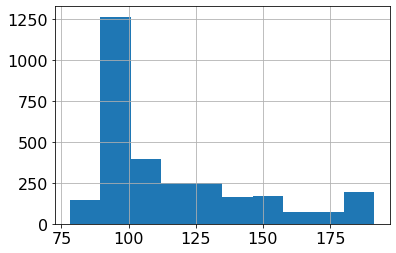

In [ ]:
testing['Target'].hist()
#plt.xlim(70,120)
#plt.ylim(0,500)

In [ ]:
print('Validation Well Max. Depth: ', testing['Depth'].max())
print('Test Well Max Depth: ', test['Depth'].max())
print('Validation Well Min. Depth: ', testing['Depth'].min())
print('Test Well Min. Depth: ', test['Depth'].min())

Validation Well Max. Depth:  7668.0
Test Well Max Depth:  8819.0
Validation Well Min. Depth:  6083.0
Test Well Min. Depth:  6984.0


In [ ]:
#testing = testing[(testing['Depth'] <= test['Depth'].max() ]
testing

Depth   SonicC     Den  ...       Lat       Lon          well
10442  6083.0  89.2008  2.4816  ...  6.723628  3.207556  1737d6c90d5e
10443  6083.5  90.3200  2.4863  ...  6.723628  3.207556  1737d6c90d5e
10444  6084.0  91.2744  2.5015  ...  6.723628  3.207556  1737d6c90d5e
10445  6084.5  91.2292  2.5257  ...  6.723628  3.207556  1737d6c90d5e
10446  6085.0  89.9315  2.5181  ...  6.723628  3.207556  1737d6c90d5e
...       ...      ...     ...  ...       ...       ...           ...
13608  7666.0  49.3539  2.7974  ...  6.723628  3.207556  1737d6c90d5e
13609  7666.5  49.3438  2.8064  ...  6.723628  3.207556  1737d6c90d5e
13610  7667.0  49.3618  2.8100  ...  6.723628  3.207556  1737d6c90d5e
13611  7667.5  49.2471  2.8098  ...  6.723628  3.207556  1737d6c90d5e
13612  7668.0  48.5756  2.8085  ...  6.723628  3.207556  1737d6c90d5e

[2985 rows x 15 columns]

In [ ]:
train.shape

(307323, 15)

In [ ]:
test['Depth'].max()

8819.0

In [ ]:
train['well'].unique()

array(['0a65a72dd23f', '0e121cce5c23', '0f7a4609731a', '146b023afbcf',
       '15560bf61021', '1737d6c90d5e', '1cf78b7ca1cc', '1f901b2ab8a5',
       '260af024a4c2', '3ca90f59eddb', '3e09ee2f5add', '4503ff73396f',
       '45f3c132a607', '4bc281e7f645', '4eeb27e8a754', '64b8d826e247',
       '6c22c24c3e7c', '6cd66f018b76', '70a049901d0c', '714bd04772d7',
       '77ae830eed77', '7b5c7cb115b4', '845a53b34139', '84b20f26d4cd',
       '8a551cb29776', '8b39e194343c', '9847bb58b85e', '9971672f4246',
       '99f3cc15a9f5', 'aa15a44f3219', 'adef5ffb1e3f', 'b13f2e23d0b3',
       'b838bb38e2c2', 'b8fbeeb97254', 'ba74c8879e3e', 'c09ca9d54f82',
       'c3f859bb5f10', 'c7e8322b8b3b', 'c95d65c35ad9', 'd09b501c79b2',
       'd6aa464fab0e', 'e6026d8a5c5c', 'edd2626cc4b8', 'fb71da2c3a43',
       'fe47e0c3ac55'], dtype=object)

In [ ]:
tempp = train[(train['Lon'] < 4) & (train['Lon'] > 3) & (train['Lat'] > 6) & (train['Lat'] < 7)]
tempp['well'].unique()

array(['0a65a72dd23f', '1737d6c90d5e', '4460f43fb0fd', '6cd66f018b76',
       '70a049901d0c', '714bd04772d7', '734da1169c53', '93aea4f8e268',
       'f14dd71a2352', 'fe47e0c3ac55'], dtype=object)

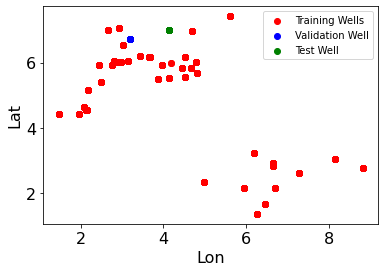

<Figure size 720x1440 with 0 Axes>

In [ ]:
plt.scatter(train.Lon, train.Lat, c='r', label='Training Wells')
plt.scatter(testing.Lon, testing.Lat, c='b', label='Validation Well')
plt.scatter(test.Lon, test.Lat, c='g', label='Test Well')
plt.xlabel('Lon')
plt.ylabel('Lat')
plt.legend()
#plt.xlim(6,8)
#plt.ylim(1,2)
plt.figure(figsize=(10,20))
plt.show()

In [ ]:
train = train[(train['well'] != '1737d6c90d5e')]

In [ ]:
train.shape

(304338, 15)

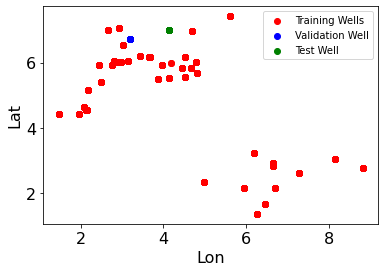

<Figure size 720x1440 with 0 Axes>

In [ ]:
plt.scatter(train.Lon, train.Lat, c='r', label='Training Wells')
plt.scatter(testing.Lon, testing.Lat, c='b', label='Validation Well')
plt.scatter(test.Lon, test.Lat, c='g', label='Test Well')
plt.xlabel('Lon')
plt.ylabel('Lat')
plt.legend()
#plt.xlim(6,8)
#plt.ylim(1,2)
plt.figure(figsize=(10,20))
plt.show()

In [ ]:
train = train[(train['Lat'] > 4)]
#train = train[(train['Lat'] > 5) & (train['Lon'] < 9.5)]

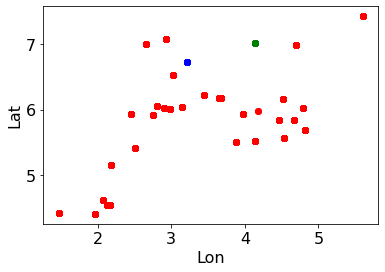

In [ ]:
plt.scatter(train.Lon, train.Lat, c='r', label='Training Wells')
plt.scatter(testing.Lon, testing.Lat, c='b', label='Validation Well')
plt.scatter(test.Lon, test.Lat, c='g', label='Test Well')
plt.ylabel('Lat')
plt.xlabel('Lon')
plt.show()

In [ ]:
testing.head()

Depth   SonicC     Den  ...       Lat       Lon          well
10442  6083.0  89.2008  2.4816  ...  6.723628  3.207556  1737d6c90d5e
10443  6083.5  90.3200  2.4863  ...  6.723628  3.207556  1737d6c90d5e
10444  6084.0  91.2744  2.5015  ...  6.723628  3.207556  1737d6c90d5e
10445  6084.5  91.2292  2.5257  ...  6.723628  3.207556  1737d6c90d5e
10446  6085.0  89.9315  2.5181  ...  6.723628  3.207556  1737d6c90d5e

[5 rows x 15 columns]

In [ ]:
testing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2985 entries, 10442 to 13612
Data columns (total 15 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Depth   2985 non-null   float64
 1   SonicC  2985 non-null   float64
 2   Den     2985 non-null   float64
 3   PorDen  2985 non-null   float64
 4   PorNeu  2985 non-null   float64
 5   Gamma   2985 non-null   float64
 6   PhotoE  2985 non-null   float64
 7   SponP   2985 non-null   float64
 8   Cali    2985 non-null   float64
 9   DenCor  2985 non-null   float64
 10  ResXO   2985 non-null   float64
 11  Target  2985 non-null   float64
 12  Lat     2985 non-null   float64
 13  Lon     2985 non-null   float64
 14  well    2985 non-null   object 
dtypes: float64(14), object(1)
memory usage: 373.1+ KB


In [ ]:
testing.describe().transpose()

count         mean  ...          75%          max
Depth   2985.0  6863.801508  ...  7295.000000  7668.000000
SonicC  2985.0    64.575123  ...    75.685200   117.975500
Den     2985.0     2.569006  ...     2.670400     2.869700
PorDen  2985.0     0.083046  ...     0.130200     0.300700
PorNeu  2985.0     0.126351  ...     0.224600     0.501500
Gamma   2985.0    63.797155  ...    86.065000   623.161700
PhotoE  2985.0     3.602850  ...     4.226600     7.637300
SponP   2985.0   -10.453063  ...     2.092500    23.807100
Cali    2985.0     8.636608  ...     8.838100    14.523000
DenCor  2985.0     0.047409  ...     0.074700     0.244800
ResXO   2985.0   282.975479  ...   246.128400  2053.221700
Target  2985.0   116.269910  ...   131.358600   191.502000
Lat     2985.0     6.723628  ...     6.723628     6.723628
Lon     2985.0     3.207556  ...     3.207556     3.207556

[14 rows x 8 columns]

In [ ]:
train.describe().transpose()

count         mean  ...           75%           max
Depth   235871.0  7861.204415  ...  10442.500000  15047.000000
SonicC  235871.0    72.926664  ...     81.285650    175.177500
Den     235871.0     2.532629  ...      2.650700      4.074500
PorDen  235871.0     0.102199  ...      0.151600      0.701300
PorNeu  235871.0     0.191872  ...      0.270600      0.701200
Gamma   235871.0    92.919178  ...    117.838750    467.275400
PhotoE  235871.0     3.728660  ...      4.105400     20.065100
SponP   235871.0   -57.739024  ...    -13.333300    316.115600
Cali    235871.0    10.871433  ...     12.376600     25.131500
DenCor  235871.0     0.049114  ...      0.087700      0.406800
ResXO   235871.0    64.336372  ...     24.378600   2107.161400
Target  235871.0   132.391038  ...    150.551050    390.790300
Lat     235871.0     5.743111  ...      6.036190      7.421619
Lon     235871.0     3.485819  ...      4.530951      5.604180

[14 rows x 8 columns]

In [ ]:
train.head()

Depth   SonicC  PorDen  ...       Lat       Lon          well
11126  6498.0  78.3858  0.0294  ...  6.169119  3.680102  0a65a72dd23f
11127  6498.5  78.5007  0.0343  ...  6.169119  3.680102  0a65a72dd23f
11128  6499.0  78.7959  0.0391  ...  6.169119  3.680102  0a65a72dd23f
11129  6499.5  79.0788  0.0420  ...  6.169119  3.680102  0a65a72dd23f
11130  6500.0  79.1212  0.0425  ...  6.169119  3.680102  0a65a72dd23f

[5 rows x 12 columns]

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 292732 entries, 11126 to 19680
Data columns (total 12 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Depth   292732 non-null  float64
 1   SonicC  292732 non-null  float64
 2   PorDen  292732 non-null  float64
 3   PorNeu  292732 non-null  float64
 4   Gamma   292732 non-null  float64
 5   PhotoE  292732 non-null  float64
 6   Cali    292732 non-null  float64
 7   ResXO   292732 non-null  float64
 8   Target  292732 non-null  float64
 9   Lat     292732 non-null  float64
 10  Lon     292732 non-null  float64
 11  well    292732 non-null  object 
dtypes: float64(11), object(1)
memory usage: 29.0+ MB


In [ ]:
# Get a list of columns or features from the training set
column = list(train.columns)
print(len(column))

15


In [ ]:
# Get a list of columns or features from the training set
column = list(train.columns)
print(column)

['Depth', 'SonicC', 'Den', 'PorDen', 'PorNeu', 'Gamma', 'PhotoE', 'SponP', 'Cali', 'DenCor', 'ResXO', 'Target', 'Lat', 'Lon', 'well']


In [ ]:
# Selecting specific columns from the training set and removing ResSH, ResDP, Target and Well
# ResSH and ResDP were removed due to a large radius of investigation and hence low correlation with Target
select_columns = list(column[i] for i in [12, 13, 14])
select_columns

['Lat', 'Lon', 'well']

In [ ]:
# Dropping the selected columns SP, ResSH, ResMD, ResDP and Target from the training data
# and assigning the target into a separate DataFrame for well 2
x_train = train.drop(select_columns, axis=1)
# y_train = train["Target"].values

In [ ]:
x_train.head()

Depth   SonicC     Den  PorDen  ...     Cali  DenCor   ResXO    Target
11126  6498.0  78.3858  2.6686  0.0294  ...  10.4607  0.0085  8.8686  145.7087
11127  6498.5  78.5007  2.6618  0.0343  ...  10.4861  0.0067  8.5503  145.7087
11128  6499.0  78.7959  2.6550  0.0391  ...  10.5114  0.0038  8.0942  145.7087
11129  6499.5  79.0788  2.6481  0.0420  ...  10.5348  0.0011  8.2637  145.9386
11130  6500.0  79.1212  2.6427  0.0425  ...  10.5631  0.0010  8.4367  145.9640

[5 rows x 12 columns]

## **Preprocessing**

In [ ]:
x_train.columns

Index(['Depth', 'SonicC', 'Den', 'PorDen', 'PorNeu', 'Gamma', 'PhotoE',
       'SponP', 'Cali', 'DenCor', 'ResXO', 'Target'],
      dtype='object')

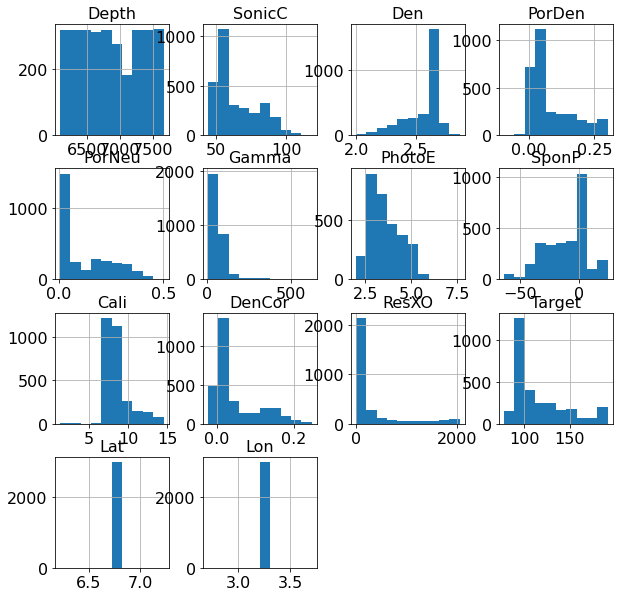

In [ ]:
testing.hist(figsize=(10,10))
plt.show()

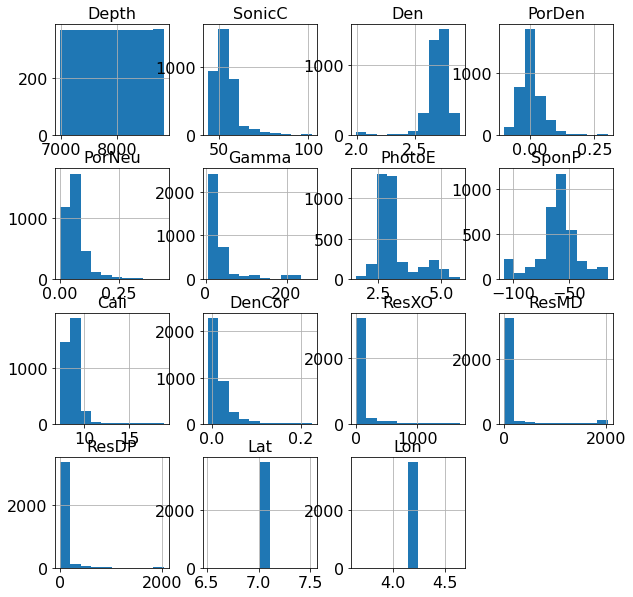

In [ ]:
test.hist(figsize=(10,10))
plt.show()

In [ ]:
# Transoform ResXO to logarithmic
x_train['ResXO'] = np.log10(x_train['ResXO'])
x_train.head()

Depth   SonicC     Den  PorDen  ...     Cali  DenCor     ResXO    Target
11126  6498.0  78.3858  2.6686  0.0294  ...  10.4607  0.0085  0.947855  145.7087
11127  6498.5  78.5007  2.6618  0.0343  ...  10.4861  0.0067  0.931981  145.7087
11128  6499.0  78.7959  2.6550  0.0391  ...  10.5114  0.0038  0.908174  145.7087
11129  6499.5  79.0788  2.6481  0.0420  ...  10.5348  0.0011  0.917175  145.9386
11130  6500.0  79.1212  2.6427  0.0425  ...  10.5631  0.0010  0.926173  145.9640

[5 rows x 12 columns]

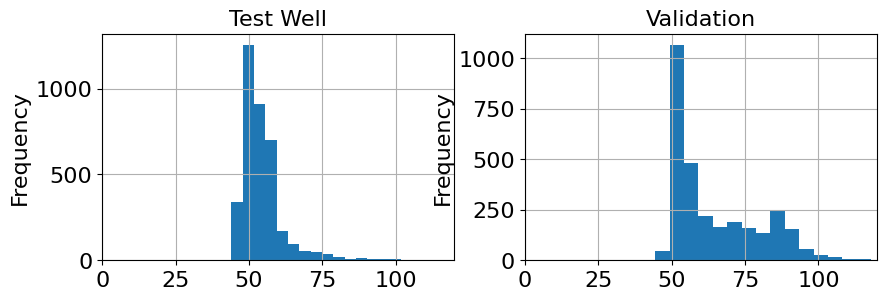

In [ ]:
font = {'size'   : 10}
plt.rc('font', **font)

fig = plt.subplots(figsize=(10, 3), dpi= 100, facecolor='w', edgecolor='k')

ax1=plt.subplot(1,2,1)
test['SonicC'].hist(bins=15)
plt.title("Test Well")
plt.ylabel("Frequency")
plt.xlim(0,120)
#plt.ylim(0,2000)

ax2=plt.subplot(1,2,2) 
testing['SonicC'].hist(bins=15)
plt.title("Validation")
plt.ylabel("Frequency")
plt.xlim(0,120)
plt.show()

### Standardization

In [ ]:
testing.columns

Index(['Depth', 'SonicC', 'Den', 'PorDen', 'PorNeu', 'Gamma', 'PhotoE',
       'SponP', 'Cali', 'DenCor', 'ResXO', 'Target', 'Lat', 'Lon', 'well'],
      dtype='object')

In [ ]:
x_train.columns

Index(['Depth', 'SonicC', 'Den', 'PorDen', 'PorNeu', 'Gamma', 'PhotoE',
       'SponP', 'Cali', 'DenCor', 'ResXO', 'Target'],
      dtype='object')

In [ ]:
# Copy data to avoid altering the original x_train data
scaled_features = x_train.drop(labels='Target', axis=1)
y_train = x_train['Target'].values

# Move the Depth column to the last
scaled_features = scaled_features[['Depth', 'SonicC', 'Den', 'PorDen', 'PorNeu', 'Gamma', 'PhotoE',
       'SponP', 'Cali', 'DenCor', 'ResXO']]

col_names = scaled_features.columns

std_features = ['Depth', 'SonicC', 'Den', 'PorDen', 'PorNeu', 'Gamma', 'PhotoE',
       'SponP', 'Cali', 'DenCor', 'ResXO']
scaled_features

Depth   SonicC     Den  PorDen  ...    SponP     Cali  DenCor     ResXO
11126  6498.0  78.3858  2.6686  0.0294  ... -10.7897  10.4607  0.0085  0.947855
11127  6498.5  78.5007  2.6618  0.0343  ... -11.9332  10.4861  0.0067  0.931981
11128  6499.0  78.7959  2.6550  0.0391  ... -11.8925  10.5114  0.0038  0.908174
11129  6499.5  79.0788  2.6481  0.0420  ... -11.8518  10.5348  0.0011  0.917175
11130  6500.0  79.1212  2.6427  0.0425  ... -11.8111  10.5631  0.0010  0.926173
...       ...      ...     ...     ...  ...      ...      ...     ...       ...
19665  9880.5  56.0417  2.5700  0.0785  ... -27.3508   7.5016  0.0626  1.630826
19666  9881.0  56.8915  2.3779  0.2290  ... -27.9294   7.5029  0.0377  1.911339
19667  9881.5  58.9502  2.2082  0.2982  ... -27.9222   7.4915  0.0487  2.266190
19668  9882.0  59.5282  2.1799  0.2947  ... -27.9151   3.1571  0.1463  1.699000
19669  9882.5  57.7636  2.2913  0.2241  ... -27.9079   3.1565  0.2426  1.496305

[235871 rows x 11 columns]

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

# Standardize all the columns except 'Depth'
# Standardization using StandardScaler
scaler = StandardScaler()

## ColumnTransformer
ct = ColumnTransformer([('standardize', scaler, std_features)], remainder='passthrough')

## fit and transform
well_train_norm = ct.fit_transform(scaled_features)

## convert to dataframe
x_train_std = pd.DataFrame(well_train_norm, columns=col_names)
x_train_std

Depth    SonicC       Den  ...      Cali    DenCor     ResXO
0      -0.409029  0.371051  0.742224  ... -0.177687 -0.660733 -0.141988
1      -0.408879  0.378860  0.705105  ... -0.166699 -0.690016 -0.165886
2      -0.408729  0.398925  0.667986  ... -0.155754 -0.737194 -0.201729
3      -0.408579  0.418153  0.630321  ... -0.145631 -0.781119 -0.188179
4      -0.408429  0.421035  0.600844  ... -0.133388 -0.782746 -0.174632
...          ...       ...       ...  ...       ...       ...       ...
235866  0.605889 -1.147651  0.203996  ... -1.457821  0.219392  0.886255
235867  0.606039 -1.089891 -0.844621  ... -1.457258 -0.185693  1.308579
235868  0.606189 -0.949963 -1.770962  ... -1.462190 -0.006740  1.842822
235869  0.606339 -0.910677 -1.925444  ... -3.337291  1.581064  0.988893
235870  0.606489 -1.030615 -1.317344  ... -3.337551  3.147718  0.683728

[235871 rows x 11 columns]

In [ ]:
y_train

array([145.7087, 145.7087, 145.7087, ..., 110.824 , 111.377 , 108.7116])

In [ ]:
x_train_std = x_train_std.values

In [ ]:
x_train_std

array([[-0.40902889,  0.37105087,  0.74222434, ..., -0.17768705,
        -0.66073264, -0.1419878 ],
       [-0.40887886,  0.37886048,  0.70510516, ..., -0.16669878,
        -0.6900159 , -0.16588637],
       [-0.40872884,  0.39892487,  0.66798598, ..., -0.15575377,
        -0.73719449, -0.20172948],
       ...,
       [ 0.60618881, -0.94996332, -1.77096246, ..., -1.46219013,
        -0.00673977,  1.84282209],
       [ 0.60633883, -0.91067736, -1.92544375, ..., -3.33729121,
         1.5810638 ,  0.98889283],
       [ 0.60648885, -1.03061508, -1.31734425, ..., -3.33755077,
         3.14771834,  0.68372803]])

## 1. Linear Regression

### Testing

In [ ]:
testing.head()

Depth   SonicC     Den  ...       Lat       Lon          well
10442  6083.0  89.2008  2.4816  ...  6.723628  3.207556  1737d6c90d5e
10443  6083.5  90.3200  2.4863  ...  6.723628  3.207556  1737d6c90d5e
10444  6084.0  91.2744  2.5015  ...  6.723628  3.207556  1737d6c90d5e
10445  6084.5  91.2292  2.5257  ...  6.723628  3.207556  1737d6c90d5e
10446  6085.0  89.9315  2.5181  ...  6.723628  3.207556  1737d6c90d5e

[5 rows x 15 columns]

In [ ]:
# Get a list of columns or features from the training set
column = list(testing.columns)
print(column)

['Depth', 'SonicC', 'Den', 'PorDen', 'PorNeu', 'Gamma', 'PhotoE', 'SponP', 'Cali', 'DenCor', 'ResXO', 'Target', 'Lat', 'Lon', 'well']


In [ ]:
# Selecting specific columns from the training set and removing ResSH, ResDP, Target and Well
# ResSH and ResDP were removed due to a large radius of investigation and hence low correlation with Target
select_columns = list(column[i] for i in [11, 12, 13, 14])
select_columns

['Target', 'Lat', 'Lon', 'well']

In [ ]:
# Dropping the selected columns SP, ResSH, ResMD, ResDP and Target from the training data
# and assigning the target into a separate DataFrame for well 2
x_testing = testing.drop(select_columns, axis=1)
y_testing = testing["Target"].values

In [ ]:
x_testing.head()

Depth   SonicC     Den  PorDen  ...   SponP     Cali  DenCor   ResXO
10442  6083.0  89.2008  2.4816  0.1363  ... -0.6346  10.2888  0.0883  5.2874
10443  6083.5  90.3200  2.4863  0.1342  ... -0.3244  10.3235  0.0913  5.2742
10444  6084.0  91.2744  2.5015  0.1207  ... -0.2466  10.2920  0.0942  5.1902
10445  6084.5  91.2292  2.5257  0.1079  ... -0.1689  10.2047  0.0973  5.1636
10446  6085.0  89.9315  2.5181  0.1076  ... -0.6823  10.1106  0.1003  5.2107

[5 rows x 11 columns]

In [ ]:
x_train.head()

Depth   SonicC     Den  PorDen  ...     Cali  DenCor     ResXO    Target
11126  6498.0  78.3858  2.6686  0.0294  ...  10.4607  0.0085  0.947855  145.7087
11127  6498.5  78.5007  2.6618  0.0343  ...  10.4861  0.0067  0.931981  145.7087
11128  6499.0  78.7959  2.6550  0.0391  ...  10.5114  0.0038  0.908174  145.7087
11129  6499.5  79.0788  2.6481  0.0420  ...  10.5348  0.0011  0.917175  145.9386
11130  6500.0  79.1212  2.6427  0.0425  ...  10.5631  0.0010  0.926173  145.9640

[5 rows x 12 columns]

In [ ]:
y_testing

array([187.5743, 187.6703, 187.6749, ...,  92.6348,  91.98  ,  91.1287])

In [ ]:
# Transoform ResXO to logarithmic
x_testing['ResXO'] = np.log10(x_testing['ResXO'])
x_testing.head()

Depth   SonicC     Den  PorDen  ...   SponP     Cali  DenCor     ResXO
10442  6083.0  89.2008  2.4816  0.1363  ... -0.6346  10.2888  0.0883  0.723242
10443  6083.5  90.3200  2.4863  0.1342  ... -0.3244  10.3235  0.0913  0.722157
10444  6084.0  91.2744  2.5015  0.1207  ... -0.2466  10.2920  0.0942  0.715184
10445  6084.5  91.2292  2.5257  0.1079  ... -0.1689  10.2047  0.0973  0.712953
10446  6085.0  89.9315  2.5181  0.1076  ... -0.6823  10.1106  0.1003  0.716896

[5 rows x 11 columns]

In [ ]:
## Transform
x_testing = ct.transform(x_testing)
x_testing # Display the data

array([[-0.53354946,  1.10613331, -0.2785531 , ..., -0.25205257,
         0.637492  , -0.48015228],
       [-0.53339943,  1.18220398, -0.25289719, ..., -0.23704103,
         0.68629744, -0.48178666],
       [-0.53324941,  1.24707339, -0.16992491, ..., -0.25066822,
         0.73347603, -0.49228406],
       ...,
       [-0.05827095, -1.60167525,  1.51408492, ..., -1.41239682,
        -0.19220043,  0.93272548],
       [-0.05812092, -1.60947127,  1.51299318, ..., -1.40815725,
        -0.21172261,  1.36702484],
       [-0.0579709 , -1.65511231,  1.50589687, ..., -1.40270637,
        -0.2556475 ,  1.83204948]])

In [ ]:
# Apply a simple Linear Regression model
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(x_train_std, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
# Get the mean of RMSE for all RMSE from 5-fold cross-validation
from sklearn.model_selection import cross_val_score
np.random.seed(32)

scores = cross_val_score(lin_reg, x_train_std, y_train, scoring="neg_mean_squared_error", cv=5)
lin_reg_acc = np.mean(np.sqrt(-scores))
lin_reg_acc

17.183332641911118

## 2. ANN

In [ ]:
def plot_NN(model,history,x_train,y_train):
    """ Plot training loss versus validation loss and 
    training accuracy versus validation accuracy"""
    
    font = {'size'   : 7.5}
    plt.rc('font', **font)
    fig, ax=plt.subplots(figsize=(7, 5), dpi= 200, facecolor='w', edgecolor='k')
    
    ax1 = plt.subplot(2,2,1)    
    history_dict = history.history
    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    epochs = range(1, len(loss_values) + 1)
    ax1.plot(epochs, loss_values, 'bo',markersize=4, label='Training loss')          
    ax1.plot(epochs, val_loss_values, 'r-', label='Validation loss')    
    plt.title('Training and validation loss',fontsize=11)
    plt.xlabel('Epochs (Early Stopping)',fontsize=9)
    plt.ylabel('Loss',fontsize=10)
    plt.legend(fontsize='8.5')
    plt.ylim((0, 150))
    
    ax2 = plt.subplot(2,2,2)
    pred=model.predict(x_train)
    t = pd.DataFrame({'pred': pred.flatten(), 'y': y_train.flatten()})
    t.sort_values(by=['y'], inplace=True)    

    epochs = range(1, len(loss_values) + 1)        
    ax2.plot(t['pred'].tolist(), 'g', label='Prediction')    
    ax2.plot(t['y'].tolist(), 'm--o',markersize=2, label='Expected')      
    plt.title('Prediction vs Expected for Training',fontsize=11)
    plt.xlabel('Data',fontsize=9)
    plt.ylabel('Output',fontsize=10)
    plt.legend(fontsize='8.5')    
    fig.tight_layout(w_pad=1.42)
    plt.show()

In [ ]:
def DNN (input_dim,neurons=50,loss="mse",activation="relu",Nout=1,L2_regularizer=False,
             metrics=None,activation_out=None,init_mode=None,BatchOpt=False,dropout_rate=False):
    """ Function to run Deep Neural Network (5 hidden layer) for different hyperparameters"""
    np.random.seed(42)
    tf.random.set_seed(42)
    
    keras.backend.clear_session() # Clear the previous model
    
    if(activation=='Leaky_relu'): activation = keras.layers.LeakyReLU(alpha=0.2)
    if(L2_regularizer): kernel_regularizer=keras.regularizers.l2() 
    else: kernel_regularizer=None
        
    # create model
    model = keras.models.Sequential()
    
    # Input & Hidden Layer 1
    model.add(keras.layers.Dense(neurons,input_dim=input_dim, activation=activation, 
                                 kernel_initializer=init_mode,kernel_regularizer=kernel_regularizer))
    if(BatchOpt): model.add(keras.layers.BatchNormalization())
    if(dropout_rate):  model.add(keras.layers.Dropout(dropout_rate))
        
    # Hidden Layer 2
    model.add(keras.layers.Dense(neurons,activation=activation,
                                 kernel_initializer=init_mode,kernel_regularizer=kernel_regularizer))
    if(BatchOpt): model.add(keras.layers.BatchNormalization())
    if(dropout_rate):  model.add(keras.layers.Dropout(dropout_rate))

    # Hidden Layer 3
    model.add(keras.layers.Dense(neurons,activation=activation,
                                 kernel_initializer=init_mode,kernel_regularizer=kernel_regularizer))
    if(BatchOpt): model.add(keras.layers.BatchNormalization())
    if(dropout_rate):  model.add(keras.layers.Dropout(dropout_rate))

    # Output Layer 
    model.add(keras.layers.Dense(Nout,activation=activation_out)) 
        
    # Compile model
    model.compile(optimizer='adam',loss=loss,metrics=metrics)
    return model

In [ ]:
x_train_std.shape

(235871, 11)

In [ ]:
import tensorflow as tf
from tensorflow import keras

model_DNN = DNN (input_dim=x_train_std.shape[1], neurons=350, Nout=1, L2_regularizer=False,
                 init_mode=None , dropout_rate=None, activation='relu', metrics=None,
                 activation_out=None, loss='mse')

# Early stopping to avoid overfitting
monitor= keras.callbacks.EarlyStopping(min_delta=1e-3,patience=3)
history=model_DNN.fit(x_train_std,y_train,batch_size=32,validation_data=
          (x_testing,y_testing),callbacks=[monitor],verbose=1,epochs=1000) 

Epoch 1/1000
7371/7371 [==============================] - 16s 2ms/step - loss: 599.5472 - val_loss: 140.5420
Epoch 2/1000
7371/7371 [==============================] - 15s 2ms/step - loss: 145.4368 - val_loss: 136.8560
Epoch 3/1000
7371/7371 [==============================] - 15s 2ms/step - loss: 131.9289 - val_loss: 139.7499
Epoch 4/1000
7371/7371 [==============================] - 16s 2ms/step - loss: 125.0969 - val_loss: 134.6255
Epoch 5/1000
7371/7371 [==============================] - 15s 2ms/step - loss: 118.7923 - val_loss: 138.4735
Epoch 6/1000
7371/7371 [==============================] - 15s 2ms/step - loss: 114.9050 - val_loss: 122.9218
Epoch 7/1000
7371/7371 [==============================] - 15s 2ms/step - loss: 111.4018 - val_loss: 122.0294
Epoch 8/1000
7371/7371 [==============================] - 15s 2ms/step - loss: 108.0894 - val_loss: 128.2691
Epoch 9/1000
7371/7371 [==============================] - 15s 2ms/step - loss: 107.9347 - val_loss: 123.7083
Epoch 10/1000
7371/

In [ ]:
from sklearn.metrics import mean_squared_error
pred = model_DNN.predict(x_train_std)
mse = mean_squared_error(pred, y_train)
rmse = np.sqrt(mse)

print('rmse of all training: ',rmse)

rmse of all training:  9.953235245873676


In [ ]:
from sklearn.metrics import mean_squared_error
pred_testing = model_DNN.predict(x_testing)
mse_testing = mean_squared_error(pred_testing, y_testing)
rmse_testing = np.sqrt(mse_testing)

print('rmse of all validation: ',rmse_testing)

rmse of all validation:  11.230358263234352


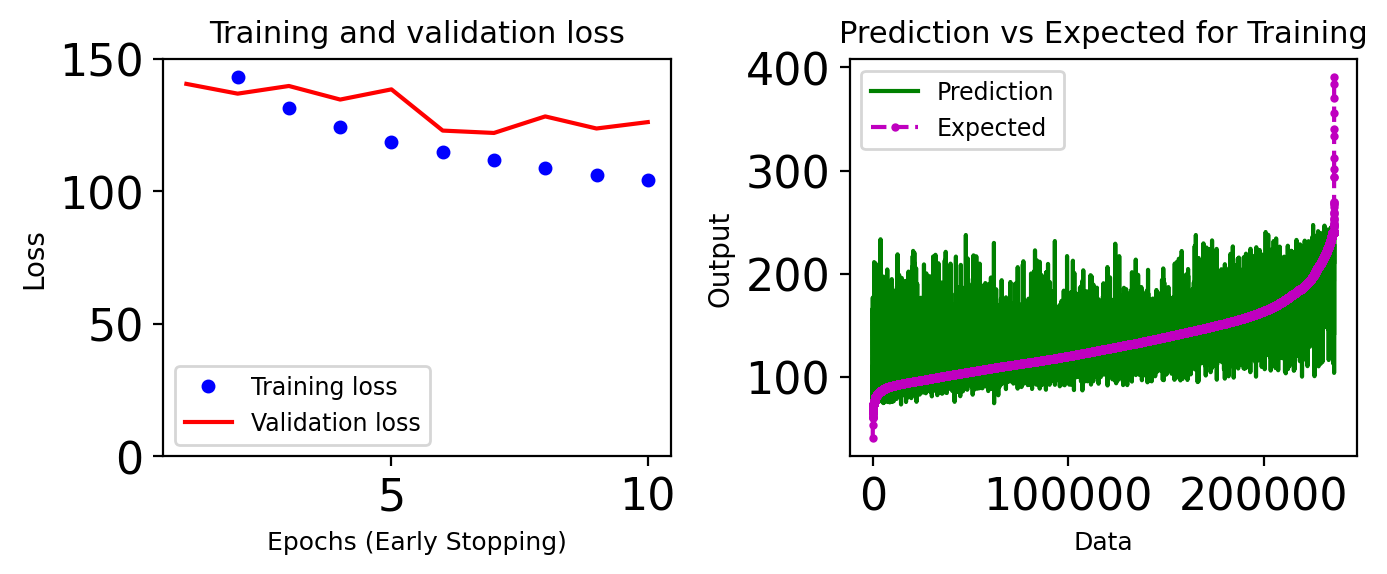

In [ ]:
plot_NN(model_DNN,history,x_train_std,y_train)

In [ ]:
from sklearn.metrics import mean_squared_error
pred_testing = model_DNN.predict(x_testing)
mse_testing = mean_squared_error(pred_testing, y_testing)
rmse_testing = np.sqrt(mse_testing)

print('rmse of all validation: ',rmse_testing)

rmse of all validation:  11.343327057053816


In [ ]:
pred_test_well = model_DNN.predict(x_testing)
pred_test_well[0:20]

array([[168.65007],
       [171.14922],
       [171.45326],
       [171.2532 ],
       [173.66699],
       [174.13075],
       [175.46304],
       [177.14403],
       [179.6009 ],
       [179.57314],
       [176.90051],
       [174.64046],
       [174.60365],
       [177.93954],
       [184.2115 ],
       [185.9844 ],
       [178.91476],
       [157.81424],
       [134.93217],
       [117.12637]], dtype=float32)

In [ ]:
# Convert training set back into a DataFrame and check info. to verify data has been imputed
pred_test = pd.DataFrame(pred_test_well, columns=['Prediction'], index=None)
pred_test.head()

Prediction
0  168.650070
1  171.149216
2  171.453262
3  171.253204
4  173.666992

In [ ]:
pred_test.to_csv('validation_well2.csv', index_label=False)
!cp validation_well2.csv "drive/My Drive/Colab Notebooks"

## Validation Checks

In [ ]:
# Test Well
df1 = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/well_ff7845ea074d.xlsx')
#df2 = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/well_fca03aa6acde_final_2.xlsx')

# Validation Well
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/validation_well.csv')
df3 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/validation_well2.csv')

In [ ]:
well = test_wells2['ff7845ea074d']
well

Depth   SonicC     Den  PorDen  ...    ResMD    ResDP       Lat       Lon
0     6984.0  53.2193     NaN     NaN  ...  35.3551  43.0457  7.011406  4.141898
1     6984.5  52.4380     NaN     NaN  ...  34.5501  43.9756  7.011406  4.141898
2     6985.0  51.6567     NaN     NaN  ...  33.7072  44.6007  7.011406  4.141898
3     6985.5  51.4208     NaN     NaN  ...  34.0908  44.8237  7.011406  4.141898
4     6986.0  51.2788     NaN     NaN  ...  34.3955  44.8582  7.011406  4.141898
...      ...      ...     ...     ...  ...      ...      ...       ...       ...
3666  8817.0  51.0738  2.6322  0.0503  ...      NaN      NaN  7.011406  4.141898
3667  8817.5  51.6112  2.6145  0.0623  ...      NaN      NaN  7.011406  4.141898
3668  8818.0  51.9350  2.5828  0.0799  ...      NaN      NaN  7.011406  4.141898
3669  8818.5  52.1779  2.5610  0.0925  ...      NaN      NaN  7.011406  4.141898
3670  8819.0  52.4040  2.5593  0.0904  ...      NaN      NaN  7.011406  4.141898

[3671 rows x 15 columns]

In [ ]:
df1.head()

Unnamed: 0   Depth        DTSM
0           0  6984.0  101.743370
1           1  6984.5  100.463753
2           2  6985.0   99.228600
3           3  6985.5   98.910866
4           4  6986.0   98.753113

In [ ]:
df1 = df1.drop('Unnamed: 0', axis=1)
df1

Depth        DTSM
0     6984.0  101.743370
1     6984.5  100.463753
2     6985.0   99.228600
3     6985.5   98.910866
4     6986.0   98.753113
...      ...         ...
3666  8817.0   88.686890
3667  8817.5   89.347656
3668  8818.0   89.868599
3669  8818.5   90.181320
3670  8819.0   90.383232

[3671 rows x 2 columns]

In [ ]:
df.head()

Depth        DTSM
0  10797.0  101.164230
1  10797.5  101.828255
2  10798.0  101.896378
3  10798.5  102.492134
4  10799.0  102.676903

In [ ]:
df1.columns = ['Depth', 'DTSM']

In [ ]:
df1.head()

Depth        DTSM
0  6984.0  101.743370
1  6984.5  100.463753
2  6985.0   99.228600
3  6985.5   98.910866
4  6986.0   98.753113

In [ ]:
df1.to_excel('well_ff7845ea074d.xlsx', index=False)
!cp well_ff7845ea074d.xlsx "drive/My Drive/Colab Notebooks"

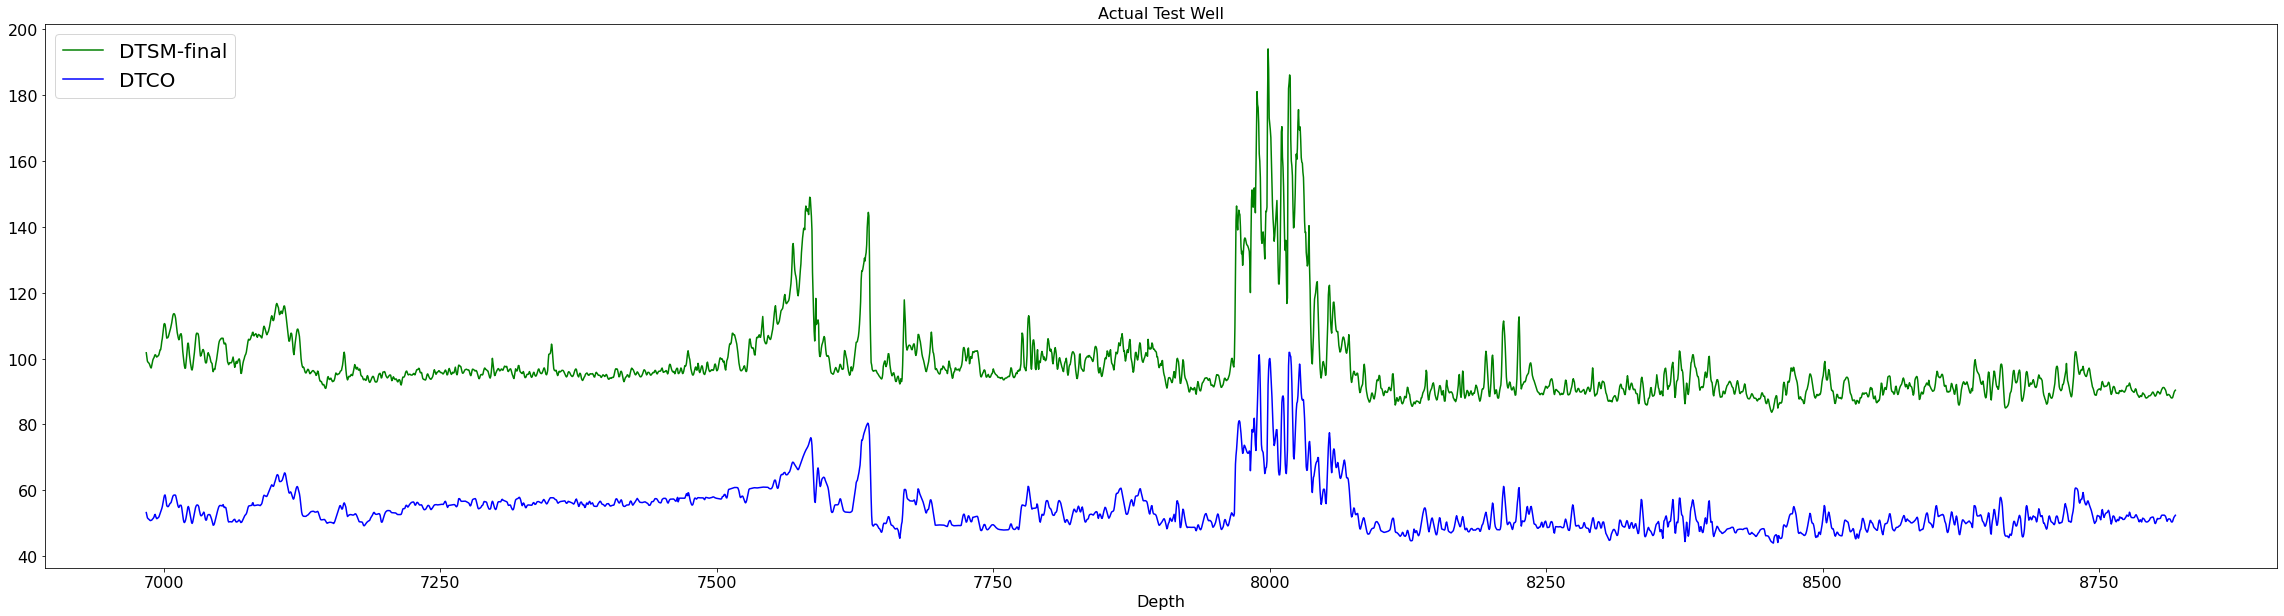

In [ ]:
plt.figure(figsize=(40,10))
plt.plot(df1['Depth'], df1['DTSM'], c='g', label='DTSM-final')
plt.plot(well['Depth'], well['SonicC'], c='b', label='DTCO')

params = {'axes.labelsize': 16,
          'axes.titlesize': 16,
          'xtick.labelsize': 16,
          'ytick.labelsize': 16}
plt.rcParams.update(params)

plt.xlabel('Depth')
plt.title('Actual Test Well')
plt.legend(loc=2, prop={'size': 20})

plt.show()

In [ ]:
#print(df3.shape)
#print(df4.shape)
print(df1.shape)
print(df1.shape)
print(testing.shape)

(3671, 3)
(3671, 3)
(2985, 15)


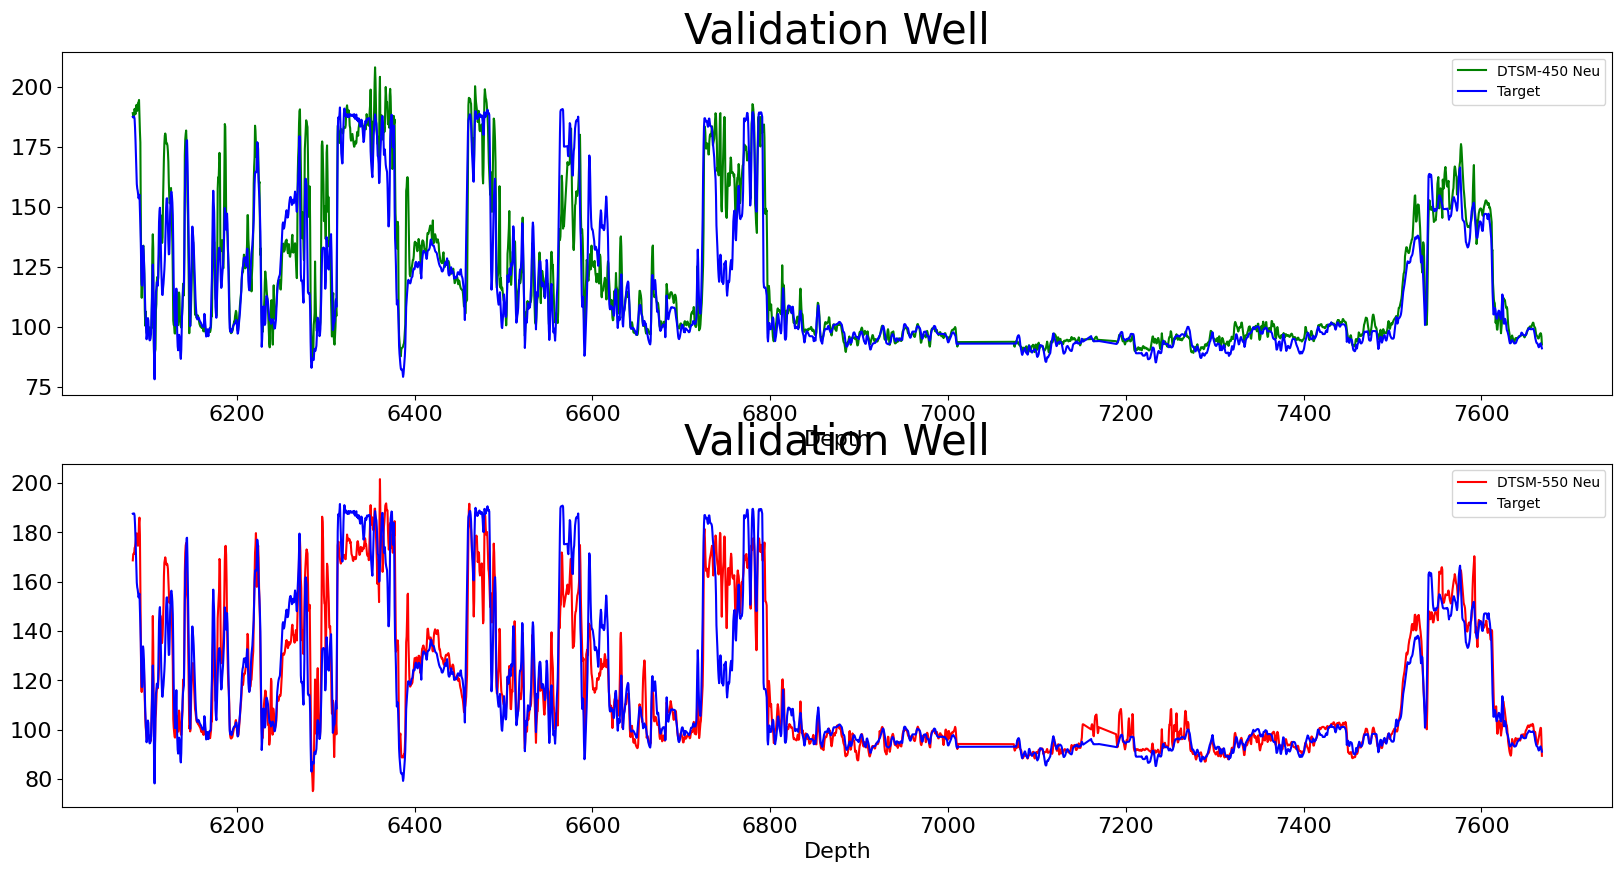

In [ ]:
font = {'size'   : 10}
plt.rc('font', **font)

fig = plt.subplots(figsize=(20, 10), dpi= 100, facecolor='w', edgecolor='k')

ax1=plt.subplot(2,1,1)
plt.plot(testing['Depth'], df['Prediction'], c='g', label='DTSM-450 Neu')
#plt.plot(testing['Depth'], df3['Prediction'], c='r', label='DTSM-550 Neu')
plt.plot(testing['Depth'], testing['Target'], c='b', label='Target')

params = {'axes.labelsize': 16,
          'axes.titlesize': 16,
          'xtick.labelsize': 16,
          'ytick.labelsize': 16}
plt.rcParams.update(params)

plt.xlabel('Depth')
plt.title('Validation Well', fontdict={'size': 30})
plt.legend(loc=1, prop={'size': 10})

ax2=plt.subplot(2,1,2) 
#plt.plot(testing['Depth'], df['Prediction'], c='g', label='DTSM-450 Neu')
plt.plot(testing['Depth'], df3['Prediction'], c='r', label='DTSM-550 Neu')
plt.plot(testing['Depth'], testing['Target'], c='b', label='Target')

params = {'axes.labelsize': 16,
          'axes.titlesize': 16,
          'xtick.labelsize': 16,
          'ytick.labelsize': 16}
plt.rcParams.update(params)

plt.xlabel('Depth')
plt.title('Validation Well', fontdict={'size': 30})
plt.legend(loc=1, prop={'size': 10})

plt.show()

In [ ]:
testing.columns

Index(['Depth', 'SonicC', 'Den', 'PorDen', 'PorNeu', 'Gamma', 'PhotoE', 'Cali',
       'DenCor', 'ResXO', 'Target', 'Lat', 'Lon', 'well'],
      dtype='object')

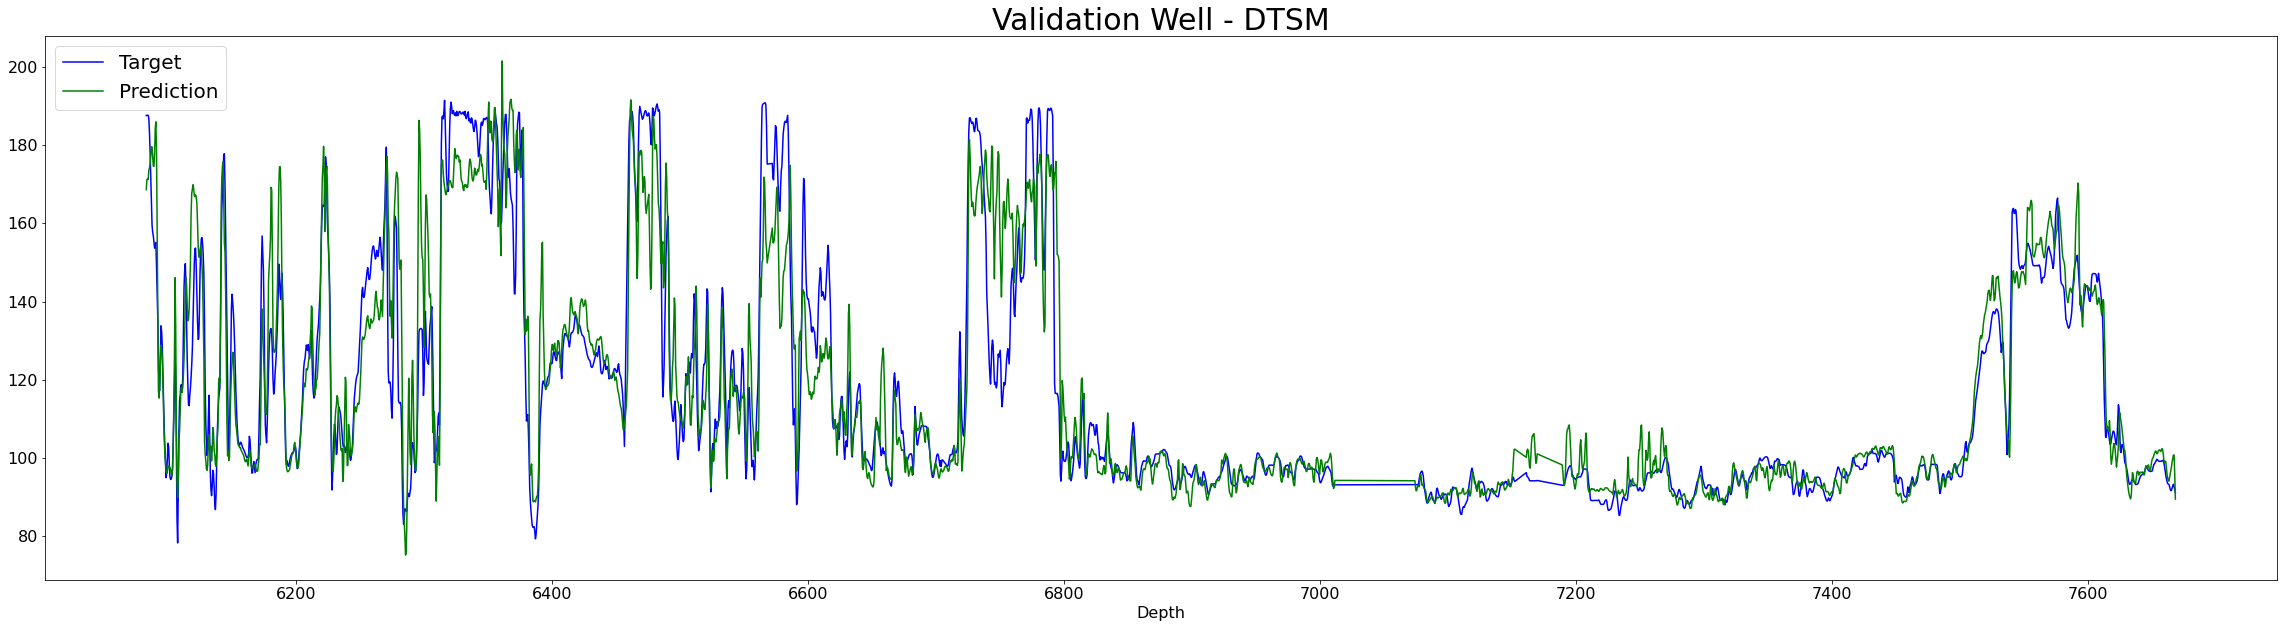

In [ ]:
plt.figure(figsize=(40,10))
plt.plot(testing['Depth'], testing['Target'], c='b', label='Target')
plt.plot(testing['Depth'], df3['Prediction'], c='g', label='Prediction')

params = {'axes.labelsize': 16,
          'axes.titlesize': 16,
          'xtick.labelsize': 16,
          'ytick.labelsize': 16}
plt.rcParams.update(params)

plt.xlabel('Depth')
plt.legend(loc=2, prop={'size': 20})
plt.title('Validation Well - DTSM', fontdict={'size': 30})

plt.show()

In [ ]:
testing['Target'].shape

(5483,)

In [ ]:
df4['Prediction'].shape

(5483,)

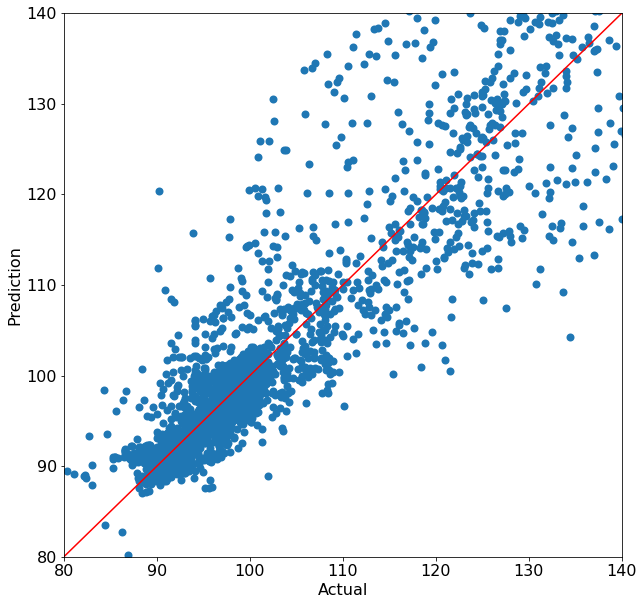

In [ ]:
plt.figure(figsize=(10,10))
plt.scatter((testing.Target), (df3.Prediction), linewidths=2)
plt.plot([80, 200], [80, 200], color = 'red')
plt.xlim(80,140)
plt.ylim(80,140)
plt.xlabel('Actual')
plt.ylabel('Prediction')
plt.show()

## Prediction - fca03aa6acde

In [ ]:
x_test = test_wells2['ff7845ea074d']
x_test.head()

Depth   SonicC  Den  PorDen  ...    ResMD    ResDP       Lat       Lon
0  6984.0  53.2193  NaN     NaN  ...  35.3551  43.0457  7.011406  4.141898
1  6984.5  52.4380  NaN     NaN  ...  34.5501  43.9756  7.011406  4.141898
2  6985.0  51.6567  NaN     NaN  ...  33.7072  44.6007  7.011406  4.141898
3  6985.5  51.4208  NaN     NaN  ...  34.0908  44.8237  7.011406  4.141898
4  6986.0  51.2788  NaN     NaN  ...  34.3955  44.8582  7.011406  4.141898

[5 rows x 15 columns]

In [ ]:
# Get a list of columns or features from the training set
column = list(x_test.columns)
print(column)

['Depth', 'SonicC', 'Den', 'PorDen', 'PorNeu', 'Gamma', 'PhotoE', 'SponP', 'Cali', 'DenCor', 'ResXO', 'ResMD', 'ResDP', 'Lat', 'Lon']


In [ ]:
x_train.columns

Index(['Depth', 'SonicC', 'Den', 'PorDen', 'PorNeu', 'Gamma', 'PhotoE',
       'SponP', 'Cali', 'DenCor', 'ResXO', 'Target'],
      dtype='object')

In [ ]:
# Selecting specific columns from the training set and removing ResSH, ResDP, Target and Well
# ResSH and ResDP were removed due to a large radius of investigation and hence low correlation with Target
select_columns = list(column[i] for i in [11, 12, 13, 14])
select_columns

['ResMD', 'ResDP', 'Lat', 'Lon']

In [ ]:
# Dropping the selected columns SP, ResSH, ResMD, ResDP and Target from the training data
# and assigning the target into a separate DataFrame for well 2
x_test = x_test.drop(select_columns, axis=1)
x_test.head(100)

Depth   SonicC     Den  PorDen  ...     SponP     Cali  DenCor    ResXO
0   6984.0  53.2193     NaN     NaN  ... -105.9360      NaN     NaN  90.6969
1   6984.5  52.4380     NaN     NaN  ... -106.2947      NaN     NaN  88.4926
2   6985.0  51.6567     NaN     NaN  ... -106.8272      NaN     NaN  89.2624
3   6985.5  51.4208     NaN     NaN  ... -106.7741      NaN     NaN  92.5508
4   6986.0  51.2788     NaN     NaN  ... -106.7001      NaN     NaN  95.8585
..     ...      ...     ...     ...  ...       ...      ...     ...      ...
95  7031.5  54.9290  2.6375  0.0472  ... -100.7305  10.2399  0.0357  41.0392
96  7032.0  53.8947  2.6354  0.0462  ... -100.7815  10.2724  0.0245  40.2816
97  7032.5  53.2016  2.6425  0.0419  ... -100.8129  10.2885  0.0143  42.9282
98  7033.0  52.5085  2.6528  0.0366  ... -101.3389  10.2862  0.0079  50.8406
99  7033.5  52.2451  2.6626  0.0320  ... -101.5042  10.2853  0.0056  72.3430

[100 rows x 11 columns]

In [ ]:
x_test.shape

(3671, 11)

In [ ]:
x_test.isna().sum()

Depth     0
SonicC    0
Den       0
PorDen    0
PorNeu    0
Gamma     0
PhotoE    0
SponP     0
Cali      0
DenCor    0
ResXO     0
dtype: int64

In [ ]:
x_test.head(15)

Depth   SonicC     Den  PorDen  ...     SponP    Cali  DenCor     ResXO
0   6984.0  53.2193  2.6313   0.048  ... -105.9360  10.272 -0.0002   90.6969
1   6984.5  52.4380  2.6313   0.048  ... -106.2947  10.272 -0.0002   88.4926
2   6985.0  51.6567  2.6313   0.048  ... -106.8272  10.272 -0.0002   89.2624
3   6985.5  51.4208  2.6313   0.048  ... -106.7741  10.272 -0.0002   92.5508
4   6986.0  51.2788  2.6313   0.048  ... -106.7001  10.272 -0.0002   95.8585
5   6986.5  51.1299  2.6313   0.048  ... -106.8379  10.272 -0.0002   98.5420
6   6987.0  50.9468  2.6313   0.048  ... -106.9758  10.272 -0.0002   95.5986
7   6987.5  50.8034  2.6313   0.048  ... -107.1136  10.272 -0.0002   84.1381
8   6988.0  50.8034  2.6313   0.048  ... -107.2319  10.272 -0.0002   71.5953
9   6988.5  50.8691  2.6313   0.048  ... -107.4300  10.272 -0.0002   67.7516
10  6989.0  50.9606  2.6313   0.048  ... -107.5360  10.272 -0.0002   83.5320
11  6989.5  51.1507  2.6313   0.048  ... -107.0213  10.272 -0.0002  106.6931
12  6990.0  51.3408  2.6313   0.048  ... -106.4878  10.272 -0.0002  137.8742
13  6990.5  51.5807  2.6313   0.048  ... -105.9544  10.272 -0.0002  135.2700
14  6991.0  51.9043  2.6313   0.048  ... -105.7043  10.272 -0.0002  118.7106

[15 rows x 11 columns]

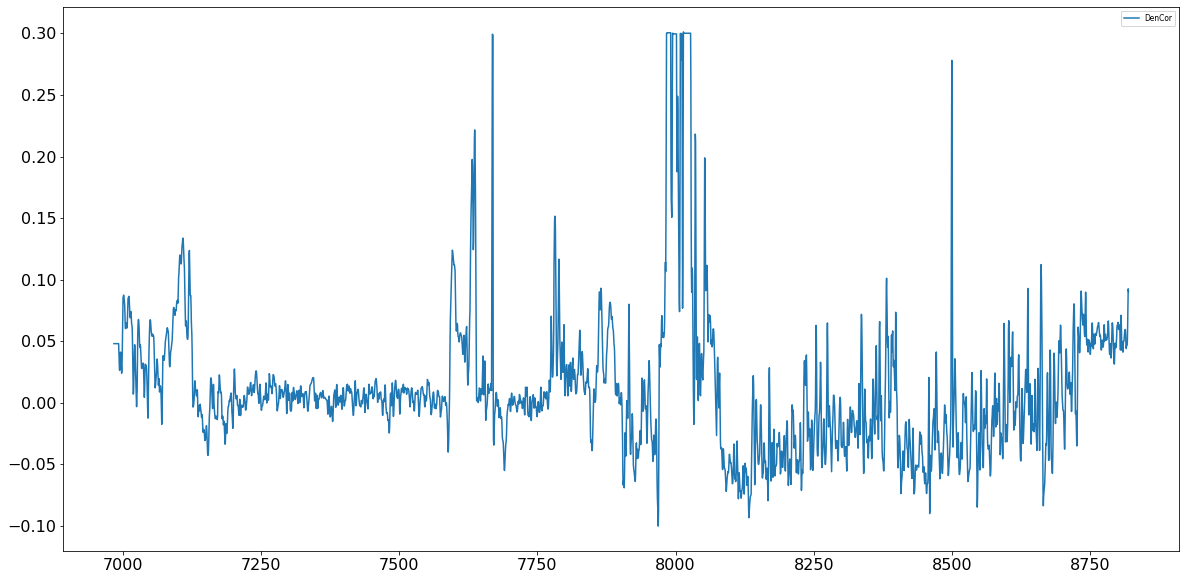

In [ ]:
x_test['Den'] = x_test['SponP'].fillna(method='ffill')
x_test['ResXO'] = x_test['ResXO'].fillna(method='ffill')

x_test['Den'] = x_test['Den'].fillna(method='bfill')
x_test['PorDen'] = x_test['PorDen'].fillna(method='bfill')
x_test['PorNeu'] = x_test['PorNeu'].fillna(method='bfill')
x_test['PhotoE'] = x_test['PhotoE'].fillna(method='bfill')
x_test['Cali'] = x_test['Cali'].fillna(method='bfill')
x_test['DenCor'] = x_test['DenCor'].fillna(method='bfill')


plt.figure(figsize=(20,10))

plt.plot(x_test['Depth'], x_test['PorDen'], label='DenCor')
#plt.plot(x_test['Depth'], x_test['PorDen'], label='PorDen')
#plt.plot(x_test['Depth'], x_test['PorNeu'], label='PorNeu')
#plt.plot(x_test['Depth'], x_test['PhotoE'], label='PhotoE')
#plt.plot(x_test['Depth'], x_test['PhotoE'], label='PhotoE')
#plt.plot(x_test['Depth'], x_test['SponP'], label='SponP')
#plt.plot(x_test['Depth'], x_test['Cali'], label='Cali')
#plt.plot(x_test['Depth'], x_test['DenCor'], label='DenCor')
#plt.plot(x_test['Depth'], x_test['ResXO'], label='ResXO')

plt.legend()
plt.show()

In [ ]:
x_test.head()

Depth   SonicC     Den  PorDen  ...     SponP    Cali  DenCor    ResXO
0  6984.0  53.2193  2.6313   0.048  ... -105.9360  10.272 -0.0002  90.6969
1  6984.5  52.4380  2.6313   0.048  ... -106.2947  10.272 -0.0002  88.4926
2  6985.0  51.6567  2.6313   0.048  ... -106.8272  10.272 -0.0002  89.2624
3  6985.5  51.4208  2.6313   0.048  ... -106.7741  10.272 -0.0002  92.5508
4  6986.0  51.2788  2.6313   0.048  ... -106.7001  10.272 -0.0002  95.8585

[5 rows x 11 columns]

In [ ]:
# Transoform ResXO to logarithmic
x_test['ResXO'] = np.log10(x_test['ResXO'])
x_test.head()

Depth   SonicC     Den  PorDen  ...     SponP    Cali  DenCor     ResXO
0  6984.0  53.2193  2.6313   0.048  ... -105.9360  10.272 -0.0002  1.957592
1  6984.5  52.4380  2.6313   0.048  ... -106.2947  10.272 -0.0002  1.946907
2  6985.0  51.6567  2.6313   0.048  ... -106.8272  10.272 -0.0002  1.950669
3  6985.5  51.4208  2.6313   0.048  ... -106.7741  10.272 -0.0002  1.966380
4  6986.0  51.2788  2.6313   0.048  ... -106.7001  10.272 -0.0002  1.981631

[5 rows x 11 columns]

In [ ]:
## Transform
x_test = ct.transform(x_test)
x_test # Display the data

array([[-0.2632048 , -1.33948565,  0.53861472, ..., -0.2593204 ,
        -0.8022684 ,  1.37821569],
       [-0.26305478, -1.39258966,  0.53861472, ..., -0.2593204 ,
        -0.8022684 ,  1.36212822],
       [-0.26290475, -1.44569368,  0.53861472, ..., -0.2593204 ,
        -0.8022684 ,  1.36779148],
       ...,
       [ 0.2870861 , -1.42677796,  0.27386763, ..., -1.47577406,
         0.69117799,  3.2769518 ],
       [ 0.28723612, -1.41026834,  0.15486791, ..., -1.52539432,
         0.99539855,  3.2769518 ],
       [ 0.28738615, -1.3949006 ,  0.14558811, ..., -1.55559044,
         1.29636541,  3.2769518 ]])

In [ ]:
pred_well_2 = model_DNN.predict(x_test)
pred_well_2[0:20]

array([[101.74337 ],
       [100.46375 ],
       [ 99.2286  ],
       [ 98.910866],
       [ 98.75311 ],
       [ 98.55893 ],
       [ 98.19774 ],
       [ 97.71436 ],
       [ 97.229385],
       [ 97.13838 ],
       [ 97.94457 ],
       [ 98.73623 ],
       [ 99.611755],
       [100.00214 ],
       [100.2739  ],
       [100.82784 ],
       [101.16151 ],
       [101.054054],
       [100.630554],
       [100.437675]], dtype=float32)

In [ ]:
# Convert training set back into a DataFrame and check info. to verify data has been imputed
prediction = pd.DataFrame(pred_well_2, columns=['DTSM'], index=None)
prediction.head()

DTSM
0  101.743370
1  100.463753
2   99.228600
3   98.910866
4   98.753113

In [ ]:
df = test_wells2['ff7845ea074d']
df.head()

Depth   SonicC  Den  PorDen  ...    ResMD    ResDP       Lat       Lon
0  6984.0  53.2193  NaN     NaN  ...  35.3551  43.0457  7.011406  4.141898
1  6984.5  52.4380  NaN     NaN  ...  34.5501  43.9756  7.011406  4.141898
2  6985.0  51.6567  NaN     NaN  ...  33.7072  44.6007  7.011406  4.141898
3  6985.5  51.4208  NaN     NaN  ...  34.0908  44.8237  7.011406  4.141898
4  6986.0  51.2788  NaN     NaN  ...  34.3955  44.8582  7.011406  4.141898

[5 rows x 15 columns]

In [ ]:
df1 = df[['Depth']]
df1.head()

Depth
0  6984.0
1  6984.5
2  6985.0
3  6985.5
4  6986.0

In [ ]:
frames = [df1, prediction]
result = pd.concat(frames, axis=1)
result.head(20)

Depth        DTSM
0   6984.0  101.743370
1   6984.5  100.463753
2   6985.0   99.228600
3   6985.5   98.910866
4   6986.0   98.753113
5   6986.5   98.558929
6   6987.0   98.197739
7   6987.5   97.714363
8   6988.0   97.229385
9   6988.5   97.138382
10  6989.0   97.944572
11  6989.5   98.736229
12  6990.0   99.611755
13  6990.5  100.002136
14  6991.0  100.273903
15  6991.5  100.827843
16  6992.0  101.161507
17  6992.5  101.054054
18  6993.0  100.630554
19  6993.5  100.437675

In [ ]:
result.to_excel('well_ff7845ea074d.xlsx', index=False)
!cp well_ff7845ea074d.xlsx "drive/My Drive/Colab Notebooks"

# **Well Name:** eed1e9537976

## Sonic Log Prediction

In [ ]:
# Importing all the required libraries
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Unpickling the training and test data
DATA_PATH = "/content/drive/MyDrive/Colab Notebooks"

train_wells = pickle.load(open(DATA_PATH + '/aliasDataDict.pickle', 'rb'))
test_wells = pickle.load(open(DATA_PATH + '/aliasTestDict.pickle', 'rb'))
test_wells2 = pickle.load(open(DATA_PATH + '/aliasTestDict2.pickle', 'rb'))

In [ ]:
# remove bad wells
for well in ['0df16b6a5cc4', '046bc790f386', '095b70877102', '3ae75d54eac9', '3ff29633be48', '4ca27a528281', '5e1afa63de2d', '5246f53b5ac1', '7d1aa6c73956', '7e654b4d6598', '72c8644ce206', '72e96b568173', '73b0829c2017', '8bc6a83e83c2', '8c261ddf84f0', '99f4058f01cd', 'aea70fdc0581', 'de80b6e3d82b', '294246409a5b', '7161967506d2', 'a8bf6de9dde4', 'aaa6cb9d1317', 'b9a6d892a542', 'b101bb4f1380', 'b361d4a1956d', 'b757a79fd1b4', 'bd1cdb70689e', 'c02434863dba', 'cbafb92fd7b8', 'cbe115c74a89', 'e94afa2da916', 'ebcd53d21726', 'f8b4278236fb', '253c7236a62c']: 
    del train_wells[well]
# skip this
# for well in train_wells: 
#     train_wells[well] = train_wells[well].dropna()
# remove bad intervals
for well, stop in zip(['683429fdaabf', 'b53a64bff446', 'bb0d54e77d0d', '93aea4f8e268'], [15953, 10637, 7408, 10236]): 
    train_wells[well] = train_wells[well].query('Depth<=@stop')
for well, start in zip(['0052442d0162', '0e121cce5c23', '1dab7ce73d3f', '3ca90f59eddb', '03d4fc789db8', '3d6dde594223', '4ddffa33d3c3', '7afba96e8dba', 'a60d6fbacca1', 'a22060c0c155', 'b39fb7f6359c', 'bae924c8fe1e', 'c671806afdb1', 'cbca0681ee9e', '1f854180654f', '99f3cc15a9f5', '1f439d39052a', '734da1169c53'], \
                      [5997, 1427, 14200, 12711, 7200, 920, 3534, 300, 5250, 15655, 8180, 10930, 1152, 4415, 12551, 4500, 7691, 500]): 
    train_wells[well] = train_wells[well].query('Depth>=@start')

### **Test Well:** eed1e9537976 | **Validation Well:** d6aa464fab0e

In [ ]:
test = test_wells2['eed1e9537976']
test.columns

Index(['Depth', 'SonicC', 'Den', 'PorDen', 'PorNeu', 'Gamma', 'PhotoE',
       'SponP', 'Cali', 'DenCor', 'ResXO', 'ResSH', 'ResDP', 'Lat', 'Lon'],
      dtype='object')

In [ ]:
test['Depth'].min()

7997.0

In [ ]:
test['Depth'].max()

9975.0

In [ ]:
test['Depth'].max() - test['Depth'].min()

1978.0

In [ ]:
test.columns

Index(['Depth', 'SonicC', 'Den', 'PorDen', 'PorNeu', 'Gamma', 'PhotoE',
       'SponP', 'Cali', 'DenCor', 'ResXO', 'ResSH', 'ResDP', 'Lat', 'Lon'],
      dtype='object')

In [ ]:
# Grouping all the training data from all the wells based on the logs available in the test well
# inputSet = set(test_wells['Well 7'].columns)
# or specify input manually
inputSet = set(['Depth', 'SonicC', 'Den', 'PorDen', 'PorNeu', 'Gamma', 'PhotoE',
                'SponP', 'Cali', 'DenCor', 'ResXO'])
train = pd.DataFrame()

for well in train_wells:
    if inputSet.issubset(set(train_wells[well].columns)):
        temp_df = train_wells[well][sorted(inputSet)+['Target']]
        temp_df = train_wells[well]
        temp_df = temp_df.dropna(subset=list(inputSet), how='any')
        # Put feature engineering here?
        temp_df['well'] = well
        train = train.append(temp_df)
train = train.dropna(axis=1, how='any')

In [ ]:
#### temp = train_wells['0a65a72dd23f']

In [ ]:
train.shape

(307323, 15)

In [ ]:
train.columns

Index(['Depth', 'SonicC', 'Den', 'PorDen', 'PorNeu', 'Gamma', 'PhotoE',
       'SponP', 'Cali', 'DenCor', 'ResXO', 'Target', 'Lat', 'Lon', 'well'],
      dtype='object')

In [ ]:
test['Depth'].max()

9975.0

In [ ]:
train['well'].unique()

array(['0a65a72dd23f', '0e121cce5c23', '0f7a4609731a', '146b023afbcf',
       '15560bf61021', '1737d6c90d5e', '1cf78b7ca1cc', '1f901b2ab8a5',
       '260af024a4c2', '3ca90f59eddb', '3e09ee2f5add', '4503ff73396f',
       '45f3c132a607', '4bc281e7f645', '4eeb27e8a754', '64b8d826e247',
       '6c22c24c3e7c', '6cd66f018b76', '70a049901d0c', '714bd04772d7',
       '77ae830eed77', '7b5c7cb115b4', '845a53b34139', '84b20f26d4cd',
       '8a551cb29776', '8b39e194343c', '9847bb58b85e', '9971672f4246',
       '99f3cc15a9f5', 'aa15a44f3219', 'adef5ffb1e3f', 'b13f2e23d0b3',
       'b838bb38e2c2', 'b8fbeeb97254', 'ba74c8879e3e', 'c09ca9d54f82',
       'c3f859bb5f10', 'c7e8322b8b3b', 'c95d65c35ad9', 'd09b501c79b2',
       'd6aa464fab0e', 'e6026d8a5c5c', 'edd2626cc4b8', 'fb71da2c3a43',
       'fe47e0c3ac55'], dtype=object)

In [ ]:
tempp = train[(train['Lon'] < 3) & (train['Lon'] > 2) & (train['Lat'] > 4) & (train['Lat'] < 6)]
tempp['well'].unique()

array(['146b023afbcf', '4bc281e7f645', '4eeb27e8a754', '77ae830eed77',
       'c7e8322b8b3b', 'd09b501c79b2', 'd6aa464fab0e'], dtype=object)

In [ ]:
testing = train[train.well == 'd6aa464fab0e'] ## 4eeb27e8a754 d6aa464fab0e

In [ ]:
testing

Depth   SonicC     Den  ...       Lat      Lon          well
12098   6086.0  93.3416  2.5836  ...  4.538054  2.16706  d6aa464fab0e
12099   6086.5  93.3318  2.5717  ...  4.538054  2.16706  d6aa464fab0e
12100   6087.0  92.1562  2.5522  ...  4.538054  2.16706  d6aa464fab0e
12101   6087.5  91.5634  2.5124  ...  4.538054  2.16706  d6aa464fab0e
12102   6088.0  88.6323  2.4732  ...  4.538054  2.16706  d6aa464fab0e
...        ...      ...     ...  ...       ...      ...           ...
20973  10523.5  77.6083  2.4581  ...  4.538054  2.16706  d6aa464fab0e
20974  10524.0  76.3989  2.3965  ...  4.538054  2.16706  d6aa464fab0e
20975  10524.5  75.1896  2.3212  ...  4.538054  2.16706  d6aa464fab0e
20976  10525.0  75.9561  2.2279  ...  4.538054  2.16706  d6aa464fab0e
20977  10525.5  78.3804  2.1279  ...  4.538054  2.16706  d6aa464fab0e

[7635 rows x 15 columns]

In [ ]:
testing = testing[(testing['Depth'] <= 10000) & (testing['Depth'] >= 7500)]
testing

Depth   SonicC     Den  ...       Lat      Lon          well
14926   7500.0  78.2014  2.4604  ...  4.538054  2.16706  d6aa464fab0e
14927   7500.5  79.2464  2.4697  ...  4.538054  2.16706  d6aa464fab0e
14928   7501.0  79.5805  2.4744  ...  4.538054  2.16706  d6aa464fab0e
14929   7501.5  79.2421  2.4919  ...  4.538054  2.16706  d6aa464fab0e
14930   7502.0  79.1833  2.5163  ...  4.538054  2.16706  d6aa464fab0e
...        ...      ...     ...  ...       ...      ...           ...
19922   9998.0  62.8580  2.6150  ...  4.538054  2.16706  d6aa464fab0e
19923   9998.5  63.1986  2.6196  ...  4.538054  2.16706  d6aa464fab0e
19924   9999.0  63.2202  2.6427  ...  4.538054  2.16706  d6aa464fab0e
19925   9999.5  63.0283  2.6393  ...  4.538054  2.16706  d6aa464fab0e
19926  10000.0  62.6616  2.6416  ...  4.538054  2.16706  d6aa464fab0e

[4836 rows x 15 columns]

In [ ]:
print('Validation Well Max. Depth: ', testing['Depth'].max())
print('Test Well Max Depth: ', test['Depth'].max())
print('Validation Well Min. Depth: ', testing['Depth'].min())
print('Test Well Min. Depth: ', test['Depth'].min())

Validation Well Max. Depth:  10000.0
Test Well Max Depth:  9975.0
Validation Well Min. Depth:  7500.0
Test Well Min. Depth:  7997.0


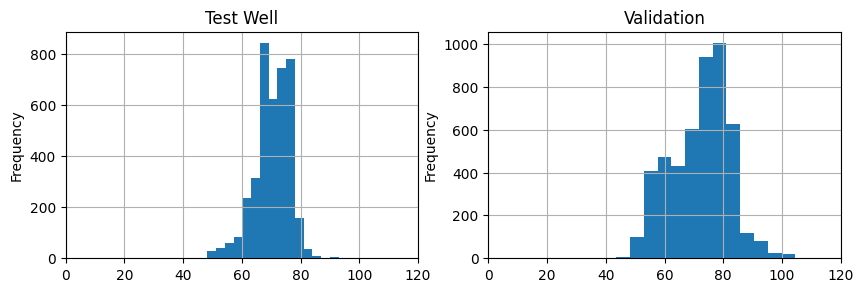

In [ ]:
font = {'size'   : 10}
plt.rc('font', **font)

fig = plt.subplots(figsize=(10, 3), dpi= 100, facecolor='w', edgecolor='k')

ax1=plt.subplot(1,2,1)
test['SonicC'].hist(bins=15)
plt.title("Test Well")
plt.ylabel("Frequency")
plt.xlim(0,120)
#plt.ylim(0,2000)

ax2=plt.subplot(1,2,2) 
testing['SonicC'].hist(bins=15)
plt.title("Validation")
plt.ylabel("Frequency")
plt.xlim(0,120)
plt.show()

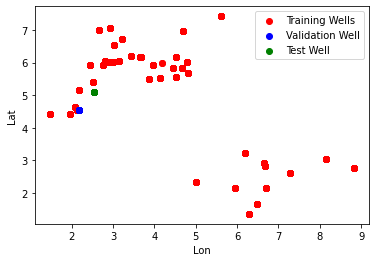

<Figure size 720x1440 with 0 Axes>

In [ ]:
plt.scatter(train.Lon, train.Lat, c='r', label='Training Wells')
plt.scatter(testing.Lon, testing.Lat, c='b', label='Validation Well')
plt.scatter(test.Lon, test.Lat, c='g', label='Test Well')
plt.xlabel('Lon')
plt.ylabel('Lat')
plt.legend()
#plt.xlim(6,8)
#plt.ylim(1,2)
plt.figure(figsize=(10,20))
plt.show()

In [ ]:
train = train[(train['well'] != 'd6aa464fab0e')]

In [ ]:
train.shape

(299688, 15)

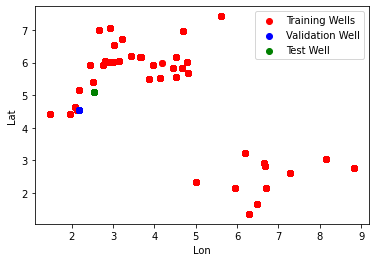

<Figure size 720x1440 with 0 Axes>

In [ ]:
plt.scatter(train.Lon, train.Lat, c='r', label='Training Wells')
plt.scatter(testing.Lon, testing.Lat, c='b', label='Validation Well')
plt.scatter(test.Lon, test.Lat, c='g', label='Test Well')
plt.xlabel('Lon')
plt.ylabel('Lat')
plt.legend()
#plt.xlim(6,8)
#plt.ylim(1,2)
plt.figure(figsize=(10,20))
plt.show()

In [ ]:
train = train[(train['Lat'] > 4)]
#train = train[(train['Lat'] > 5) & (train['Lon'] < 9.5)]

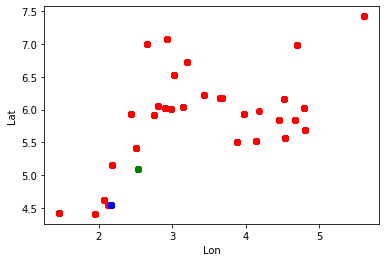

In [ ]:
plt.scatter(train.Lon, train.Lat, c='r', label='Training Wells')
plt.scatter(testing.Lon, testing.Lat, c='b', label='Validation Well')
plt.scatter(test.Lon, test.Lat, c='g', label='Test Well')
plt.ylabel('Lat')
plt.xlabel('Lon')
plt.show()

In [ ]:
testing.head()

Depth   SonicC     Den  ...       Lat      Lon          well
14926  7500.0  78.2014  2.4604  ...  4.538054  2.16706  d6aa464fab0e
14927  7500.5  79.2464  2.4697  ...  4.538054  2.16706  d6aa464fab0e
14928  7501.0  79.5805  2.4744  ...  4.538054  2.16706  d6aa464fab0e
14929  7501.5  79.2421  2.4919  ...  4.538054  2.16706  d6aa464fab0e
14930  7502.0  79.1833  2.5163  ...  4.538054  2.16706  d6aa464fab0e

[5 rows x 15 columns]

In [ ]:
testing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4836 entries, 14926 to 19926
Data columns (total 15 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Depth   4836 non-null   float64
 1   SonicC  4836 non-null   float64
 2   Den     4836 non-null   float64
 3   PorDen  4836 non-null   float64
 4   PorNeu  4836 non-null   float64
 5   Gamma   4836 non-null   float64
 6   PhotoE  4836 non-null   float64
 7   SponP   4836 non-null   float64
 8   Cali    4836 non-null   float64
 9   DenCor  4836 non-null   float64
 10  ResXO   4836 non-null   float64
 11  Target  4836 non-null   float64
 12  Lat     4836 non-null   float64
 13  Lon     4836 non-null   float64
 14  well    4836 non-null   object 
dtypes: float64(14), object(1)
memory usage: 604.5+ KB


In [ ]:
testing.describe().transpose()

count         mean  ...          75%           max
Depth   4836.0  8751.926902  ...  9369.625000  10000.000000
SonicC  4836.0    72.290886  ...    79.810275    114.005700
Den     4836.0     2.509221  ...     2.618675      2.819500
PorDen  4836.0     0.116026  ...     0.179100      0.300700
PorNeu  4836.0     0.218850  ...     0.299125      0.568100
Gamma   4836.0    89.412386  ...   112.096075    169.193900
PhotoE  4836.0     4.124577  ...     4.493900      6.273900
SponP   4836.0   -15.293452  ...   -11.004500      3.712300
Cali    4836.0    12.971897  ...    13.350250     21.196600
DenCor  4836.0     0.131997  ...     0.173425      0.385300
ResXO   4836.0     8.889595  ...     9.604300    118.476900
Target  4836.0   135.811177  ...   156.271525    239.804800
Lat     4836.0     4.538054  ...     4.538054      4.538054
Lon     4836.0     2.167060  ...     2.167060      2.167060

[14 rows x 8 columns]

In [ ]:
train.describe().transpose()

count         mean  ...           75%           max
Depth   231221.0  7832.865447  ...  10496.500000  15047.000000
SonicC  231221.0    72.778856  ...     81.300100    175.177500
Den     231221.0     2.534121  ...      2.652200      4.074500
PorDen  231221.0     0.101339  ...      0.150200      0.701300
PorNeu  231221.0     0.189806  ...      0.269100      0.701200
Gamma   231221.0    92.487519  ...    117.795600    623.161700
PhotoE  231221.0     3.716133  ...      4.088300     20.065100
SponP   231221.0   -58.501984  ...    -13.357600    316.115600
Cali    231221.0    10.770312  ...     12.309800     25.131500
DenCor  231221.0     0.046264  ...      0.081900      0.406800
ResXO   231221.0    69.046284  ...     26.095600   2107.161400
Target  231221.0   131.942353  ...    149.960200    390.790300
Lat     231221.0     5.795560  ...      6.036190      7.421619
Lon     231221.0     3.525772  ...      4.530951      5.604180

[14 rows x 8 columns]

In [ ]:
train.head()

Depth   SonicC     Den  ...       Lat       Lon          well
11126  6498.0  78.3858  2.6686  ...  6.169119  3.680102  0a65a72dd23f
11127  6498.5  78.5007  2.6618  ...  6.169119  3.680102  0a65a72dd23f
11128  6499.0  78.7959  2.6550  ...  6.169119  3.680102  0a65a72dd23f
11129  6499.5  79.0788  2.6481  ...  6.169119  3.680102  0a65a72dd23f
11130  6500.0  79.1212  2.6427  ...  6.169119  3.680102  0a65a72dd23f

[5 rows x 15 columns]

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 231221 entries, 11126 to 19669
Data columns (total 15 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Depth   231221 non-null  float64
 1   SonicC  231221 non-null  float64
 2   Den     231221 non-null  float64
 3   PorDen  231221 non-null  float64
 4   PorNeu  231221 non-null  float64
 5   Gamma   231221 non-null  float64
 6   PhotoE  231221 non-null  float64
 7   SponP   231221 non-null  float64
 8   Cali    231221 non-null  float64
 9   DenCor  231221 non-null  float64
 10  ResXO   231221 non-null  float64
 11  Target  231221 non-null  float64
 12  Lat     231221 non-null  float64
 13  Lon     231221 non-null  float64
 14  well    231221 non-null  object 
dtypes: float64(14), object(1)
memory usage: 28.2+ MB


In [ ]:
# Get a list of columns or features from the training set
column = list(train.columns)
print(len(column))

15


In [ ]:
# Get a list of columns or features from the training set
column = list(train.columns)
print(column)

['Depth', 'SonicC', 'Den', 'PorDen', 'PorNeu', 'Gamma', 'PhotoE', 'SponP', 'Cali', 'DenCor', 'ResXO', 'Target', 'Lat', 'Lon', 'well']


In [ ]:
# Selecting specific columns from the training set and removing ResSH, ResDP, Target and Well
# ResSH and ResDP were removed due to a large radius of investigation and hence low correlation with Target
select_columns = list(column[i] for i in [12, 13, 14])
select_columns

['Lat', 'Lon', 'well']

In [ ]:
# Dropping the selected columns SP, ResSH, ResMD, ResDP and Target from the training data
# and assigning the target into a separate DataFrame for well 2
x_train = train.drop(select_columns, axis=1)
# y_train = train["Target"].values

In [ ]:
x_train.head()

Depth   SonicC     Den  PorDen  ...     Cali  DenCor   ResXO    Target
11126  6498.0  78.3858  2.6686  0.0294  ...  10.4607  0.0085  8.8686  145.7087
11127  6498.5  78.5007  2.6618  0.0343  ...  10.4861  0.0067  8.5503  145.7087
11128  6499.0  78.7959  2.6550  0.0391  ...  10.5114  0.0038  8.0942  145.7087
11129  6499.5  79.0788  2.6481  0.0420  ...  10.5348  0.0011  8.2637  145.9386
11130  6500.0  79.1212  2.6427  0.0425  ...  10.5631  0.0010  8.4367  145.9640

[5 rows x 12 columns]

## **Preprocessing**

In [ ]:
x_train.columns

Index(['Depth', 'SonicC', 'Den', 'PorDen', 'PorNeu', 'Gamma', 'PhotoE',
       'SponP', 'Cali', 'DenCor', 'ResXO', 'Target'],
      dtype='object')

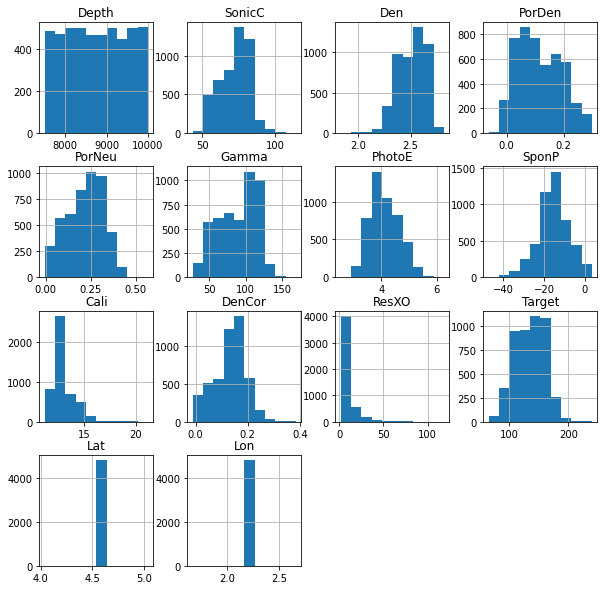

In [ ]:
testing.hist(figsize=(10,10))
plt.show()

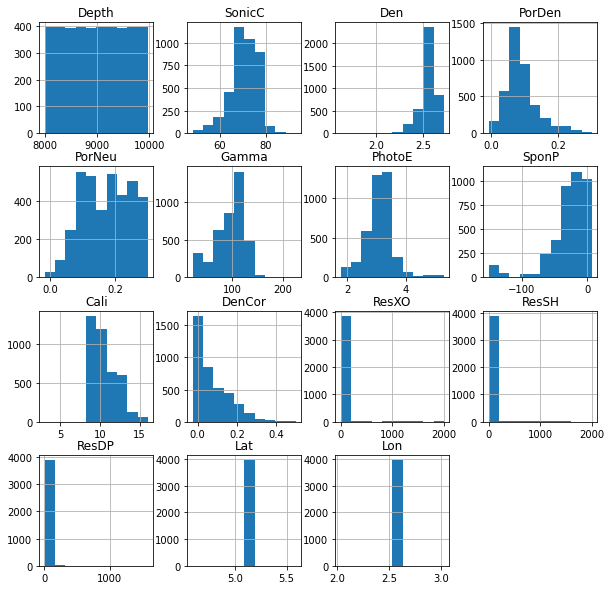

In [ ]:
test.hist(figsize=(10,10))
plt.show()

In [ ]:
# Transoform ResXO to logarithmic
x_train['ResXO'] = np.log10(x_train['ResXO'])
x_train.head()

Depth   SonicC     Den  PorDen  ...     Cali  DenCor     ResXO    Target
11126  6498.0  78.3858  2.6686  0.0294  ...  10.4607  0.0085  0.947855  145.7087
11127  6498.5  78.5007  2.6618  0.0343  ...  10.4861  0.0067  0.931981  145.7087
11128  6499.0  78.7959  2.6550  0.0391  ...  10.5114  0.0038  0.908174  145.7087
11129  6499.5  79.0788  2.6481  0.0420  ...  10.5348  0.0011  0.917175  145.9386
11130  6500.0  79.1212  2.6427  0.0425  ...  10.5631  0.0010  0.926173  145.9640

[5 rows x 12 columns]

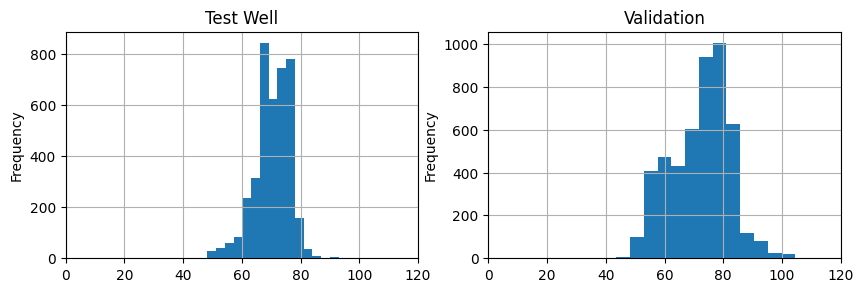

In [ ]:
font = {'size'   : 10}
plt.rc('font', **font)

fig = plt.subplots(figsize=(10, 3), dpi= 100, facecolor='w', edgecolor='k')

ax1=plt.subplot(1,2,1)
test['SonicC'].hist(bins=15)
plt.title("Test Well")
plt.ylabel("Frequency")
plt.xlim(0,120)
#plt.ylim(0,2000)

ax2=plt.subplot(1,2,2) 
testing['SonicC'].hist(bins=15)
plt.title("Validation")
plt.ylabel("Frequency")
plt.xlim(0,120)
plt.show()

### Standardization

In [ ]:
testing.columns

Index(['Depth', 'SonicC', 'Den', 'PorDen', 'PorNeu', 'Gamma', 'PhotoE',
       'SponP', 'Cali', 'DenCor', 'ResXO', 'Target', 'Lat', 'Lon', 'well'],
      dtype='object')

In [ ]:
x_train.columns

Index(['Depth', 'SonicC', 'Den', 'PorDen', 'PorNeu', 'Gamma', 'PhotoE',
       'SponP', 'Cali', 'DenCor', 'ResXO', 'Target'],
      dtype='object')

In [ ]:
# Copy data to avoid altering the original x_train data
scaled_features = x_train.drop(labels='Target', axis=1)
y_train = x_train['Target'].values

# Move the Depth column to the last
scaled_features = scaled_features[['Depth', 'SonicC', 'Den', 'PorDen', 'PorNeu', 'Gamma', 'PhotoE',
       'SponP', 'Cali', 'DenCor', 'ResXO']]

col_names = scaled_features.columns

std_features = ['Depth', 'SonicC', 'Den', 'PorDen', 'PorNeu', 'Gamma', 'PhotoE',
       'SponP', 'Cali', 'DenCor', 'ResXO']
scaled_features

Depth   SonicC     Den  PorDen  ...    SponP     Cali  DenCor     ResXO
11126  6498.0  78.3858  2.6686  0.0294  ... -10.7897  10.4607  0.0085  0.947855
11127  6498.5  78.5007  2.6618  0.0343  ... -11.9332  10.4861  0.0067  0.931981
11128  6499.0  78.7959  2.6550  0.0391  ... -11.8925  10.5114  0.0038  0.908174
11129  6499.5  79.0788  2.6481  0.0420  ... -11.8518  10.5348  0.0011  0.917175
11130  6500.0  79.1212  2.6427  0.0425  ... -11.8111  10.5631  0.0010  0.926173
...       ...      ...     ...     ...  ...      ...      ...     ...       ...
19665  9880.5  56.0417  2.5700  0.0785  ... -27.3508   7.5016  0.0626  1.630826
19666  9881.0  56.8915  2.3779  0.2290  ... -27.9294   7.5029  0.0377  1.911339
19667  9881.5  58.9502  2.2082  0.2982  ... -27.9222   7.4915  0.0487  2.266190
19668  9882.0  59.5282  2.1799  0.2947  ... -27.9151   3.1571  0.1463  1.699000
19669  9882.5  57.7636  2.2913  0.2241  ... -27.9079   3.1565  0.2426  1.496305

[231221 rows x 11 columns]

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

# Standardize all the columns except 'Depth'
# Standardization using StandardScaler
scaler = StandardScaler()

## ColumnTransformer
ct = ColumnTransformer([('standardize', scaler, std_features)], remainder='passthrough')

## fit and transform
well_train_norm = ct.fit_transform(scaled_features)

## convert to dataframe
x_train_std = pd.DataFrame(well_train_norm, columns=col_names)
x_train_std

Depth    SonicC       Den  ...      Cali    DenCor     ResXO
0      -0.397287  0.377055  0.729256  ... -0.133988 -0.634901 -0.167626
1      -0.397138  0.384781  0.692380  ... -0.122996 -0.665163 -0.191032
2      -0.396989  0.404633  0.655505  ... -0.112047 -0.713920 -0.226136
3      -0.396840  0.423657  0.618088  ... -0.101920 -0.759313 -0.212865
4      -0.396691  0.426509  0.588804  ... -0.089673 -0.760995 -0.199597
...          ...       ...       ...  ...       ...       ...       ...
231216  0.609423 -1.125536  0.194565  ... -1.414565  0.274656  0.839422
231217  0.609572 -1.068389 -0.847160  ... -1.414003 -0.143976  1.253040
231218  0.609721 -0.929946 -1.767414  ... -1.418936  0.040962  1.776271
231219  0.609869 -0.891077 -1.920880  ... -3.294688  1.681862  0.939944
231220  0.610018 -1.009743 -1.316777  ... -3.294948  3.300907  0.641070

[231221 rows x 11 columns]

In [ ]:
y_train

array([145.7087, 145.7087, 145.7087, ..., 110.824 , 111.377 , 108.7116])

In [ ]:
x_train_std = x_train_std.values

In [ ]:
x_train_std

array([[-0.39728651,  0.3770545 ,  0.72925571, ..., -0.13398759,
        -0.63490092, -0.16762608],
       [-0.39713769,  0.38478127,  0.69238048, ..., -0.1229955 ,
        -0.66516343, -0.19103203],
       [-0.39698888,  0.40463281,  0.65550525, ..., -0.11204669,
        -0.7139197 , -0.22613631],
       ...,
       [ 0.60972053, -0.92994634, -1.76741435, ..., -1.41893634,
         0.04096184,  1.77627148],
       [ 0.60986934, -0.89107713, -1.92088039, ..., -3.29468801,
         1.68186248,  0.93994403],
       [ 0.61001815, -1.00974255, -1.31677733, ..., -3.29494767,
         3.30090686,  0.64106951]])

### 1. Linear Regression (To test if everything works)

## Testing

In [ ]:
testing.head()

Depth   SonicC     Den  ...       Lat      Lon          well
14926  7500.0  78.2014  2.4604  ...  4.538054  2.16706  d6aa464fab0e
14927  7500.5  79.2464  2.4697  ...  4.538054  2.16706  d6aa464fab0e
14928  7501.0  79.5805  2.4744  ...  4.538054  2.16706  d6aa464fab0e
14929  7501.5  79.2421  2.4919  ...  4.538054  2.16706  d6aa464fab0e
14930  7502.0  79.1833  2.5163  ...  4.538054  2.16706  d6aa464fab0e

[5 rows x 15 columns]

In [ ]:
# Get a list of columns or features from the training set
column = list(testing.columns)
print(column)

['Depth', 'SonicC', 'Den', 'PorDen', 'PorNeu', 'Gamma', 'PhotoE', 'SponP', 'Cali', 'DenCor', 'ResXO', 'Target', 'Lat', 'Lon', 'well']


In [ ]:
# Selecting specific columns from the training set and removing ResSH, ResDP, Target and Well
# ResSH and ResDP were removed due to a large radius of investigation and hence low correlation with Target
select_columns = list(column[i] for i in [11, 12, 13, 14])
select_columns

['Target', 'Lat', 'Lon', 'well']

In [ ]:
# Dropping the selected columns SP, ResSH, ResMD, ResDP and Target from the training data
# and assigning the target into a separate DataFrame for well 2
x_testing = testing.drop(select_columns, axis=1)
y_testing = testing["Target"].values

In [ ]:
x_testing.head()

Depth   SonicC     Den  PorDen  ...    SponP     Cali  DenCor   ResXO
14926  7500.0  78.2014  2.4604  0.1477  ... -19.4037  12.3759  0.2104  4.0234
14927  7500.5  79.2464  2.4697  0.1409  ... -17.6182  12.4331  0.2008  4.0394
14928  7501.0  79.5805  2.4744  0.1390  ... -14.8843  13.0779  0.1791  3.8284
14929  7501.5  79.2421  2.4919  0.1299  ... -14.2749  12.5904  0.1573  3.7016
14930  7502.0  79.1833  2.5163  0.1168  ... -14.0614  12.8233  0.1355  3.6829

[5 rows x 11 columns]

In [ ]:
x_train.head()

Depth   SonicC     Den  PorDen  ...     Cali  DenCor     ResXO    Target
11126  6498.0  78.3858  2.6686  0.0294  ...  10.4607  0.0085  0.947855  145.7087
11127  6498.5  78.5007  2.6618  0.0343  ...  10.4861  0.0067  0.931981  145.7087
11128  6499.0  78.7959  2.6550  0.0391  ...  10.5114  0.0038  0.908174  145.7087
11129  6499.5  79.0788  2.6481  0.0420  ...  10.5348  0.0011  0.917175  145.9386
11130  6500.0  79.1212  2.6427  0.0425  ...  10.5631  0.0010  0.926173  145.9640

[5 rows x 12 columns]

In [ ]:
y_testing

array([179.1819, 178.6334, 166.0426, ..., 107.4317, 118.7415, 107.4631])

In [ ]:
# Transoform ResXO to logarithmic
x_testing['ResXO'] = np.log10(x_testing['ResXO'])
x_testing.head()

Depth   SonicC     Den  PorDen  ...    SponP     Cali  DenCor     ResXO
14926  7500.0  78.2014  2.4604  0.1477  ... -19.4037  12.3759  0.2104  0.604593
14927  7500.5  79.2464  2.4697  0.1409  ... -17.6182  12.4331  0.2008  0.606317
14928  7501.0  79.5805  2.4744  0.1390  ... -14.8843  13.0779  0.1791  0.583017
14929  7501.5  79.2421  2.4919  0.1299  ... -14.2749  12.5904  0.1573  0.568389
14930  7502.0  79.1833  2.5163  0.1168  ... -14.0614  12.8233  0.1355  0.566190

[5 rows x 11 columns]

In [ ]:
## Transform
x_testing = ct.transform(x_testing)
x_testing # Display the data

array([[-0.09906837,  0.36465401, -0.3997771 , ...,  0.69483292,
         2.75954415, -0.67376915],
       [-0.09891956,  0.43492794, -0.3493448 , ...,  0.71958675,
         2.59814408, -0.67122761],
       [-0.09877075,  0.45739542, -0.32385751, ...,  0.99862991,
         2.23331269, -0.70558304],
       ...,
       [ 0.64469122, -0.64279834,  0.58880446, ...,  0.61983574,
        -0.35581331, -0.45727498],
       [ 0.64484003, -0.65570319,  0.57036685, ...,  0.61529177,
        -0.26334453, -0.4413125 ],
       [ 0.64498884, -0.68036295,  0.58283935, ...,  0.61070452,
        -0.16246949, -0.42890113]])

In [ ]:
# Apply a simple Linear Regression model
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(x_train_std, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
# Get the mean of RMSE for all RMSE from 5-fold cross-validation
from sklearn.model_selection import cross_val_score
np.random.seed(32)

scores = cross_val_score(lin_reg, x_train_std, y_train, scoring="neg_mean_squared_error", cv=5)
lin_reg_acc = np.mean(np.sqrt(-scores))
lin_reg_acc

16.752536855266722

### 2. ANN

In [ ]:
def plot_NN(model,history,x_train,y_train):
    """ Plot training loss versus validation loss and 
    training accuracy versus validation accuracy"""
    
    font = {'size'   : 7.5}
    plt.rc('font', **font)
    fig, ax=plt.subplots(figsize=(7, 5), dpi= 200, facecolor='w', edgecolor='k')
    
    ax1 = plt.subplot(2,2,1)    
    history_dict = history.history
    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    epochs = range(1, len(loss_values) + 1)
    ax1.plot(epochs, loss_values, 'bo',markersize=4, label='Training loss')          
    ax1.plot(epochs, val_loss_values, 'r-', label='Validation loss')    
    plt.title('Training and validation loss',fontsize=11)
    plt.xlabel('Epochs (Early Stopping)',fontsize=9)
    plt.ylabel('Loss',fontsize=10)
    plt.legend(fontsize='8.5')
    plt.ylim((0, 150))
    
    ax2 = plt.subplot(2,2,2)
    pred=model.predict(x_train)
    t = pd.DataFrame({'pred': pred.flatten(), 'y': y_train.flatten()})
    t.sort_values(by=['y'], inplace=True)    

    epochs = range(1, len(loss_values) + 1)        
    ax2.plot(t['pred'].tolist(), 'g', label='Prediction')    
    ax2.plot(t['y'].tolist(), 'm--o',markersize=2, label='Expected')      
    plt.title('Prediction vs Expected for Training',fontsize=11)
    plt.xlabel('Data',fontsize=9)
    plt.ylabel('Output',fontsize=10)
    plt.legend(fontsize='8.5')    
    fig.tight_layout(w_pad=1.42)
    plt.show()

In [ ]:
def DNN (input_dim,neurons=50,loss="mse",activation="relu",Nout=1,L2_regularizer=False,
             metrics=None,activation_out=None,init_mode=None,BatchOpt=False,dropout_rate=False):
    """ Function to run Deep Neural Network (5 hidden layer) for different hyperparameters"""
    np.random.seed(42)
    tf.random.set_seed(42)
    
    keras.backend.clear_session() # Clear the previous model
    
    if(activation=='Leaky_relu'): activation = keras.layers.LeakyReLU(alpha=0.2)
    if(L2_regularizer): kernel_regularizer=keras.regularizers.l2() 
    else: kernel_regularizer=None
        
    # create model
    model = keras.models.Sequential()
    
    # Input & Hidden Layer 1
    model.add(keras.layers.Dense(neurons,input_dim=input_dim, activation=activation, 
                                 kernel_initializer=init_mode,kernel_regularizer=kernel_regularizer))
    if(BatchOpt): model.add(keras.layers.BatchNormalization())
    if(dropout_rate):  model.add(keras.layers.Dropout(dropout_rate))
        
    # Hidden Layer 2
    model.add(keras.layers.Dense(neurons,activation=activation,
                                 kernel_initializer=init_mode,kernel_regularizer=kernel_regularizer))
    if(BatchOpt): model.add(keras.layers.BatchNormalization())
    if(dropout_rate):  model.add(keras.layers.Dropout(dropout_rate))

    # Hidden Layer 3
    model.add(keras.layers.Dense(neurons,activation=activation,
                                 kernel_initializer=init_mode,kernel_regularizer=kernel_regularizer))
    if(BatchOpt): model.add(keras.layers.BatchNormalization())
    if(dropout_rate):  model.add(keras.layers.Dropout(dropout_rate))

    # Hidden Layer 4
    model.add(keras.layers.Dense(neurons,activation=activation,
                                 kernel_initializer=init_mode,kernel_regularizer=kernel_regularizer))
    if(BatchOpt): model.add(keras.layers.BatchNormalization())
    if(dropout_rate):  model.add(keras.layers.Dropout(dropout_rate))

    # Hidden Layer 5
    model.add(keras.layers.Dense(neurons,activation=activation,
                                 kernel_initializer=init_mode,kernel_regularizer=kernel_regularizer))
    if(BatchOpt): model.add(keras.layers.BatchNormalization())
    if(dropout_rate):  model.add(keras.layers.Dropout(dropout_rate))

    # Output Layer 
    model.add(keras.layers.Dense(Nout,activation=activation_out)) 
        
    # Compile model
    model.compile(optimizer='adam',loss=loss,metrics=metrics)
    return model

In [ ]:
x_train_std.shape

(231221, 11)

In [ ]:
import tensorflow as tf
from tensorflow import keras

model_DNN = DNN (input_dim=x_train_std.shape[1], neurons=450, Nout=1, L2_regularizer=False,
                 init_mode=None , dropout_rate=None, activation='relu', metrics=None,
                 activation_out=None, loss='mse')

# Early stopping to avoid overfitting
monitor= keras.callbacks.EarlyStopping(min_delta=1e-3,patience=3)
history=model_DNN.fit(x_train_std,y_train,batch_size=32,validation_data=
          (x_testing,y_testing),callbacks=[monitor],verbose=1,epochs=1000) 

Epoch 1/1000
7226/7226 [==============================] - 33s 4ms/step - loss: 486.6935 - val_loss: 340.8514
Epoch 2/1000
7226/7226 [==============================] - 32s 4ms/step - loss: 135.4280 - val_loss: 333.8249
Epoch 3/1000
7226/7226 [==============================] - 31s 4ms/step - loss: 121.5321 - val_loss: 349.9197
Epoch 4/1000
7226/7226 [==============================] - 32s 4ms/step - loss: 115.6863 - val_loss: 349.6156
Epoch 5/1000
7226/7226 [==============================] - 32s 4ms/step - loss: 106.4581 - val_loss: 334.7275


In [ ]:
from sklearn.metrics import mean_squared_error
pred = model_DNN.predict(x_train_std)
mse = mean_squared_error(pred, y_train)
rmse = np.sqrt(mse)

print('rmse of all training: ',rmse)

rmse of all training:  10.030736551890014


In [ ]:
from sklearn.metrics import mean_squared_error
pred_testing = model_DNN.predict(x_testing)
mse_testing = mean_squared_error(pred_testing, y_testing)
rmse_testing = np.sqrt(mse_testing)

print('rmse of all validation: ',rmse_testing)

rmse of all validation:  18.29555839461827


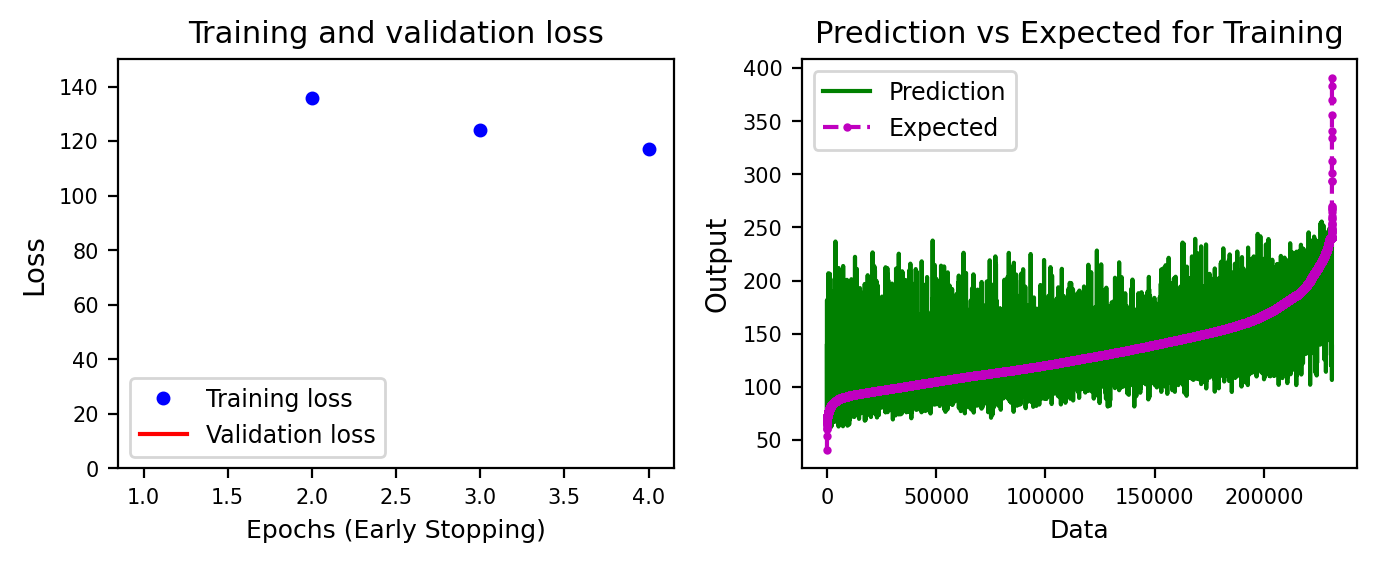

In [ ]:
plot_NN(model_DNN,history,x_train_std,y_train)

In [ ]:
pred_test_well = model_DNN.predict(x_testing)
pred_test_well[0:20]

array([[143.75568],
       [148.81447],
       [151.27057],
       [151.36363],
       [153.45909],
       [159.01587],
       [150.45433],
       [145.99542],
       [146.0754 ],
       [150.92593],
       [154.41954],
       [158.8053 ],
       [158.50476],
       [157.9327 ],
       [155.10674],
       [149.12712],
       [138.46368],
       [129.75012],
       [129.81708],
       [145.27368]], dtype=float32)

In [ ]:
# Convert training set back into a DataFrame and check info. to verify data has been imputed
pred_test = pd.DataFrame(pred_test_well, columns=['Prediction'], index=None)
pred_test.head()

Prediction
0  143.755676
1  148.814468
2  151.270569
3  151.363632
4  153.459091

In [ ]:
pred_test.to_csv('validation_well2.csv', index_label=False)
!cp validation_well2.csv "drive/My Drive/Colab Notebooks"

## Validation Checks

In [ ]:
# Test Well
df1 = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/well_eed1e9537976.xlsx')
#df2 = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/well_fca03aa6acde_final_2.xlsx')

# Validation Well
#df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/validation_well.csv')
df3 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/validation_well2.csv')

In [ ]:
well = test_wells2['eed1e9537976']
well

Depth   SonicC     Den  PorDen  ...    ResSH    ResDP       Lat       Lon
0     7997.0  70.4597  2.5928  0.0952  ...   8.3594   9.5325  5.091575  2.531974
1     7997.5  71.3532  2.5636  0.1003  ...  10.0339   9.8606  5.091575  2.531974
2     7998.0  71.6358  2.5429  0.0801  ...  12.4580  11.4478  5.091575  2.531974
3     7998.5  70.1030  2.5404  0.0633  ...  12.7996  13.8361  5.091575  2.531974
4     7999.0  67.7302  2.5563  0.0845  ...  11.8821  12.8388  5.091575  2.531974
...      ...      ...     ...     ...  ...      ...      ...       ...       ...
3952  9973.0  72.4888  2.6318  0.0477  ...   4.8895   5.8705  5.091575  2.531974
3953  9973.5  71.5946  2.6354  0.0429  ...   4.4774   4.6004  5.091575  2.531974
3954  9974.0  70.4024  2.6349  0.0425  ...   4.3284   4.7588  5.091575  2.531974
3955  9974.5  70.9985  2.6325  0.0425  ...   7.7494   9.4310  5.091575  2.531974
3956  9975.0  71.6948  2.6304  0.0436  ...  21.5468  20.1359  5.091575  2.531974

[3957 rows x 15 columns]

In [ ]:
df1.head()

Depth        DTSM
0  7997.0  140.855713
1  7997.5  143.294861
2  7998.0  141.072250
3  7998.5  132.605179
4  7999.0  130.919342

In [ ]:
df.head()

Depth        DTSM
0  10797.0  101.164230
1  10797.5  101.828255
2  10798.0  101.896378
3  10798.5  102.492134
4  10799.0  102.676903

In [ ]:
df1.columns = ['Depth', 'DTSM']

In [ ]:
df1.head()

Depth        DTSM
0  6984.0  101.743370
1  6984.5  100.463753
2  6985.0   99.228600
3  6985.5   98.910866
4  6986.0   98.753113

In [ ]:
df1.to_excel('well_ff7845ea074d.xlsx', index=False)
!cp well_ff7845ea074d.xlsx "drive/My Drive/Colab Notebooks"

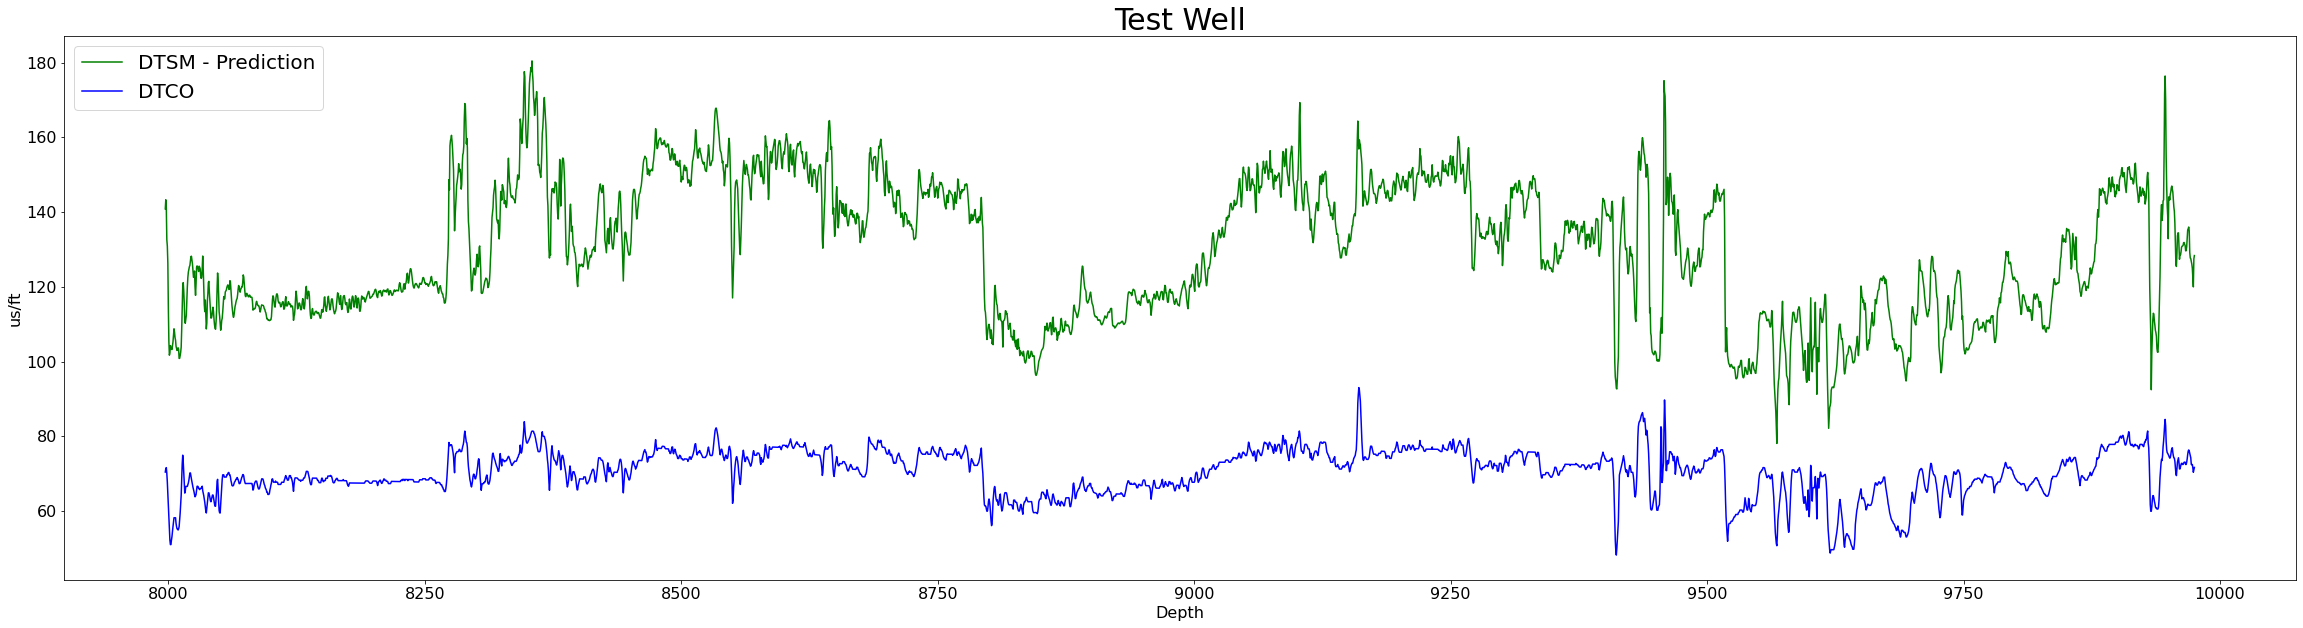

In [ ]:
plt.figure(figsize=(40,10))
plt.plot(df1['Depth'], df1['DTSM'], c='g', label='DTSM - Prediction')
plt.plot(well['Depth'], well['SonicC'], c='b', label='DTCO')

params = {'axes.labelsize': 16,
          'axes.titlesize': 16,
          'xtick.labelsize': 16,
          'ytick.labelsize': 16}
plt.rcParams.update(params)

plt.xlabel('Depth')
plt.ylabel('us/ft')
plt.title('Test Well', fontdict={'size': 30})
plt.legend(loc=2, prop={'size': 20})

plt.show()

In [ ]:
#print(df3.shape)
#print(df4.shape)
print(df1.shape)
print(df3.shape)
print(testing.shape)

(3957, 2)
(4836, 1)
(4836, 15)


In [ ]:
testing.columns

Index(['Depth', 'SonicC', 'Den', 'PorDen', 'PorNeu', 'Gamma', 'PhotoE', 'Cali',
       'DenCor', 'ResXO', 'Target', 'Lat', 'Lon', 'well'],
      dtype='object')

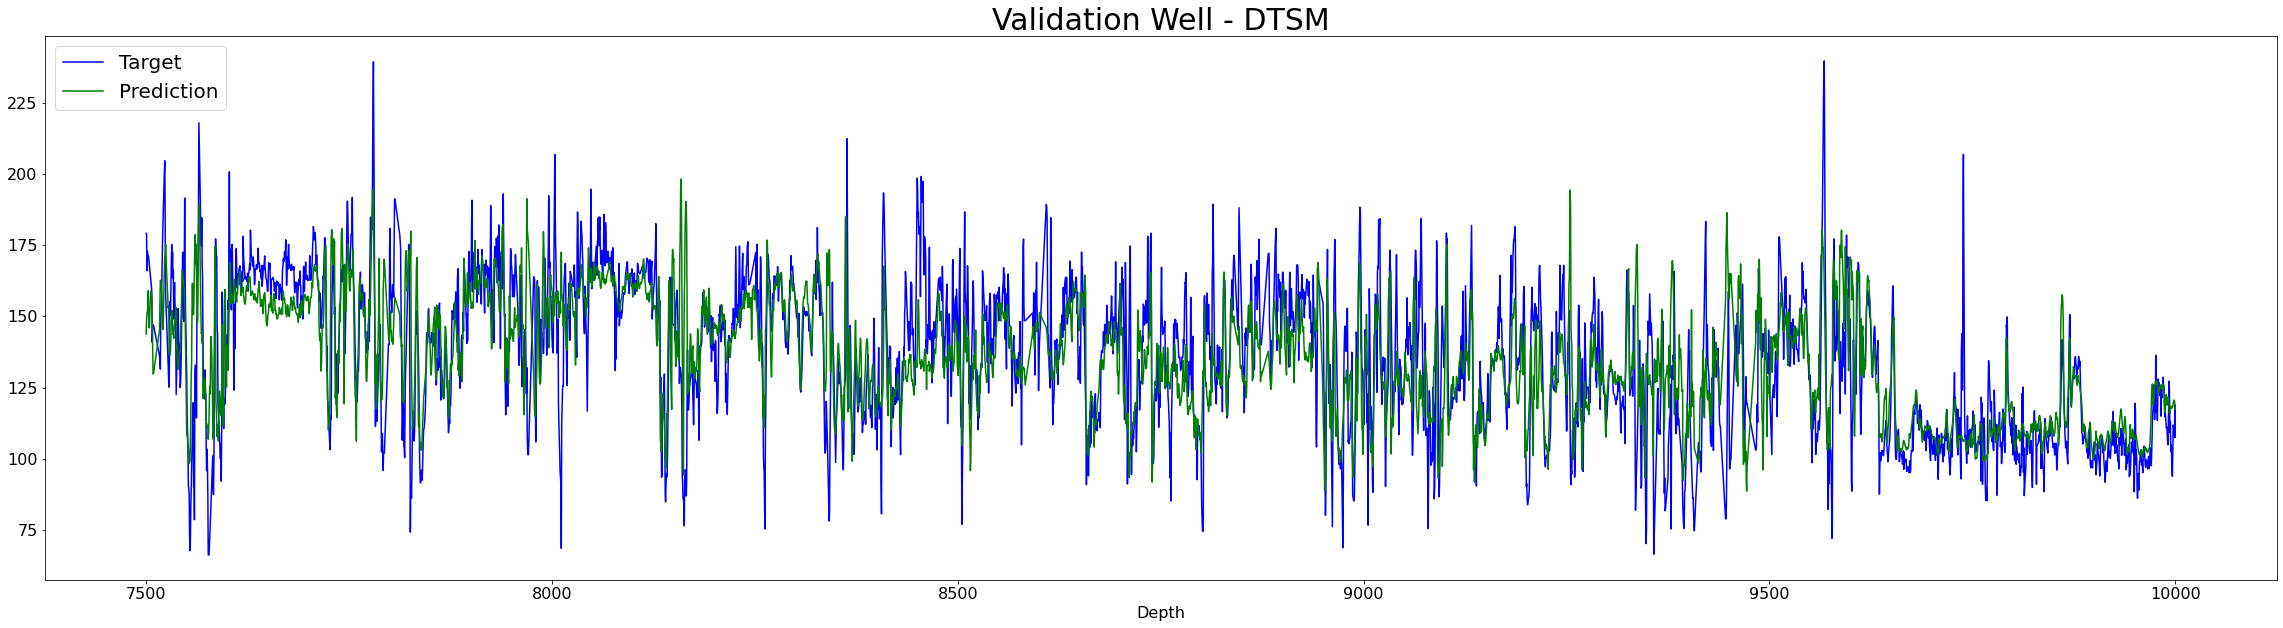

In [ ]:
plt.figure(figsize=(40,10))
plt.plot(testing['Depth'], testing['Target'], c='b', label='Target')
plt.plot(testing['Depth'], df3['Prediction'], c='g', label='Prediction')

params = {'axes.labelsize': 16,
          'axes.titlesize': 16,
          'xtick.labelsize': 16,
          'ytick.labelsize': 16}
plt.rcParams.update(params)

plt.xlabel('Depth')
plt.legend(loc=2, prop={'size': 20})
plt.title('Validation Well - DTSM', fontdict={'size': 30})

plt.show()

In [ ]:
testing['Target'].shape

(5483,)

In [ ]:
df4['Prediction'].shape

(5483,)

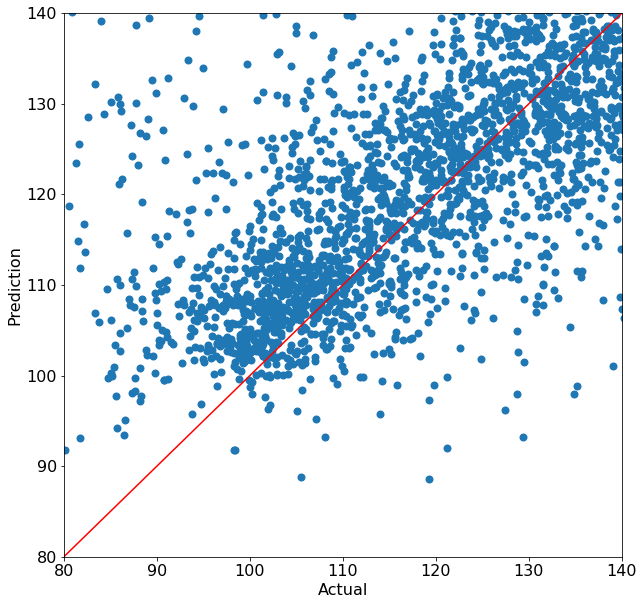

In [ ]:
plt.figure(figsize=(10,10))
plt.scatter((testing.Target), (df3.Prediction), linewidths=2)
plt.plot([80, 200], [80, 200], color = 'red')
plt.xlim(80,140)
plt.ylim(80,140)
plt.xlabel('Actual')
plt.ylabel('Prediction')
plt.show()

## Prediction - eed1e9537976

In [ ]:
x_test = test_wells2['eed1e9537976']
x_test.head()

Depth   SonicC     Den  PorDen  ...    ResSH    ResDP       Lat       Lon
0  7997.0  70.4597  2.5928  0.0952  ...   8.3594   9.5325  5.091575  2.531974
1  7997.5  71.3532  2.5636  0.1003  ...  10.0339   9.8606  5.091575  2.531974
2  7998.0  71.6358  2.5429  0.0801  ...  12.4580  11.4478  5.091575  2.531974
3  7998.5  70.1030  2.5404  0.0633  ...  12.7996  13.8361  5.091575  2.531974
4  7999.0  67.7302  2.5563  0.0845  ...  11.8821  12.8388  5.091575  2.531974

[5 rows x 15 columns]

In [ ]:
# Get a list of columns or features from the training set
column = list(x_test.columns)
print(column)

['Depth', 'SonicC', 'Den', 'PorDen', 'PorNeu', 'Gamma', 'PhotoE', 'SponP', 'Cali', 'DenCor', 'ResXO', 'ResSH', 'ResDP', 'Lat', 'Lon']


In [ ]:
x_train.columns

Index(['Depth', 'SonicC', 'Den', 'PorDen', 'PorNeu', 'Gamma', 'PhotoE',
       'SponP', 'Cali', 'DenCor', 'ResXO', 'Target'],
      dtype='object')

In [ ]:
# Selecting specific columns from the training set and removing ResSH, ResDP, Target and Well
# ResSH and ResDP were removed due to a large radius of investigation and hence low correlation with Target
select_columns = list(column[i] for i in [11, 12, 13, 14])
select_columns

['ResSH', 'ResDP', 'Lat', 'Lon']

In [ ]:
# Dropping the selected columns SP, ResSH, ResMD, ResDP and Target from the training data
# and assigning the target into a separate DataFrame for well 2
x_test = x_test.drop(select_columns, axis=1)
x_test.head(100)

Depth   SonicC     Den  PorDen  ...    SponP     Cali  DenCor    ResXO
0   7997.0  70.4597  2.5928  0.0952  ... -39.9863  11.4366  0.1268   8.4732
1   7997.5  71.3532  2.5636  0.1003  ... -40.8553  11.3169  0.1352  10.1020
2   7998.0  71.6358  2.5429  0.0801  ... -41.5774  11.1179  0.1195  11.8821
3   7998.5  70.1030  2.5404  0.0633  ... -42.1231  10.8300  0.0951  13.0619
4   7999.0  67.7302  2.5563  0.0845  ... -42.8850  10.3443  0.0961  11.1051
..     ...      ...     ...     ...  ...      ...      ...     ...      ...
95  8044.5  62.8194  2.4600  0.1203  ... -61.5072  10.7741  0.0228  12.3741
96  8045.0  61.9254  2.4888  0.1431  ... -62.9791  10.8027  0.0240  11.7224
97  8045.5  61.3299  2.5121  0.1547  ... -64.7460  10.8709  0.0240  11.7224
98  8046.0  61.3093  2.5152  0.1252  ... -66.5129  10.9194  0.0273  11.7224
99  8046.5  63.1239  2.4869  0.1123  ... -67.9849  10.9775  0.0337  11.6434

[100 rows x 11 columns]

In [ ]:
x_test.shape

(3957, 11)

In [ ]:
x_test.isna().sum()

Depth     0
SonicC    0
Den       0
PorDen    0
PorNeu    0
Gamma     0
PhotoE    0
SponP     0
Cali      0
DenCor    0
ResXO     0
dtype: int64

In [ ]:
x_test.head(15)

Depth   SonicC     Den  PorDen  ...    SponP     Cali  DenCor     ResXO
0   7997.0  70.4597  2.5928  0.0952  ... -39.9863  11.4366  0.1268    8.4732
1   7997.5  71.3532  2.5636  0.1003  ... -40.8553  11.3169  0.1352   10.1020
2   7998.0  71.6358  2.5429  0.0801  ... -41.5774  11.1179  0.1195   11.8821
3   7998.5  70.1030  2.5404  0.0633  ... -42.1231  10.8300  0.0951   13.0619
4   7999.0  67.7302  2.5563  0.0845  ... -42.8850  10.3443  0.0961   11.1051
5   7999.5  64.7574  2.5815  0.1140  ... -43.4783   9.7300  0.1400   10.9559
6   8000.0  61.7910  2.5608  0.1270  ... -44.2019   9.1850  0.1943   12.2907
7   8000.5  59.1060  2.4817  0.1032  ... -45.2540   8.9861  0.2001   14.8528
8   8001.0  55.2269  2.5134  0.0968  ... -47.3220   9.0643  0.1816   16.1083
9   8001.5  52.2433  2.5695  0.0935  ... -48.5888   9.6021  0.1530   18.9468
10  8002.0  51.0508  2.6062  0.0757  ... -50.0525   9.5270  0.1224   24.4983
11  8002.5  51.0523  2.6340  0.0429  ... -51.7641   9.2886  0.0868   57.0483
12  8003.0  52.2478  2.6765  0.0178  ... -53.2057   9.1540  0.0578  101.3622
13  8003.5  53.1448  2.7111  0.0060  ... -55.0061   9.1530  0.0393   83.3119
14  8004.0  54.6389  2.7163 -0.0001  ... -56.7790   9.2707  0.0300   67.1008

[15 rows x 11 columns]

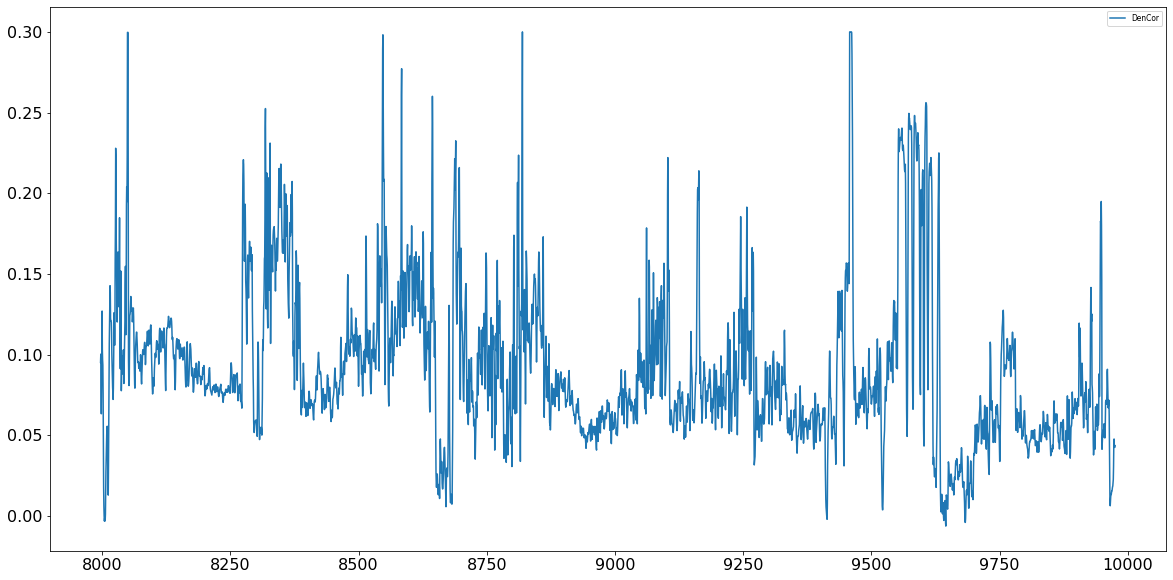

In [ ]:
x_test['PorNeu'] = x_test['PorNeu'].fillna(method='ffill')
x_test['Gamma'] = x_test['Gamma'].fillna(method='ffill')
x_test['ResXO'] = x_test['ResXO'].fillna(method='bfill')
plt.figure(figsize=(20,10))

plt.plot(x_test['Depth'], x_test['PorDen'], label='DenCor')
#plt.plot(x_test['Depth'], x_test['PorDen'], label='PorDen')
#plt.plot(x_test['Depth'], x_test['PorNeu'], label='PorNeu')
#plt.plot(x_test['Depth'], x_test['PhotoE'], label='PhotoE')
#plt.plot(x_test['Depth'], x_test['PhotoE'], label='PhotoE')
#plt.plot(x_test['Depth'], x_test['SponP'], label='SponP')
#plt.plot(x_test['Depth'], x_test['Cali'], label='Cali')
#plt.plot(x_test['Depth'], x_test['DenCor'], label='DenCor')
#plt.plot(x_test['Depth'], x_test['ResXO'], label='ResXO')

plt.legend()
plt.show()

In [ ]:
x_test.head()

Depth   SonicC     Den  PorDen  ...    SponP     Cali  DenCor    ResXO
0  7997.0  70.4597  2.5928  0.0952  ... -39.9863  11.4366  0.1268   8.4732
1  7997.5  71.3532  2.5636  0.1003  ... -40.8553  11.3169  0.1352  10.1020
2  7998.0  71.6358  2.5429  0.0801  ... -41.5774  11.1179  0.1195  11.8821
3  7998.5  70.1030  2.5404  0.0633  ... -42.1231  10.8300  0.0951  13.0619
4  7999.0  67.7302  2.5563  0.0845  ... -42.8850  10.3443  0.0961  11.1051

[5 rows x 11 columns]

In [ ]:
# Transoform ResXO to logarithmic
x_test['ResXO'] = np.log10(x_test['ResXO'])
x_test.head()

Depth   SonicC     Den  PorDen  ...    SponP     Cali  DenCor     ResXO
0  7997.0  70.4597  2.5928  0.0952  ... -39.9863  11.4366  0.1268  0.928047
1  7997.5  71.3532  2.5636  0.1003  ... -40.8553  11.3169  0.1352  1.004407
2  7998.0  71.6358  2.5429  0.0801  ... -41.5774  11.1179  0.1195  1.074893
3  7998.5  70.1030  2.5404  0.0633  ... -42.1231  10.8300  0.0951  1.116006
4  7999.0  67.7302  2.5563  0.0845  ... -42.8850  10.3443  0.0961  1.045522

[5 rows x 11 columns]

In [ ]:
## Transform
x_test = ct.transform(x_test)
x_test # Display the data

array([[ 0.0488502 , -0.15595808,  0.31820534, ...,  0.28834216,
         1.3540186 , -0.1968326 ],
       [ 0.04899901, -0.0958722 ,  0.15985876, ...,  0.23654088,
         1.49524366, -0.08423915],
       [ 0.04914782, -0.07686797,  0.04760622, ...,  0.15042179,
         1.2312873 ,  0.01969294],
       ...,
       [ 0.63725064, -0.15981138,  0.5465064 , ..., -0.93489512,
        -0.82656349, -0.58508805],
       [ 0.63739946, -0.11972498,  0.53349162, ..., -0.94748842,
        -0.36926332, -0.32940608],
       [ 0.63754827, -0.07290036,  0.52210368, ..., -0.97289139,
        -0.17760074,  0.31629771]])

In [ ]:
pred_well_2 = model_DNN.predict(x_test)
pred_well_2[0:20]

array([[140.85571 ],
       [143.29486 ],
       [141.07225 ],
       [132.60518 ],
       [130.91934 ],
       [126.358   ],
       [114.18006 ],
       [105.43033 ],
       [101.71687 ],
       [102.34193 ],
       [104.294014],
       [103.63924 ],
       [103.40907 ],
       [103.21667 ],
       [104.218735],
       [105.25042 ],
       [106.9867  ],
       [108.77623 ],
       [107.923294],
       [106.43357 ]], dtype=float32)

In [ ]:
# Convert training set back into a DataFrame and check info. to verify data has been imputed
prediction = pd.DataFrame(pred_well_2, columns=['DTSM'], index=None)
prediction.head()

DTSM
0  140.855713
1  143.294861
2  141.072250
3  132.605179
4  130.919342

In [ ]:
df = test_wells2['eed1e9537976']
df.head()

Depth   SonicC     Den  PorDen  ...    ResSH    ResDP       Lat       Lon
0  7997.0  70.4597  2.5928  0.0952  ...   8.3594   9.5325  5.091575  2.531974
1  7997.5  71.3532  2.5636  0.1003  ...  10.0339   9.8606  5.091575  2.531974
2  7998.0  71.6358  2.5429  0.0801  ...  12.4580  11.4478  5.091575  2.531974
3  7998.5  70.1030  2.5404  0.0633  ...  12.7996  13.8361  5.091575  2.531974
4  7999.0  67.7302  2.5563  0.0845  ...  11.8821  12.8388  5.091575  2.531974

[5 rows x 15 columns]

In [ ]:
df1 = df[['Depth']]
df1.head()

Depth
0  7997.0
1  7997.5
2  7998.0
3  7998.5
4  7999.0

In [ ]:
frames = [df1, prediction]
result = pd.concat(frames, axis=1)
result.head(20)

Depth        DTSM
0   7997.0  140.855713
1   7997.5  143.294861
2   7998.0  141.072250
3   7998.5  132.605179
4   7999.0  130.919342
5   7999.5  126.358002
6   8000.0  114.180061
7   8000.5  105.430328
8   8001.0  101.716873
9   8001.5  102.341927
10  8002.0  104.294014
11  8002.5  103.639236
12  8003.0  103.409073
13  8003.5  103.216667
14  8004.0  104.218735
15  8004.5  105.250420
16  8005.0  106.986702
17  8005.5  108.776230
18  8006.0  107.923294
19  8006.5  106.433571

In [ ]:
result.to_excel('well_eed1e9537976.xlsx', index=False)
!cp well_eed1e9537976.xlsx "drive/My Drive/Colab Notebooks"